In [170]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools

import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
from hdfviewer.widgets.HDFViewer import HDFViewer
from hdfviewer.widgets.PathSelector import PathSelector
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import bokeh.io
import bokeh.plotting
from bokeh.palettes import Spectral11
from scipy.signal import butter, lfilter, freqz, find_peaks, correlate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
#from Butterworth_Filter import butter_bandpass, butter_bandpass_filter
import glob
from quantities import ms, s, Hz
#from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
import math
from collections import Counter
import scipy


import networkx as nx

from time import strftime
%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# helper line -> get different outpaths for sorted datasets; uncheck the date

#191021
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont_spikesorting'
# outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting'



#191021extra
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021extra'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_29042021_hCSF_child_20min_spont_spikesorting'


#191017
mainpath = 'D:\Files_Reutlingen_Jenny\main_191017'
outpath = 'D:\Files_Reutlingen_Jenny\main_191017\_output_Spikesorting_30042021_spontaneous_spikesorting'



#191023
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191023'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_hCSF_afterDNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_spikesorting'


labeldic =  np.load(
    'D:\Files_Reutlingen_Jenny\_layerdictionaries\labeldictionary_MCS_256MEA.npy', 
    allow_pickle='TRUE').item() 

In [3]:
os.chdir(mainpath)
folderlist = glob.glob('*_output_Spikesorting*spikesorting*')

In [4]:
# loading functions

def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*recording.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic


# function to get the filebase from folder
def get_filebase_from_foldername(mainpath_folder):
    
    separator = '_'
    filebase = separator.join(mainpath_folder.split('\\')[-1].split('_')[4:-1])
    
    return filebase




def get_dictionary_keys(outpath_folder):

    dictkeys = []
    os.chdir(outpath_folder)
    folders_sorting = glob.glob('*sorted*')
    for i in folders_sorting:
        dk = i.split('sorted_')[1]
        dictkeys.append(dk)
    
    return dictkeys, print('Dictkeys are %s. Your CWD may have changed. Please check.' %dictkeys)



# function to convert basic information to dataframe
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
        
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
        
        unitframe.loc[(unitframe['unit_ids']==i), 'unit_index']=unitframe.loc[(unitframe['unit_ids']==i)].index
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
       
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        #unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
        
    return unitframe




def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert
    

In [5]:
# get a filebaselist for every folder in the mainpath, that we we can filter 

filebase_list = []
for i in folderlist:
    filebase = get_filebase_from_foldername(i)
    filebase_list.append(filebase)

In [6]:
os.chdir(outpath)

In [7]:
completeframe = pd.read_pickle(str('DF_' + filebase + '_' + 'complete') + '_df.pkl')

In [8]:
completeframe['unit_ids2'] = completeframe['unit_ids']

In [9]:
#completeframe.loc[(completeframe['subrecording']=='sec_0-300')]

In [10]:
# load spiketrains
st_channel = np.load(filebase+'_spiketrains_per_channel.npy', allow_pickle='TRUE').item()
st_neurons = np.load(filebase+'_spiketrains_per_unit.npy', allow_pickle='TRUE').item()
st_channels_neurons = np.load(filebase+'_spiketrains_nested_per_channel_per_unit.npy', allow_pickle='TRUE').item()

In [11]:
len(st_neurons)

209

In [12]:
filebase

'spontaneous'

# old functions from ISI Burst Detection

In [27]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins


def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1



def find_binned_spikes(data, bins):
    '''
    Parameters
    ----------
    data : for network spike binning --> expects an 1D array with all spikes detected for the network
    bins : list of tuples of expected bins

    Returns
    -------
    binlist : list of lists where lists contain all spikes for the respective bins

    '''
    binlist =[]
    binspike =[]
    for i in range(0, len(bins)):
        binspike = []
        for a in data:    
            if bins[i][0] <= a < bins[i][1]:
                binspike.append(a)
        binlist.append(binspike)
            
    return binlist




def get_isi_singlechannel(spikedic, tick):
    '''
    Parameters
    ----------
    spikedic : dictionary with all detected spikes for a channel
        DESCRIPTION.

    Returns
    -------
    isidic : keys = channels, values = List of tuples where tuple[0]=detected spike and tuple[1]=isi to the next detected spike
    isi_alone_dic : keys = channels, values = list of isi alone
    CAVE returns are in microseconds
    '''
    
    isidic ={}     
    isilist = []
    isi_alone_dic = {}
    isislist =[]

    for key in spikedic:
        isilist = []
        isislist = []
        if len(spikedic[key])>=2:
            for i in range(0, (len(spikedic[key])-1)):
                isi = spikedic[key][i]*tick, (spikedic[key][i+1]-spikedic[key][i])*tick #CL tick für beide dazu
                isi_alone = (spikedic[key][i+1]-spikedic[key][i])*tick
                isilist.append(isi)
                isislist.append(isi_alone)
        isidic[key]=isilist
        isi_alone_dic[key]=isislist
        
    return isidic, isi_alone_dic



def bin_isi(isi_alone_dic, binsize, binmax=bool, binmaxnumber=None):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per bin

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_bins(0, binsize, binmaxnumber)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ISI_dic


def bin_lnisi(isi_alone_dic, start_in_microseconds, stop_in_microseconds, totalbins, binmax):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel 
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per logarithmic spaced bins

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ln_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_ln_bins(start_in_microseconds, stop_in_microseconds, totalbins)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ln_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ln_ISI_dic, isibins


def get_allchannel_ISI_bins(histo_ISI_dic):
    '''
    Parameters
    ----------
    histo_ISI_dic : dic mit den einzelnen ISI für jeden Channel. Cave, die Values müssen alle die gleiche
                    Länge haben, sonst funktioniert die zip Funktion nicht.
        DESCRIPTION.

    Returns
    -------
    network_ISI_binned = array of all ISI of the whole network binned

    '''
    network_ISI = []
    for key in histo_ISI_dic:
        list1 = histo_ISI_dic[key]
        if len(list1)>len(network_ISI):
            network_ISI=list1
        else:
            list2 = network_ISI
            network_ISI = [a + b for a, b in zip(list1, list2)]
    return np.array(network_ISI)


def get_burst_threshold(df_with_CMA):
    '''
    

    Parameters
    ----------
    df_with_CMA : TYPE
        DESCRIPTION.

    Returns
    -------
    CMAalpha : TYPE
        DESCRIPTION.
    CMAalpha2 : TYPE
        DESCRIPTION.
    maxCMA : TYPE
        DESCRIPTION.
    alpha1 : TYPE
        DESCRIPTION.
    alpha2 : TYPE
        DESCRIPTION.

    '''
    
    networkburstthreshold_ISI = 200000 #wie im paper maximal bei 200 ms als isi
    skewness = scipy.stats.skew(network_ISI)
    if skewness < 1:
        alpha1 = 1
        alpha2 = 0.5
    elif skewness >= 1 and skewness <4:
        alpha1 = 0.7
        alpha2 = 0.3
    elif skewness >=4 and skewness <9:
        alpha1 = 0.5
        alpha2 = 0.3
    elif skewness >=9:
        alpha1 = 0.3
        alpha2 = 0.1
    maxCMA = max(df_with_CMA['CMA'])
    CMAalpha = maxCMA*alpha1
    CMAalpha2 = maxCMA*alpha2
    return CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2


def ISI_threshold_min(df_with_CMA, CMAalpha, CMAalpha2, binsize_in_micros):
    '''
    '''
    indexfactor = df[df['CMA']>CMAalpha].index[-1] + 1
    indexfactor2 = df[df['CMA']>CMAalpha2].index[-1] + 1
    threshold_intraburst = float(indexfactor*binsize_in_micros)
    threshold_burst_related = float(indexfactor2*binsize_in_micros)
    
    return threshold_intraburst, threshold_burst_related


def find_burst_starts(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        #print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            #print('burst '+str(setter))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            #print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


def find_burst_starts_and_length(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        #print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststart_spike = spikedic[key][counter]*tick
                        burstend_spike = spikedic[key][counter+setter]*tick
                        #burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            burstend_spike = spikedic[key][counter+setter]*tick
                            #print('burst '+str(setter))
                        burststartlist.append((burststart_spike, burstend_spike))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            #print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


# trial of burst detection

In [180]:
tick = 40
scale_factor_for_second = 1e-06
scale_factor_for_milisecond = 1e-03

In [181]:
isidic, isi_alone = get_isi_singlechannel(st_channel, tick) #creates two dictionaries
histo_ISI_dic=bin_isi(isi_alone, binsize=1000, binmax=True, binmaxnumber=600) # dictionary für jeden channel mit 300x 10ms bins (binsize) und der Menge an ISI für die jeweilige Länge
network_ISI=get_allchannel_ISI_bins(histo_ISI_dic) #gibt ein array mit bins entsprechend der bins aus der Vorfunktion


(array([ 3.,  2.,  4.,  4., 16.,  9., 14., 13., 13., 19., 15., 15., 15.,
        11., 26., 16., 13., 12., 18., 10., 11.,  7., 10., 23.,  5.,  4.,
         7.,  3., 12.,  5.,  6.,  5.,  3.,  9.,  2.,  2.,  4.,  8.,  2.,
         3.,  4.,  3.,  6.,  3.,  5.,  2.,  0.,  6.,  4.,  5.,  0.,  3.,
         7.,  5.,  1.,  2.,  4.,  3.,  3.,  4.,  3.,  6.,  2.,  2.,  4.,
         4.,  9.,  1.,  3.,  3.,  3.,  7.,  0.,  4.,  4.,  4.,  0.,  1.,
         4.,  2.,  4.,  0.,  0.,  1.,  1.,  0.,  0.,  3.,  0.,  2.,  3.,
         1.,  3.,  1.,  2.,  1.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  2.,  0.,  2.,  1.,  0.,  2.,  2.,  0.,  0.,
         0.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.

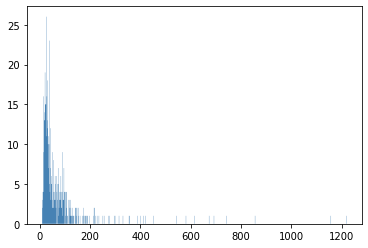

In [182]:
plt.hist(network_ISI, bins=1000, histtype='stepfilled', color='steelblue',edgecolor='none')


In [183]:
colors = ['green', 'blue', 'orange', 'purple']

<AxesSubplot:title={'center':'Histogram of ISI-bins 10ms whole network'}>

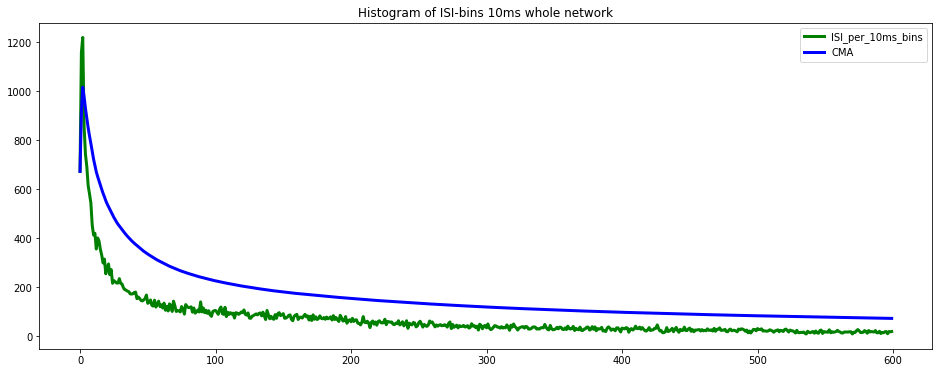

In [184]:
df= pd.DataFrame({'ISI_per_10ms_bins':network_ISI}) #aus Network_ISI wird ein pdDF um die weiteren Schritte durchführen zu können
df["CMA"] = df.ISI_per_10ms_bins.expanding().mean()
df[['ISI_per_10ms_bins', 'CMA']].plot(color=colors, linewidth=3, figsize=(16,6), title="Histogram of ISI-bins 10ms whole network")

In [185]:
CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2=get_burst_threshold(df) # threshold calculation
threshold_intraburst, threshold_burst_related = ISI_threshold_min(df, CMAalpha, CMAalpha2, 1000) #set thresholds

In [186]:
threshold_intraburst

23000.0

In [187]:
threshold_burst_related

59000.0

In [23]:
threshold_burst_related = 100000

In [24]:
# threshold_intraburst = 200000

In [25]:
burststartdic = find_burst_starts(isi_alone, threshold_intraburst, st_neurons) #dictionary mit allen burststarts


R12
R123
R124
R125
R126
R127
R128
R129
R1210
R1211
R1212
R1213
R1214
R1215
R1216
R1217
R1218
R1219
R1220
R1221
R1222
R1223
R1224
R1225
R1226
R1227
R1228
R1229
R1230
R1231
R1232
R1233
R1234
R1235
R1236
R1237
R1238
R1239
R1240
R1241
R1242
R1243
R1244
R1245
R1246
R1247
R1248
R1249
R1250
R1251
R1252
R1253
R1254
R1255
R1256
R1259
R1260
R1261
R1262
R1263
R1264
R1265
R1266
R1267
R1268
R1269
R1270
R1271
R1272
R1273
R1274
R1275
R1276
R1277
R1278
R1279
R1280
R1281
R1284
R1285
R1286
R1287
R1288
R1289
R1290
R1291
R1294
R1295
R1296
R1297
R1298
R1299
R12100
R12101
R12102
R12103
R12104
R12105
R12106
R12107
R12108
R12109
R12110
R12111
R12112
R12113
R12114
R12115
R12116
R12117
R12118
R4
R41
R44
R45
R46
R47
R410
R411
R412
R413
R414
R415
R418
R419
R422
R423
R424
R425
R426
R427
R428
R429
R430
R431
R432
R433
R434
R435
R436
R437
R438
R439
R440
R441
R442
R443
R444
R445
R446
R447
R448
R449
R450
R451
R452
R453
R454
R455
R456
R457
R458
R461
R462
R463
R464
R465
R466
R470
R471
R472
R473
R476
R479
R482
R483
R484
R

KeyError: 'R4'

In [28]:
burststartdic

{0: [],
 1: [29896520, 30641840, 62638920, 68718360, 90206680, 96350040],
 2: [68715800],
 3: [68718920],
 10: [],
 11: [29791400, 30822000, 76678640, 78044080],
 12: [30563360, 32942520, 34494560, 76852880, 79235400, 80038720],
 13: [32538760, 33142120],
 7: [30250040, 31961480, 33532440, 77194280, 77834800, 80280680, 81733200],
 8: [171680, 23015920, 30008520, 35978560, 76547320],
 9: [29936560,
  33729400,
  66821120,
  69896640,
  76722480,
  103641520,
  116421560,
  118509320,
  119550520],
 100: [30013480, 32422920, 33464600, 34229520, 76719360, 78378040, 79234120],
 101: [30405280, 77410040],
 98: [30026200, 76696560, 77218600],
 99: [30584400, 32778360, 76769640, 77351200, 77879280, 78746640],
 102: [10214680, 110957760, 112282080],
 103: [30408840, 76975800],
 104: [271440,
  13254760,
  17161600,
  22269120,
  25154960,
  29916160,
  34253160,
  42335400,
  43528280,
  59273880,
  64749760,
  66750720,
  69396920,
  72064360,
  77384080,
  78344320,
  81085680,
  89043360,
 

In [219]:
# bursts for intraburst thresholds
burststart_end_dic = find_burst_starts_and_length(isi_alone, threshold_intraburst, st_channel) 

R4
R41
R42
R43
R44
R45
R46
R47
R48
R49
R412
R415
R416
R417
R418
R419
R420
R421
R422
R423
R424
R425
R426
R427
R430
R431
R434
R435
R436
R437
R440
R441
R442
R443
R444
R445
R446
R449
R450
R451
R452
R453
R454
R455
R458
R459
R460
R461
R462
R463
R464
R465
R466
R467
R468
R469
R470
R471
R472
R473
R476
R477
R478
R479
R480
R481
R484
R485
R486
R487
R488
R489
R490
R491
R492
R493
R494
R495
R496
R497
R498
R499
R4100
R4103
R4104
R4105
R4106
R4107
R4108
R4109
R4110
R4111
R4112
R4113
R4114
R4115
R4118
R4122
R4123
R4124
R4125
R4126
R4129
R4130
R4131
R4132
R4133
R4134
R4135
R4136
R4137
R4138
R4139
R4140
R4141
R4142
R4143
R4146
R4147
R4148
R4149
R4150
R4153
R4154
R4155
R4158
R4159
R4160
R4161
R4162
R4163
R4164
R4165
R4168
R4169
R4170
R4171
R4172
R4173
R4174
R4175
R4176
R4177
R4178
R4179
R4180
R4181
R4182
R4185
R4186
R4187
R4188
R4189
R4190
R4191
R4192
R4193
R4194
R4195
R4196
R4199
R4202
R4203
R4204
R4207
R4208
R4209
R4212
R4215
R4216
R4217
R4218
R4219
R4220
R4221
R4222
R4223
R4224
R4225
R4226
R4227
R4228
R

In [188]:
# bursts for burst related spikes after Kapucu 2012
burststart_end_dic = find_burst_starts_and_length(isi_alone, threshold_burst_related, st_channel) 

In [189]:
burststart_end_dic

{'R12': [],
 'R4': [(68715800, 68773080)],
 'F11': [(265560, 355760),
  (23015920, 23071440),
  (29958920, 30112800),
  (30186000, 35668960),
  (35892520, 36032080),
  (69083920, 69179680),
  (70903240, 71007520),
  (76678640, 76923400),
  (76995200, 80918360),
  (80989360, 82190120),
  (82336440, 82565280),
  (82794480, 82915640),
  (112403040, 112557880)],
 'D12': [(30013480, 30159880),
  (30289080, 31543120),
  (31648640, 31755400),
  (31823360, 32074280),
  (32164680, 32224800),
  (32422920, 32523640),
  (32644840, 32855960),
  (76696560, 76904520),
  (77006040, 77528400),
  (77594600, 77970560),
  (78105120, 78316000),
  (78607800, 78786440),
  (79544000, 79886240),
  (80248400, 80451920),
  (80732320, 80883720),
  (81889840, 81935280)],
 'D5': [],
 'C12': [(31226160, 31368000), (77036280, 77046080)],
 'K11': [(77549880, 77618840)],
 'N9': [(8331760, 8451320),
  (10298640, 10329600),
  (10944080, 11031600),
  (29198920, 29219480),
  (64612680, 64669640)],
 'R9': [(279840, 364240),

In [30]:
scale_factor_for_second = 1e-06

to do
- get burst starts - burst ends for every channel 
- find channels that overlap -> definition of networks bursts

In [190]:
for key in burststartdic:

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.eventplot(burststarts, linelengths = 1.0, color='red')
    ax.eventplot(array, linelengths=0.5, color='black')
    #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
    ax.set_xlabel('Time (s)', fontsize=16)
    #ax.set_title(filename+' Channel '+str(key) +' Burststarts')
#ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
#ax.set_ylabel('Channel '+str(key) +' Burststarts')


    plt.show()
    #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
    #plt.close()

NameError: name 'burststartdic' is not defined

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R12 Burststarts')

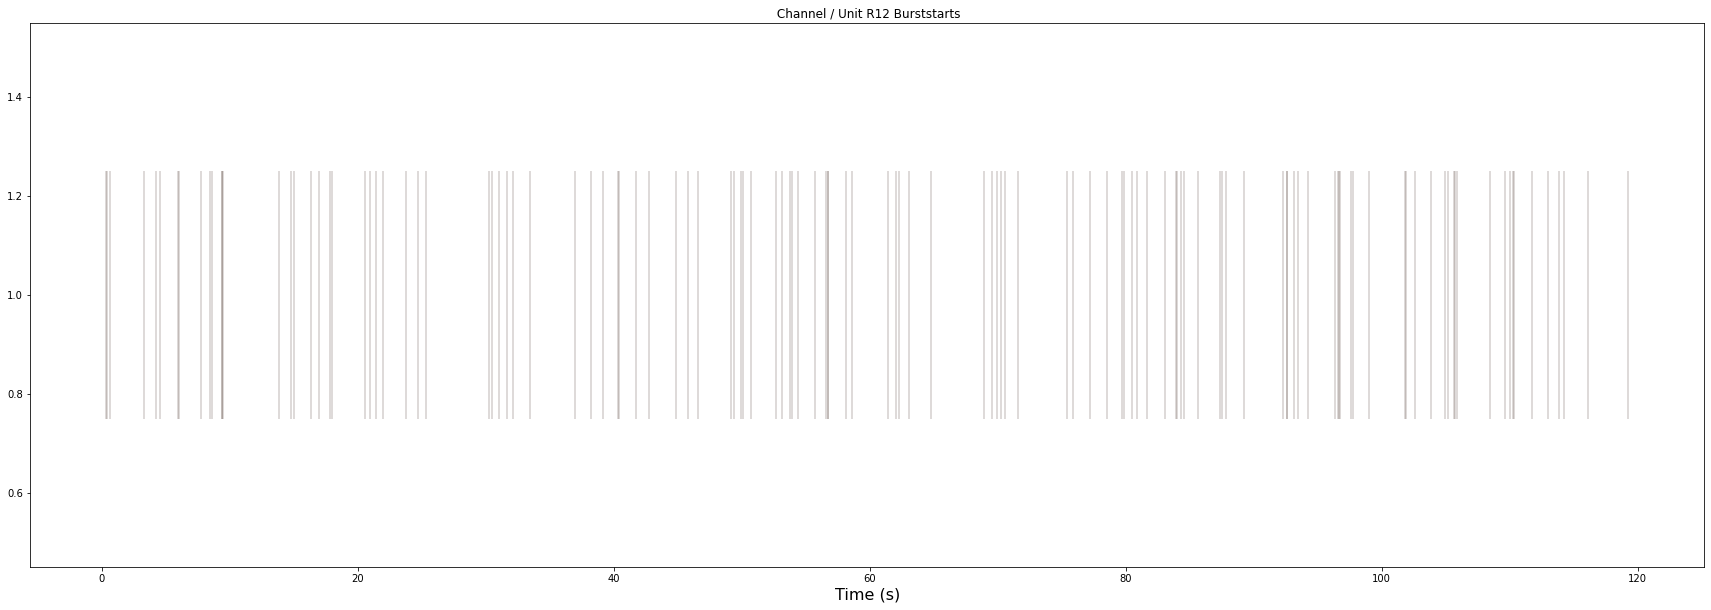

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R4 Burststarts')

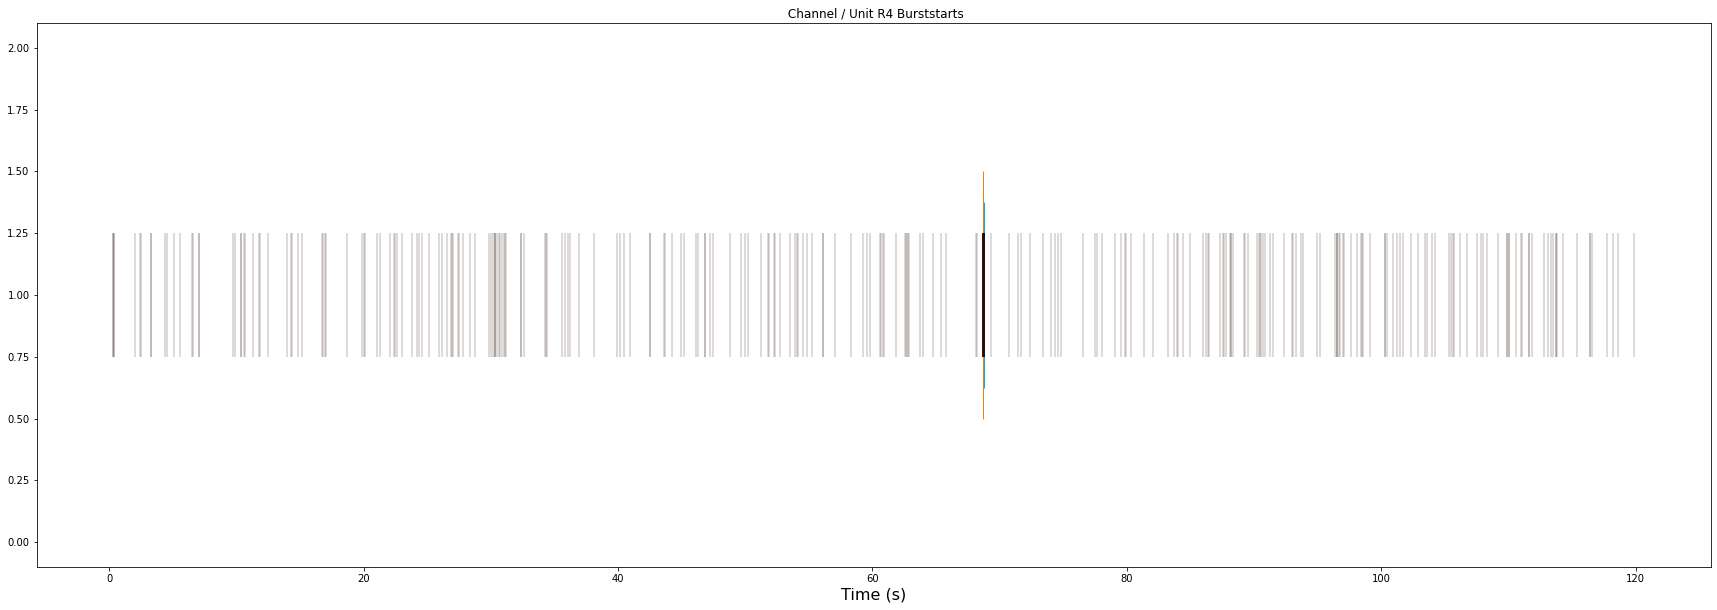

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F11 Burststarts')

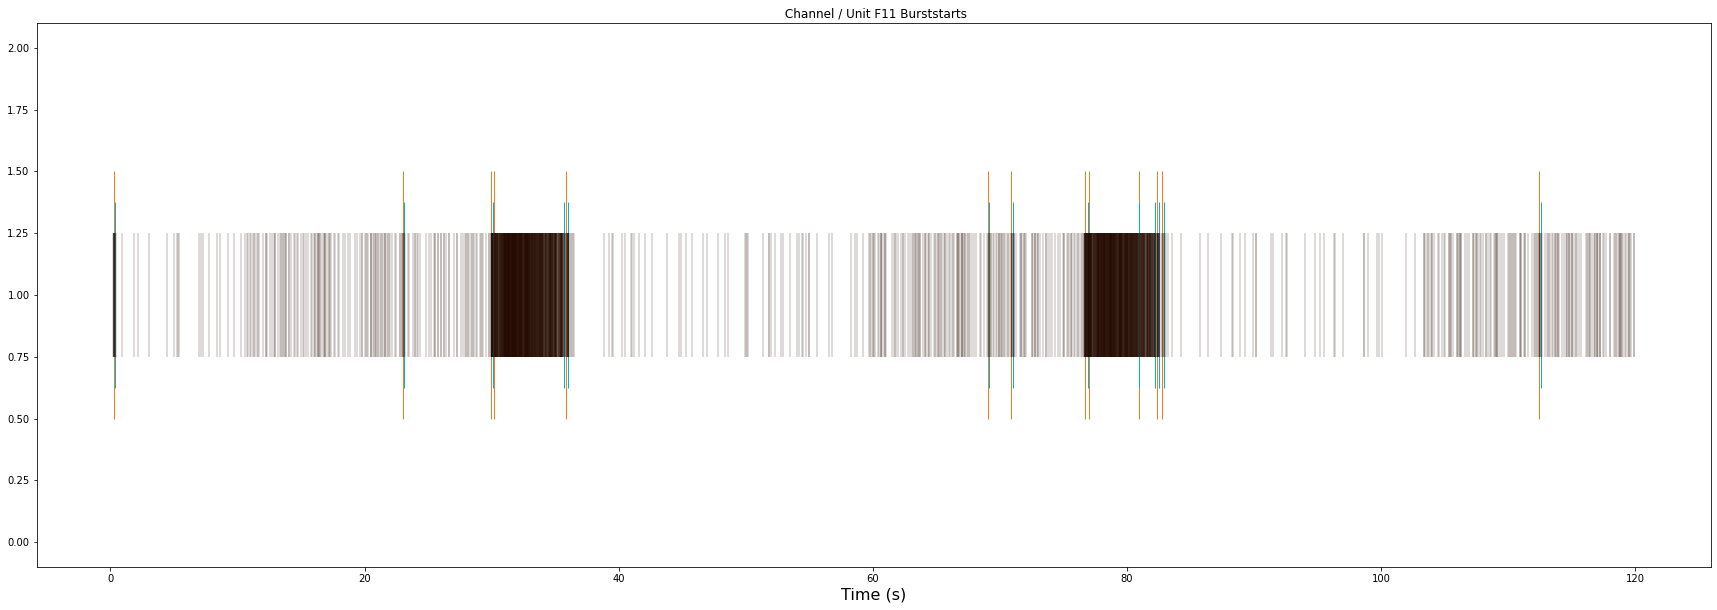

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D12 Burststarts')

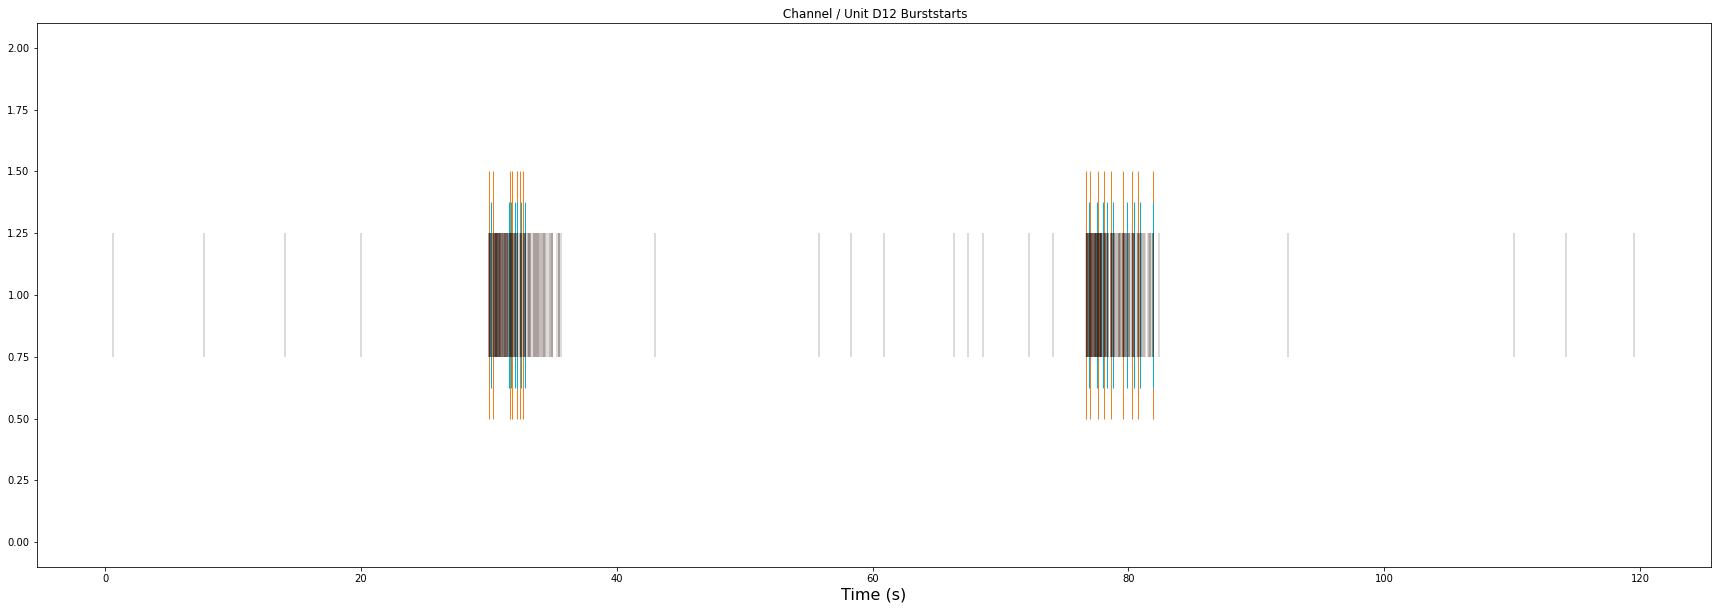

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D5 Burststarts')

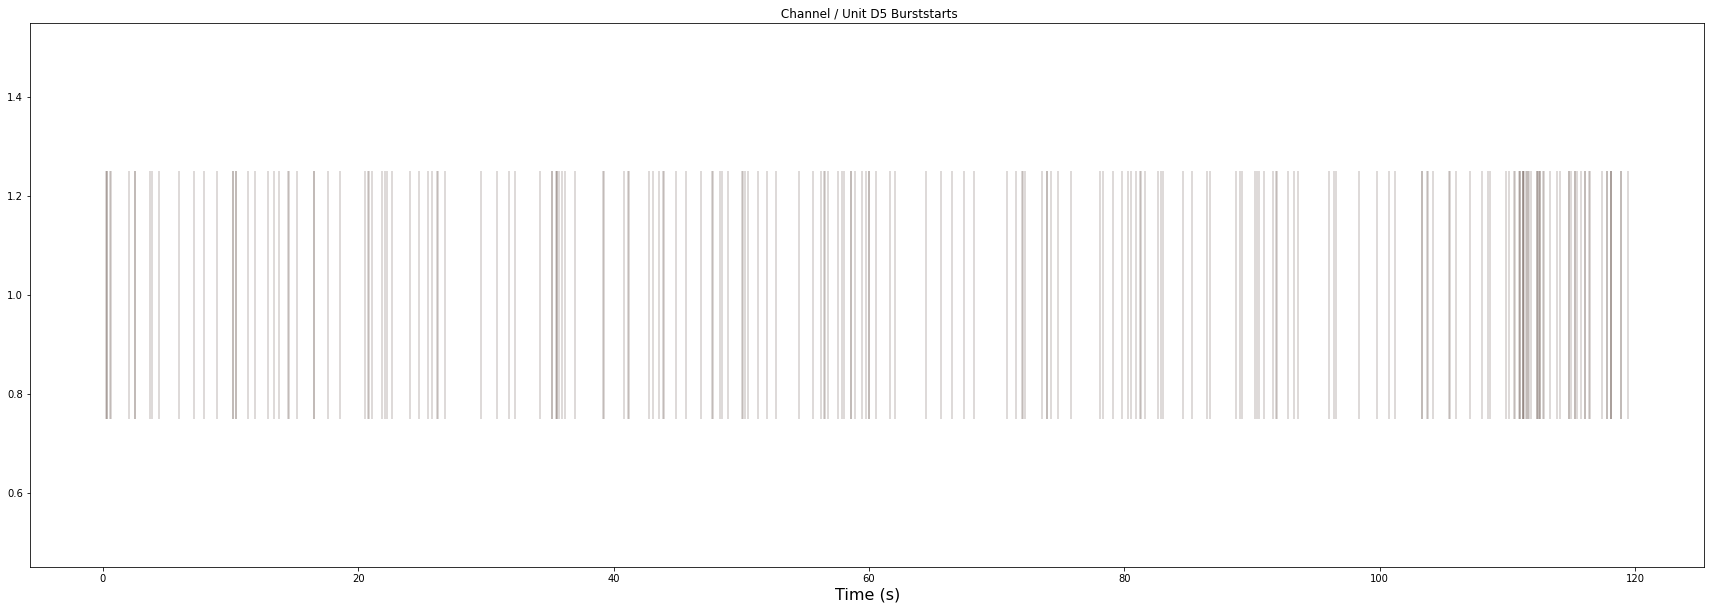

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C12 Burststarts')

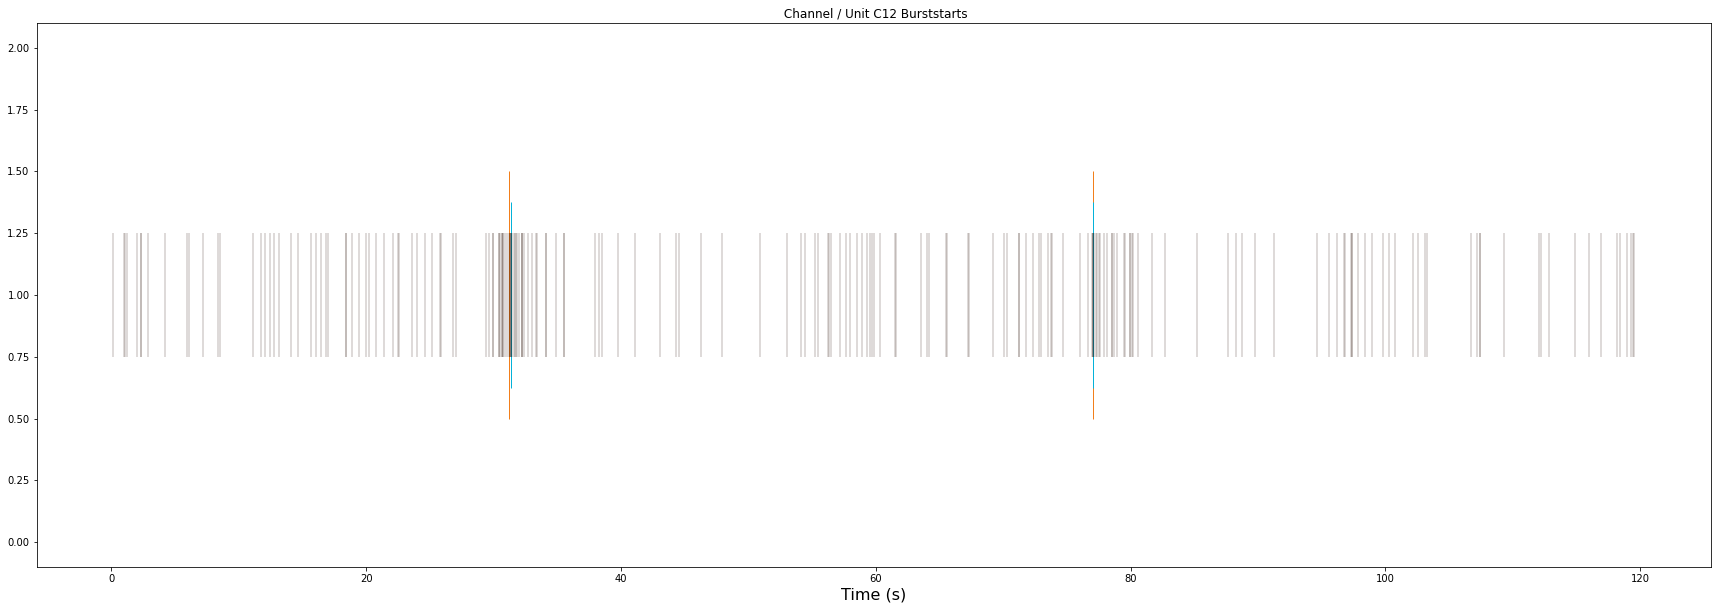

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K11 Burststarts')

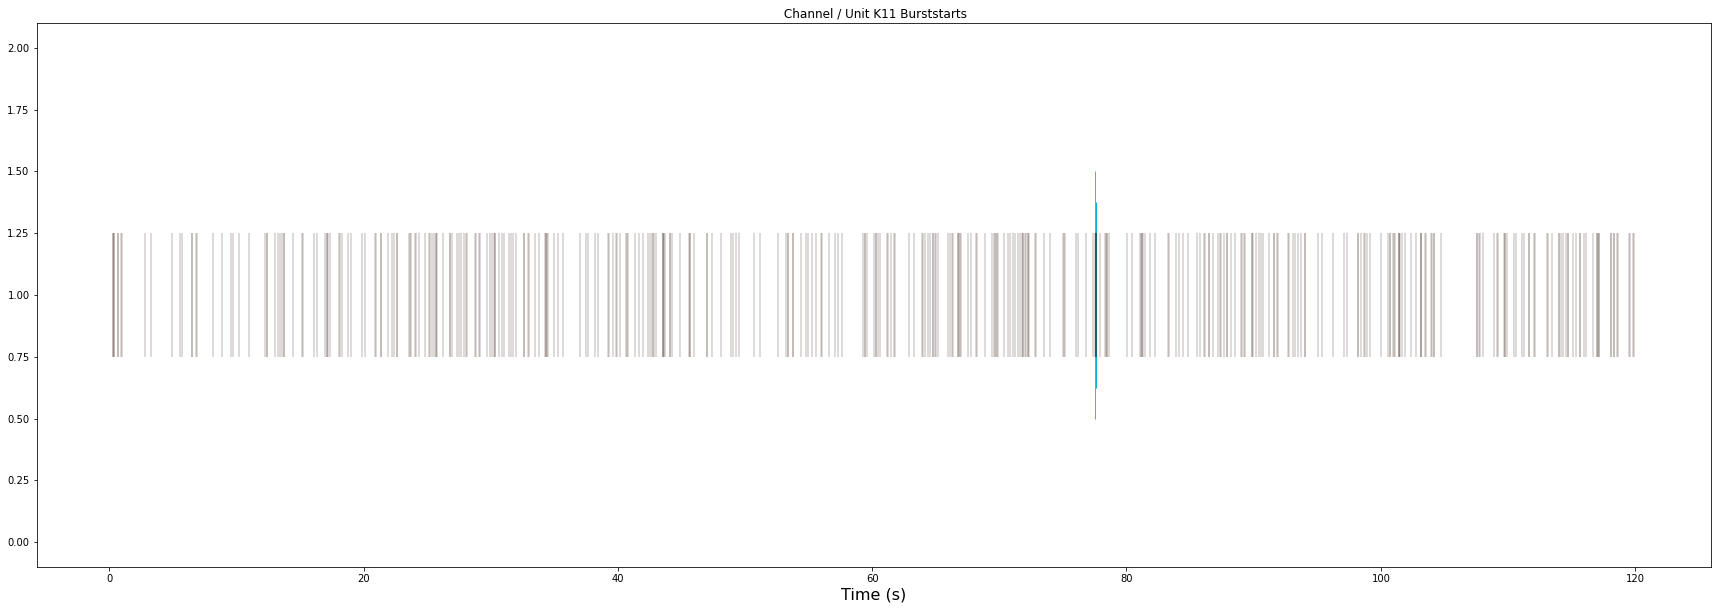

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N9 Burststarts')

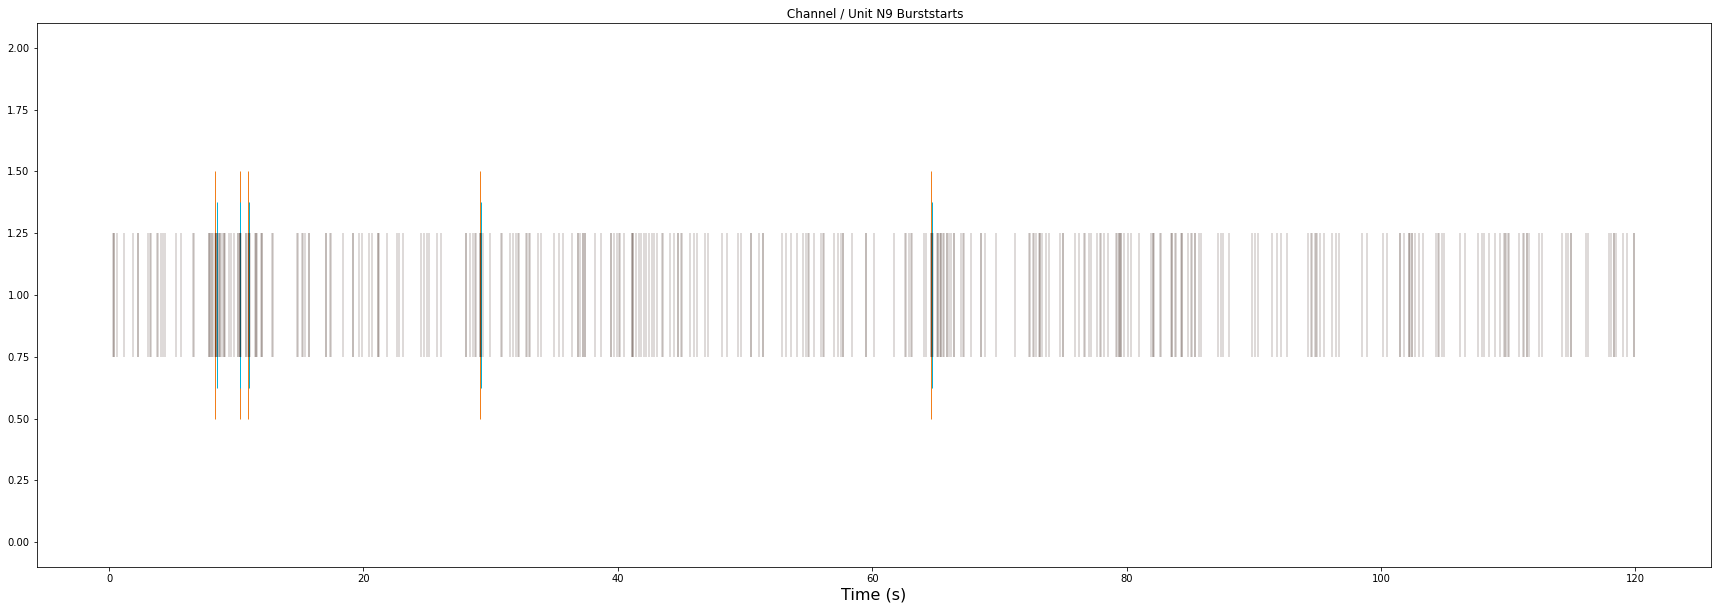

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R9 Burststarts')

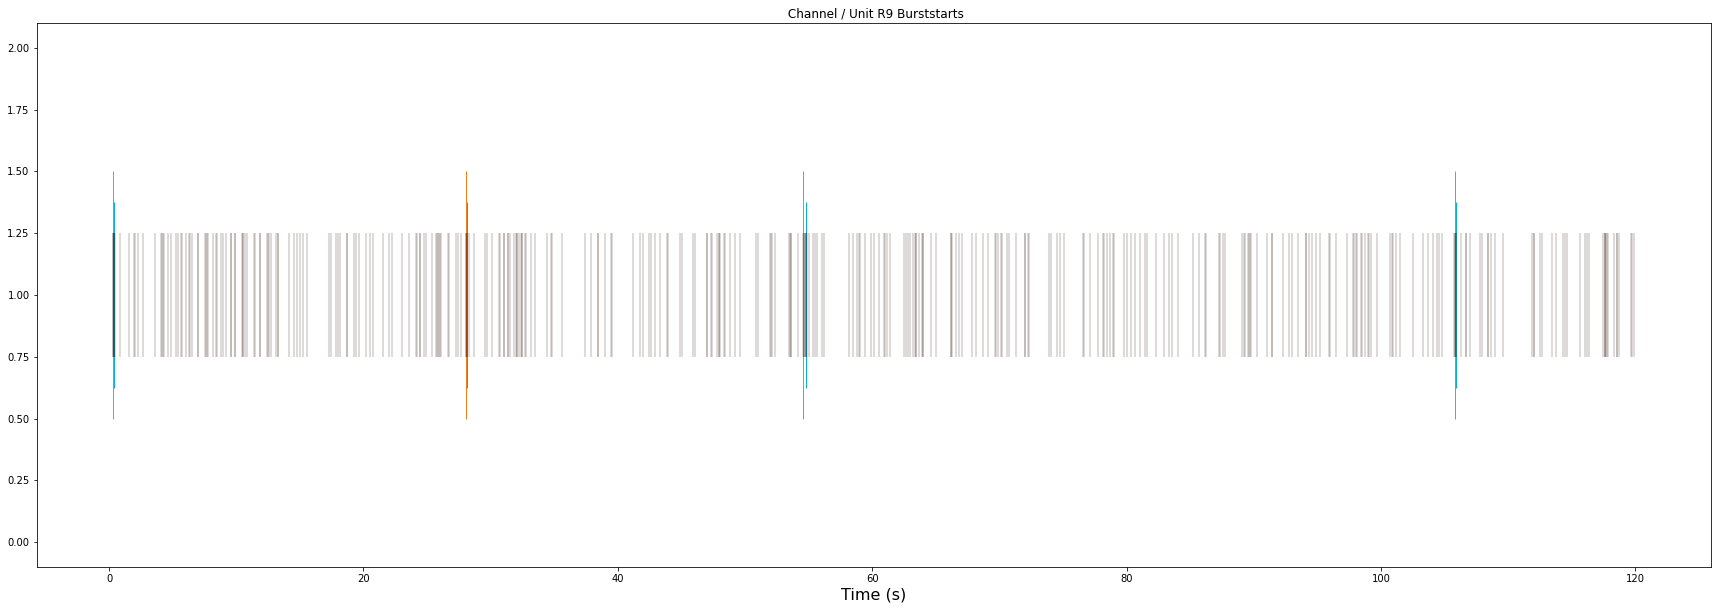

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F2 Burststarts')

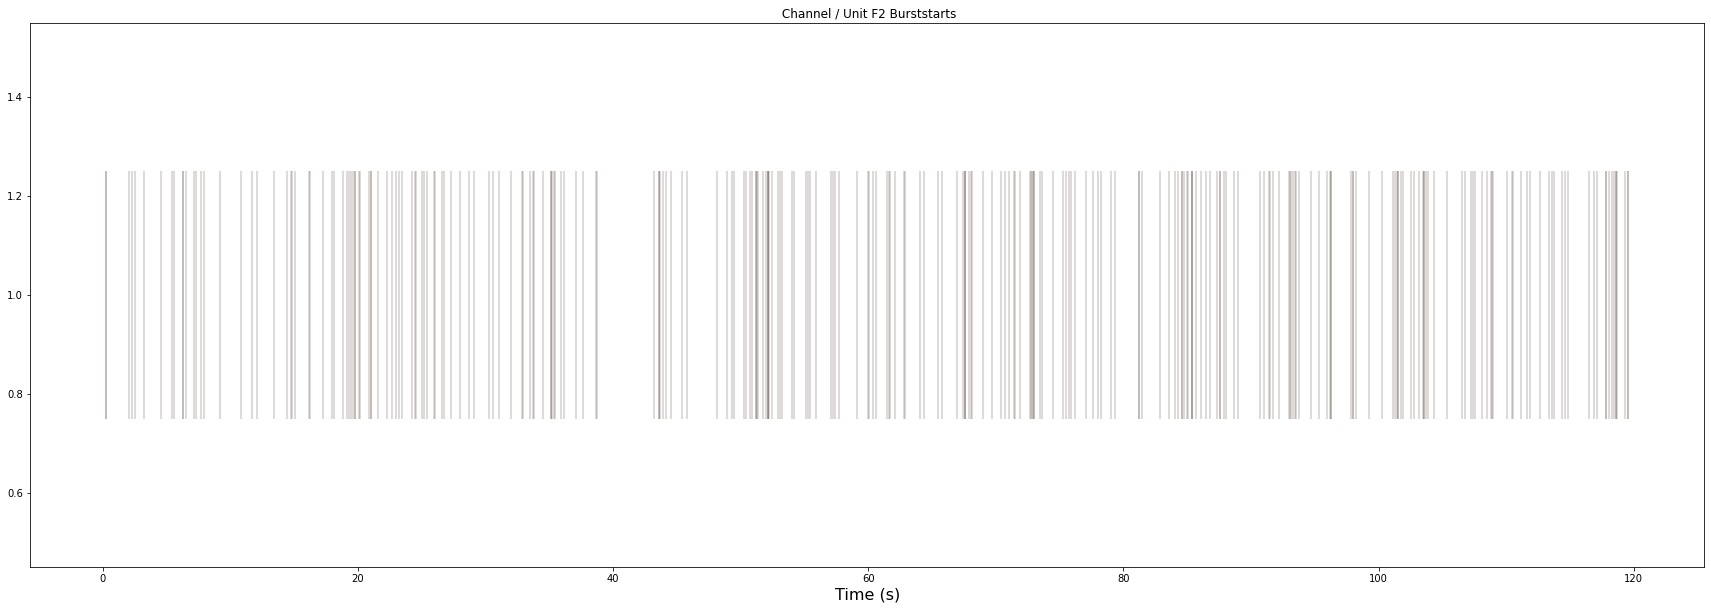

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P15 Burststarts')

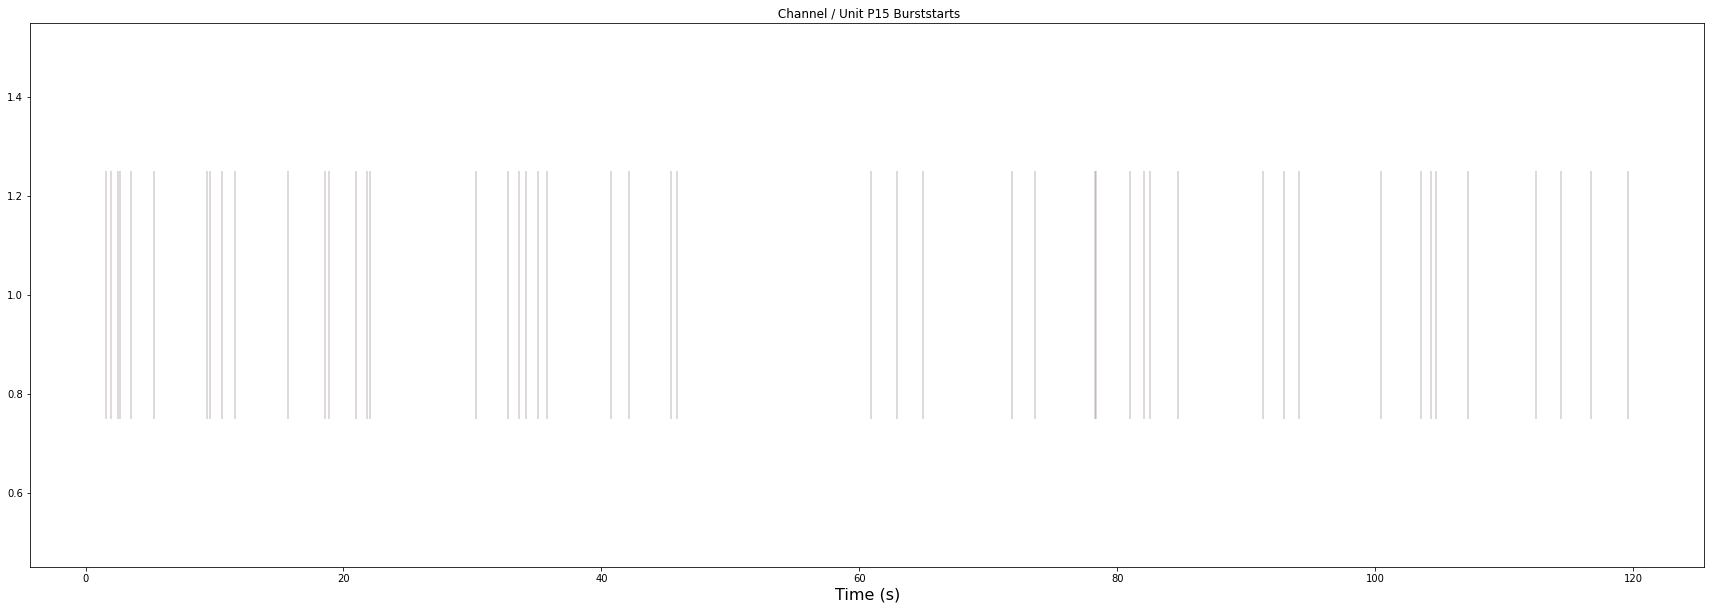

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A9 Burststarts')

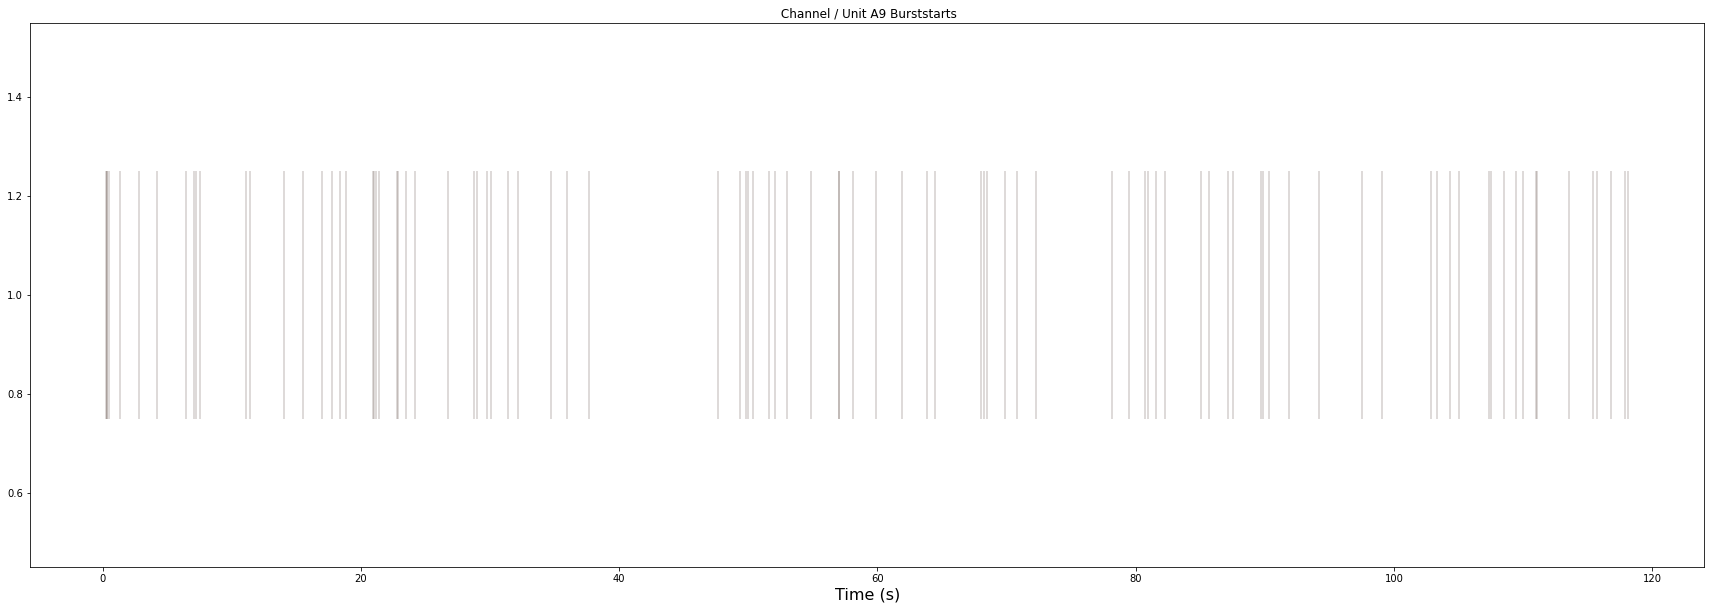

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D9 Burststarts')

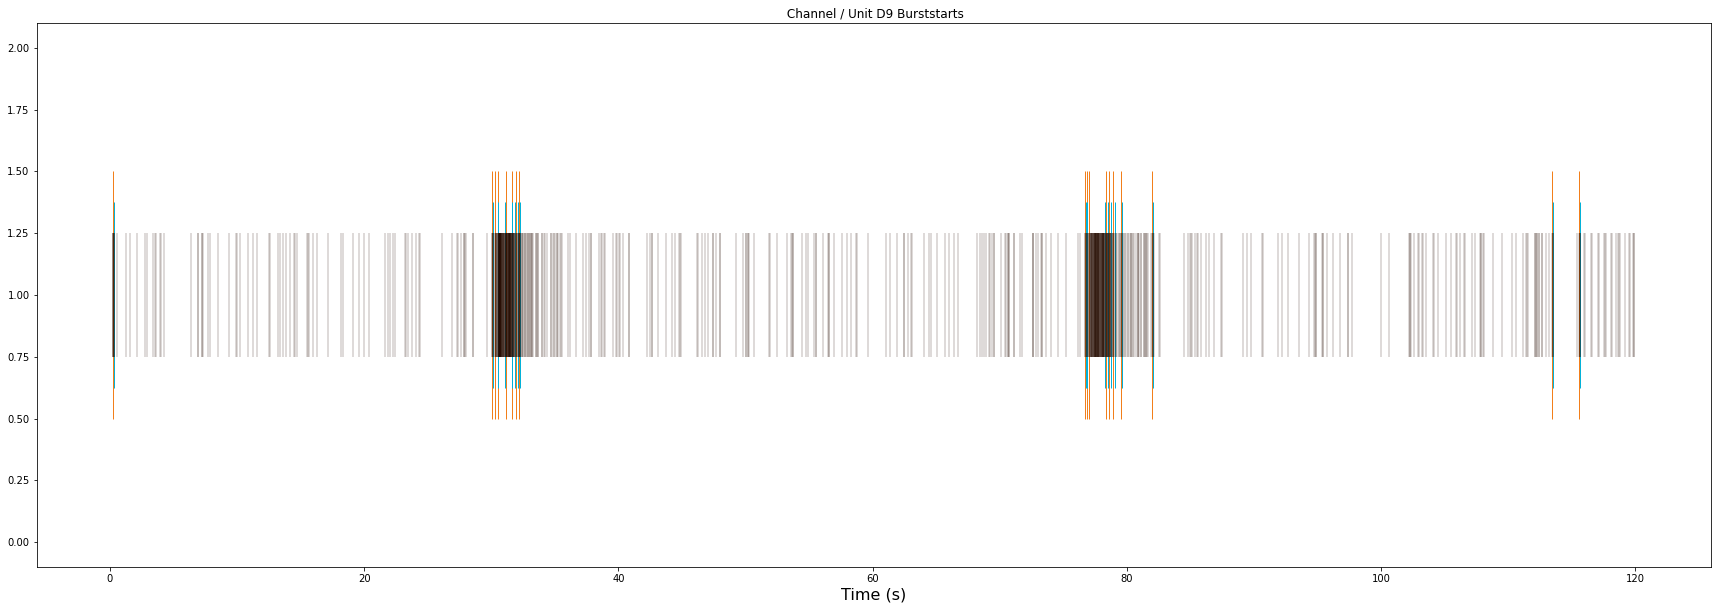

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F16 Burststarts')

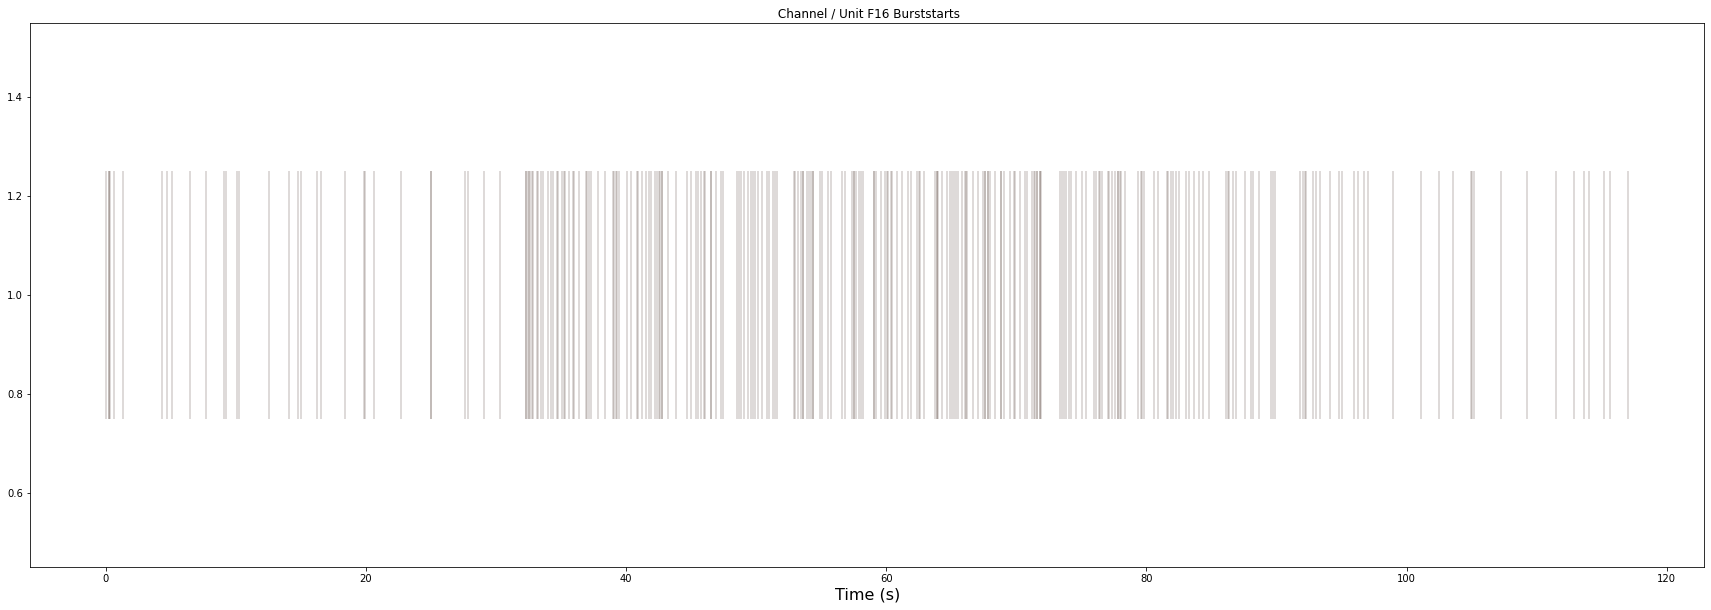

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E15 Burststarts')

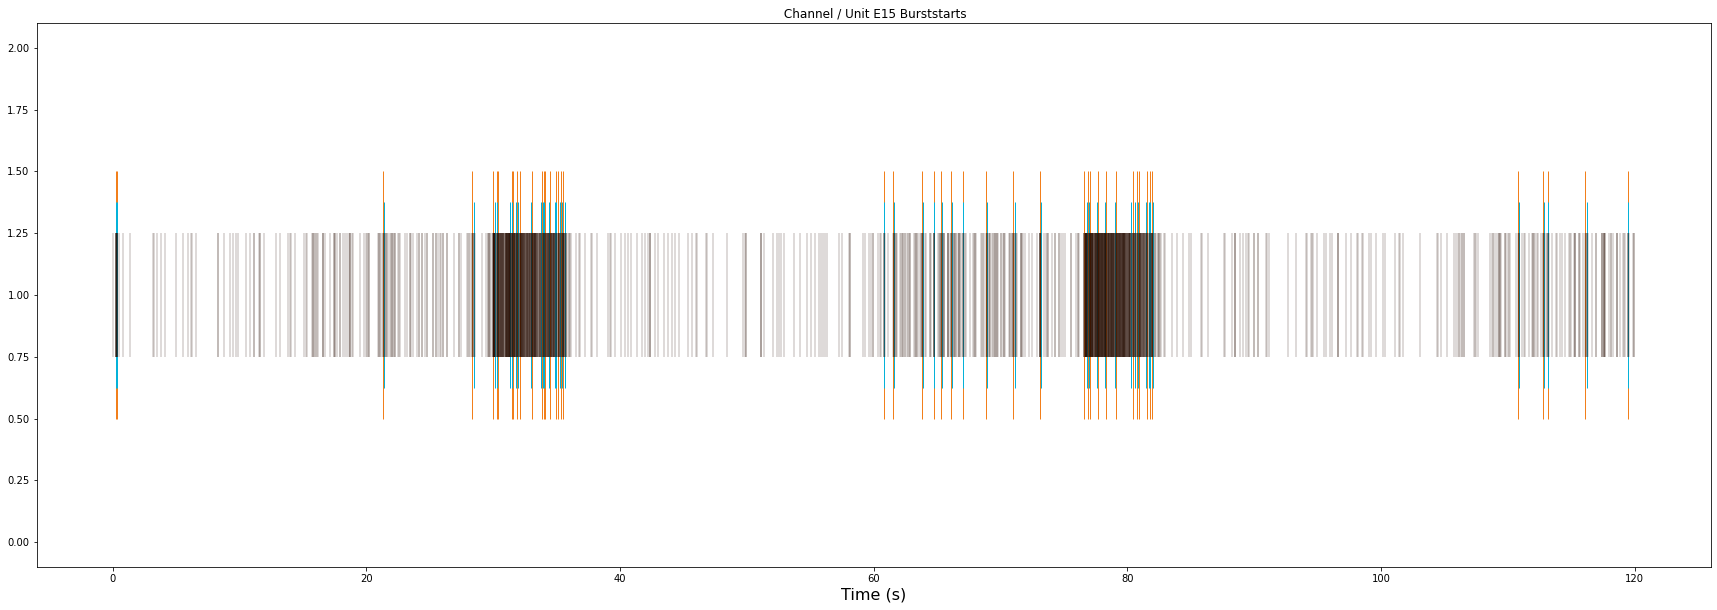

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B4 Burststarts')

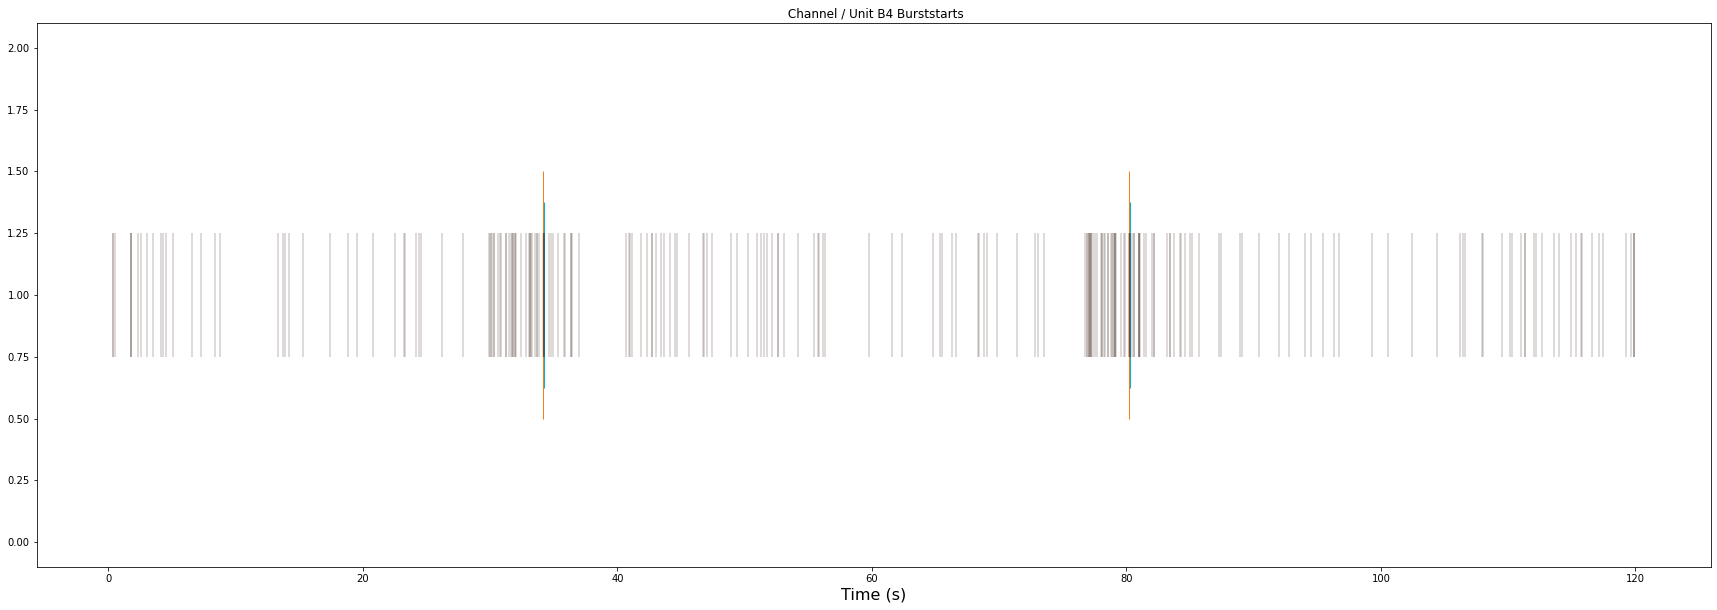

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E11 Burststarts')

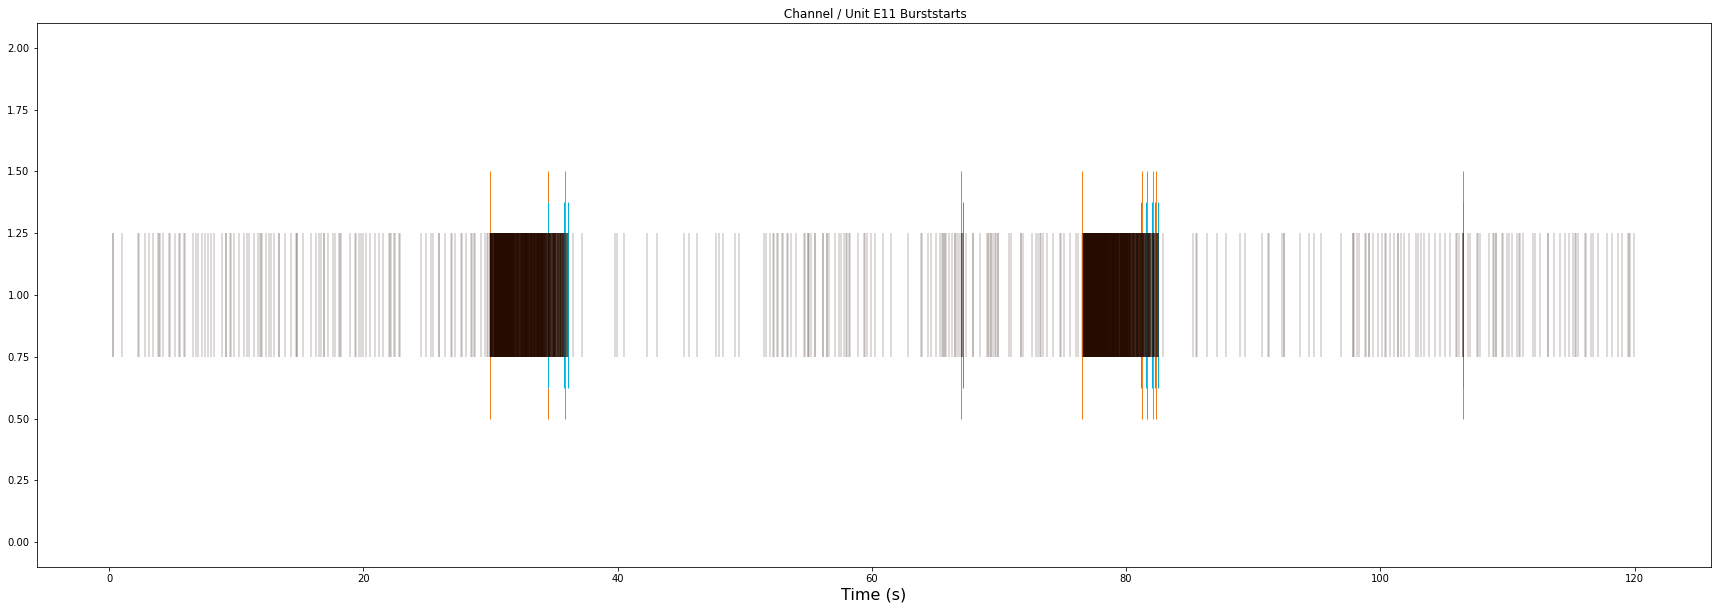

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D11 Burststarts')

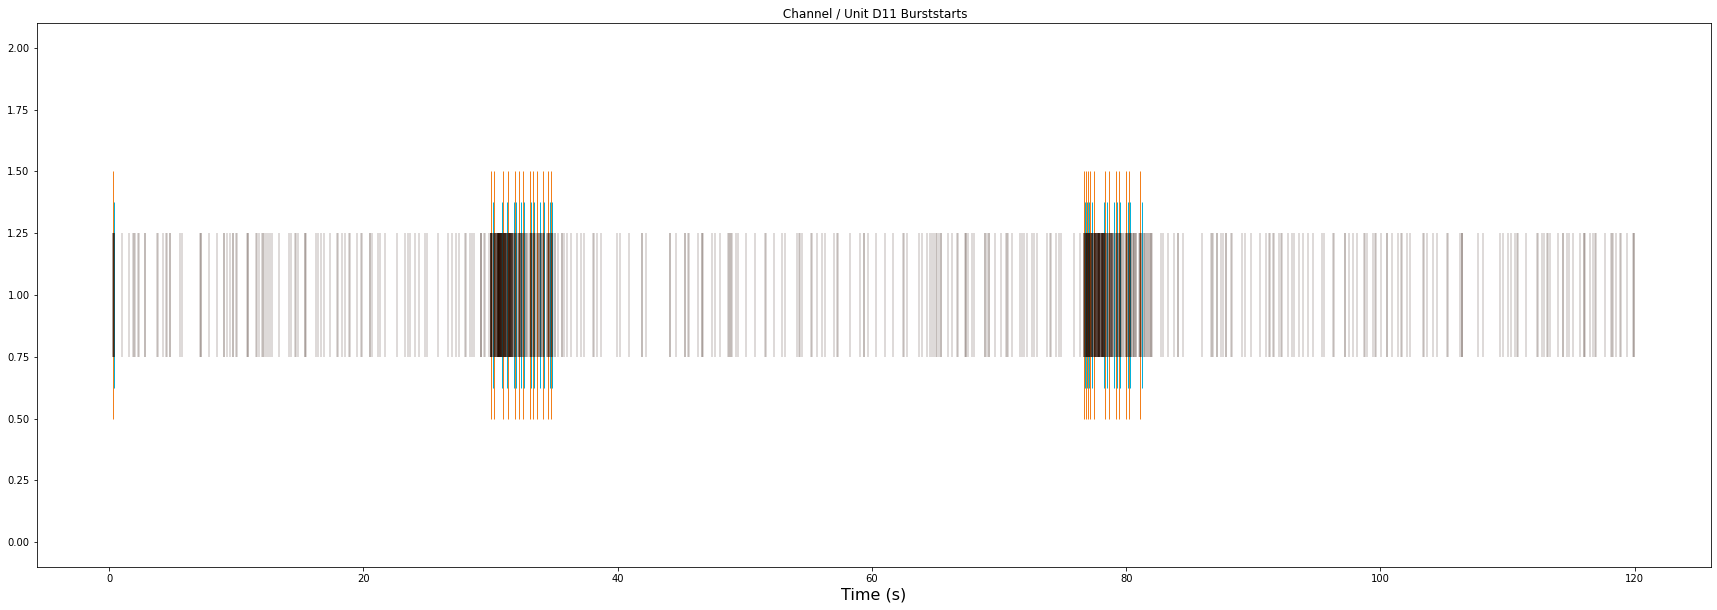

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N13 Burststarts')

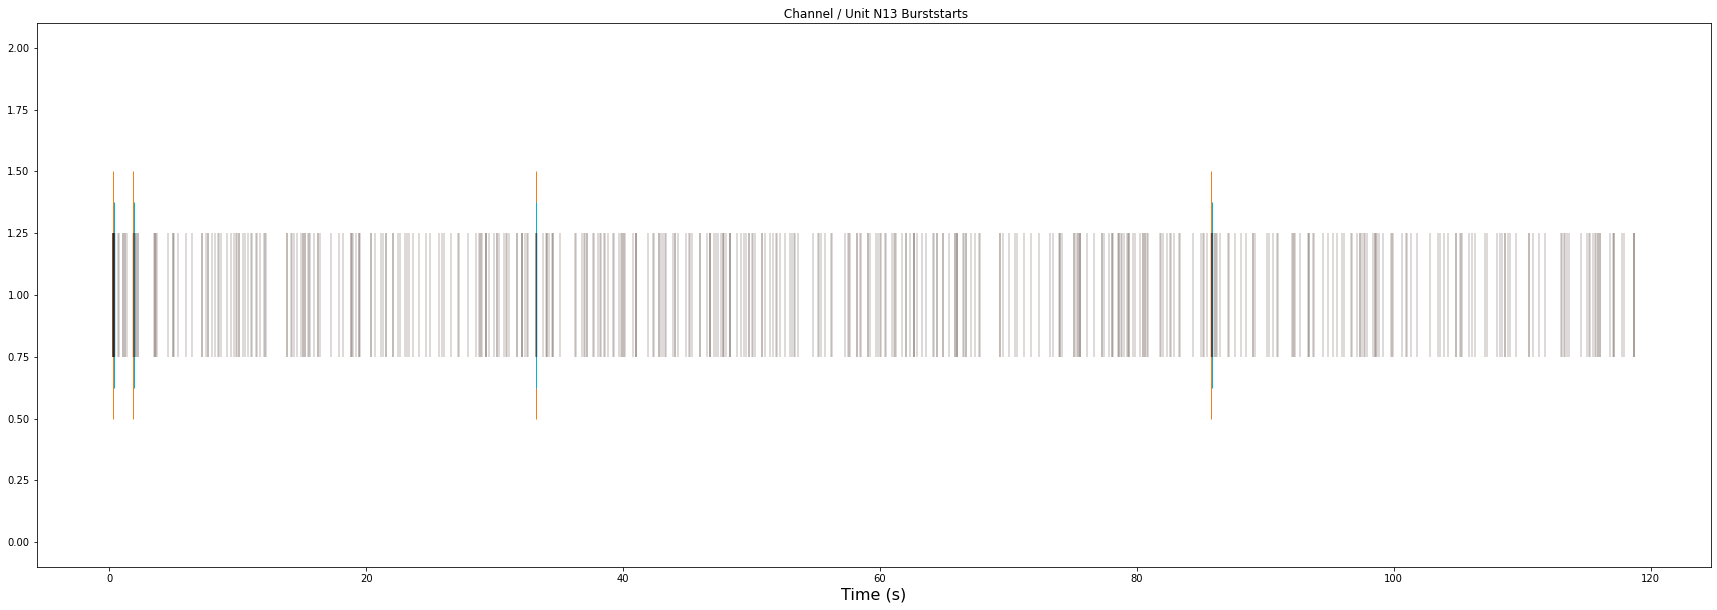

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O7 Burststarts')

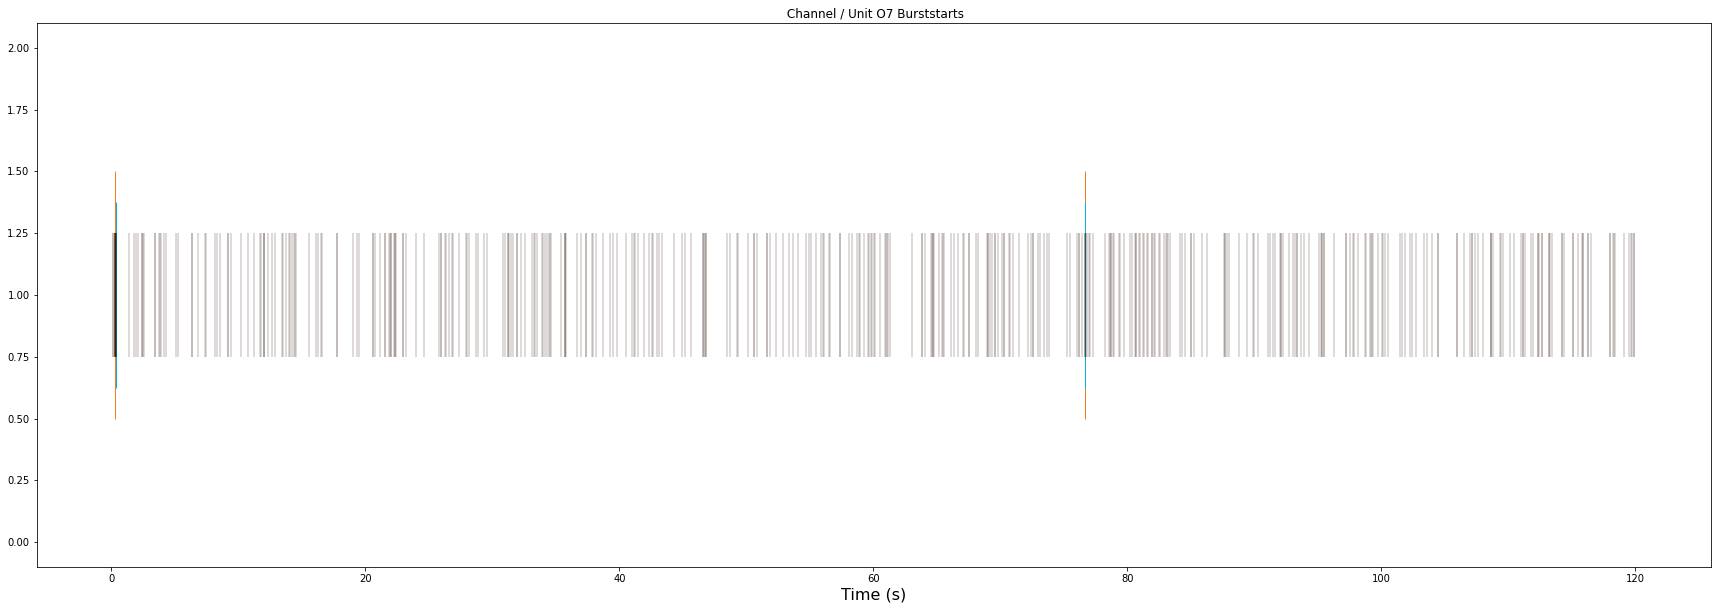

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N12 Burststarts')

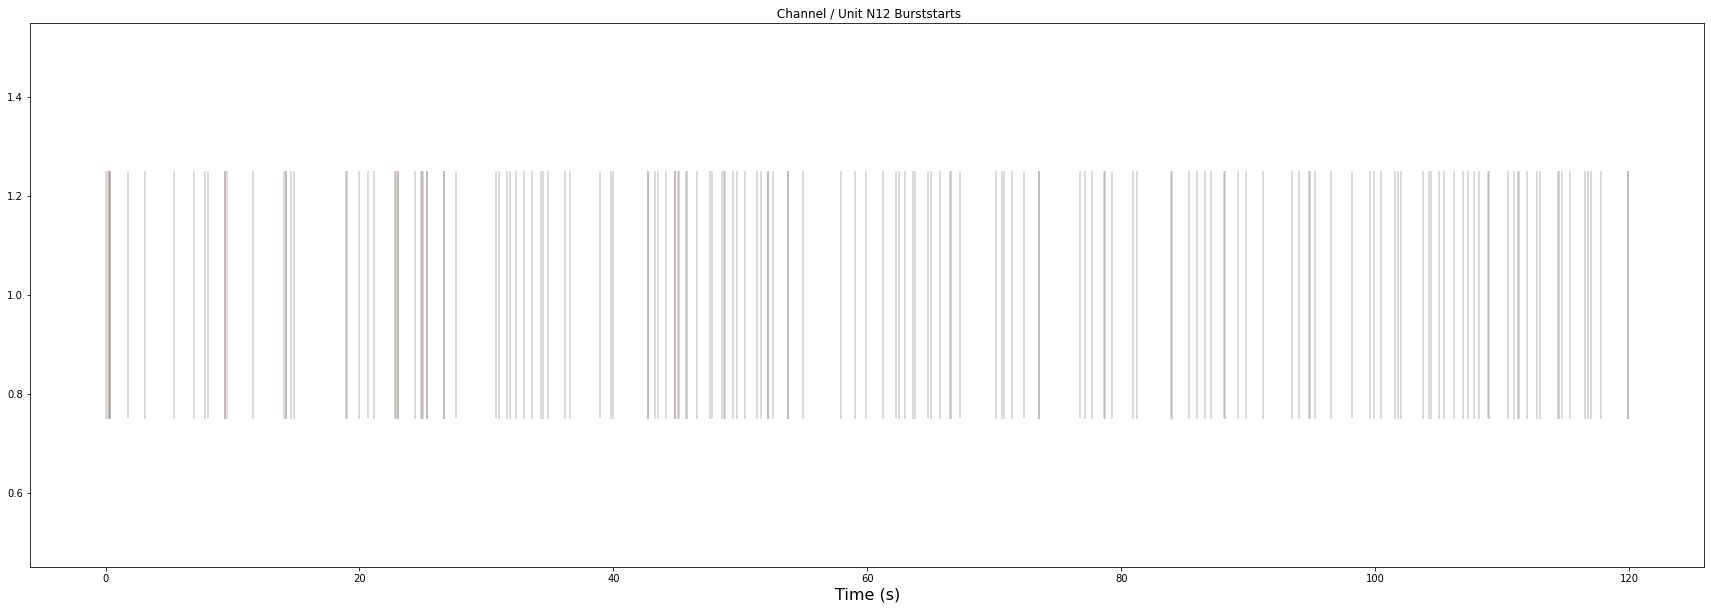

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O5 Burststarts')

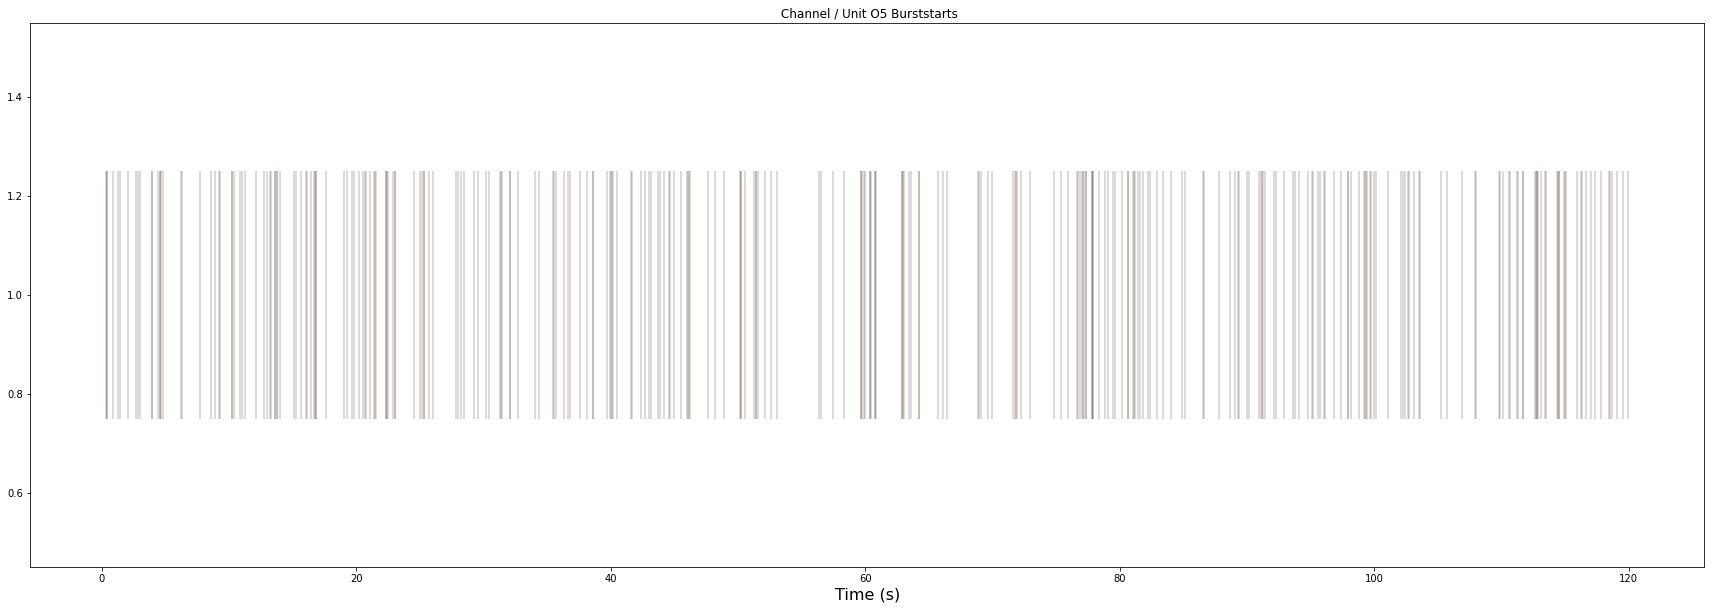

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I3 Burststarts')

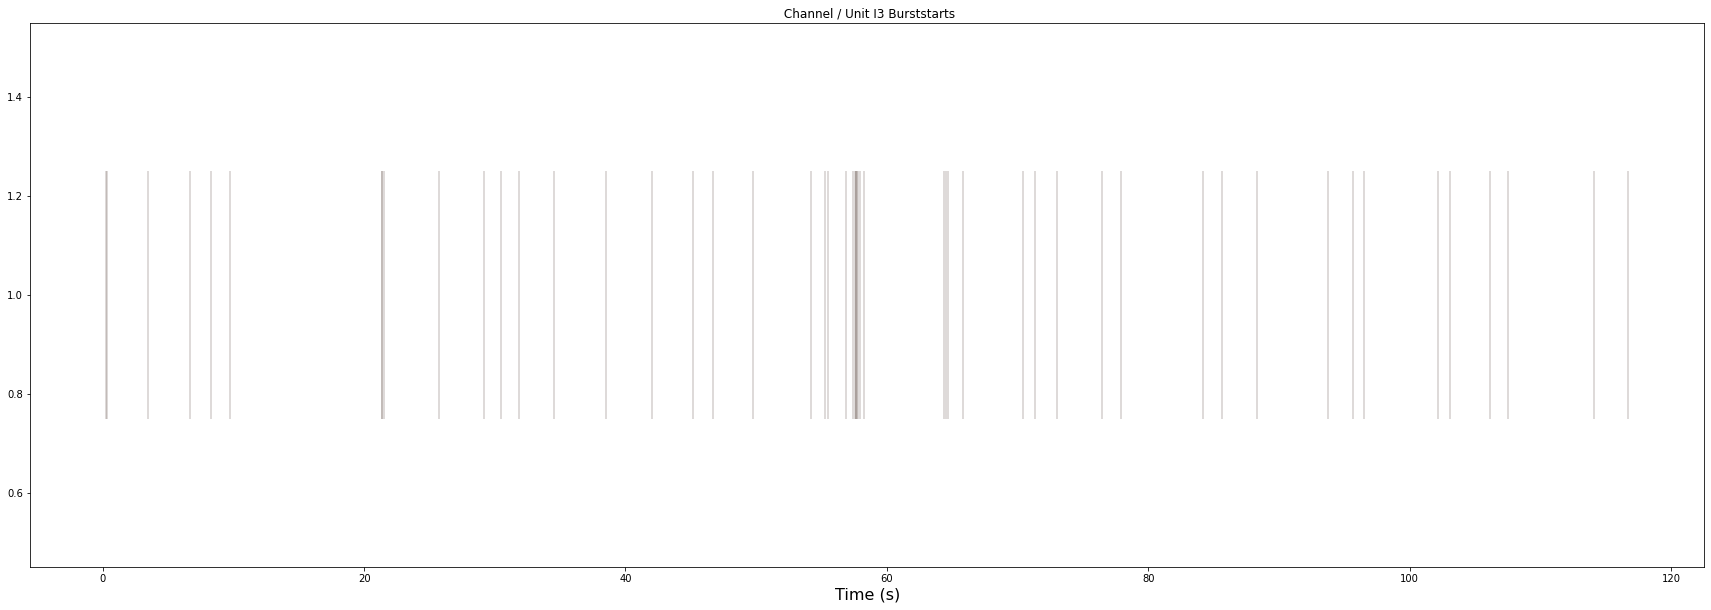

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H8 Burststarts')

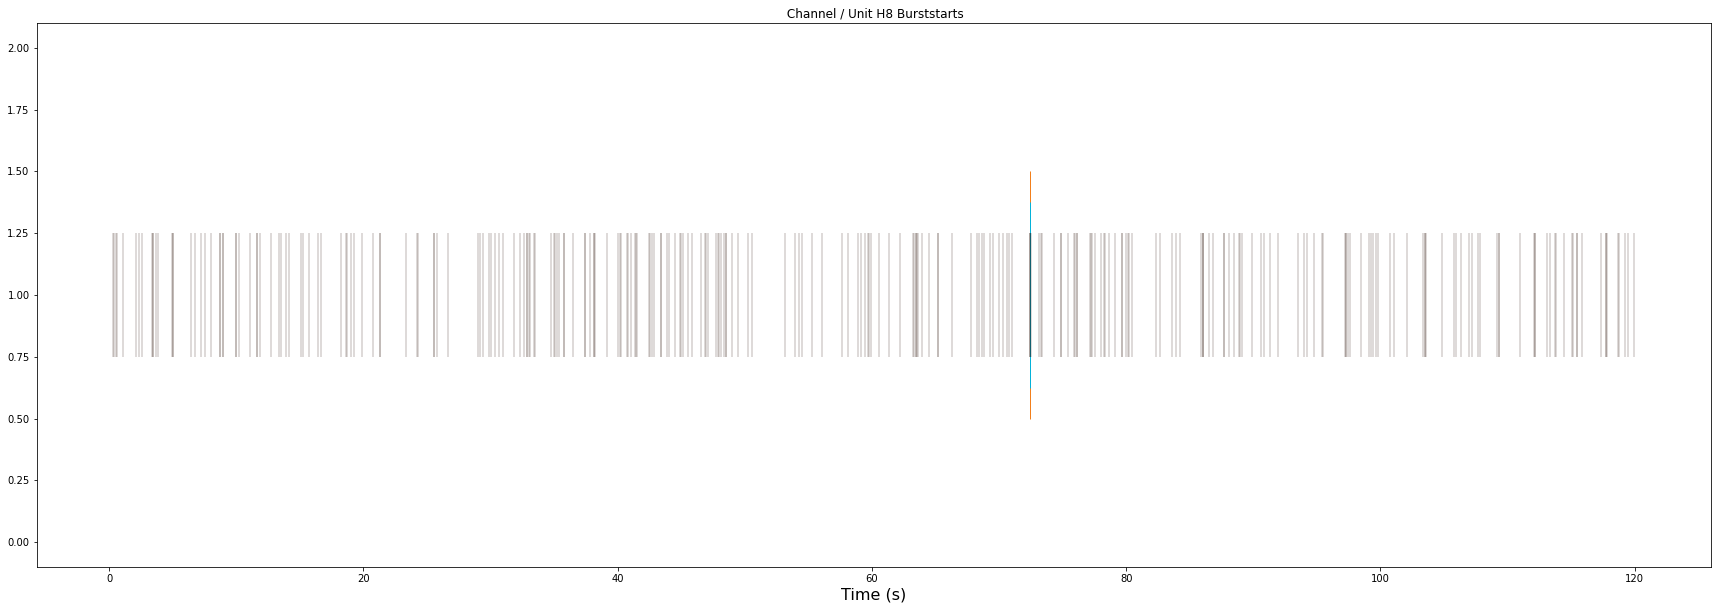

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C11 Burststarts')

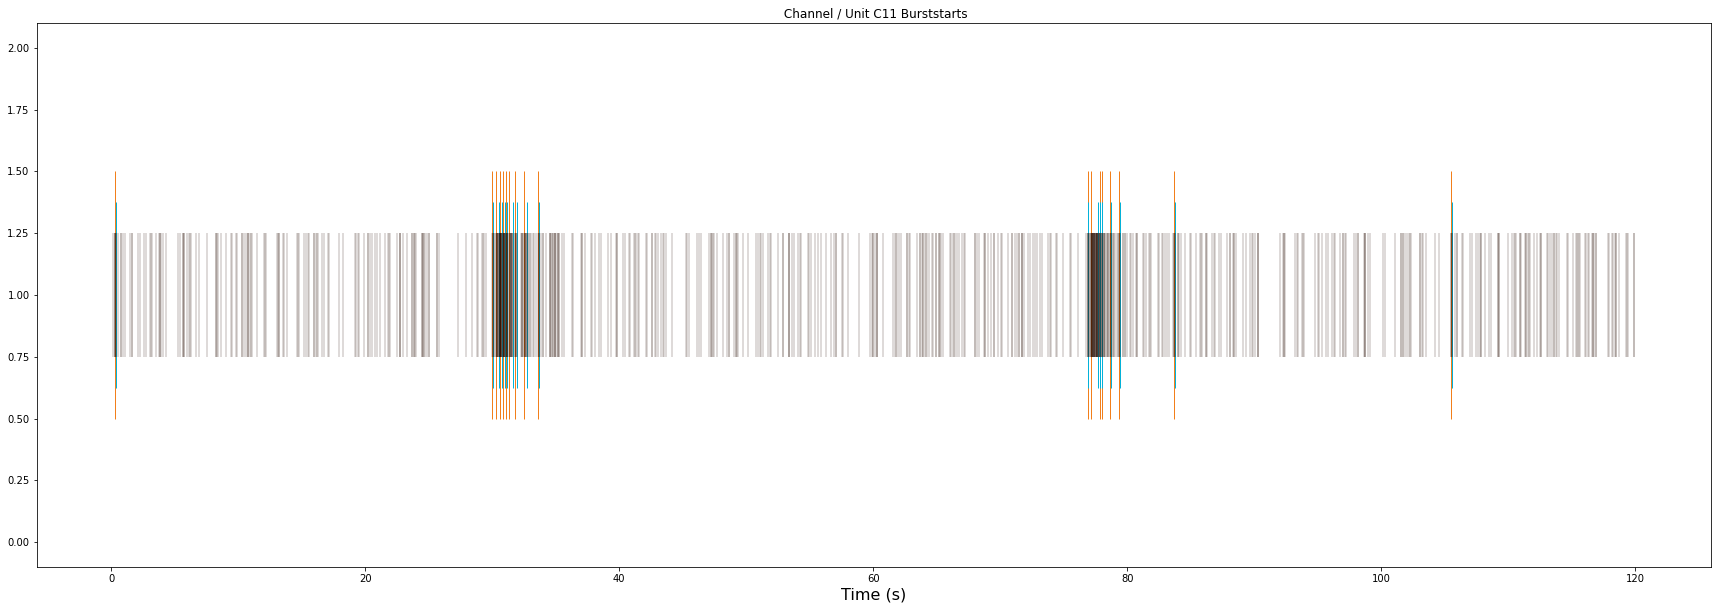

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I13 Burststarts')

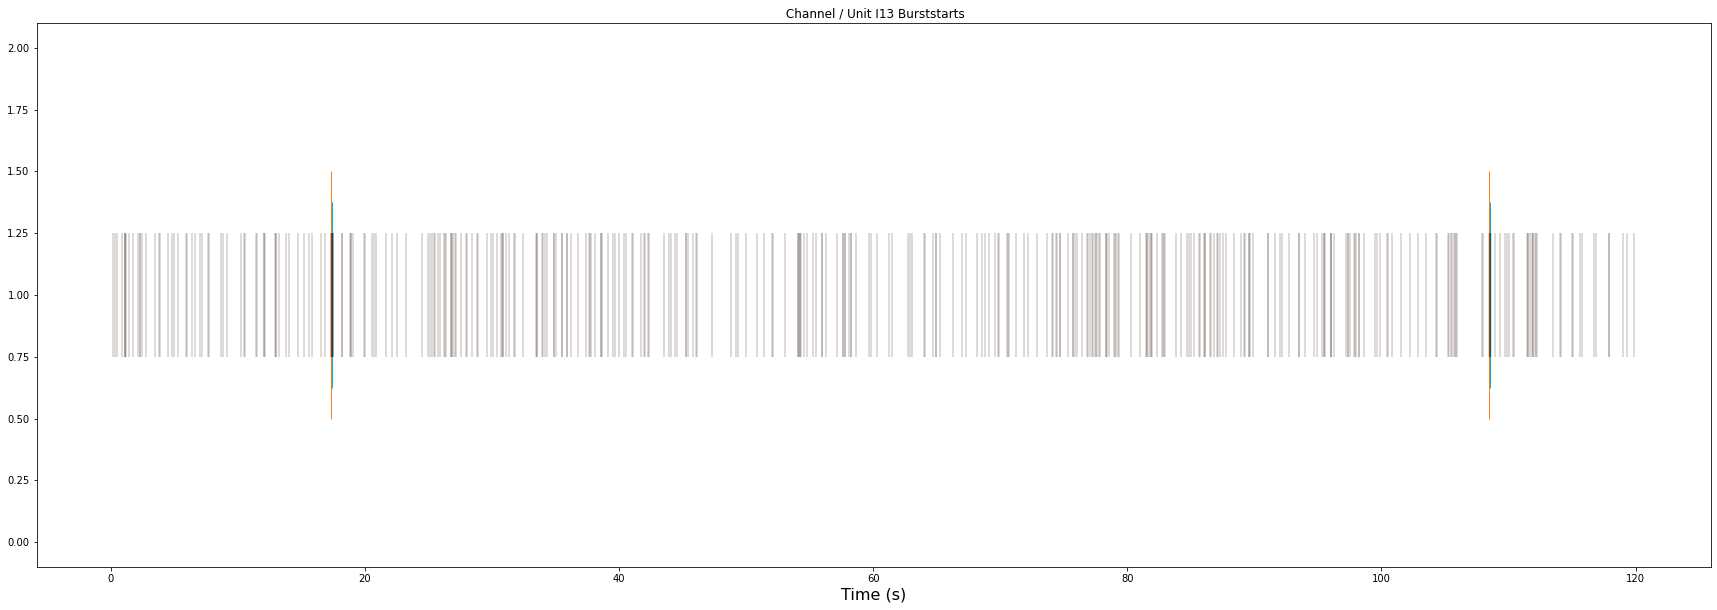

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C2 Burststarts')

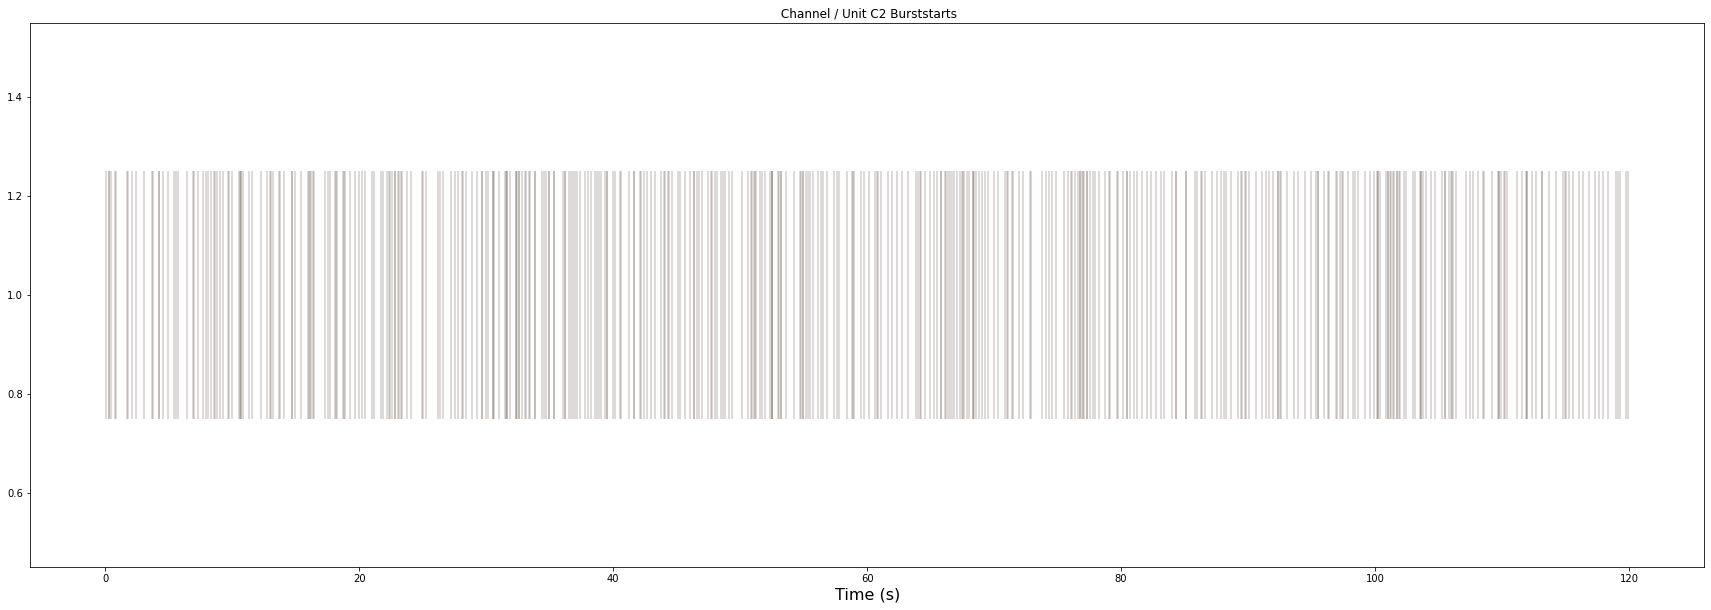

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E7 Burststarts')

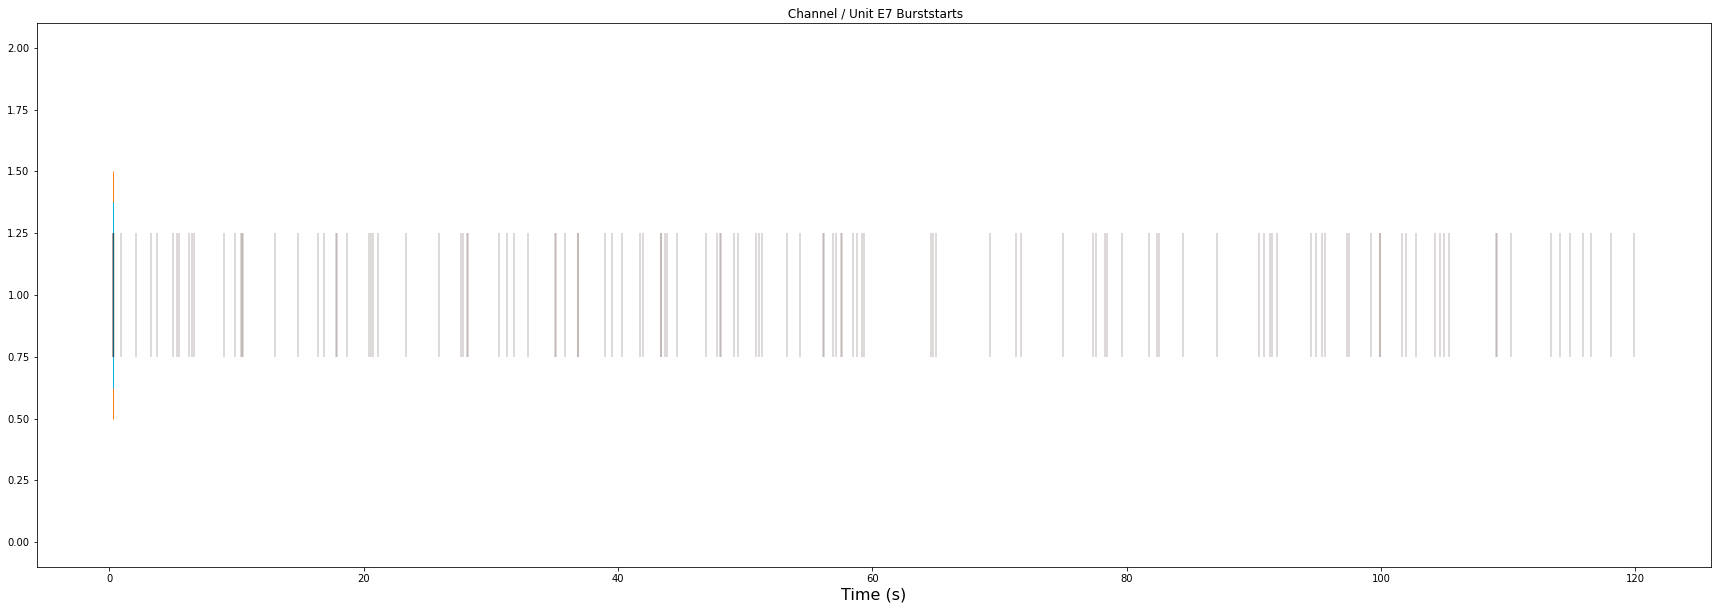

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C16 Burststarts')

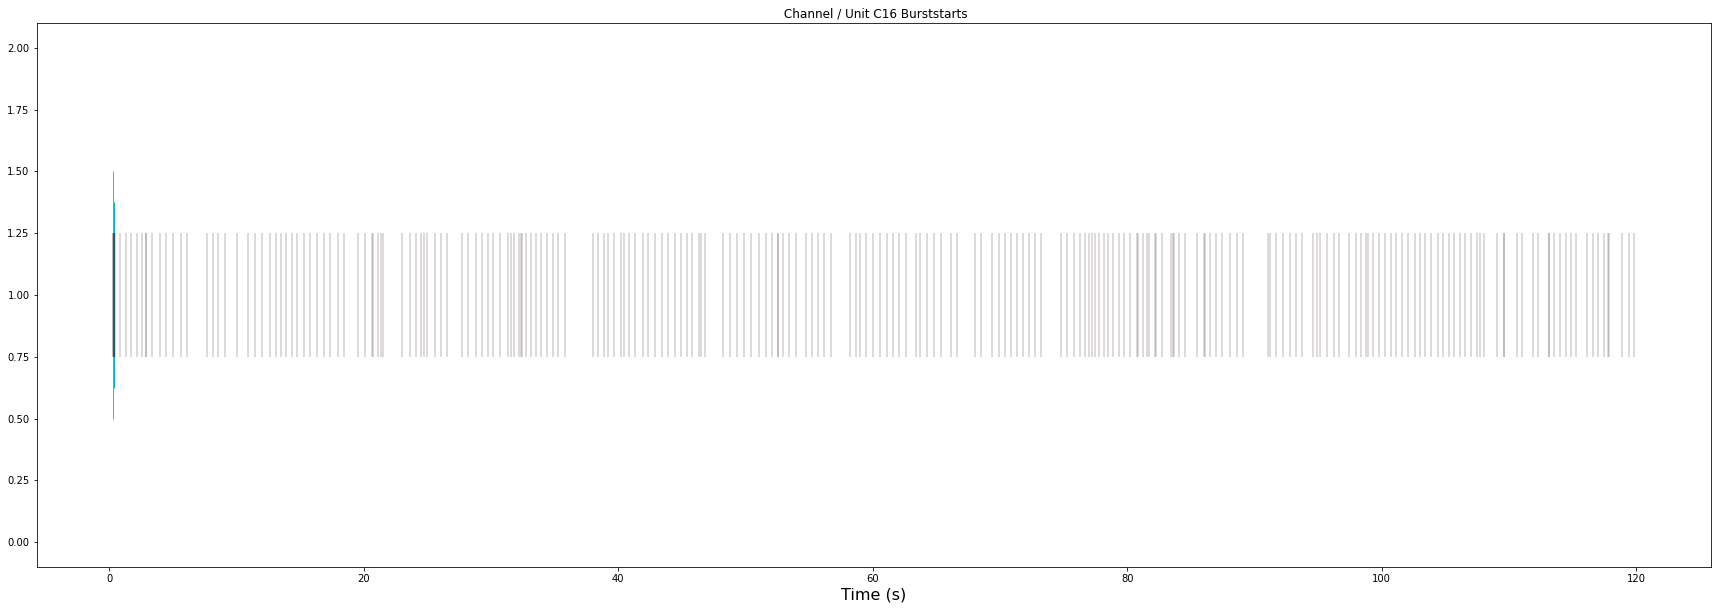

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A6 Burststarts')

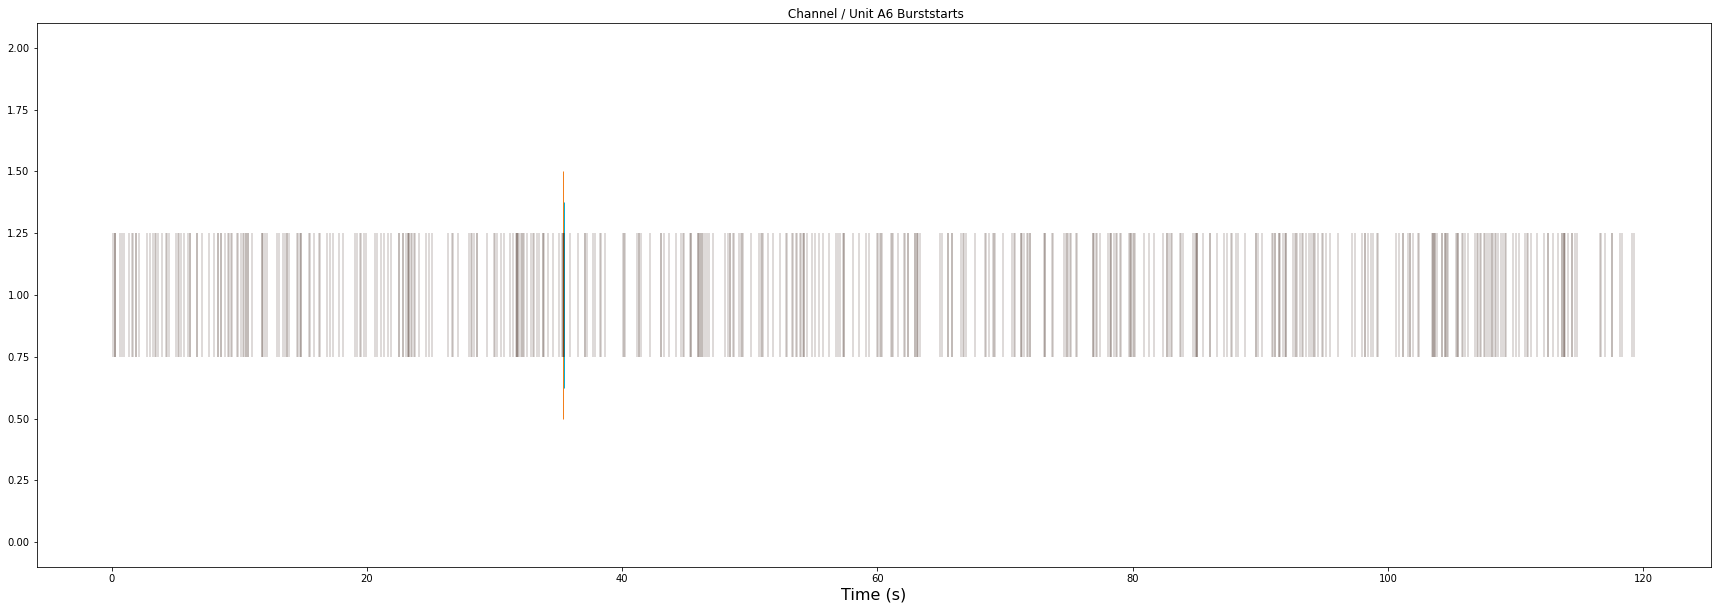

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C15 Burststarts')

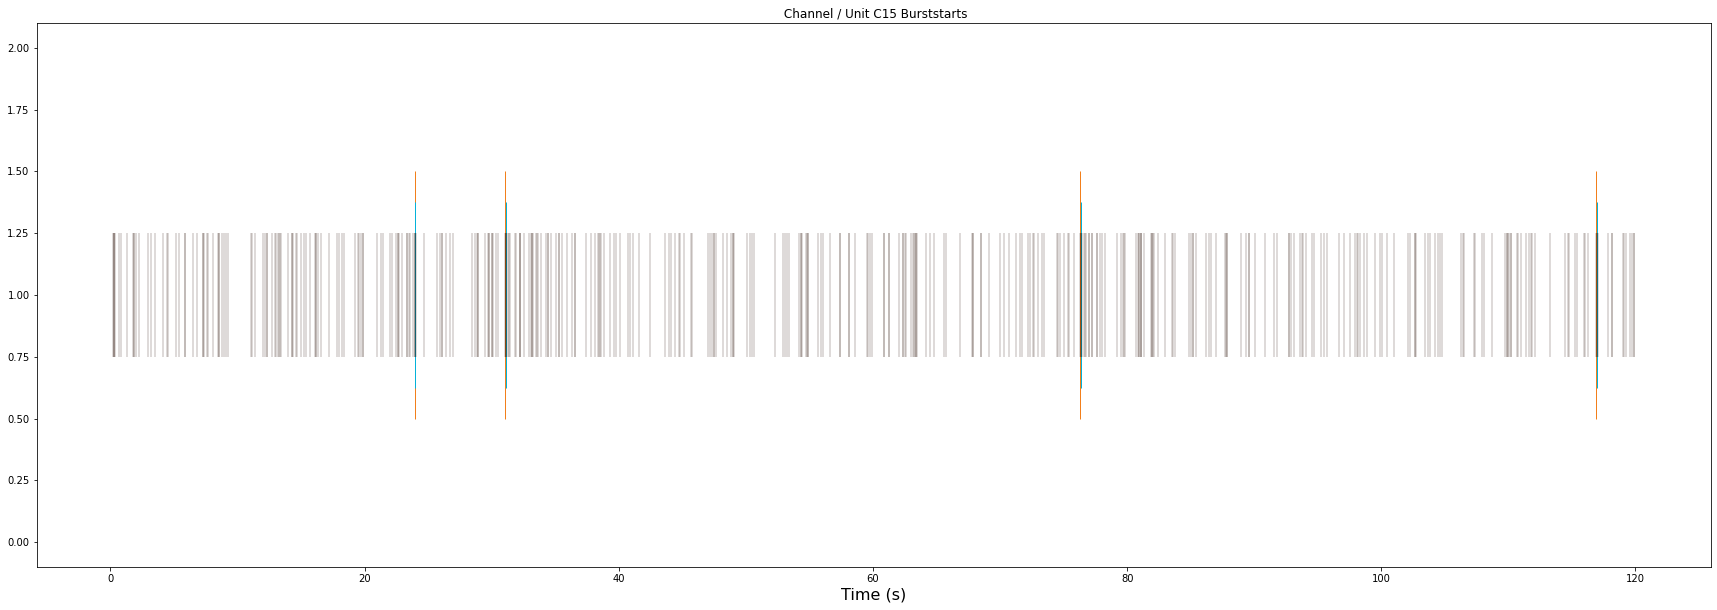

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R8 Burststarts')

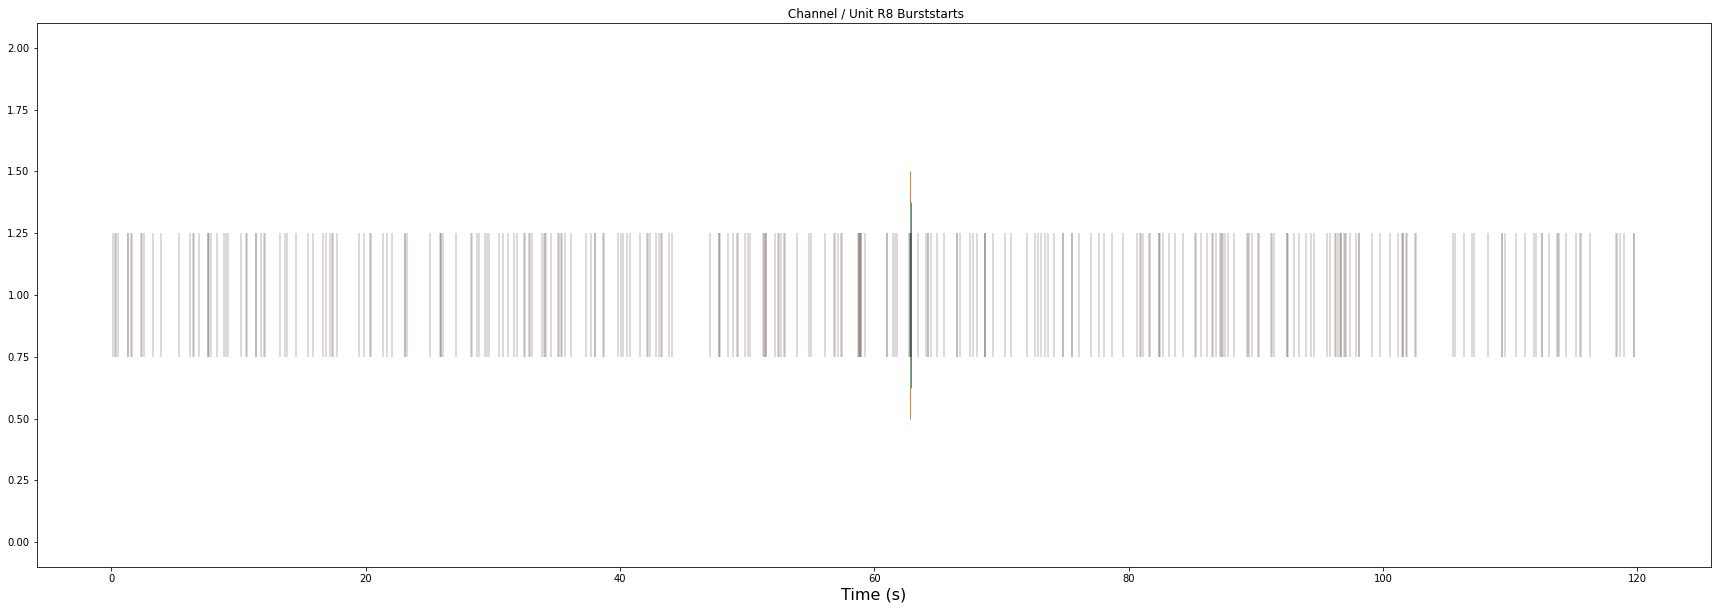

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M1 Burststarts')

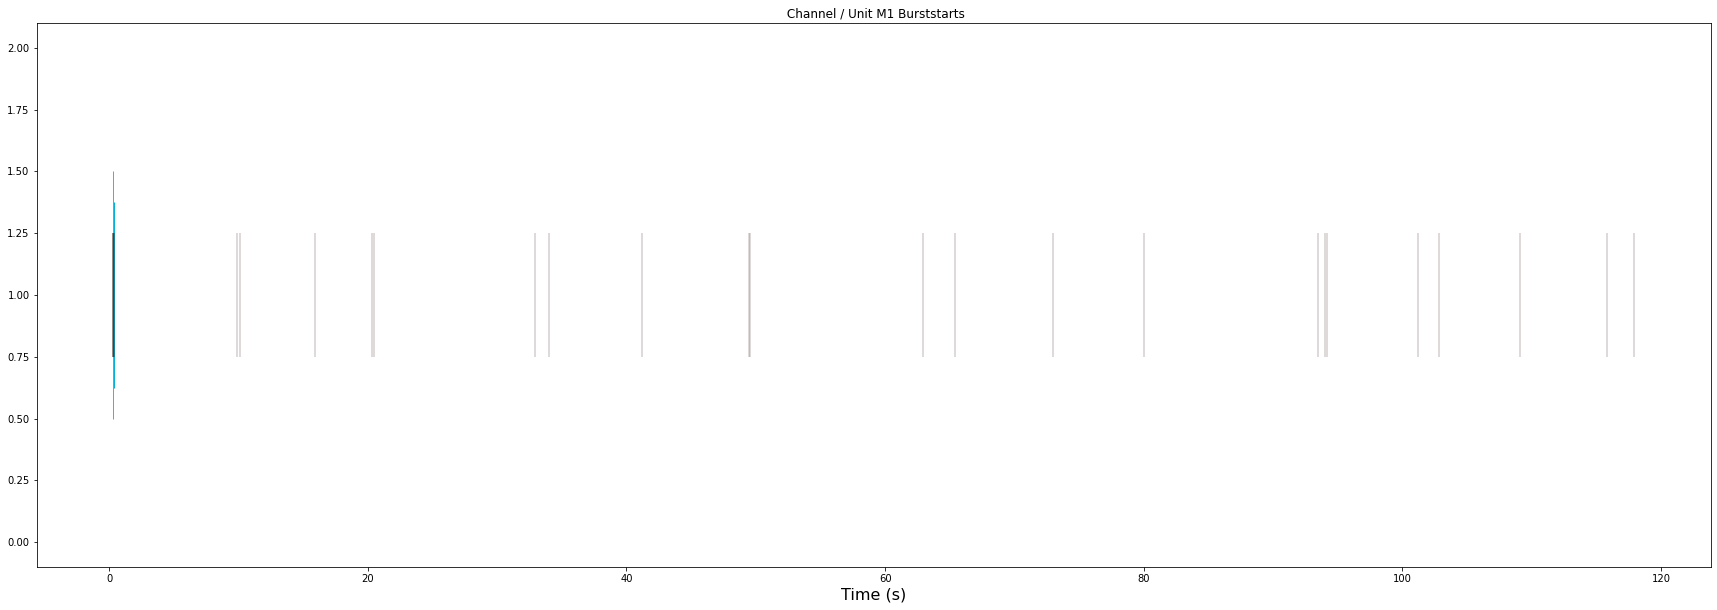

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M2 Burststarts')

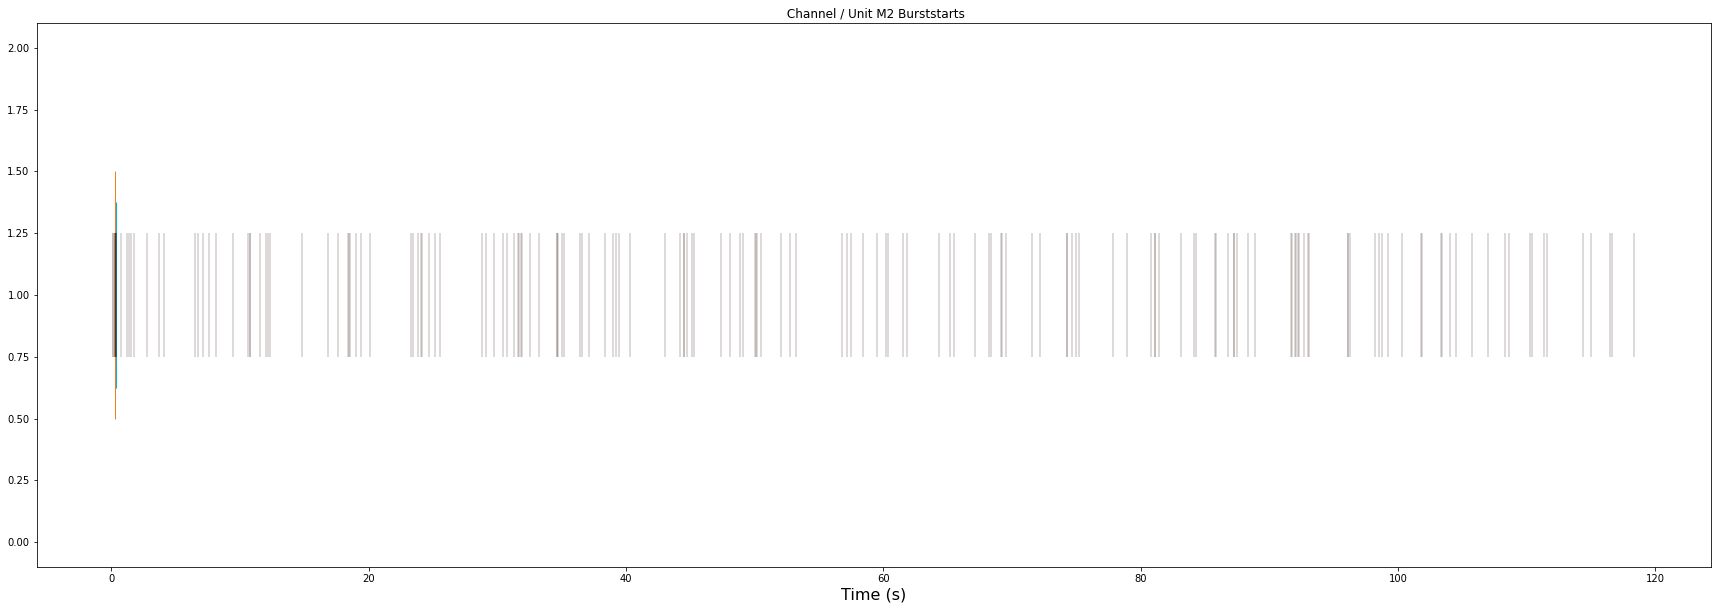

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O13 Burststarts')

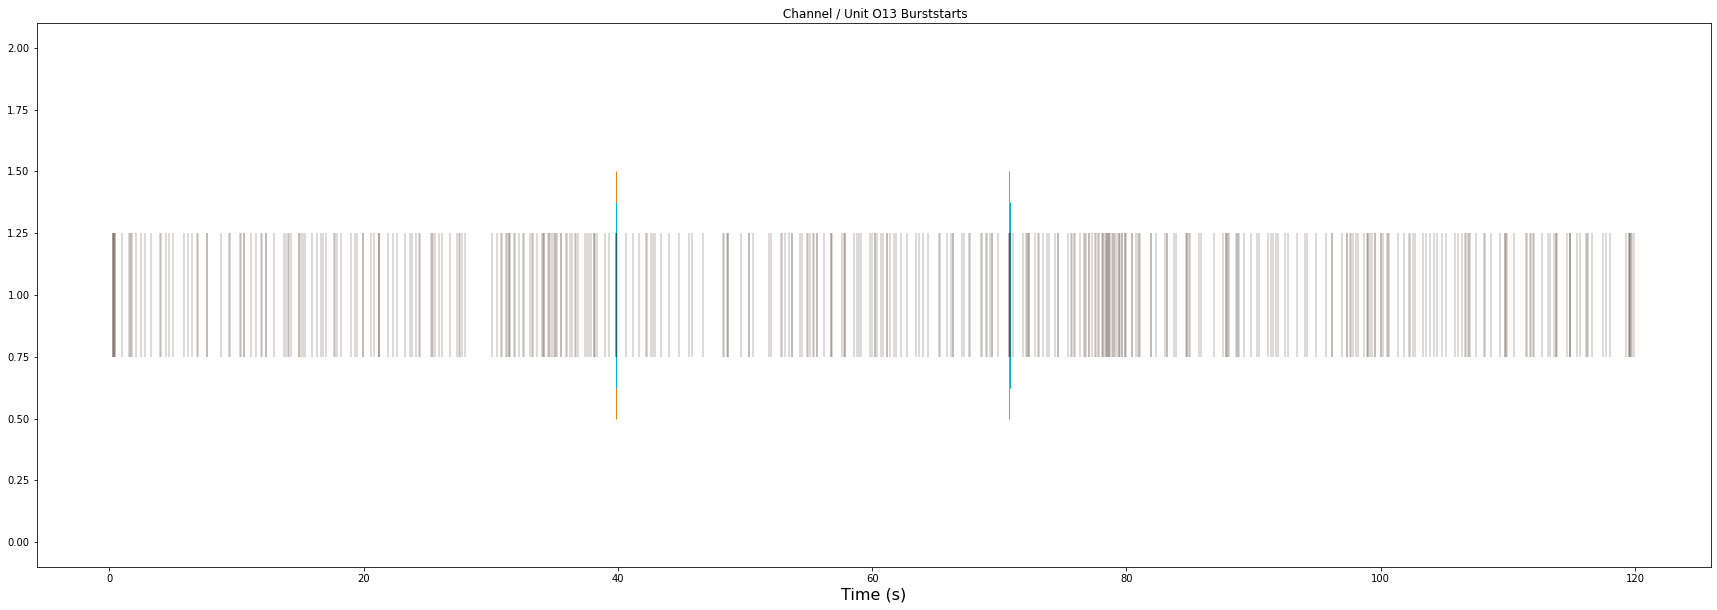

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K2 Burststarts')

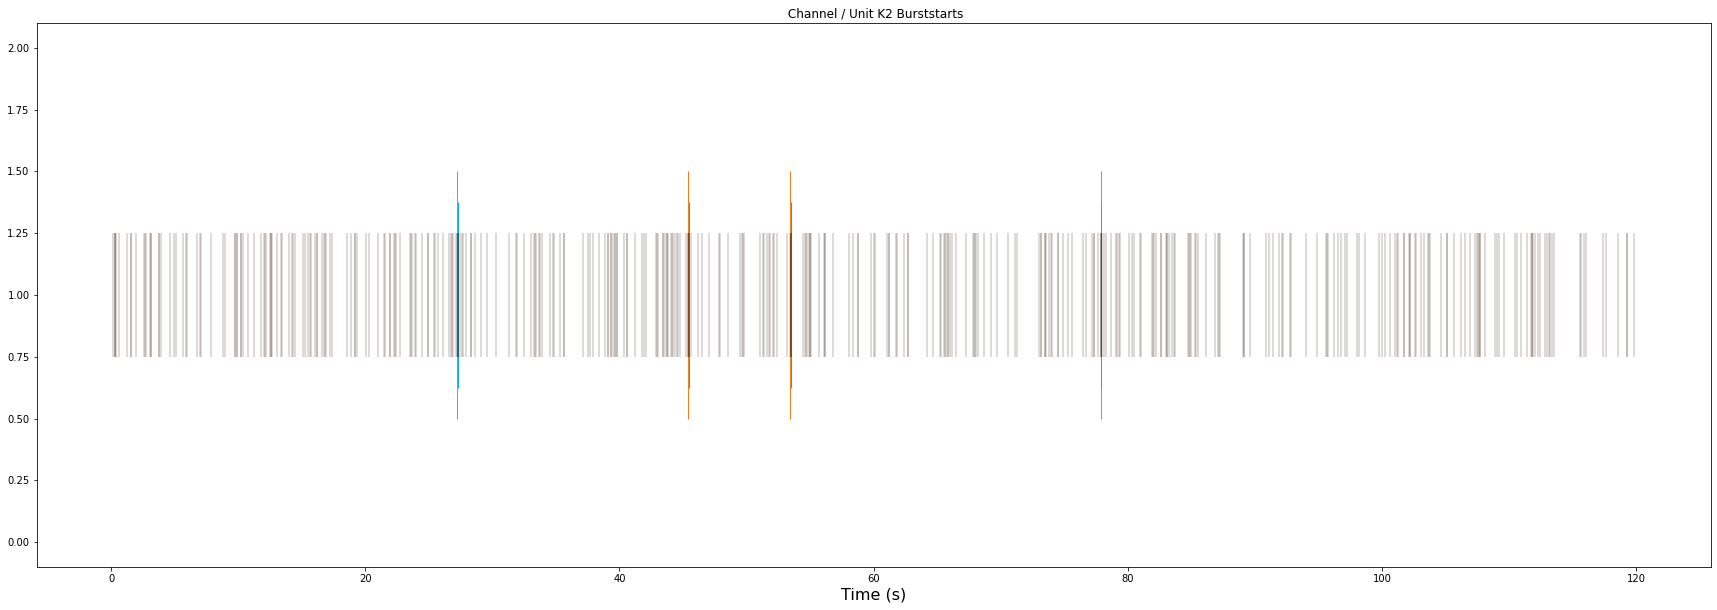

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D10 Burststarts')

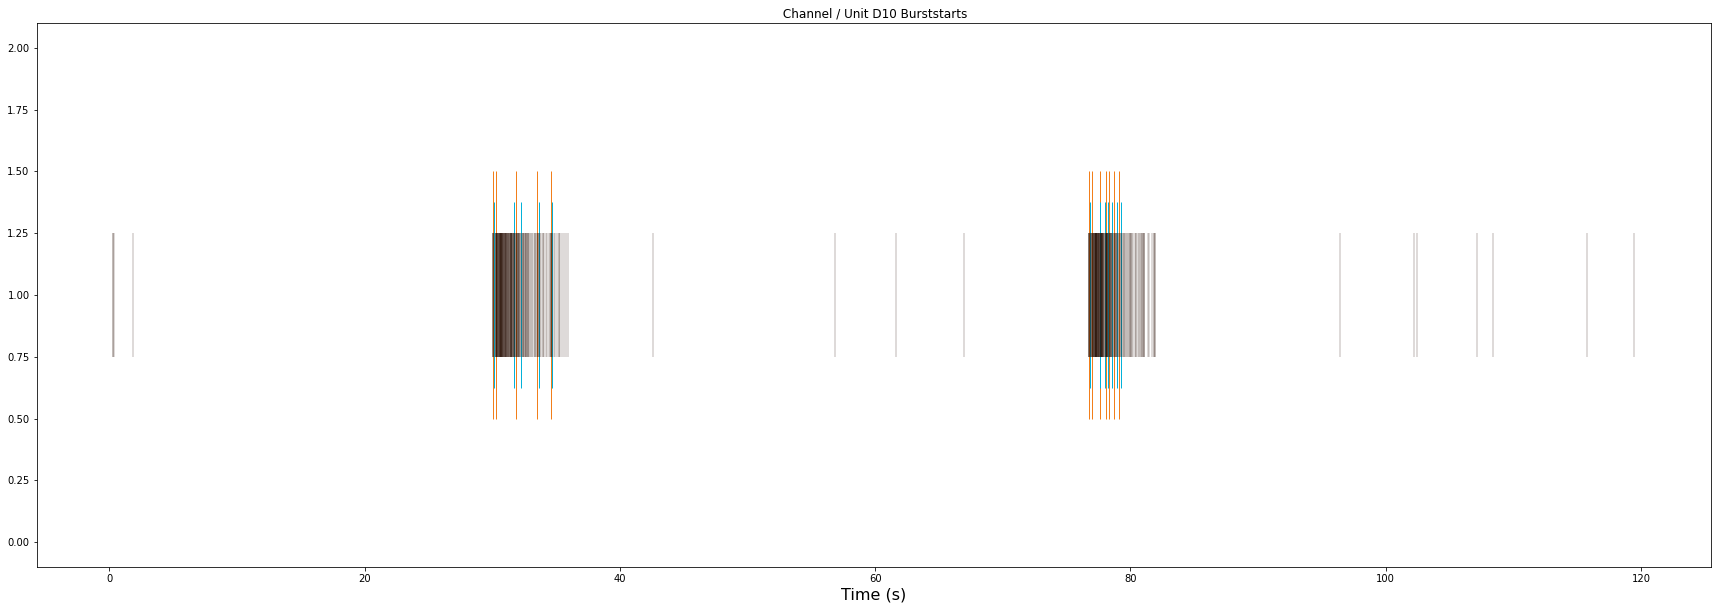

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H10 Burststarts')

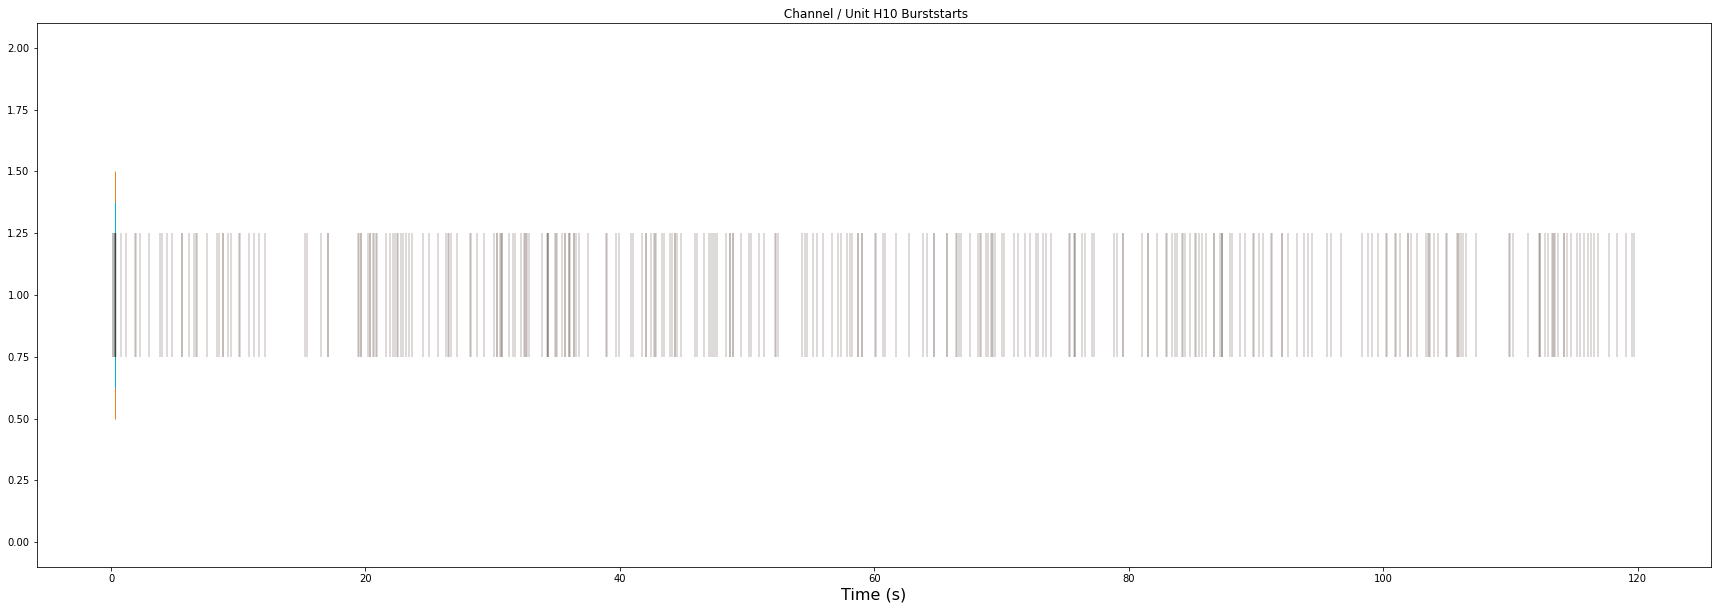

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F6 Burststarts')

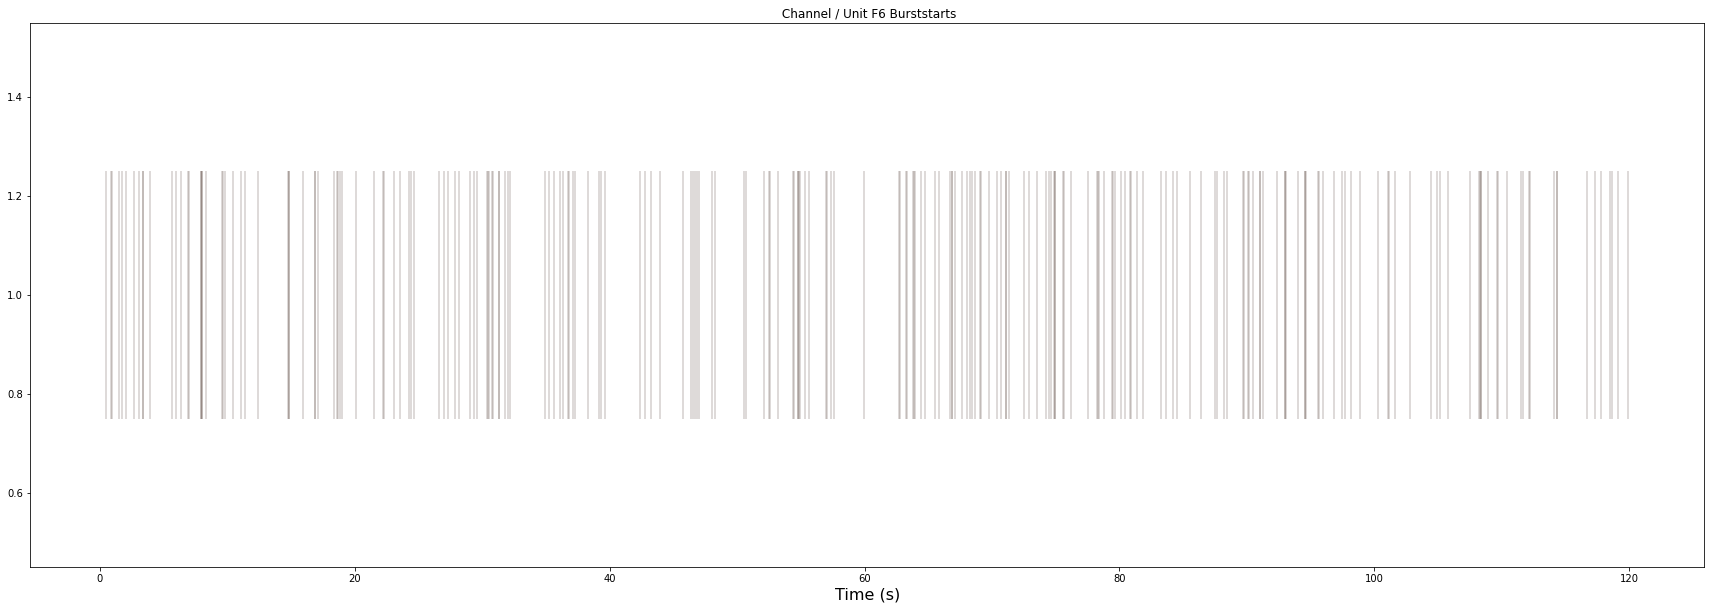

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F12 Burststarts')

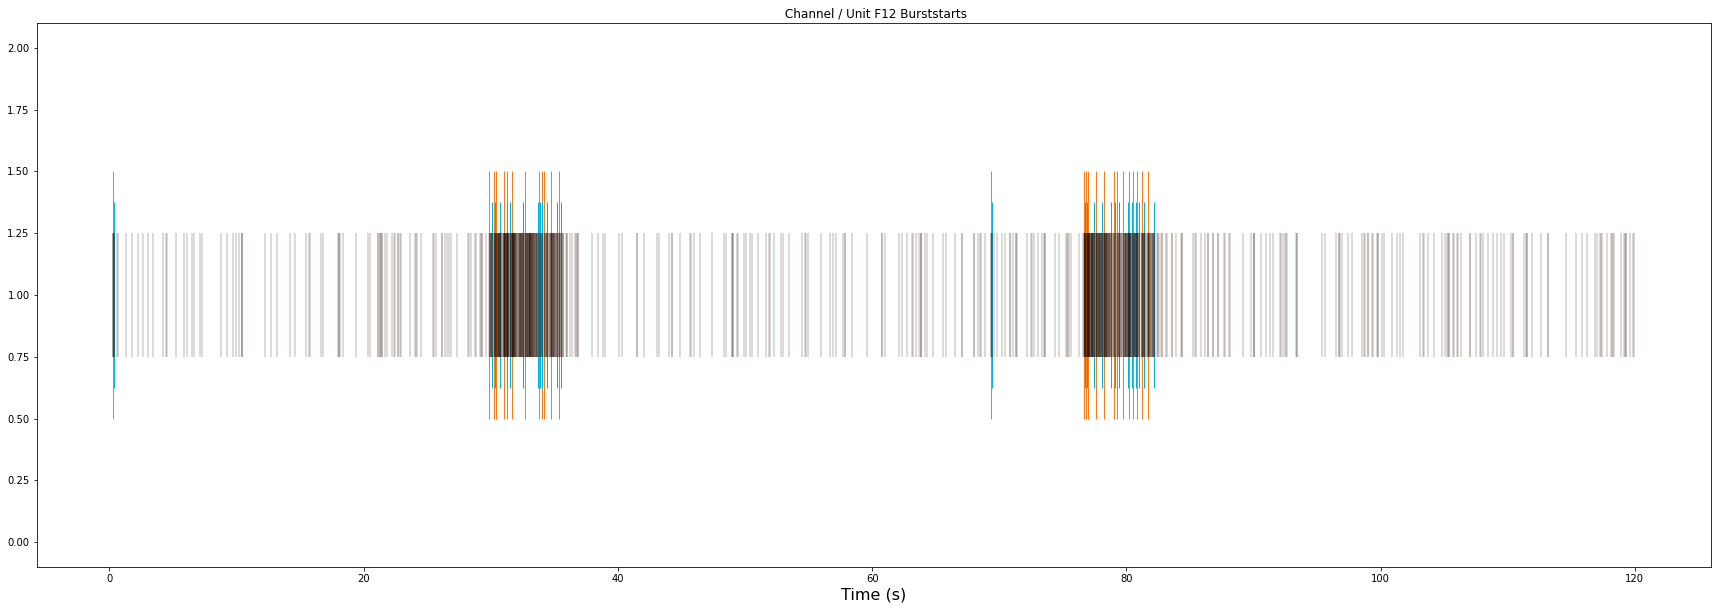

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D6 Burststarts')

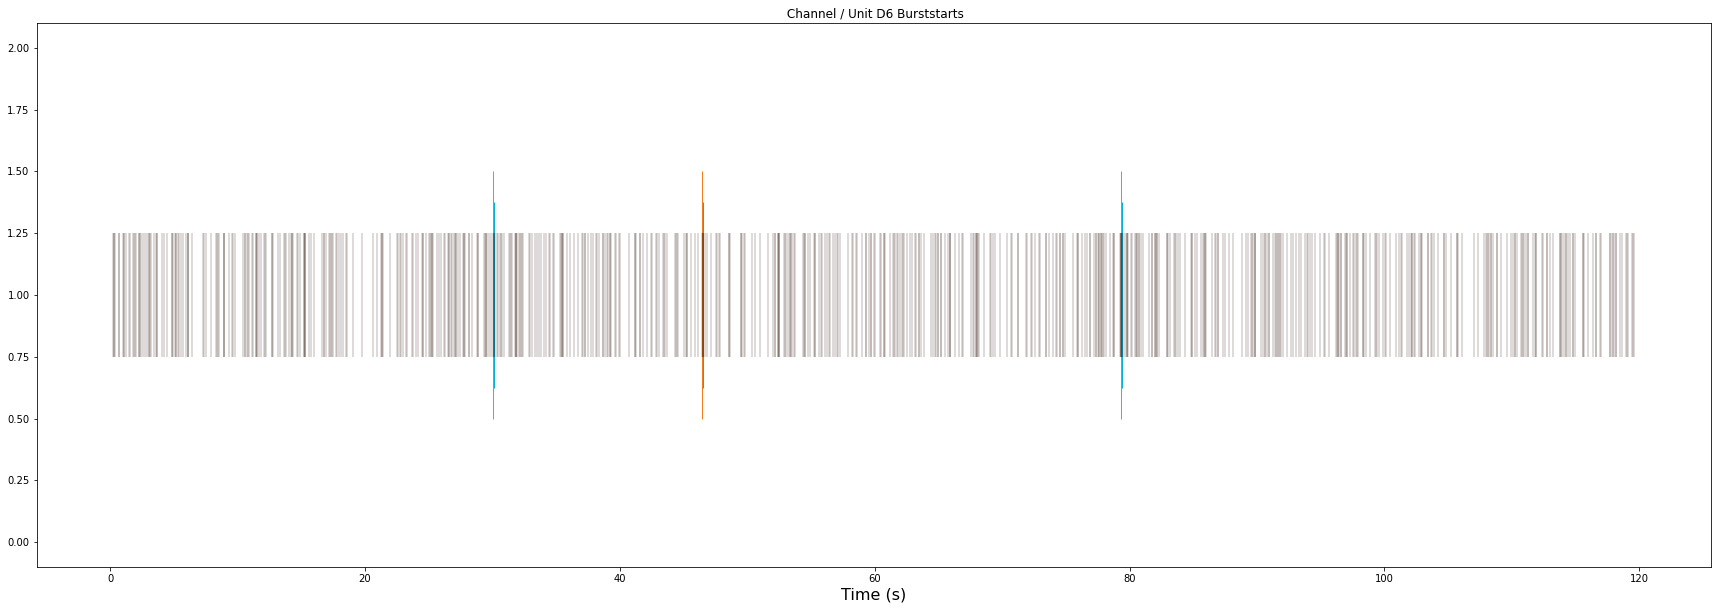

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B15 Burststarts')

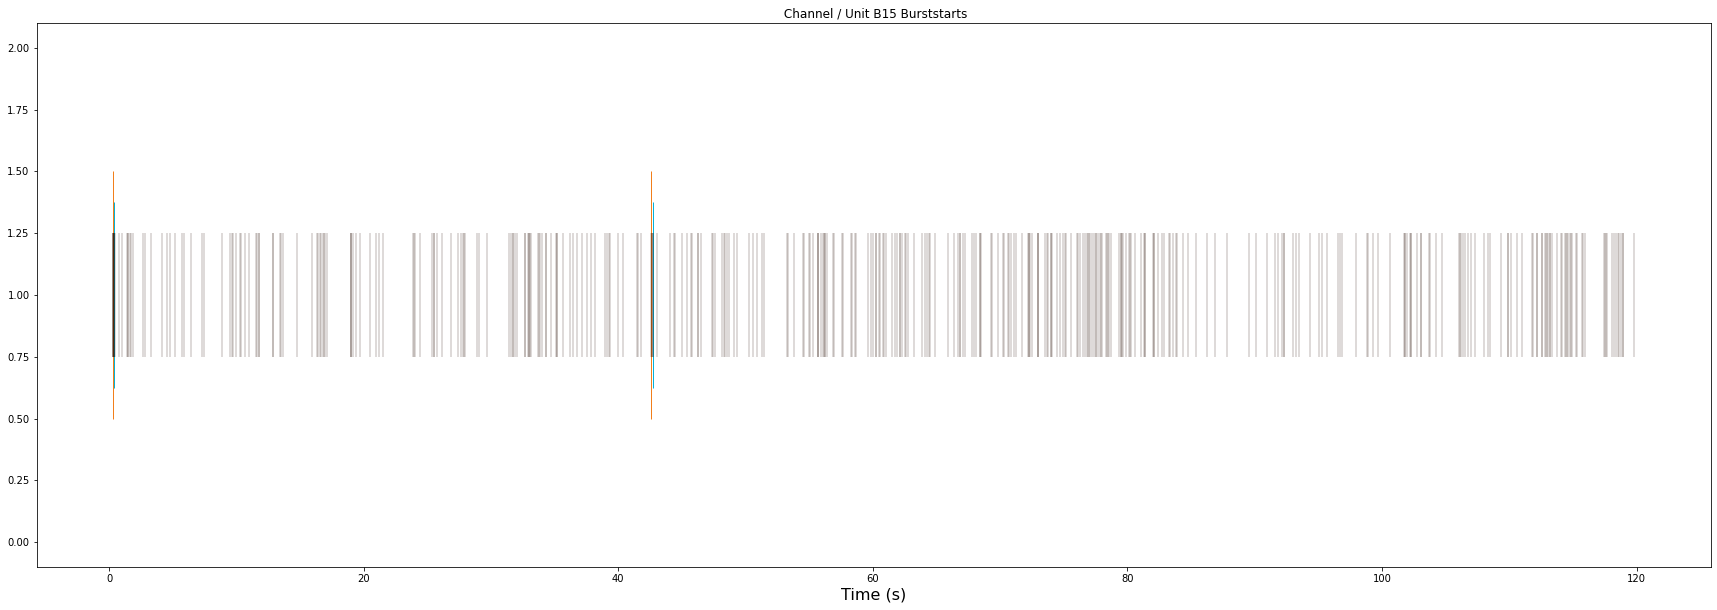

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R5 Burststarts')

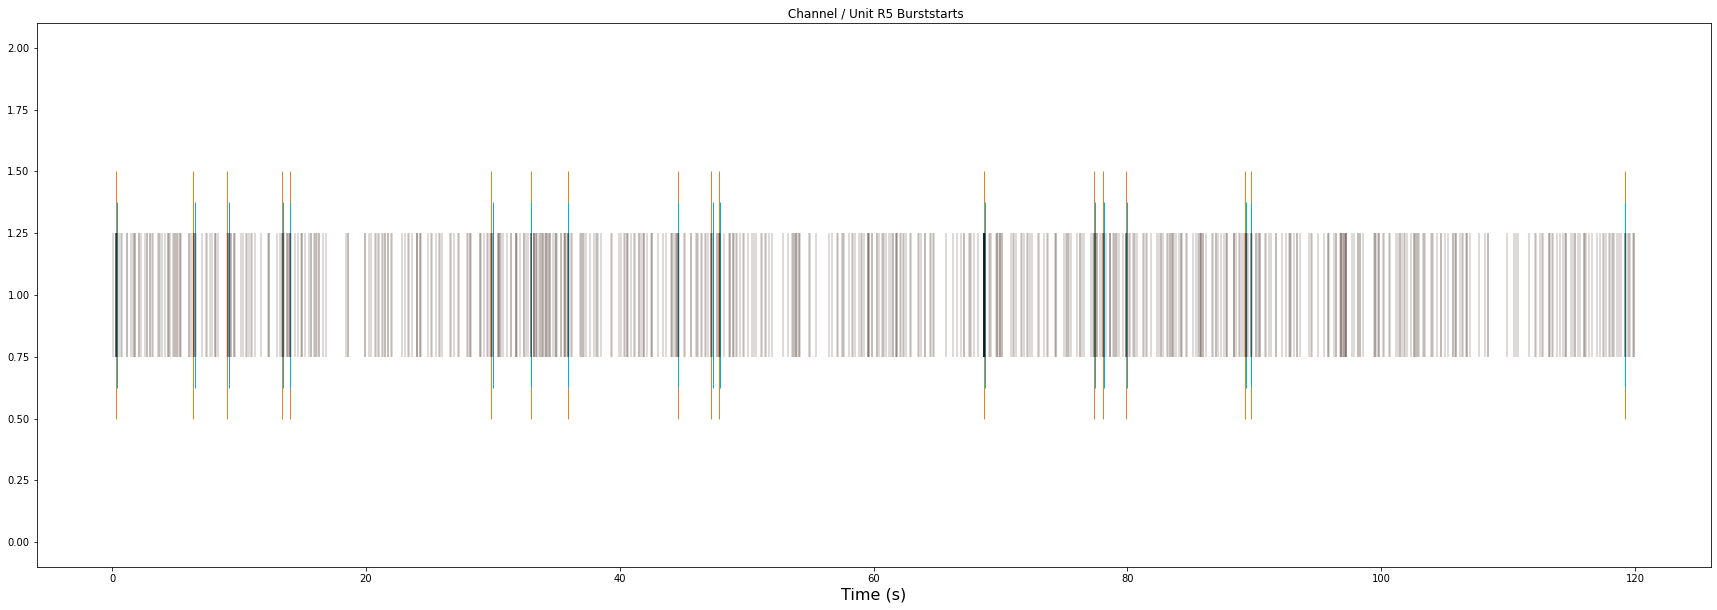

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I5 Burststarts')

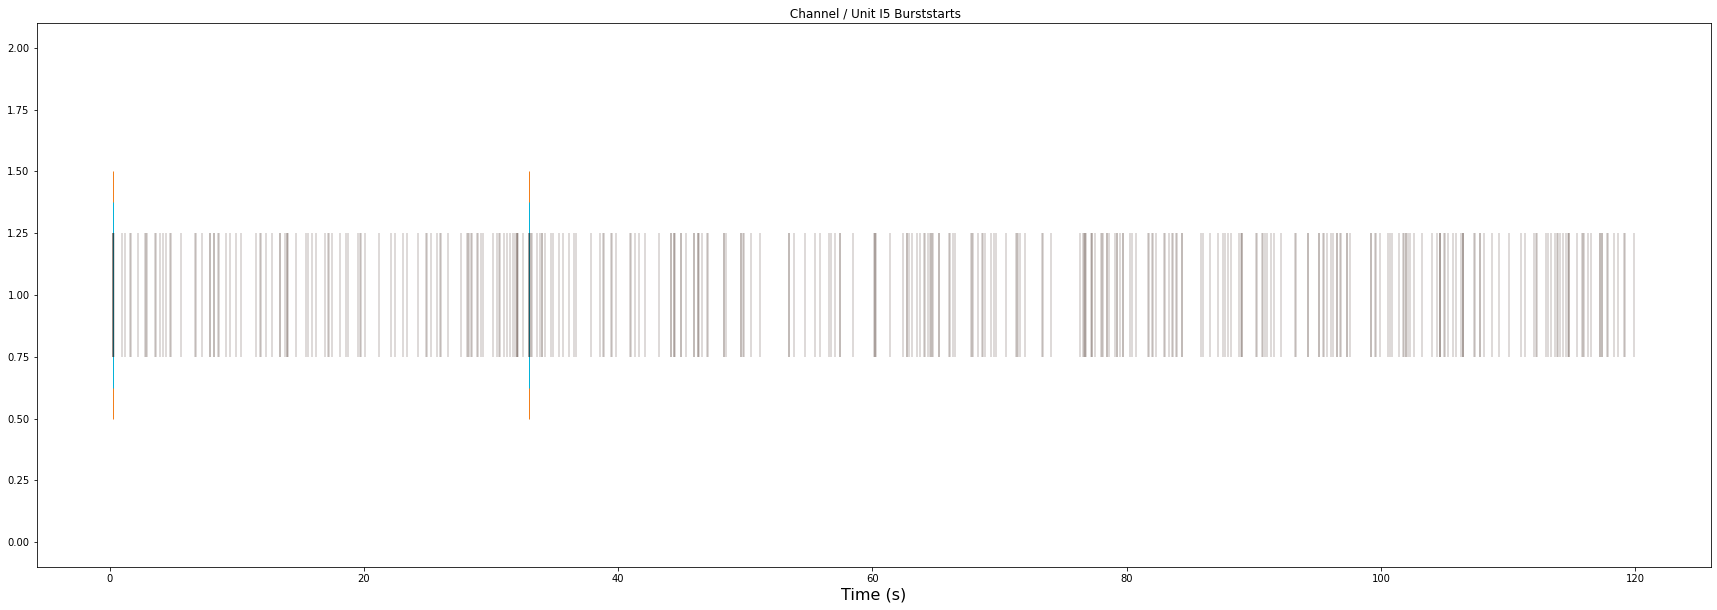

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I12 Burststarts')

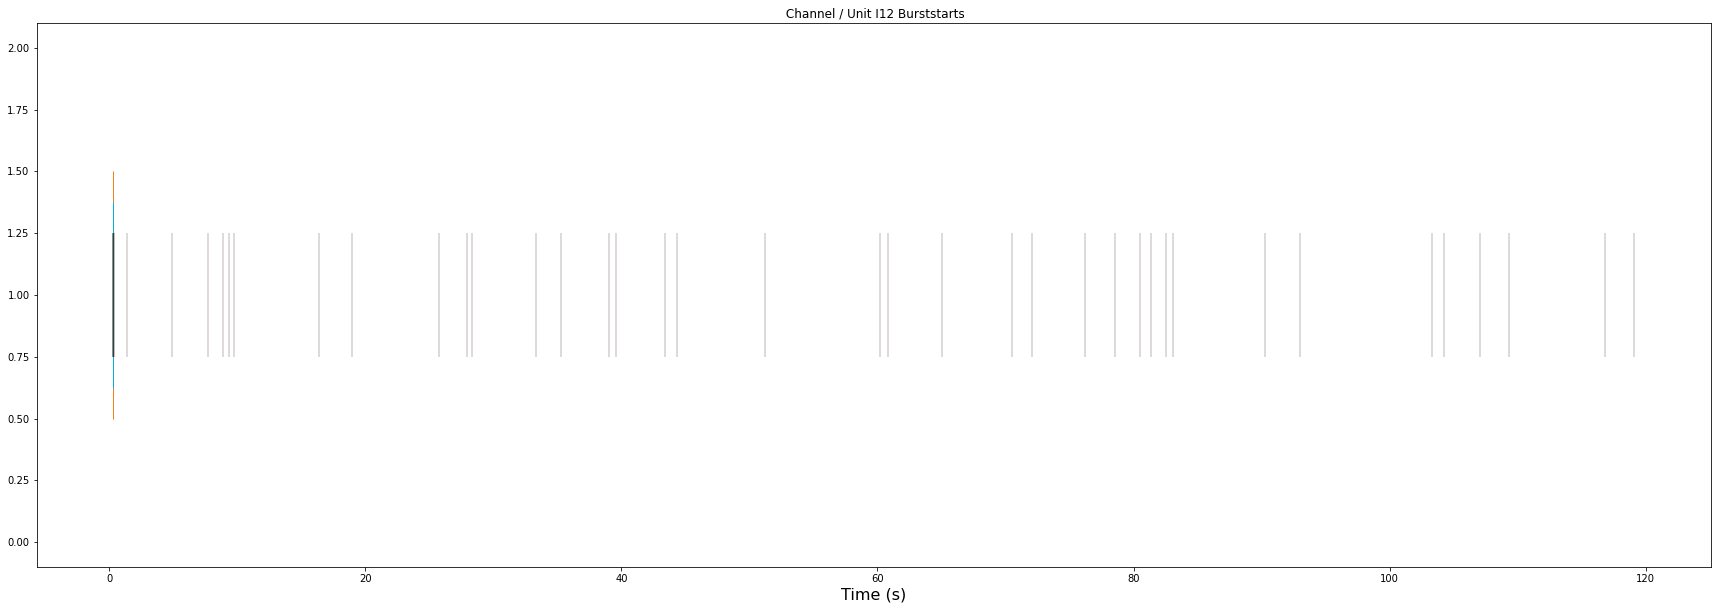

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M10 Burststarts')

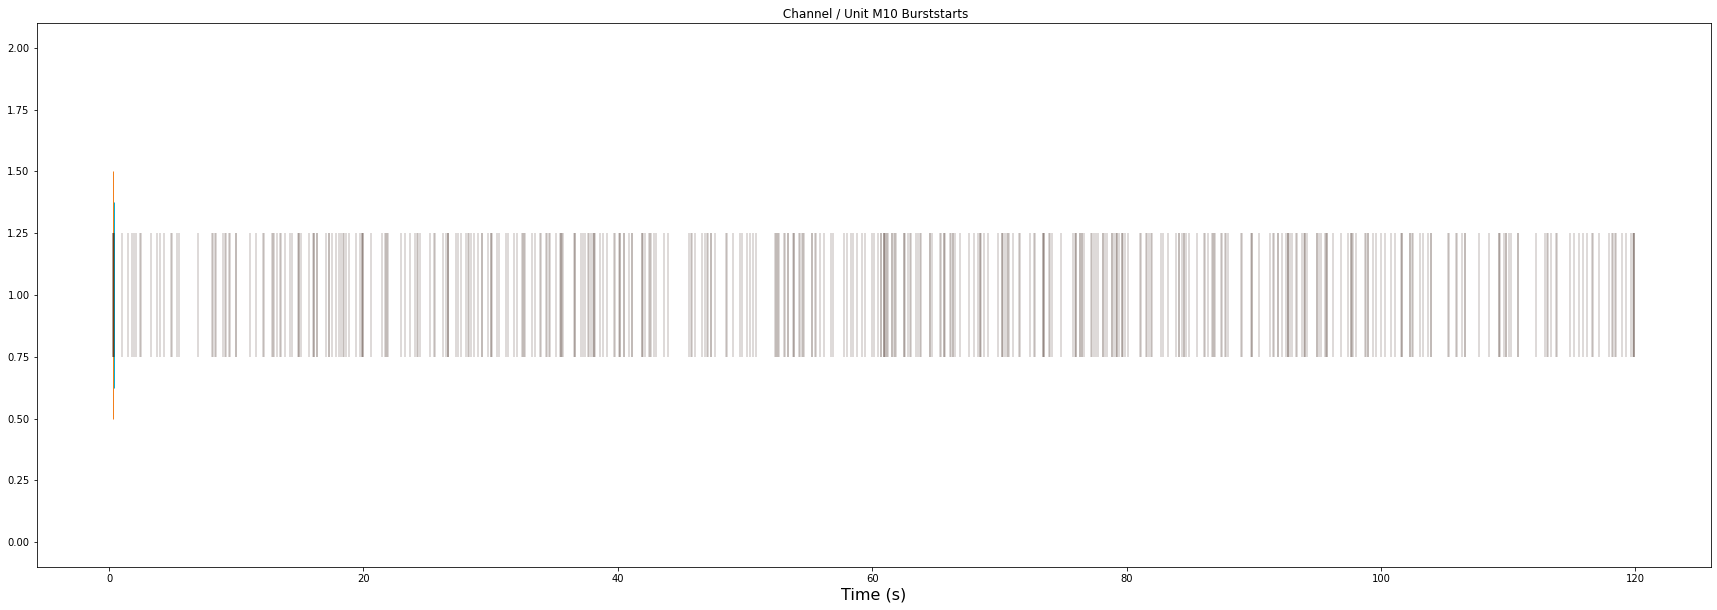

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P3 Burststarts')

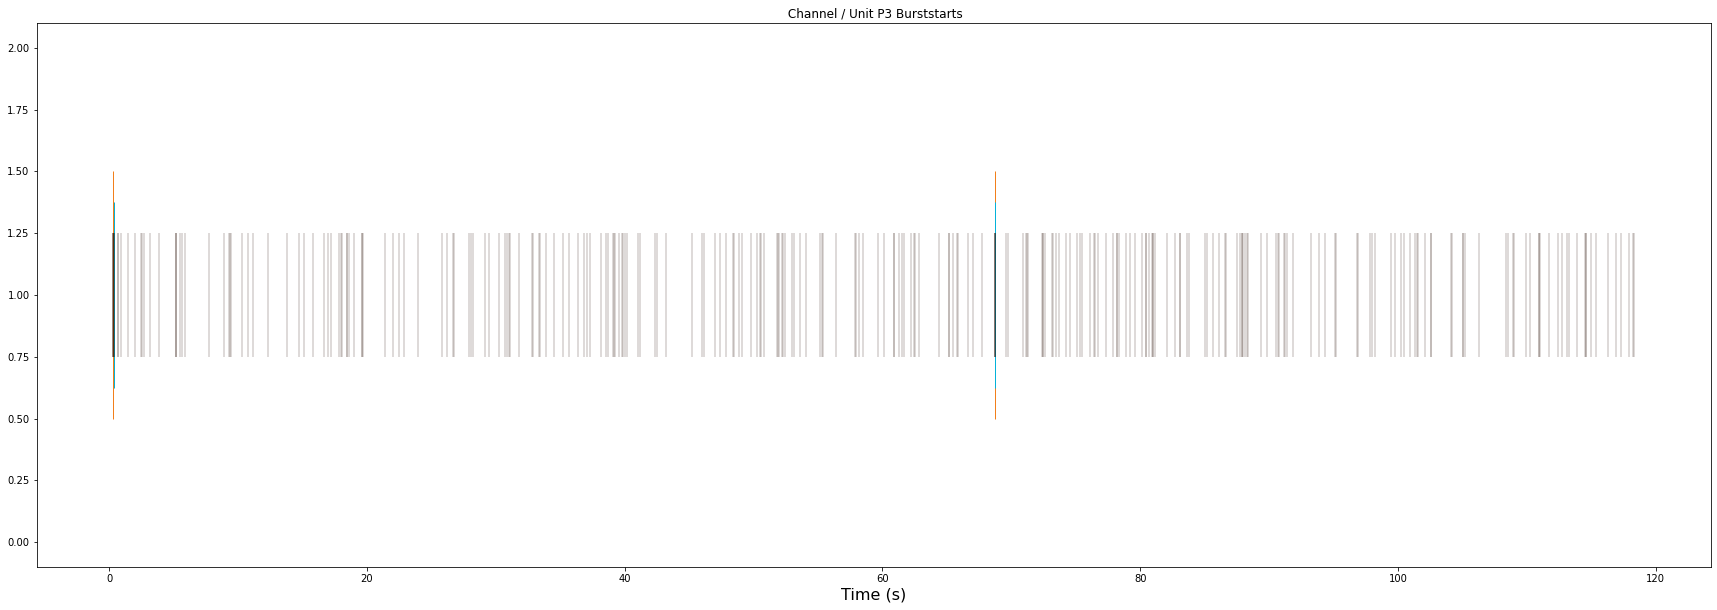

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H3 Burststarts')

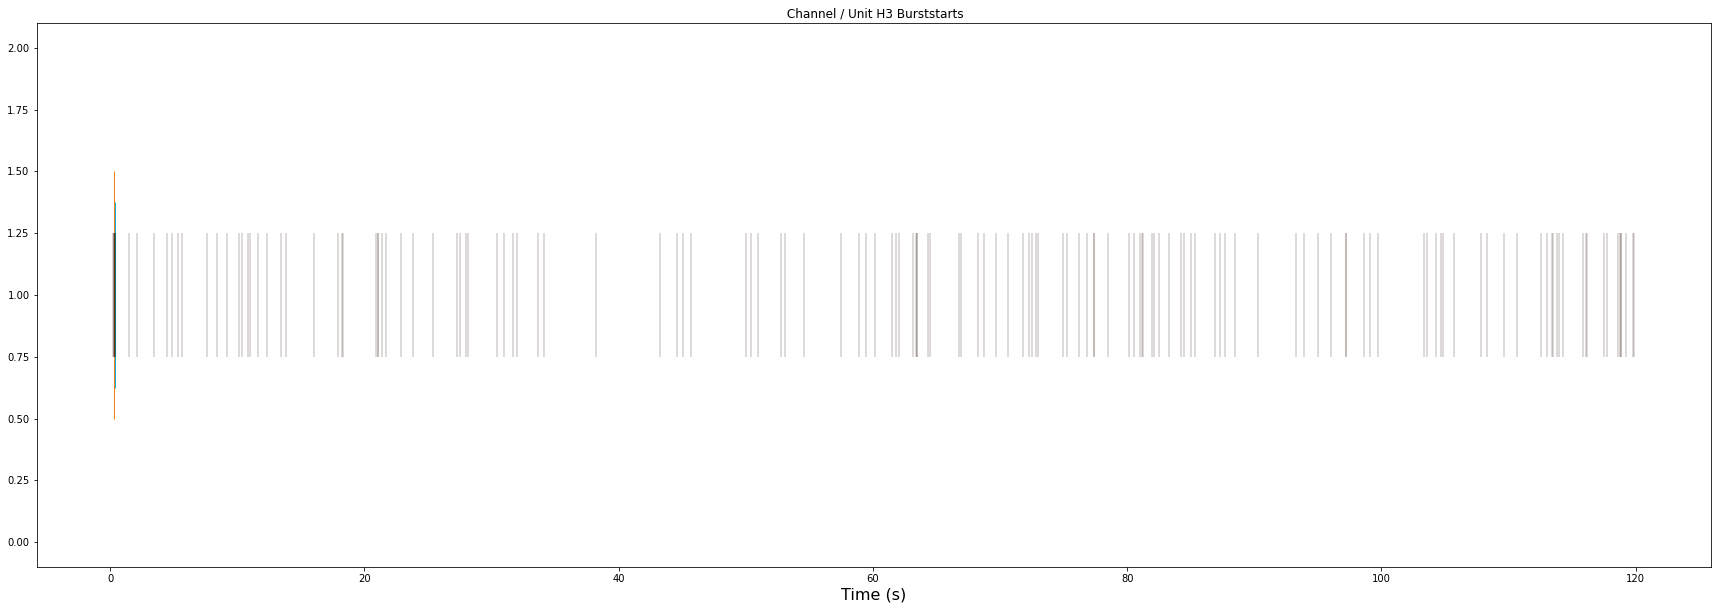

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B9 Burststarts')

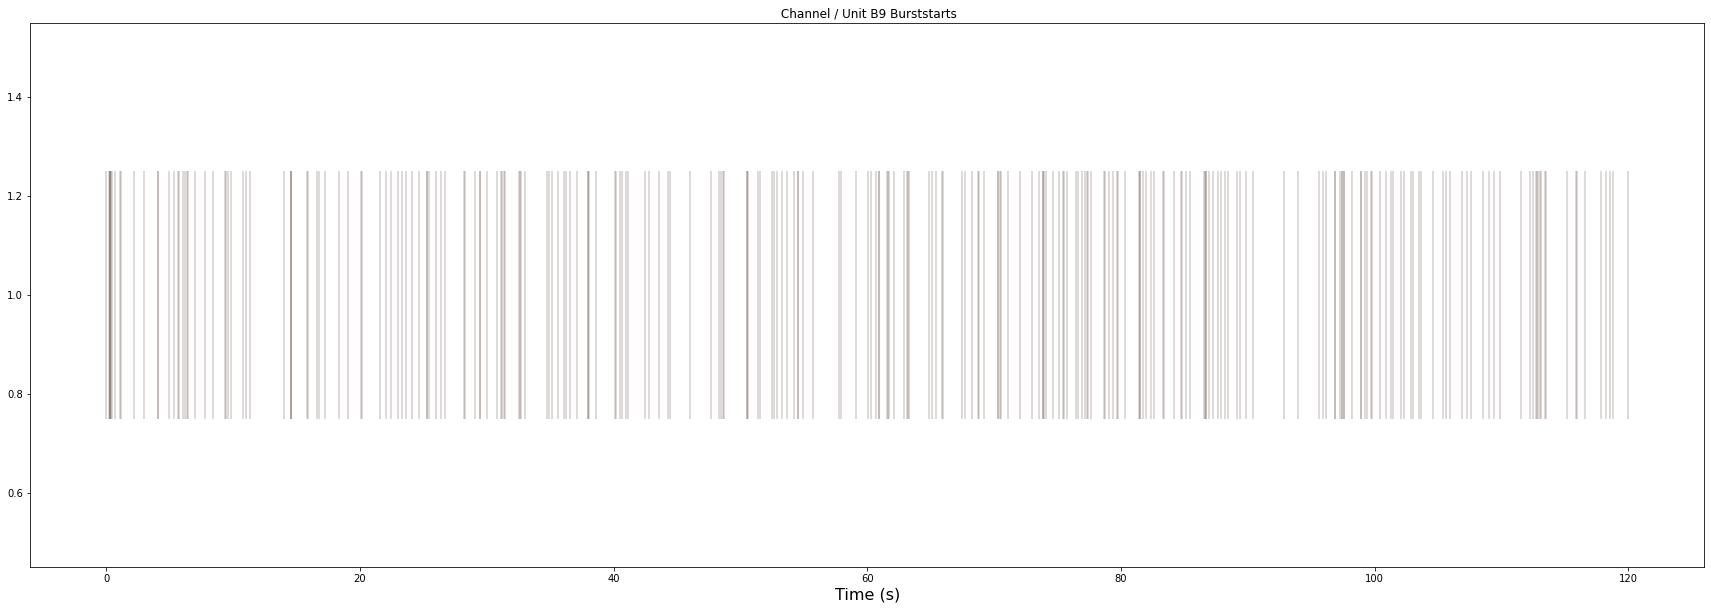

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A5 Burststarts')

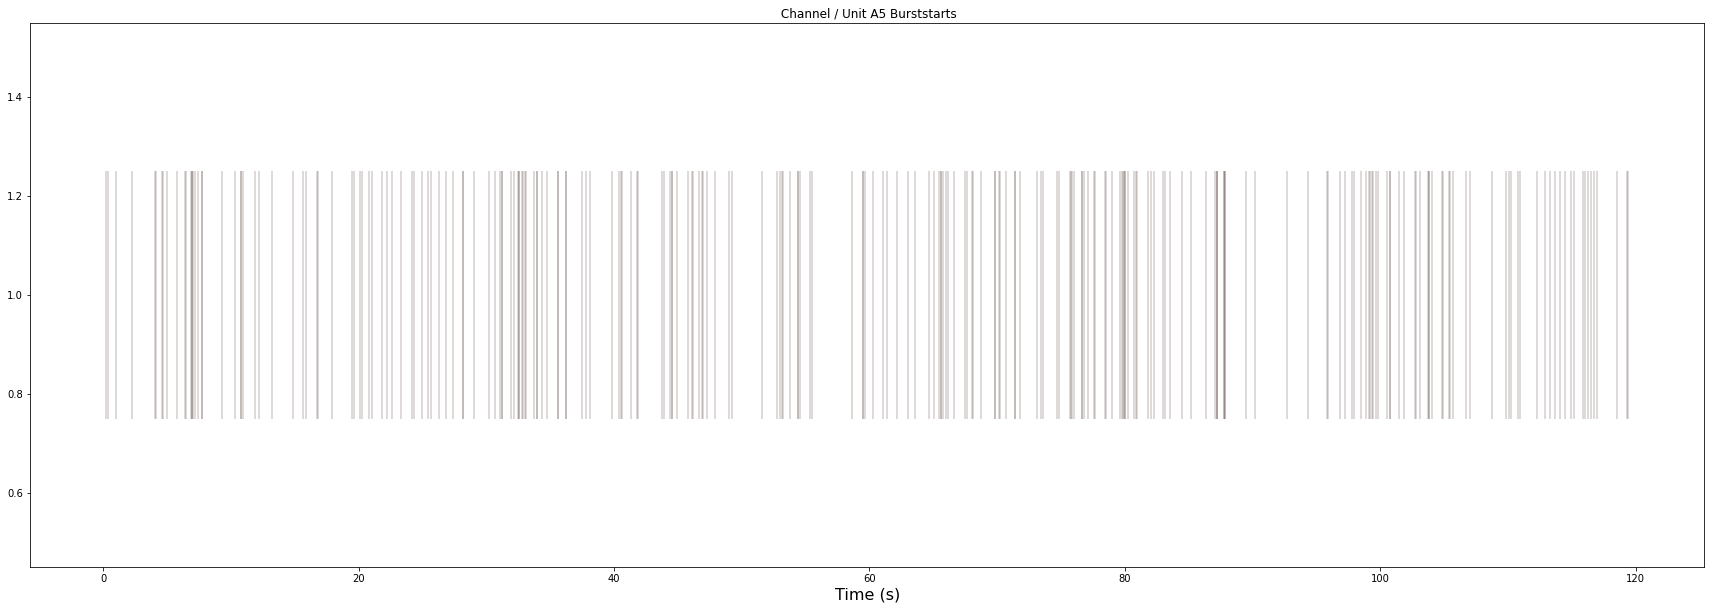

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I11 Burststarts')

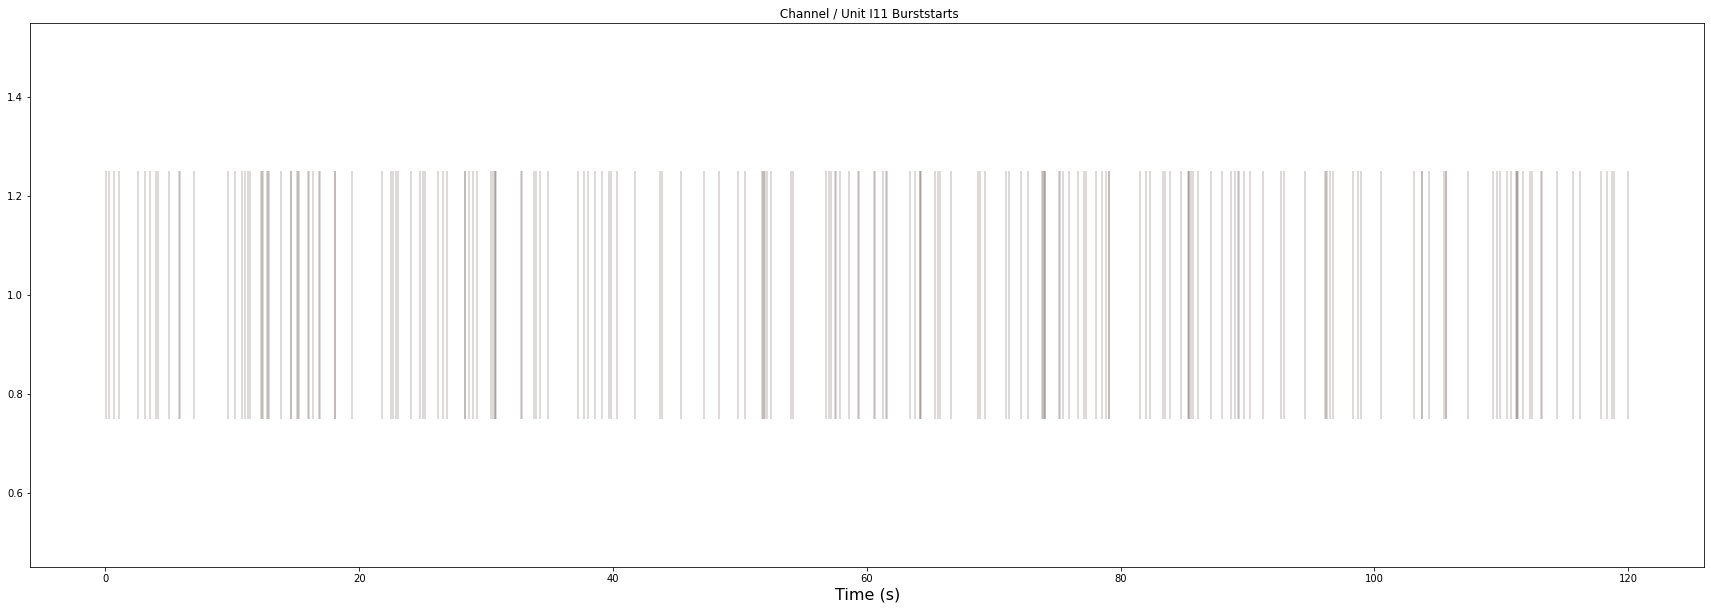

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C6 Burststarts')

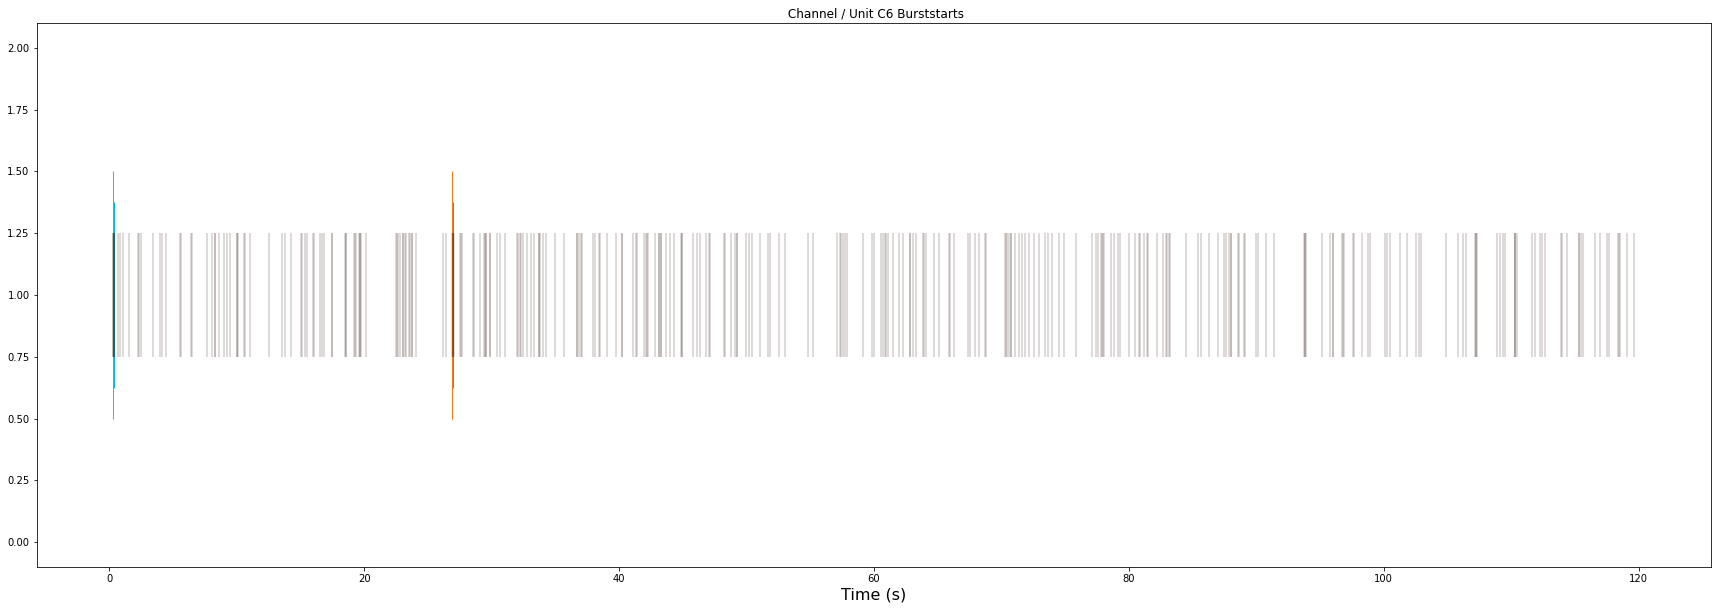

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D13 Burststarts')

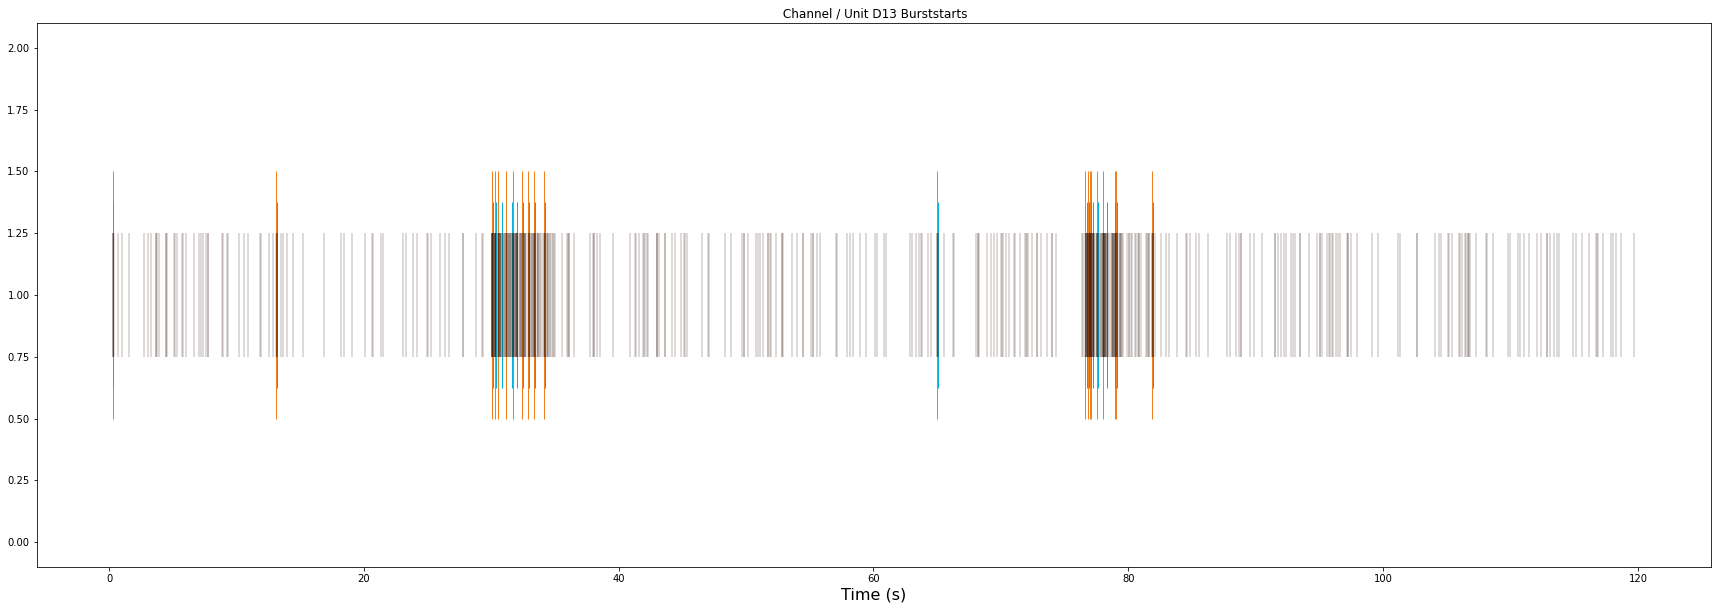

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D16 Burststarts')

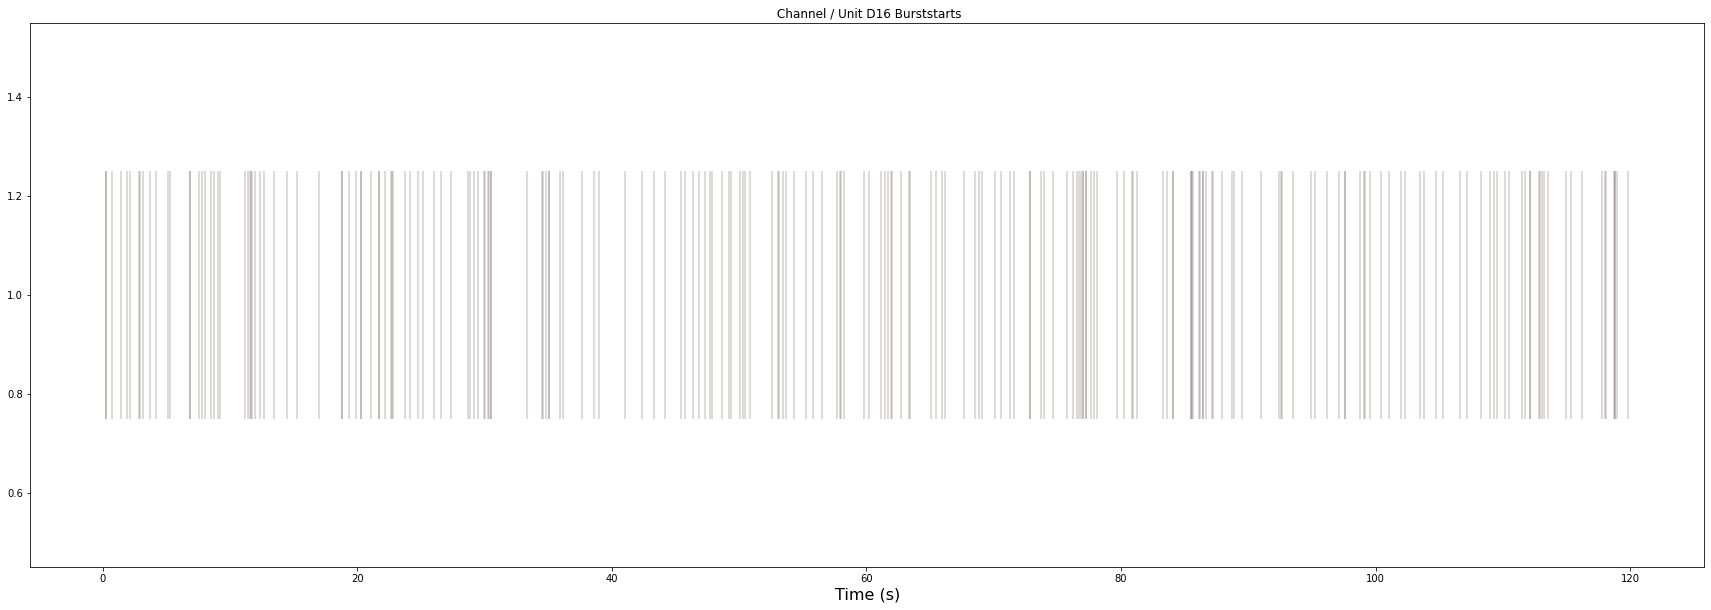

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F15 Burststarts')

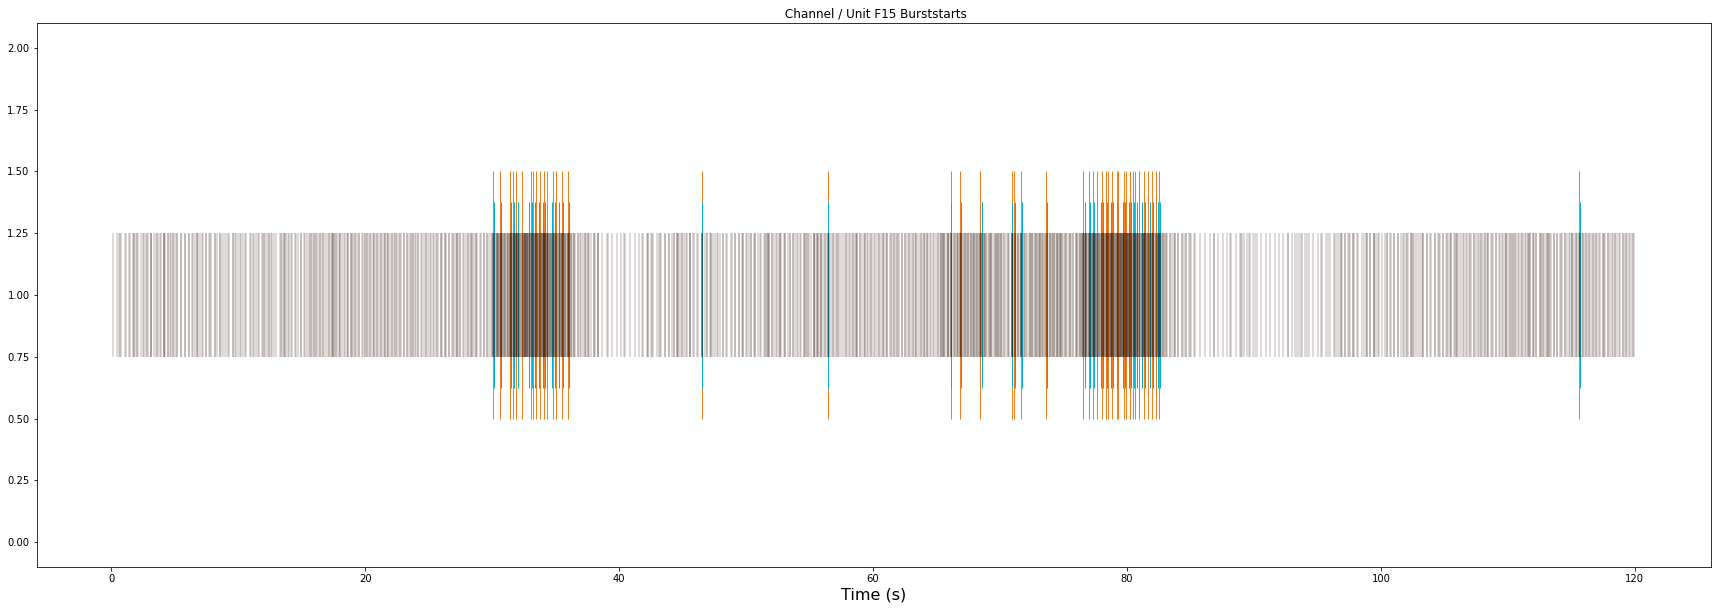

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E14 Burststarts')

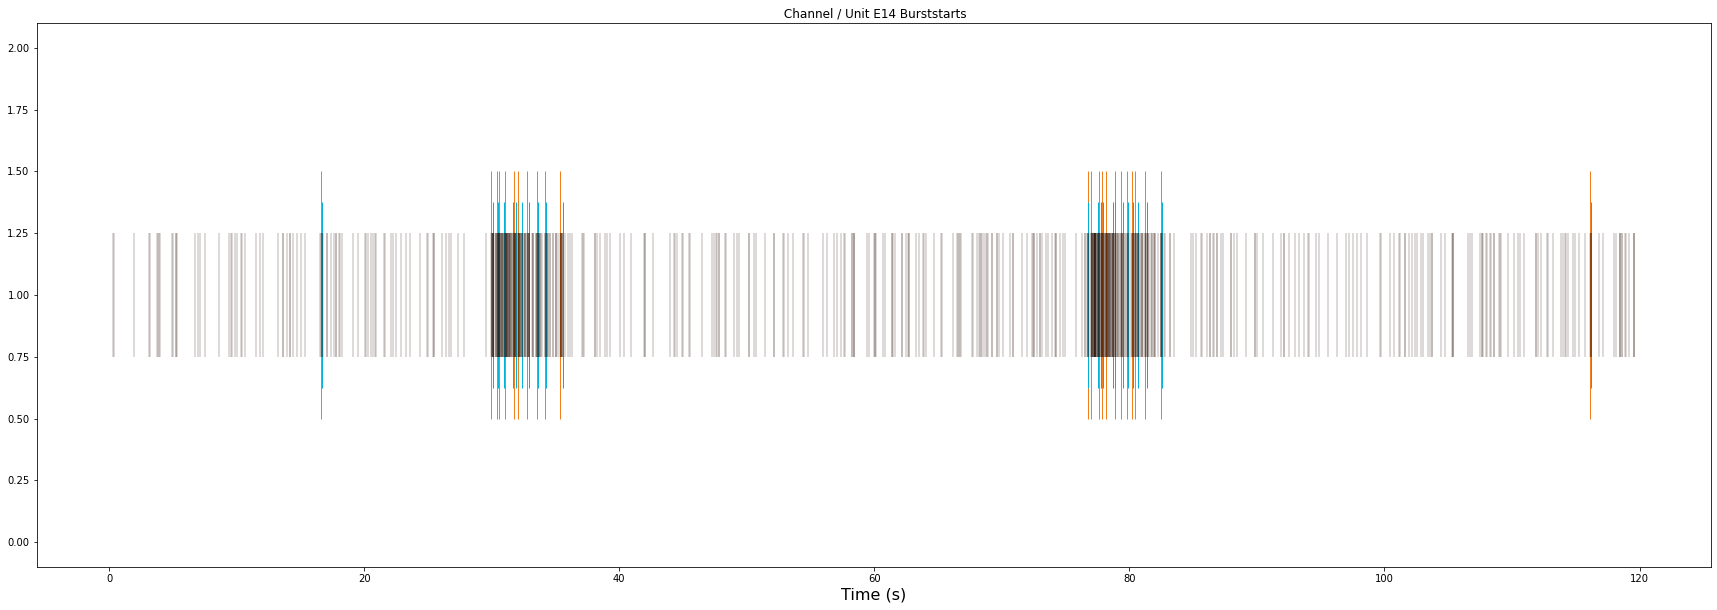

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K14 Burststarts')

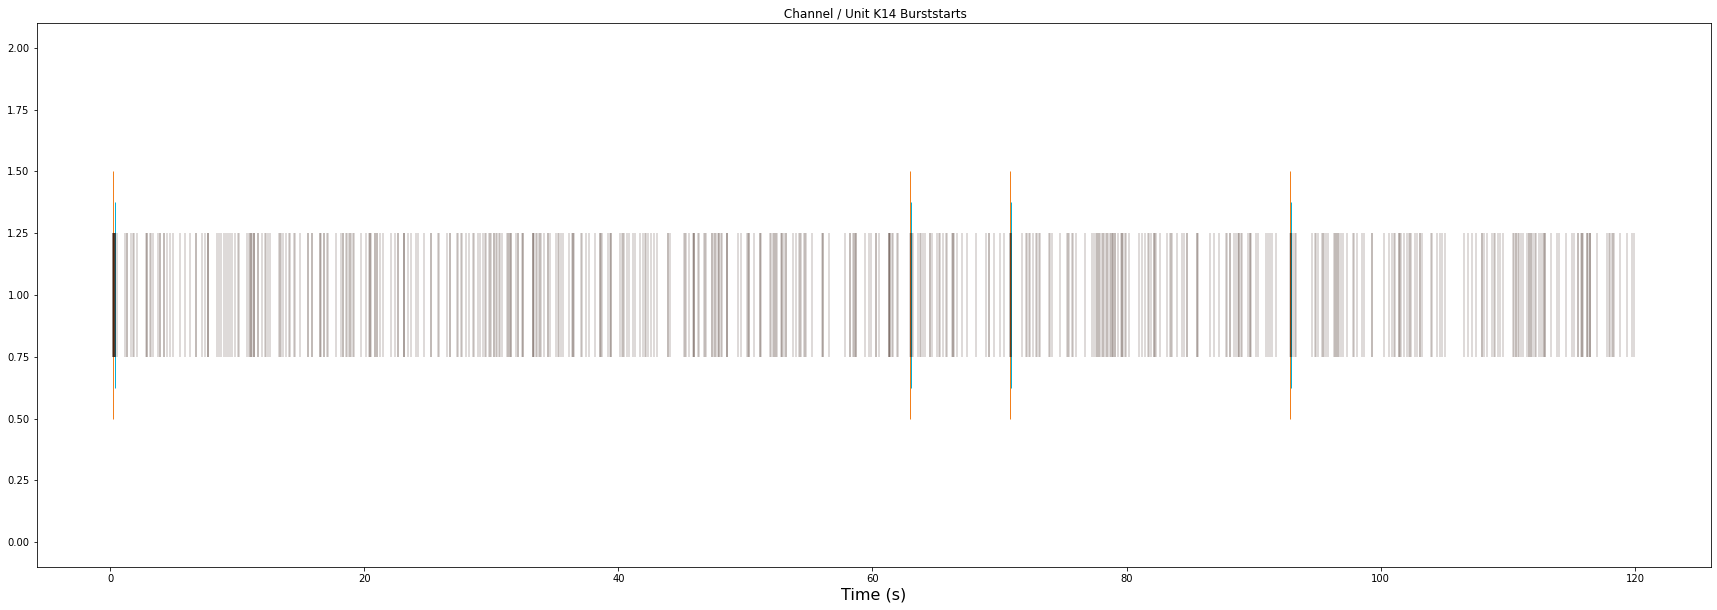

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N7 Burststarts')

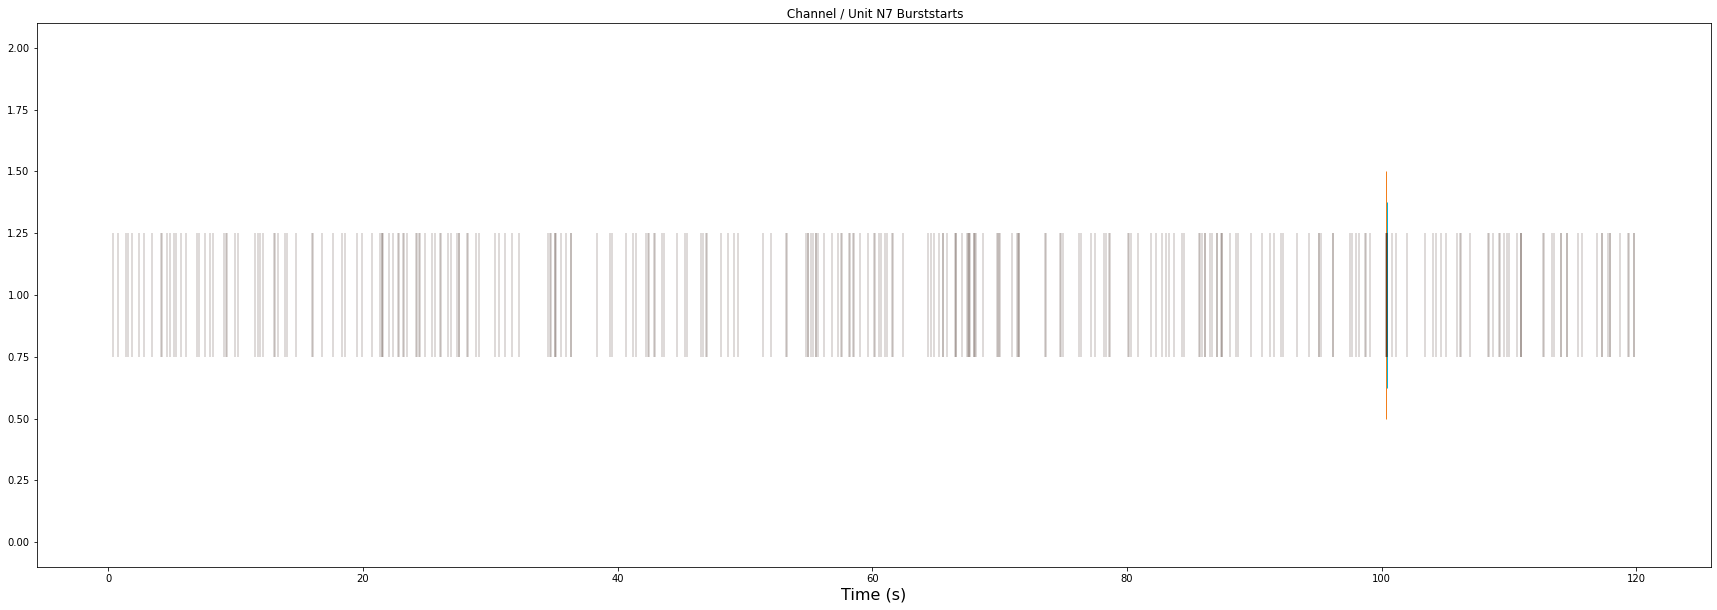

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K3 Burststarts')

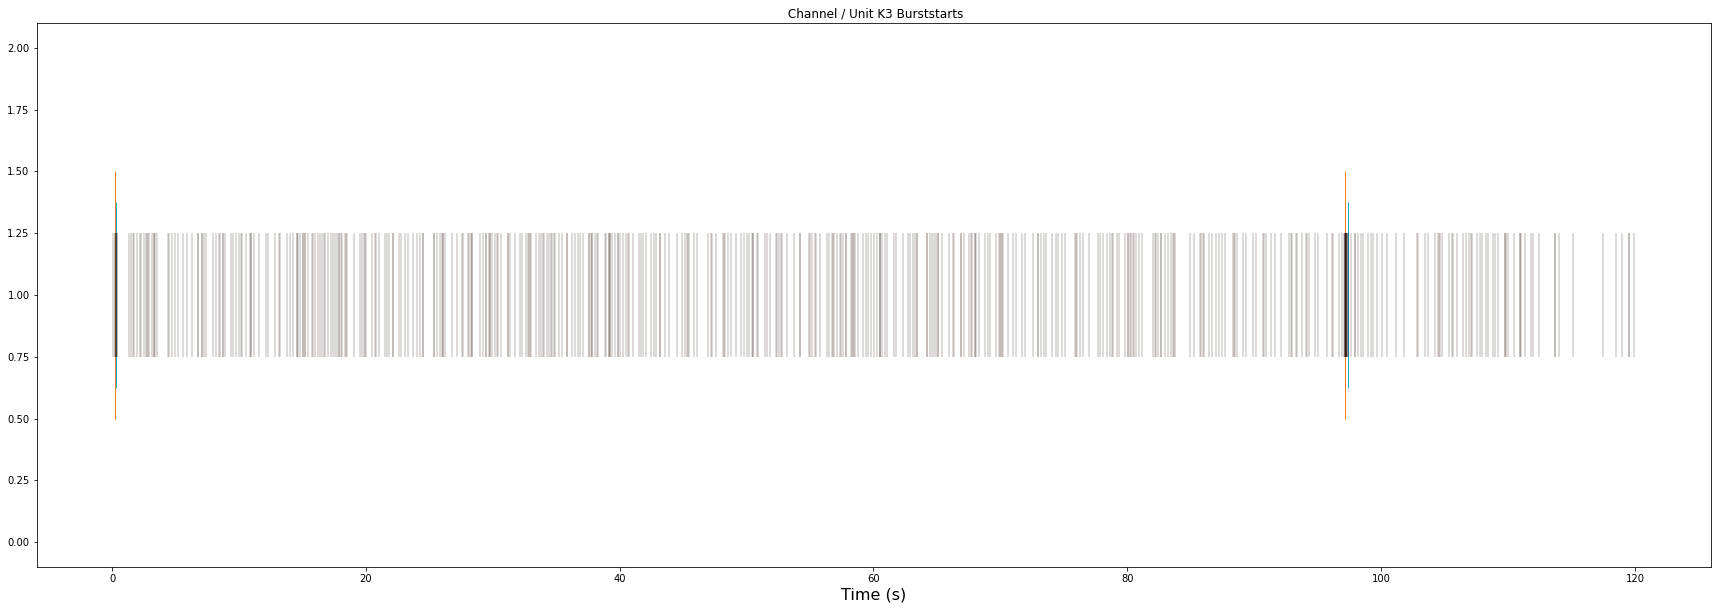

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L11 Burststarts')

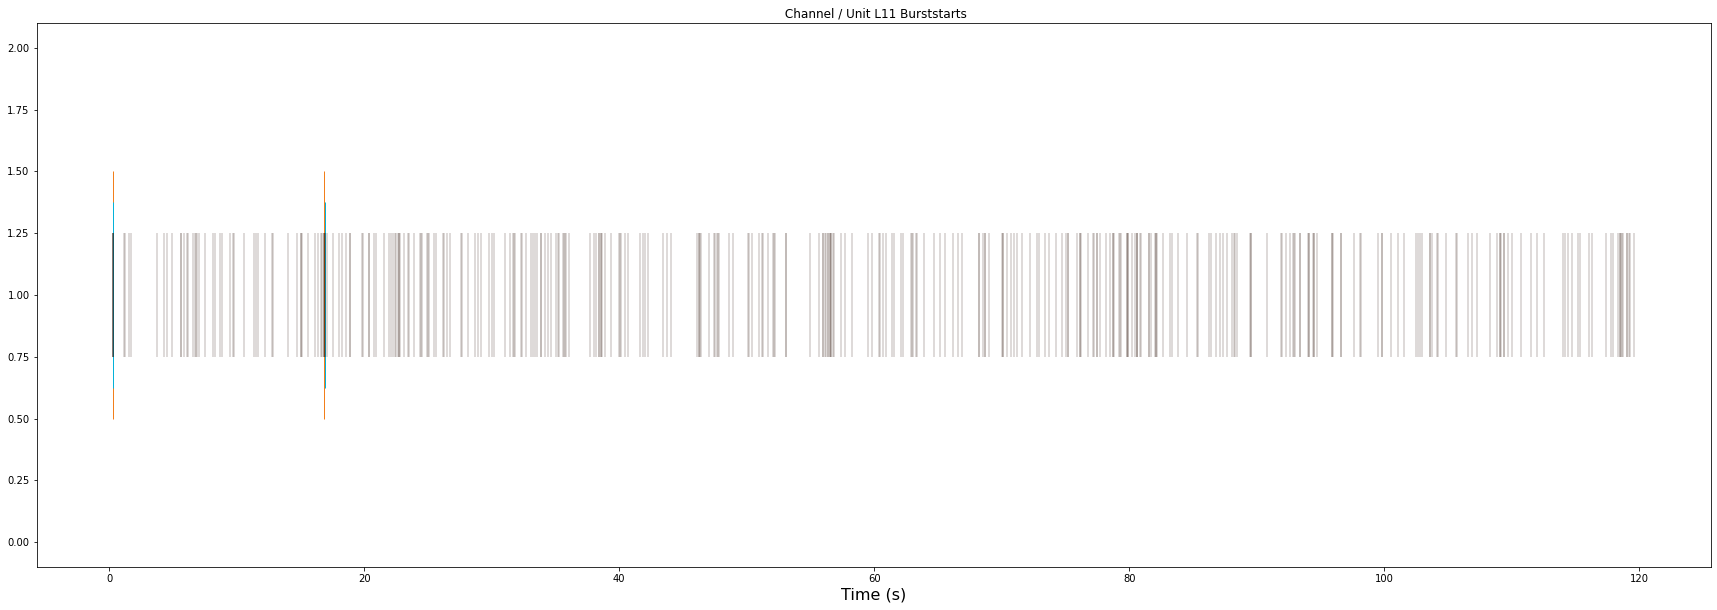

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P6 Burststarts')

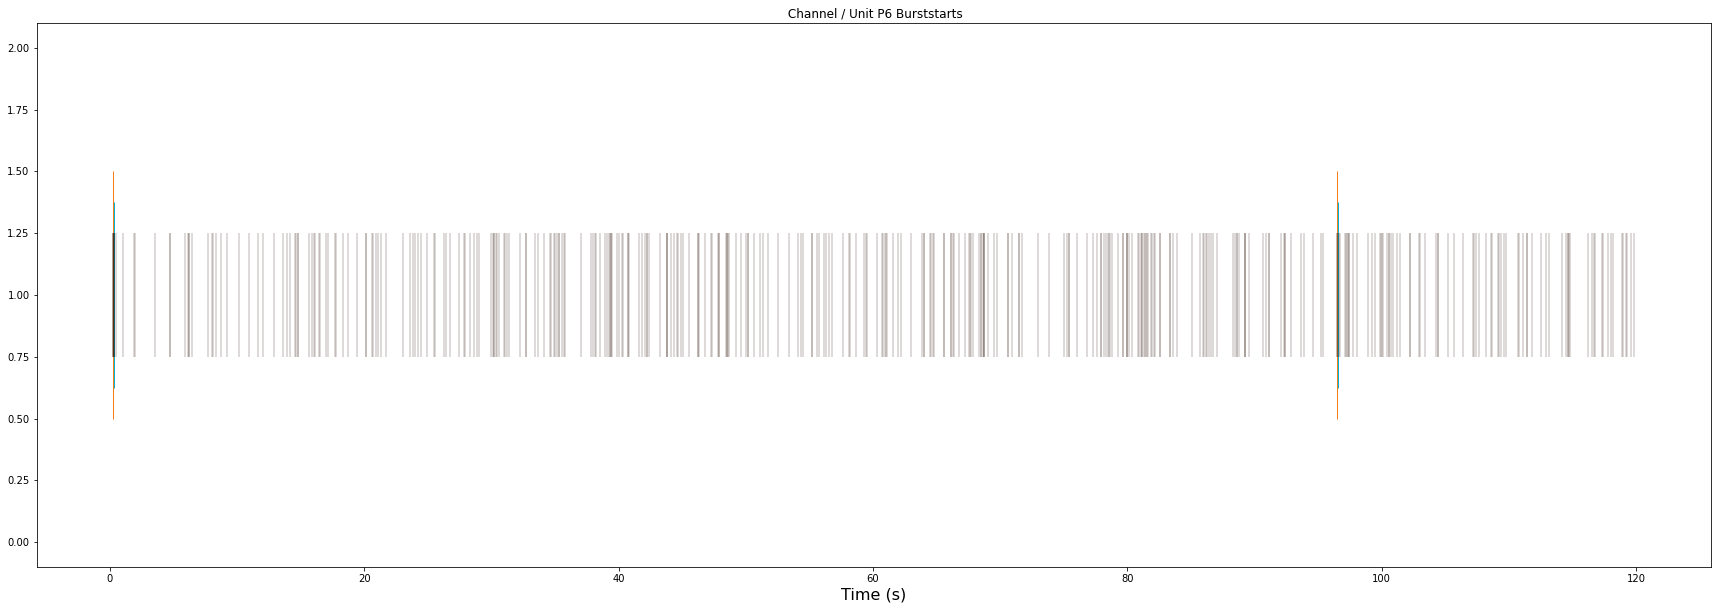

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H7 Burststarts')

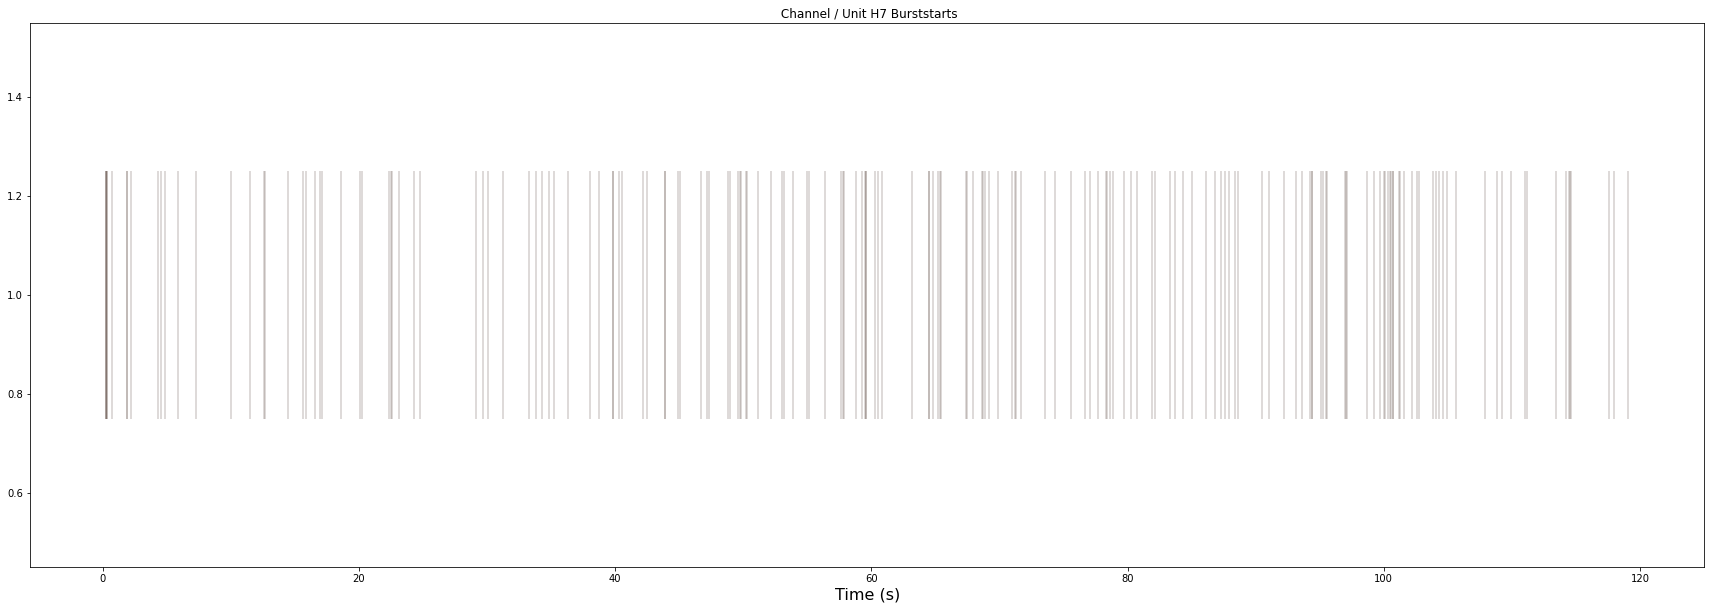

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P4 Burststarts')

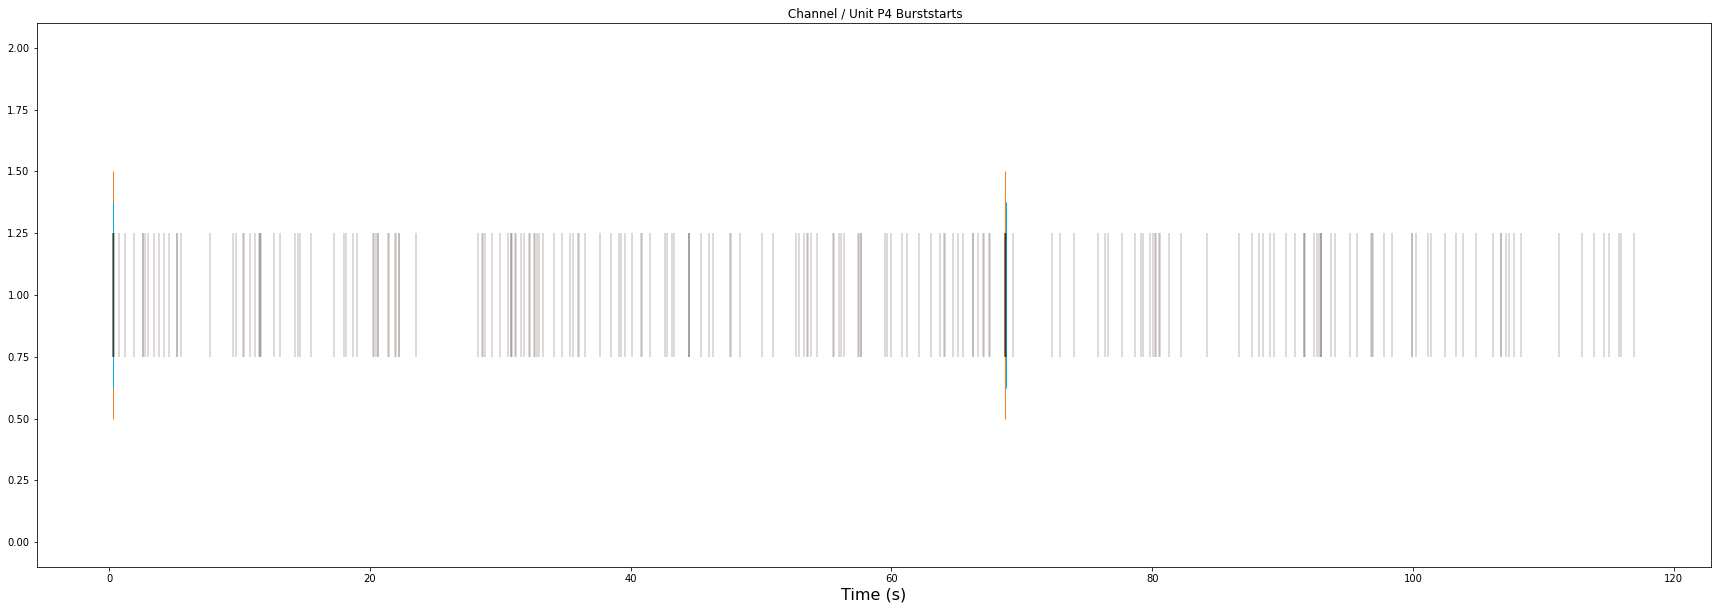

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F7 Burststarts')

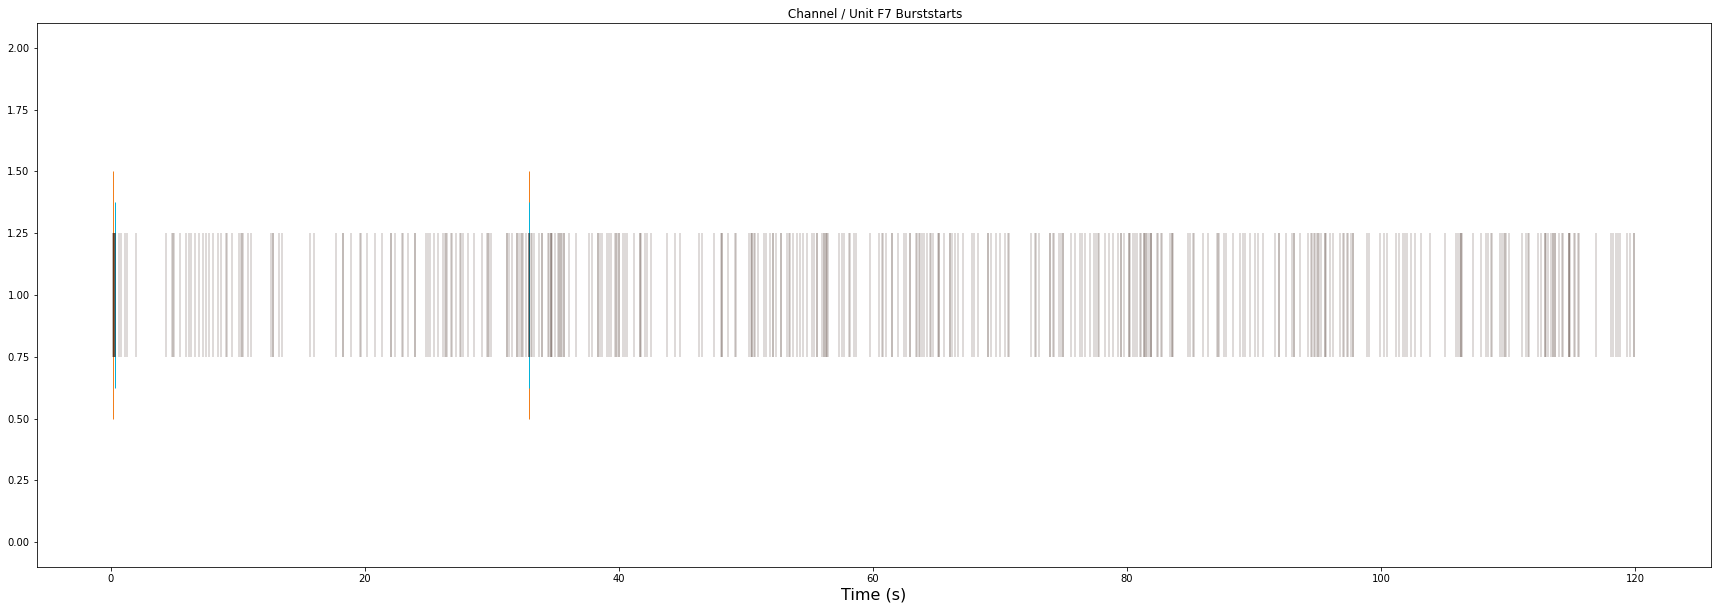

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E12 Burststarts')

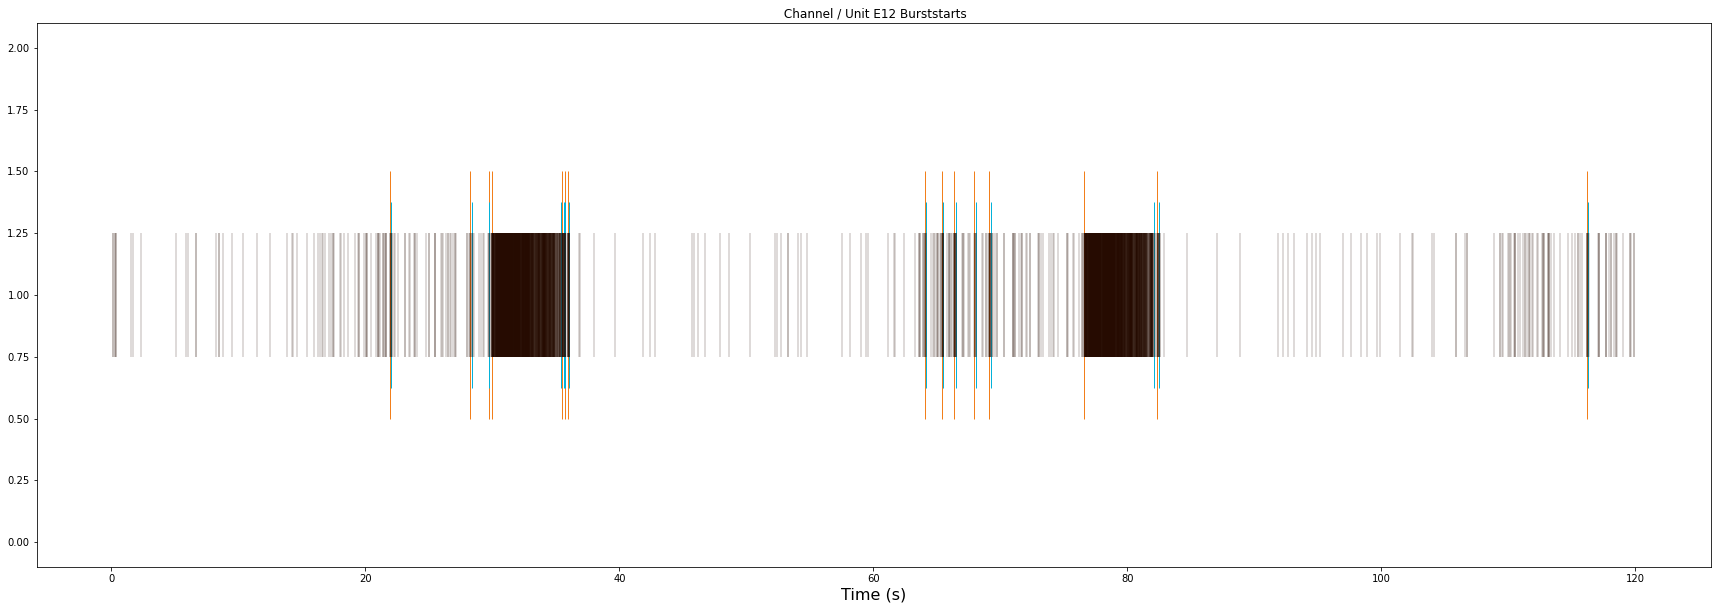

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E13 Burststarts')

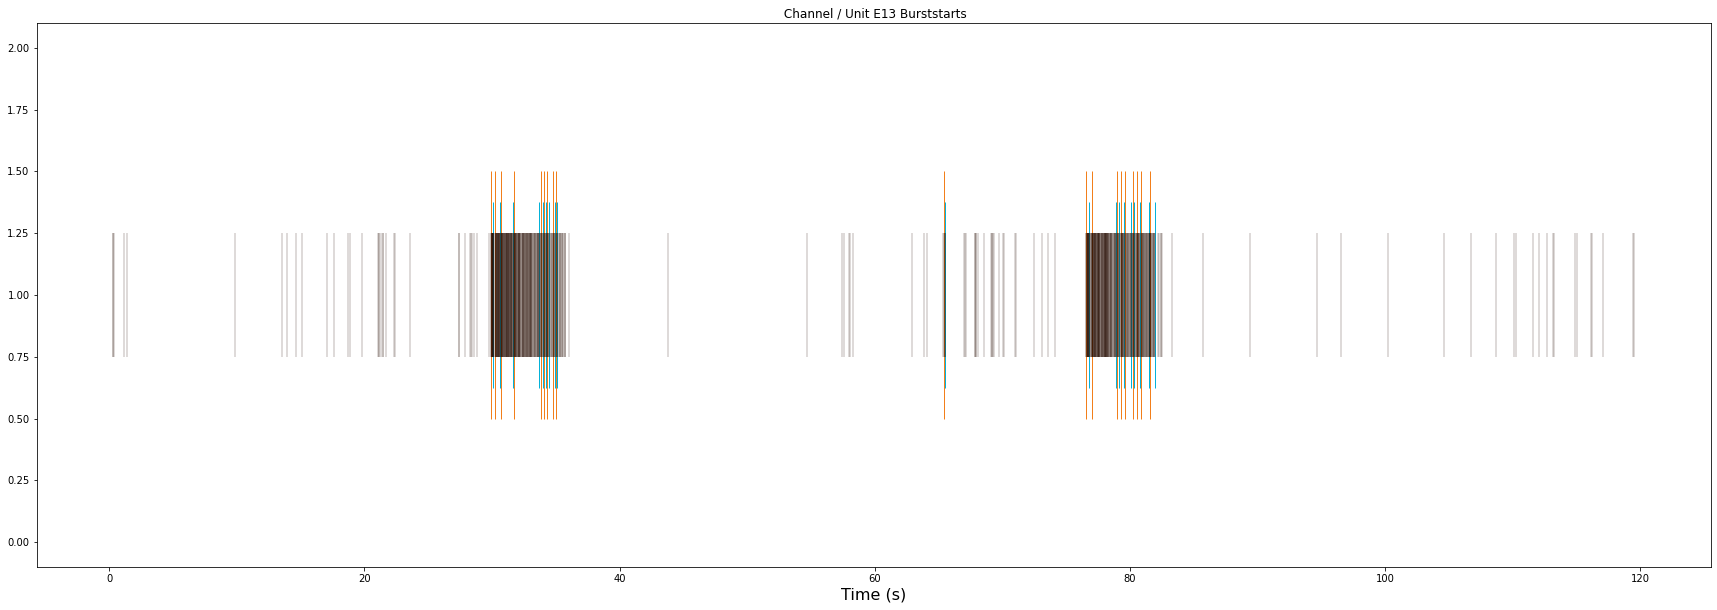

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G12 Burststarts')

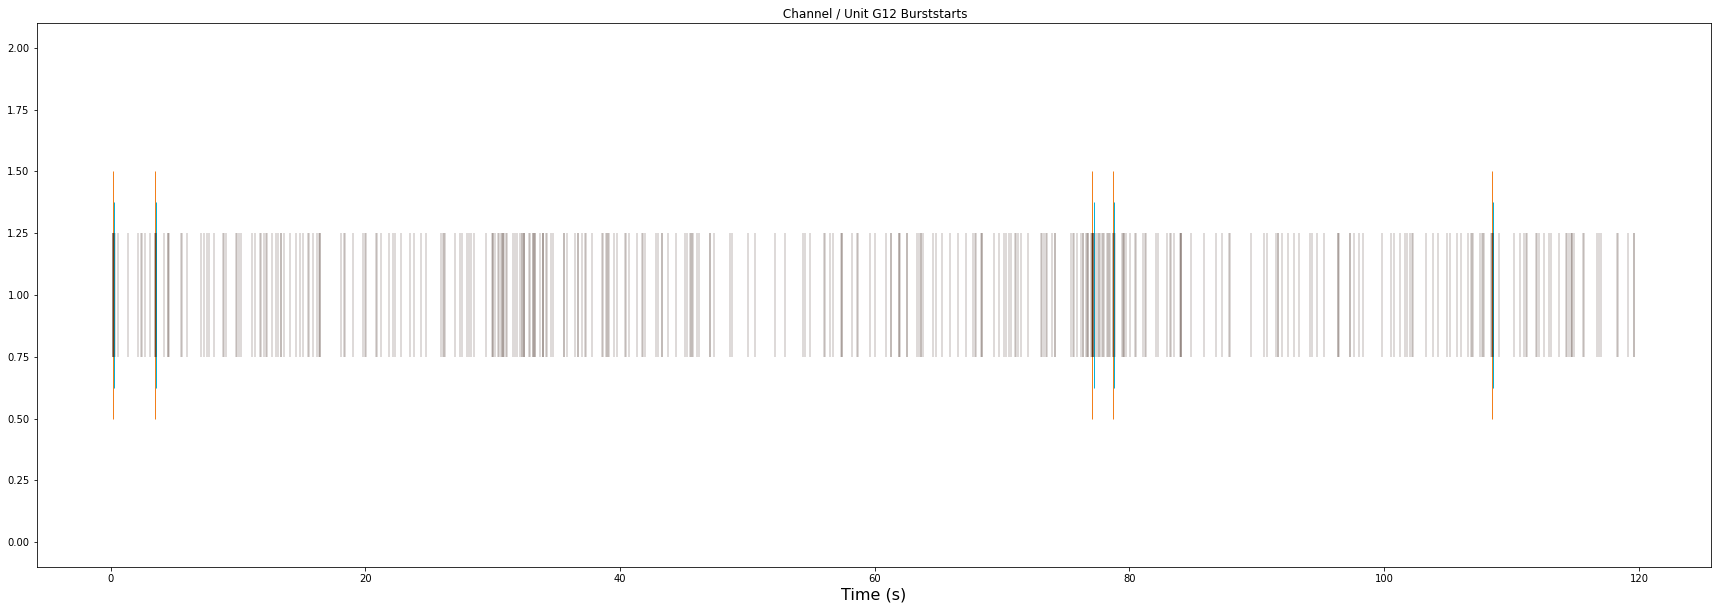

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A7 Burststarts')

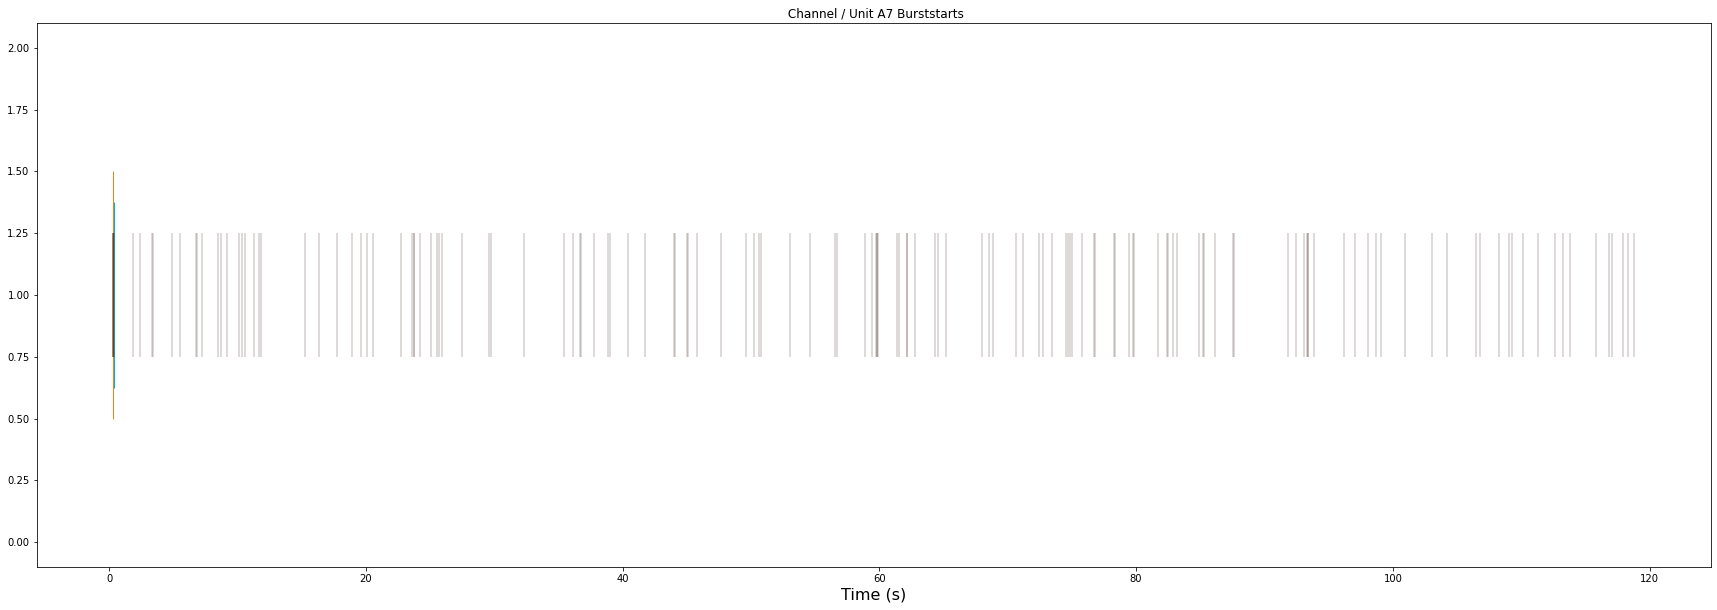

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C13 Burststarts')

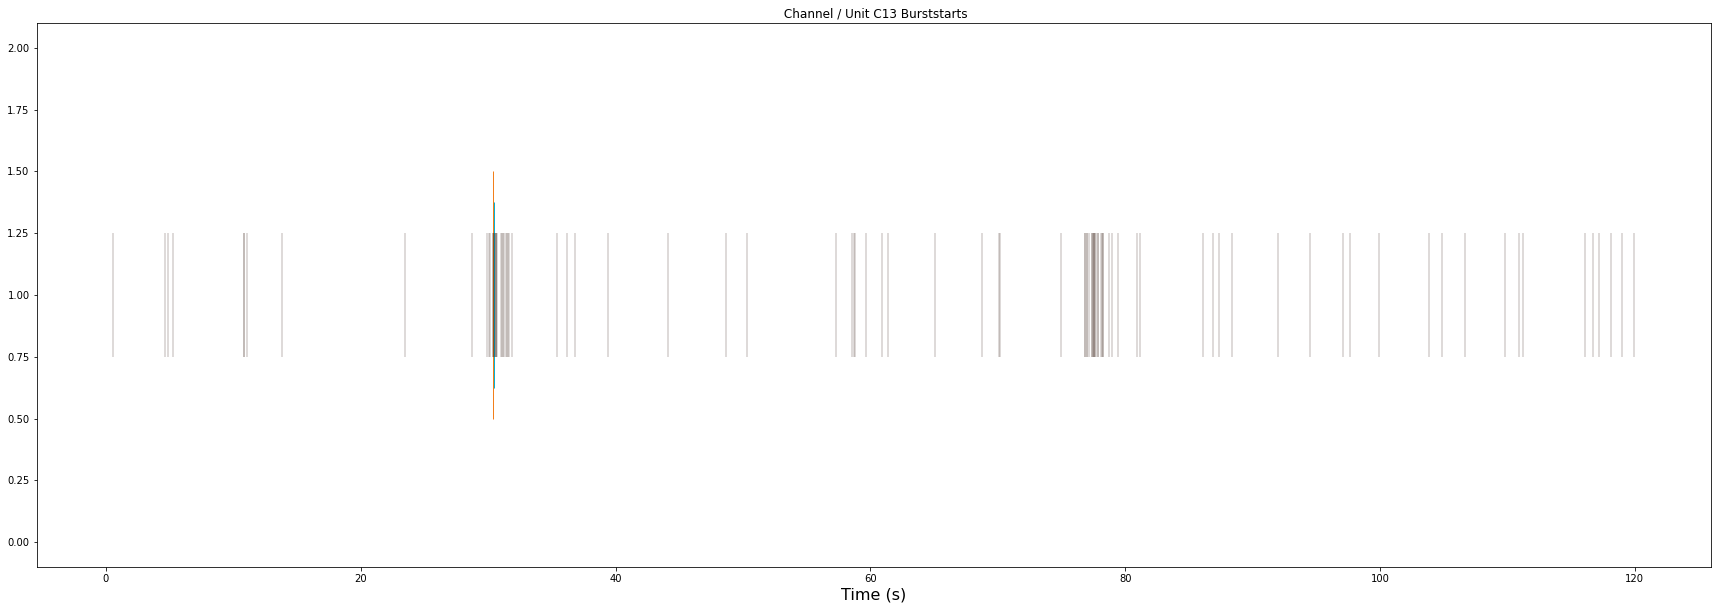

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B7 Burststarts')

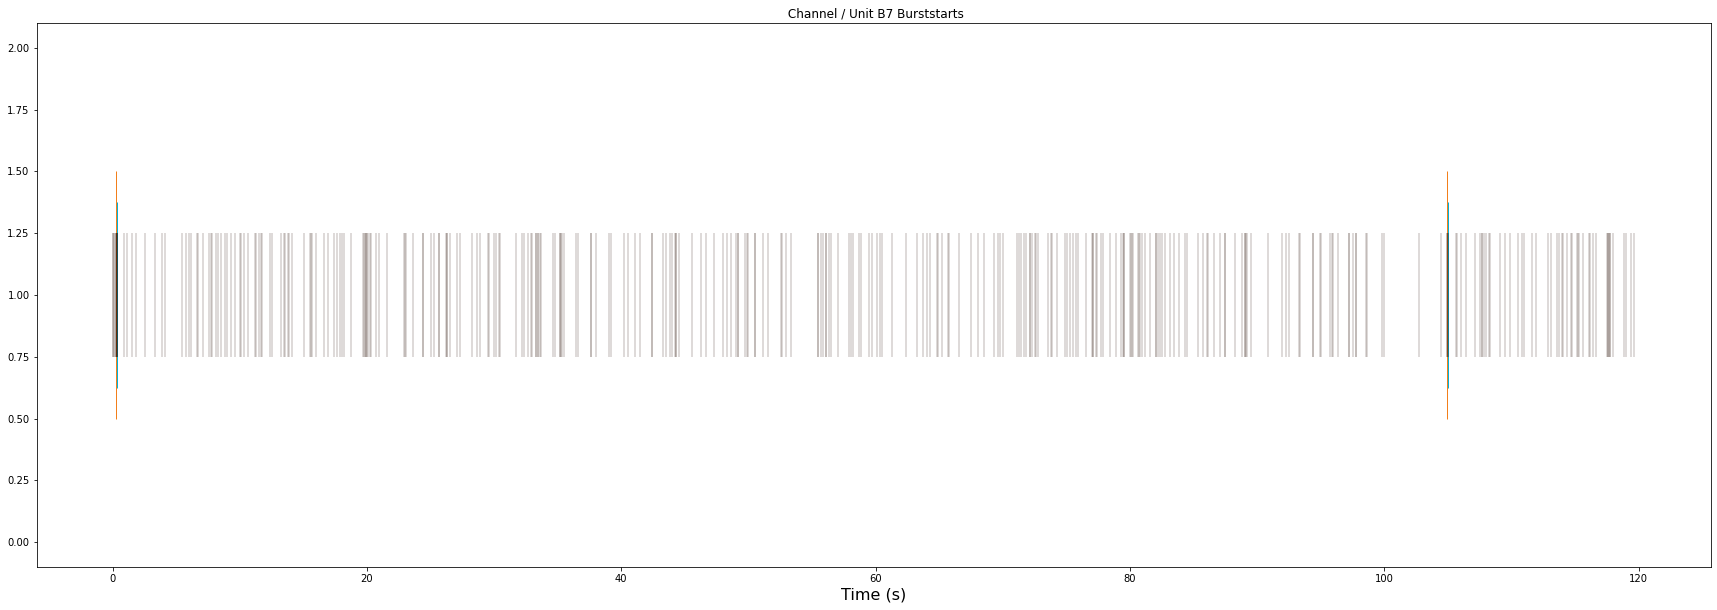

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B13 Burststarts')

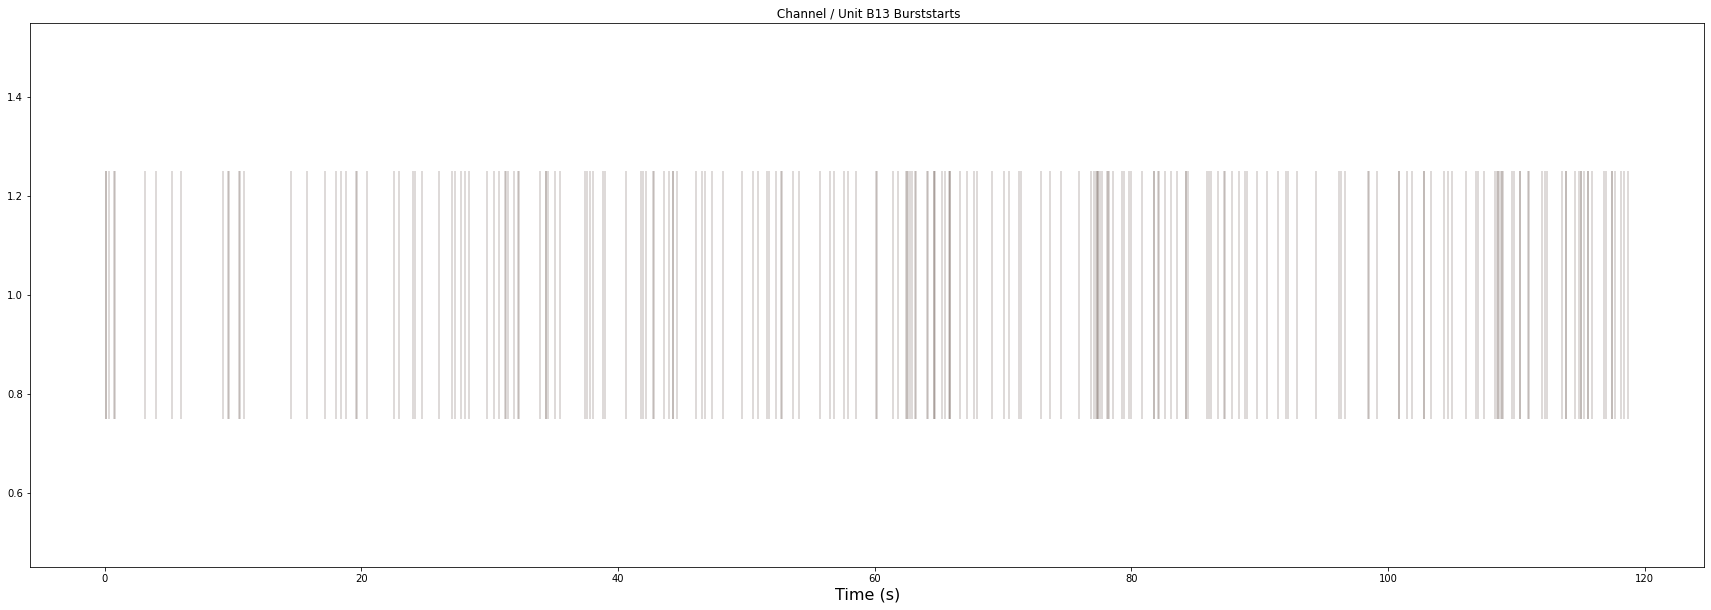

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E5 Burststarts')

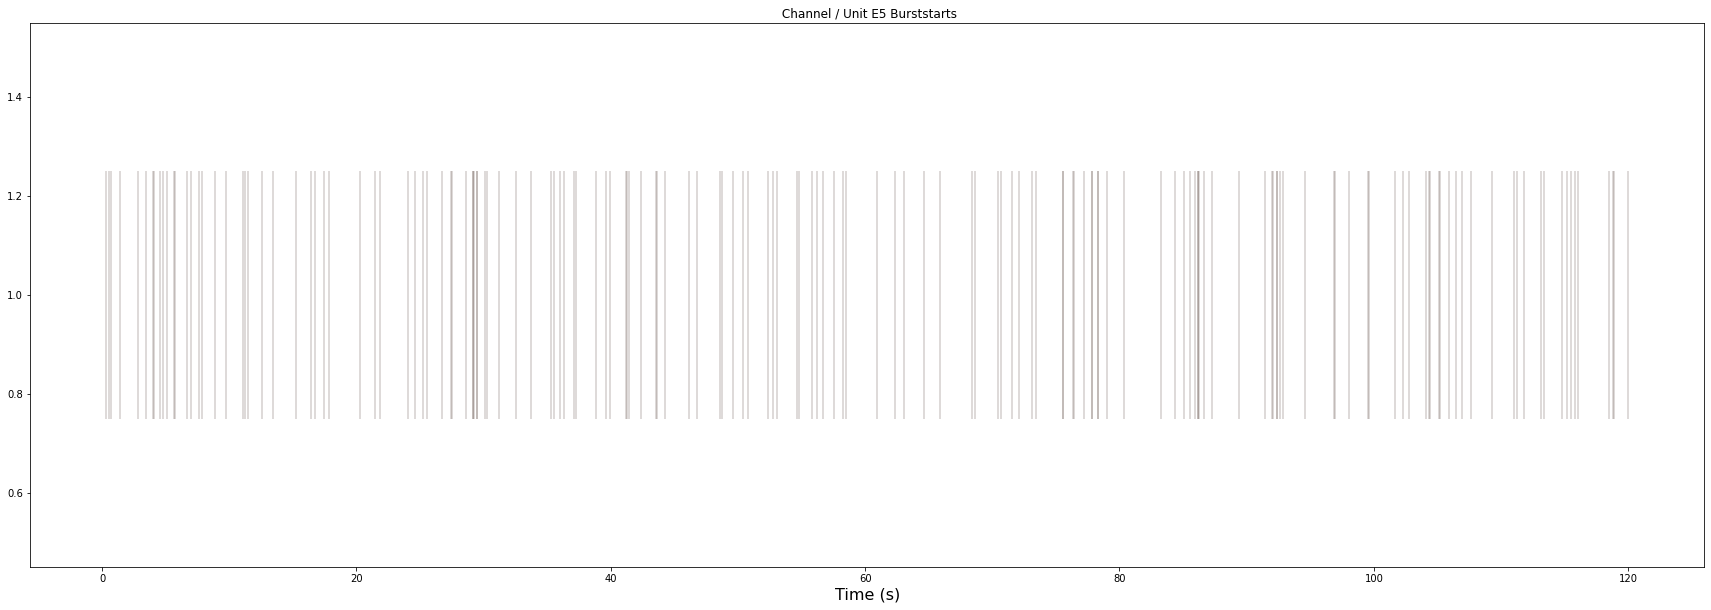

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P5 Burststarts')

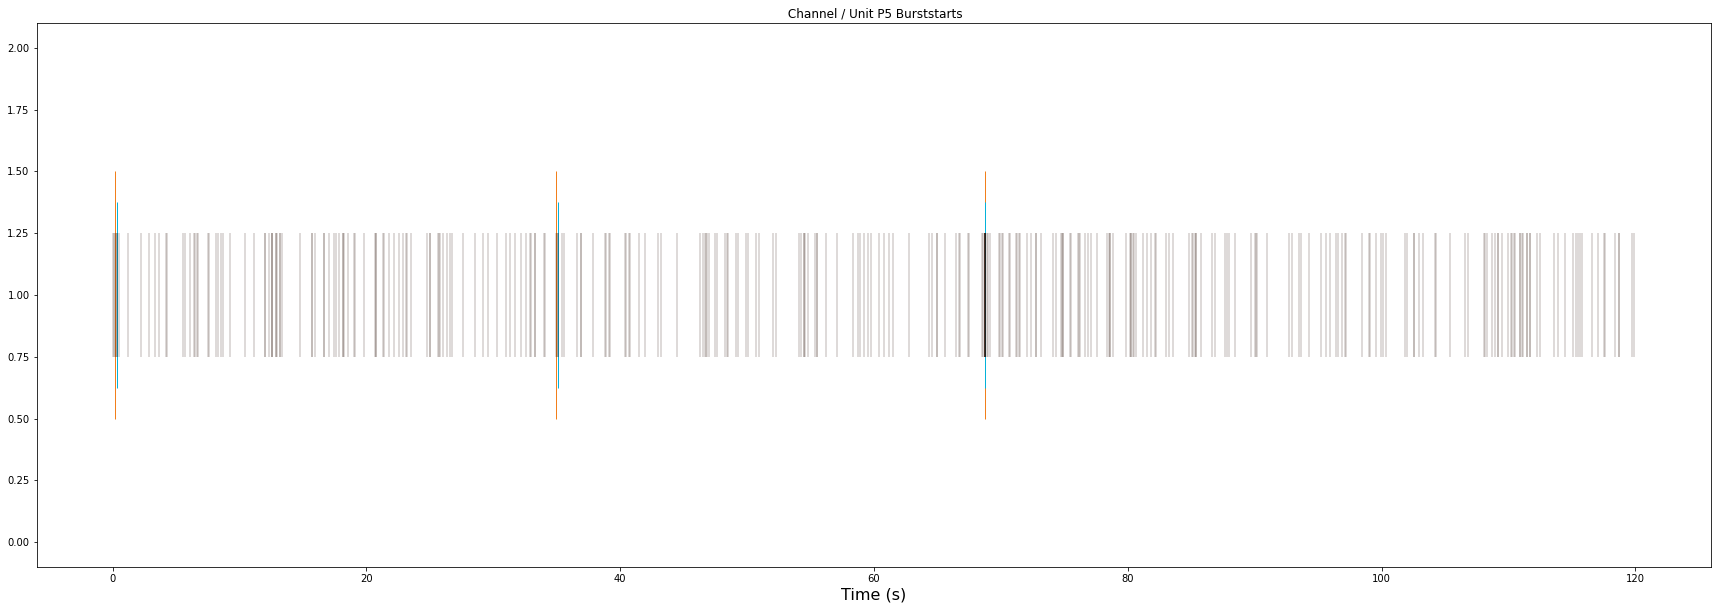

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L7 Burststarts')

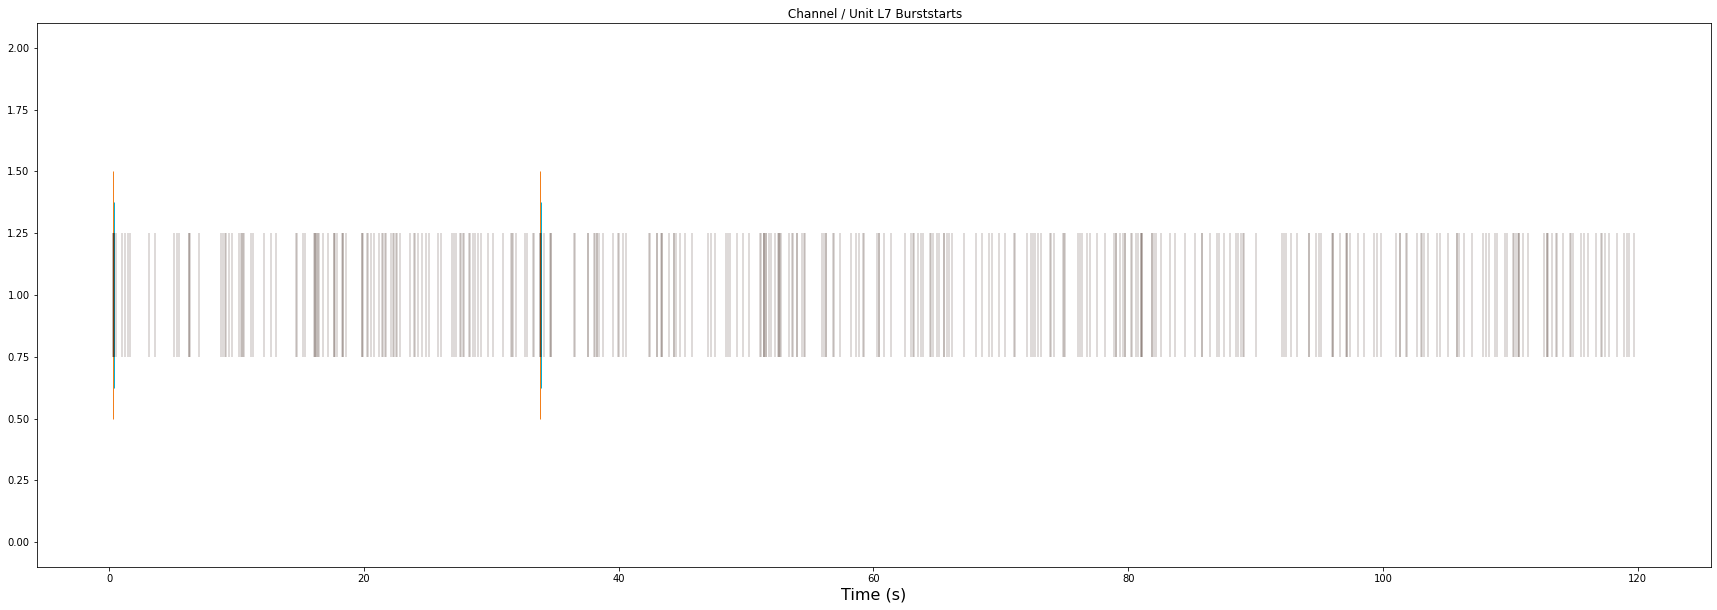

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I1 Burststarts')

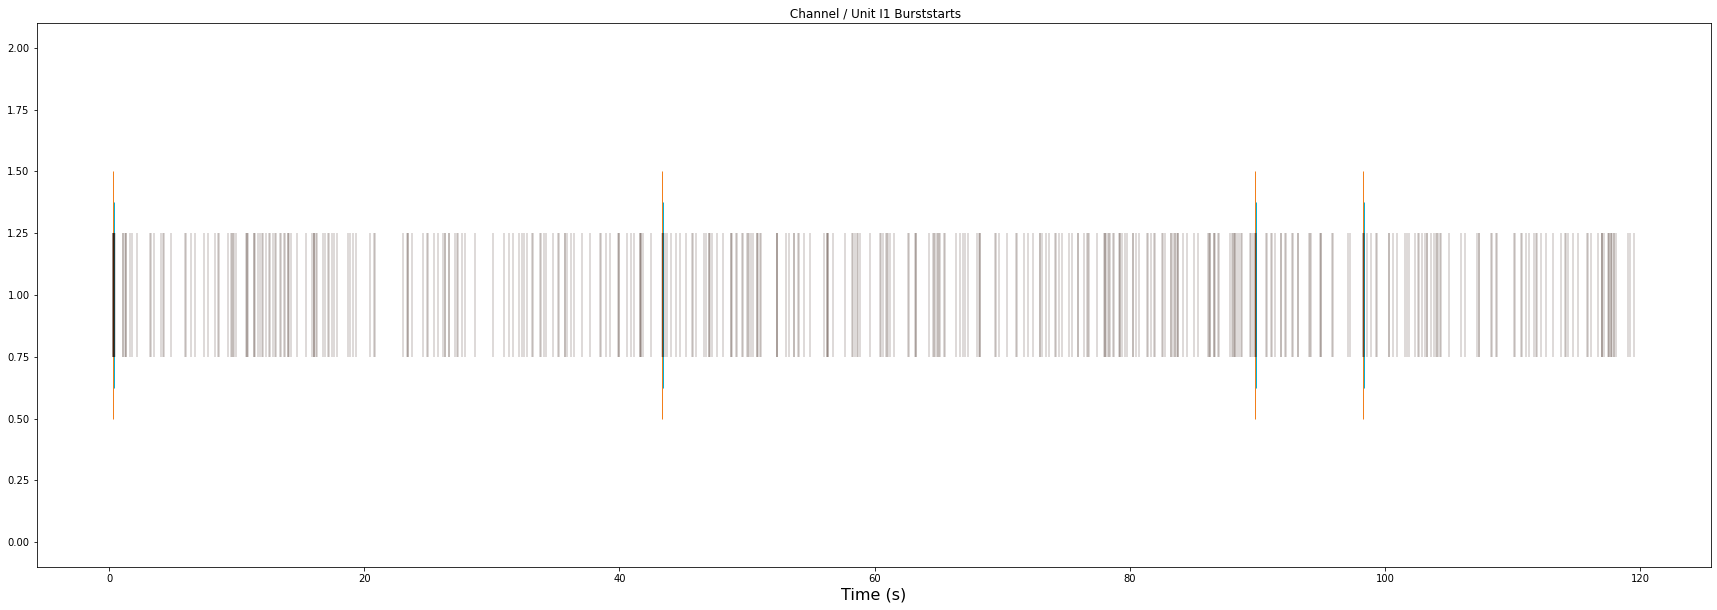

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I14 Burststarts')

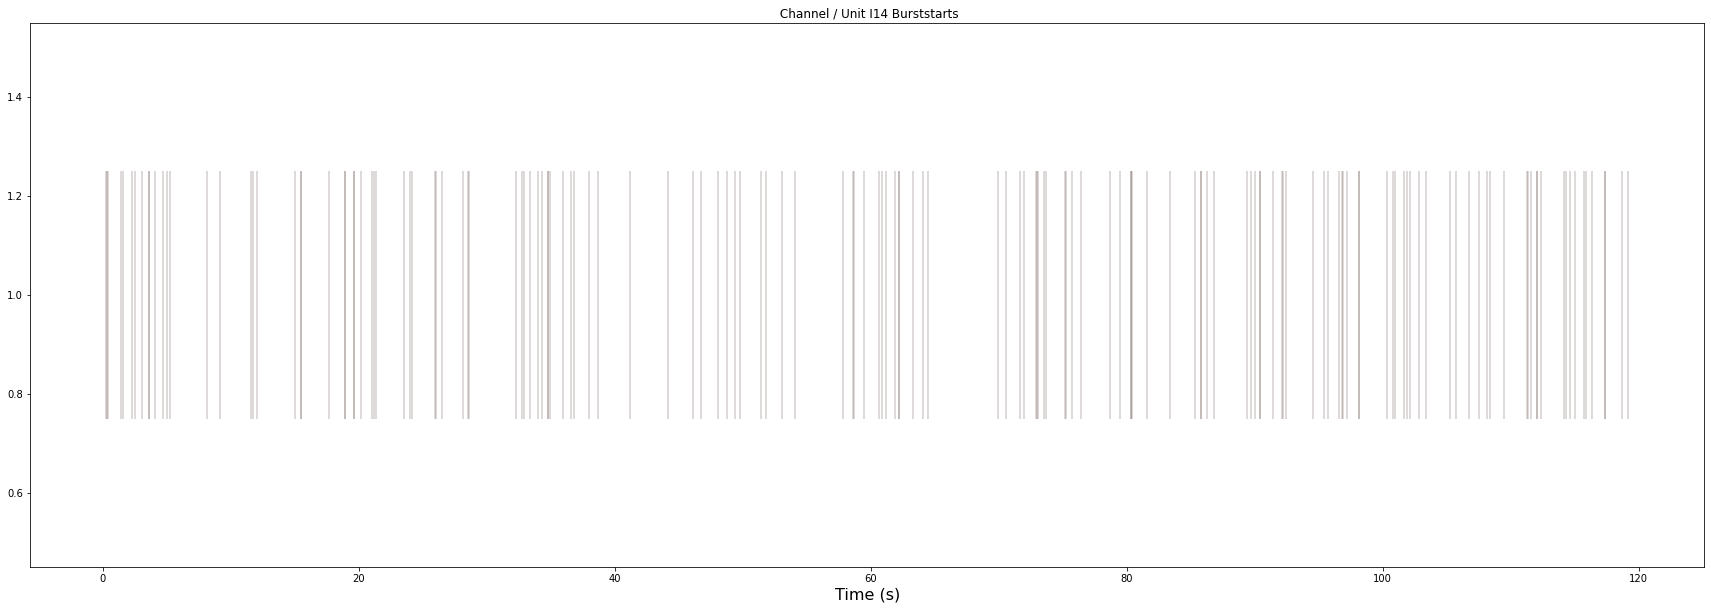

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P1 Burststarts')

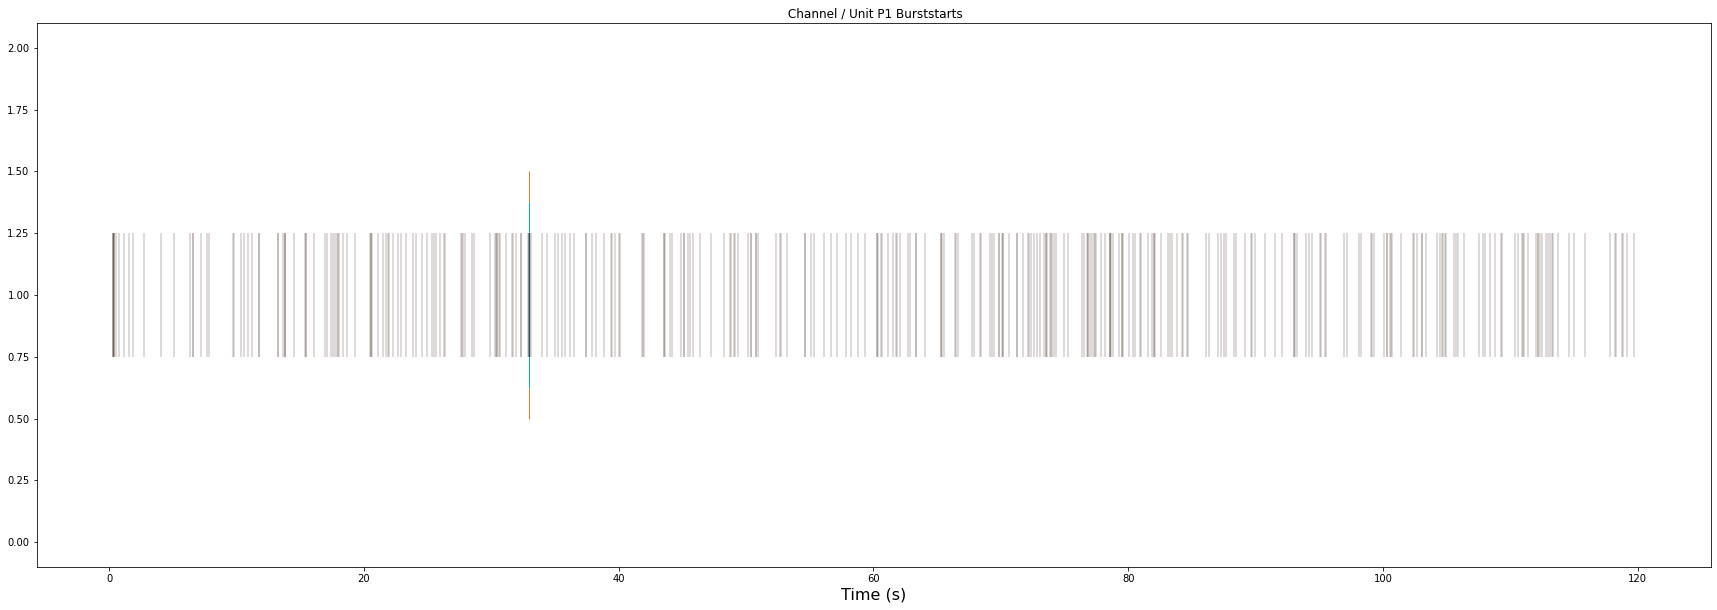

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G2 Burststarts')

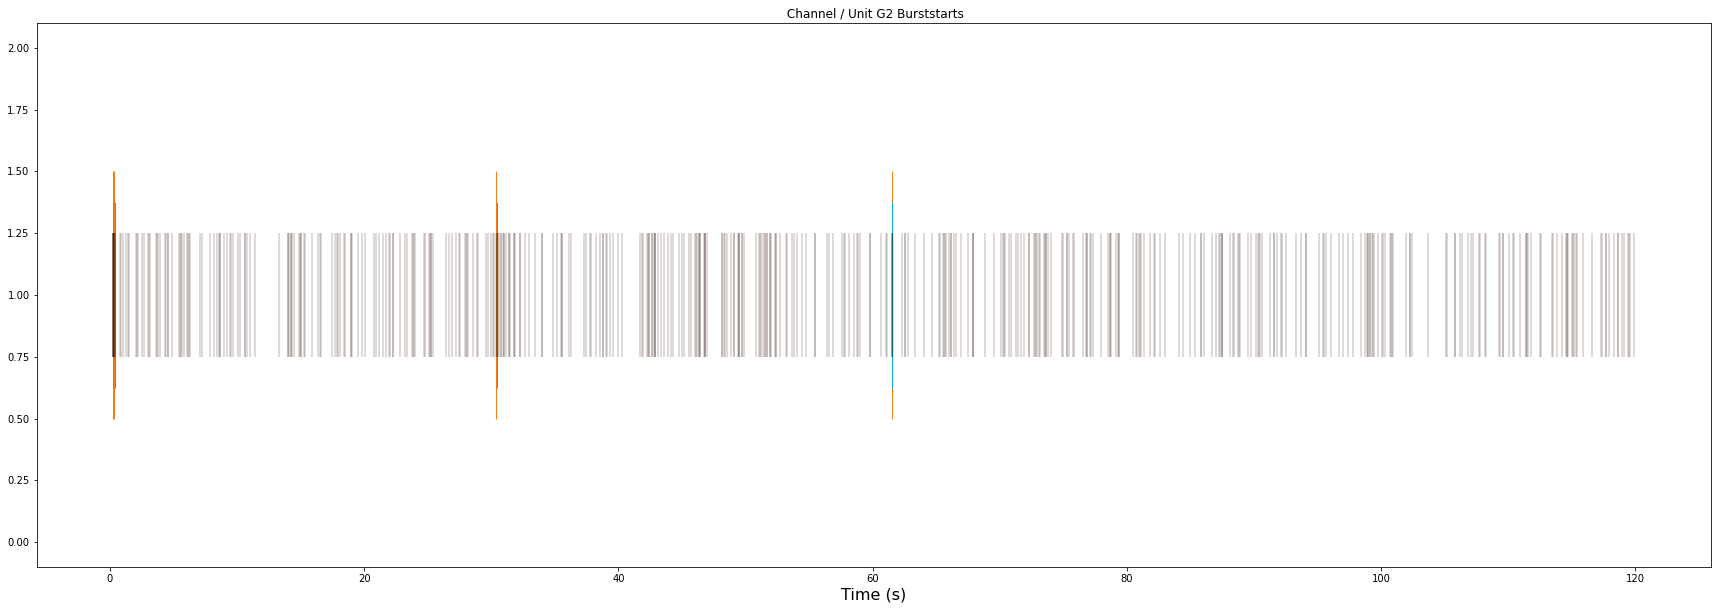

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P2 Burststarts')

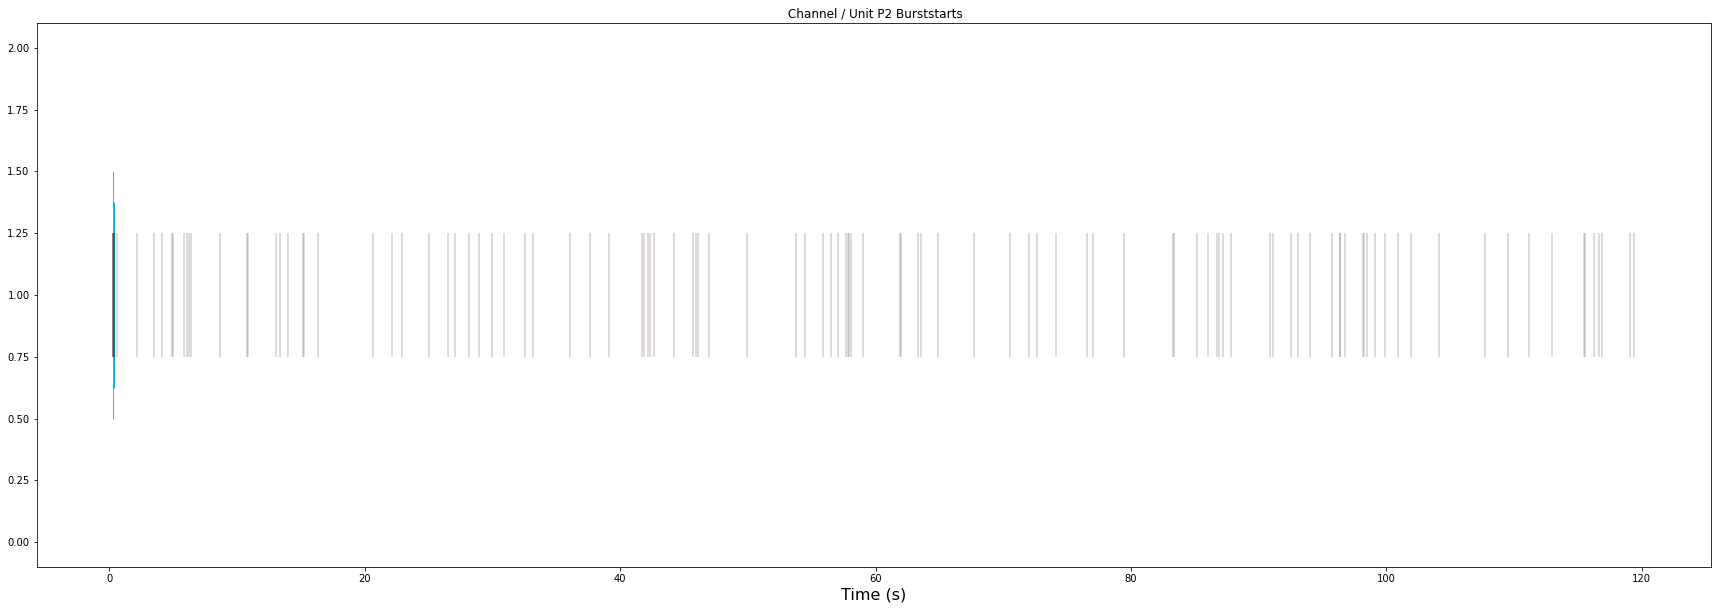

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B12 Burststarts')

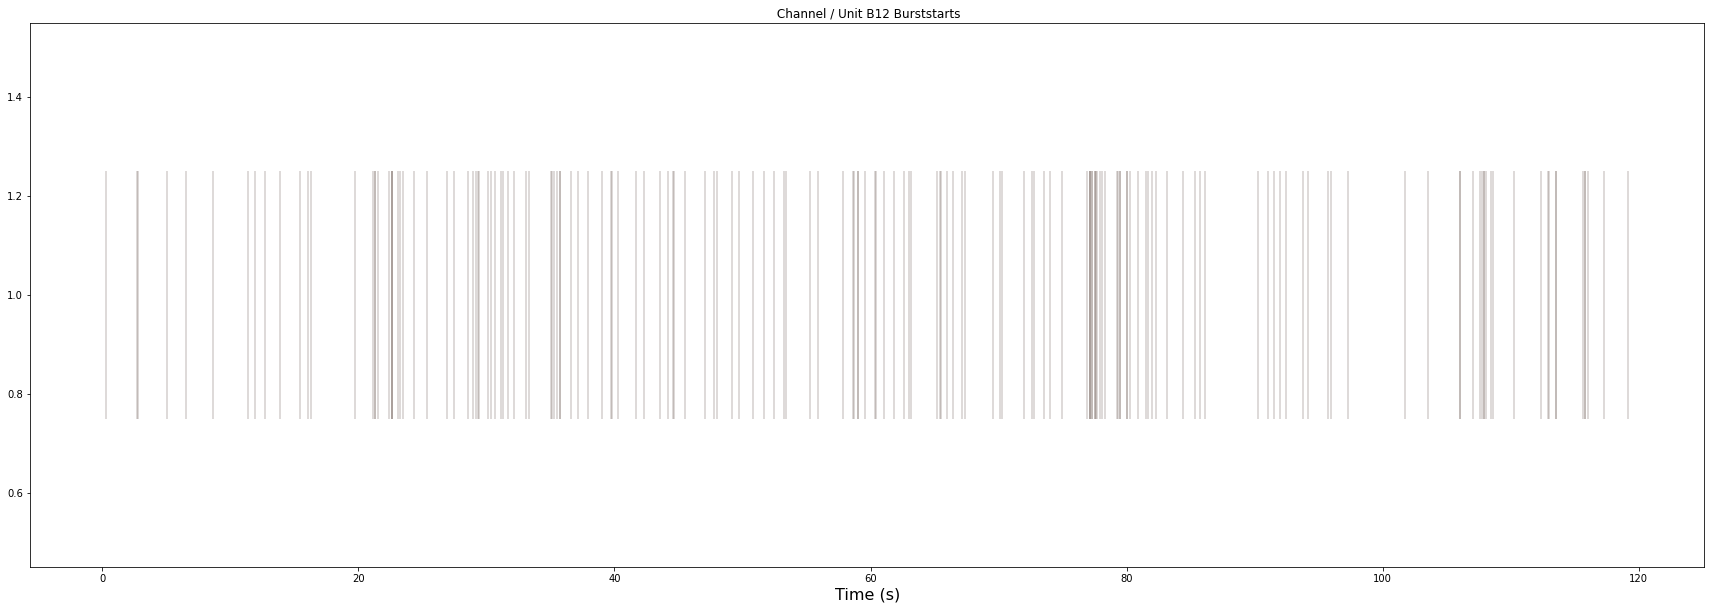

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H16 Burststarts')

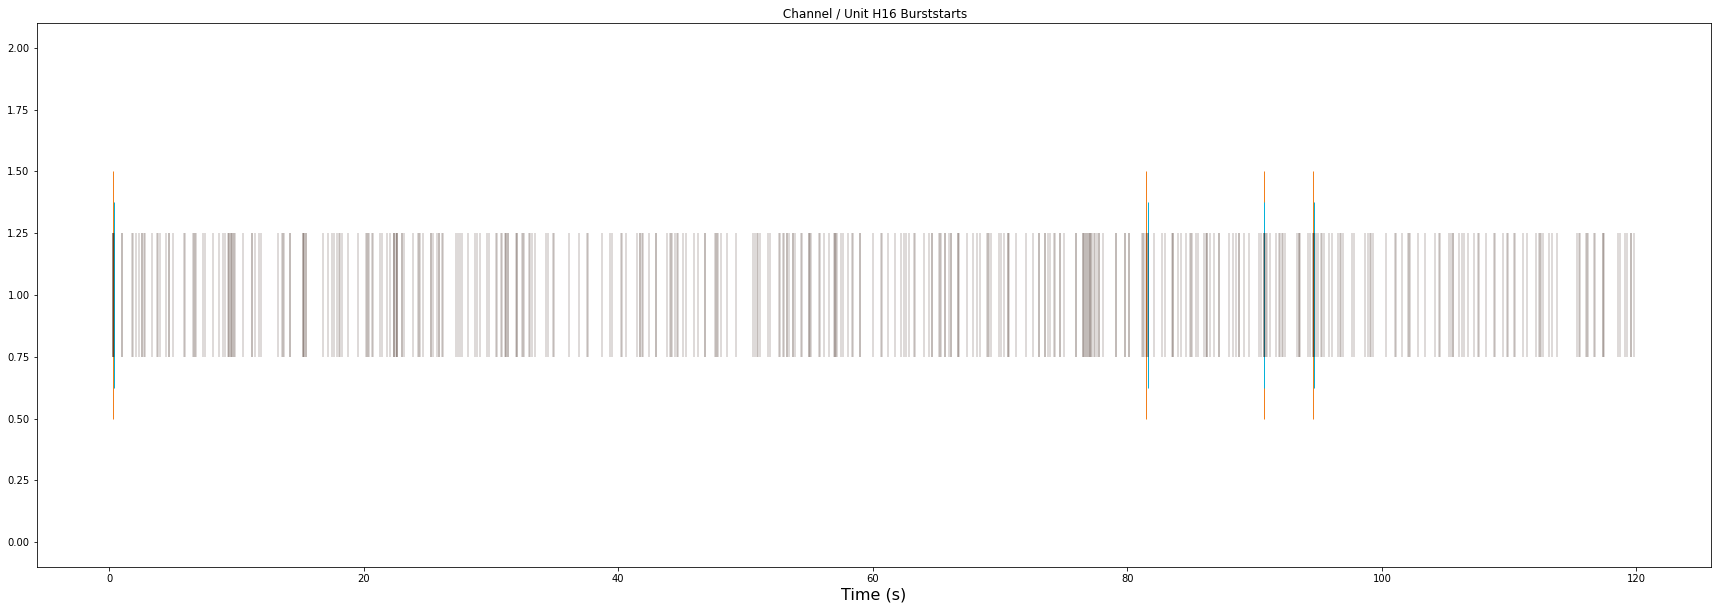

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D7 Burststarts')

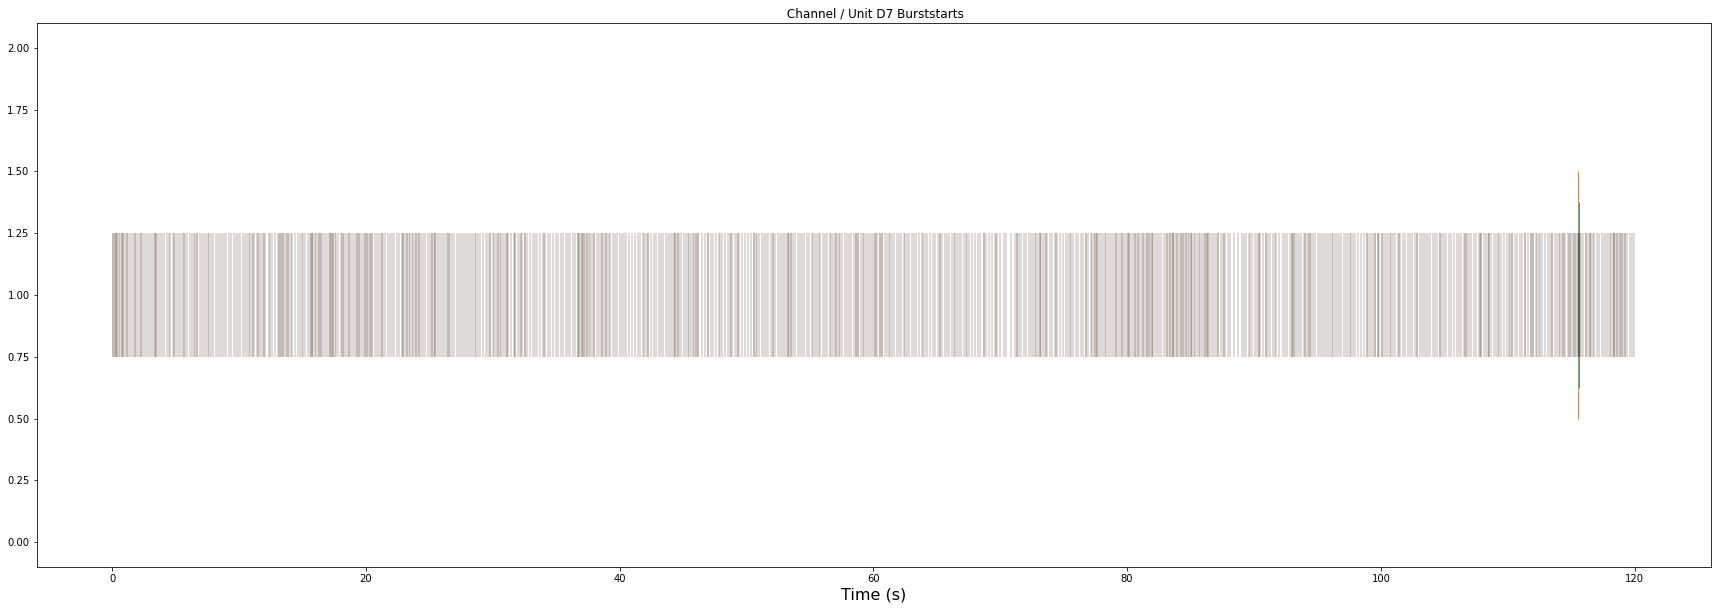

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D14 Burststarts')

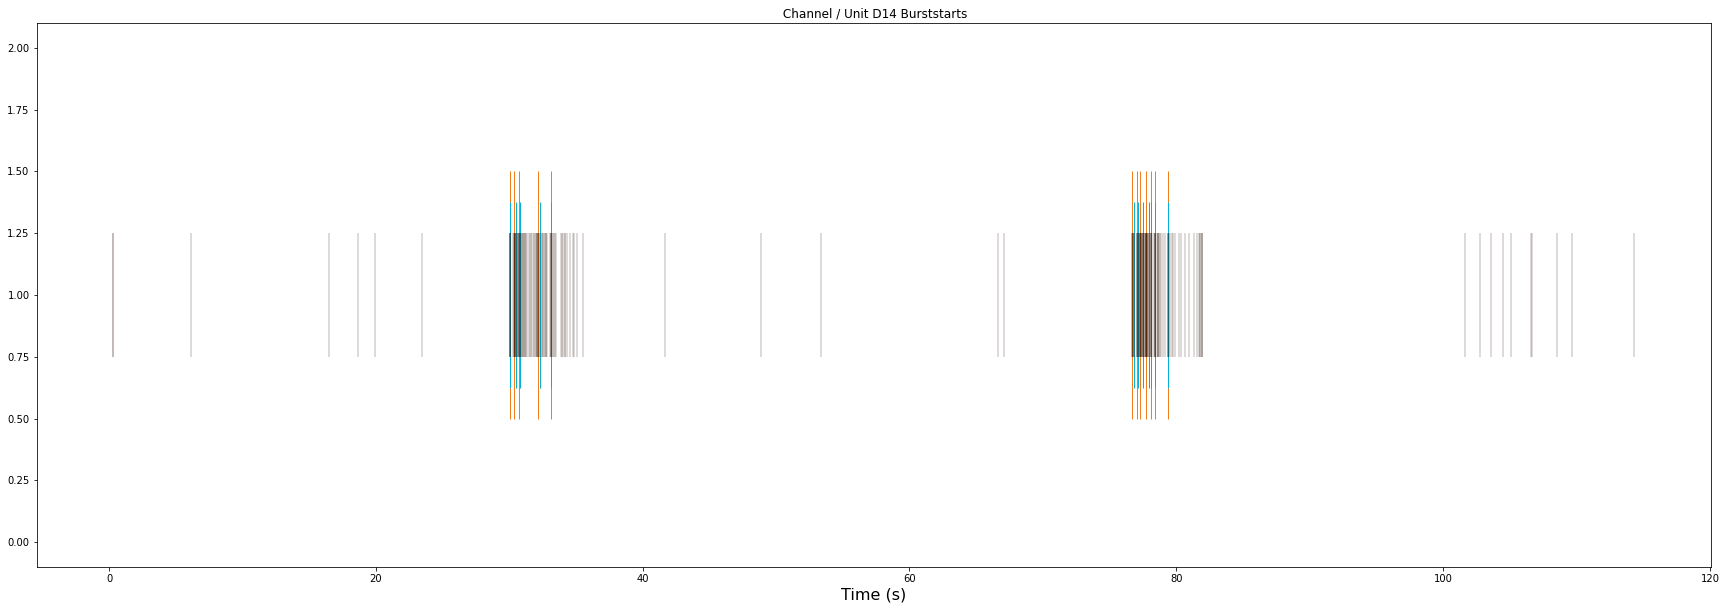

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O15 Burststarts')

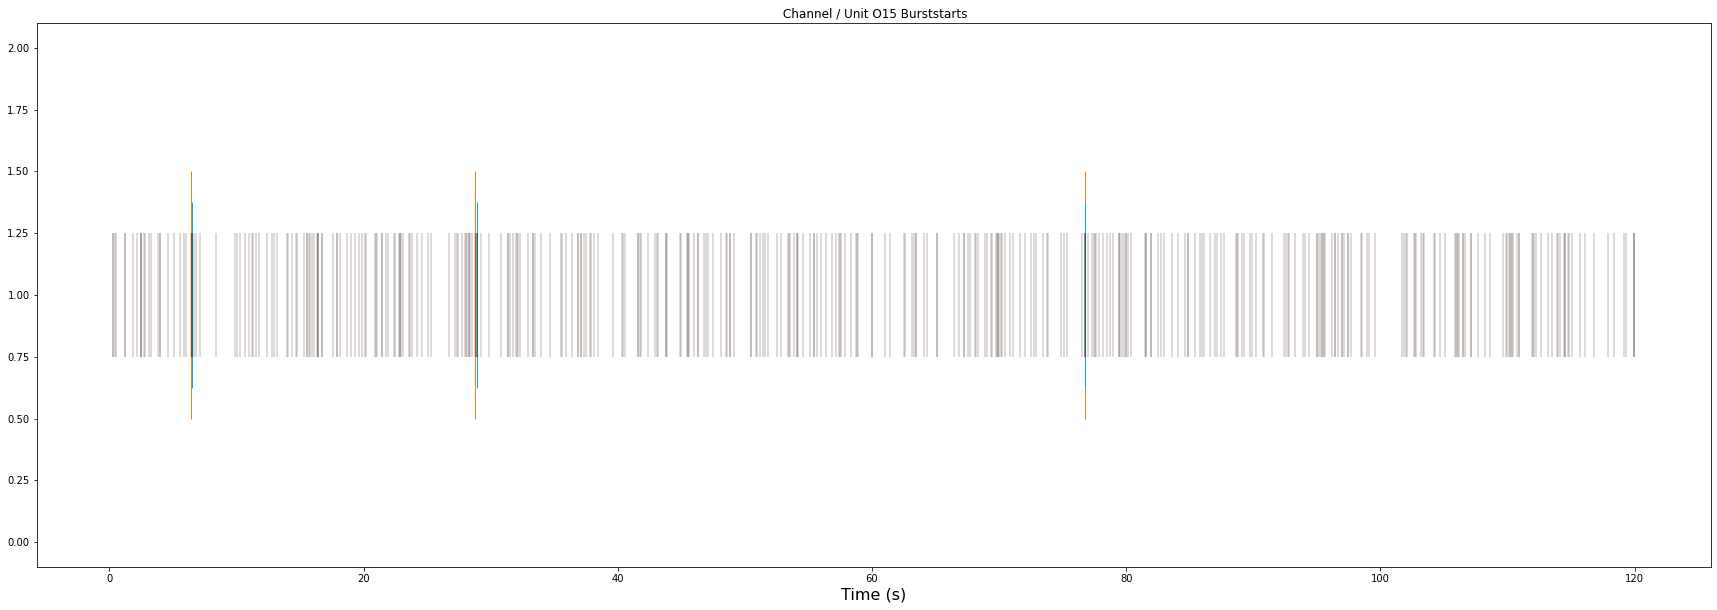

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D2 Burststarts')

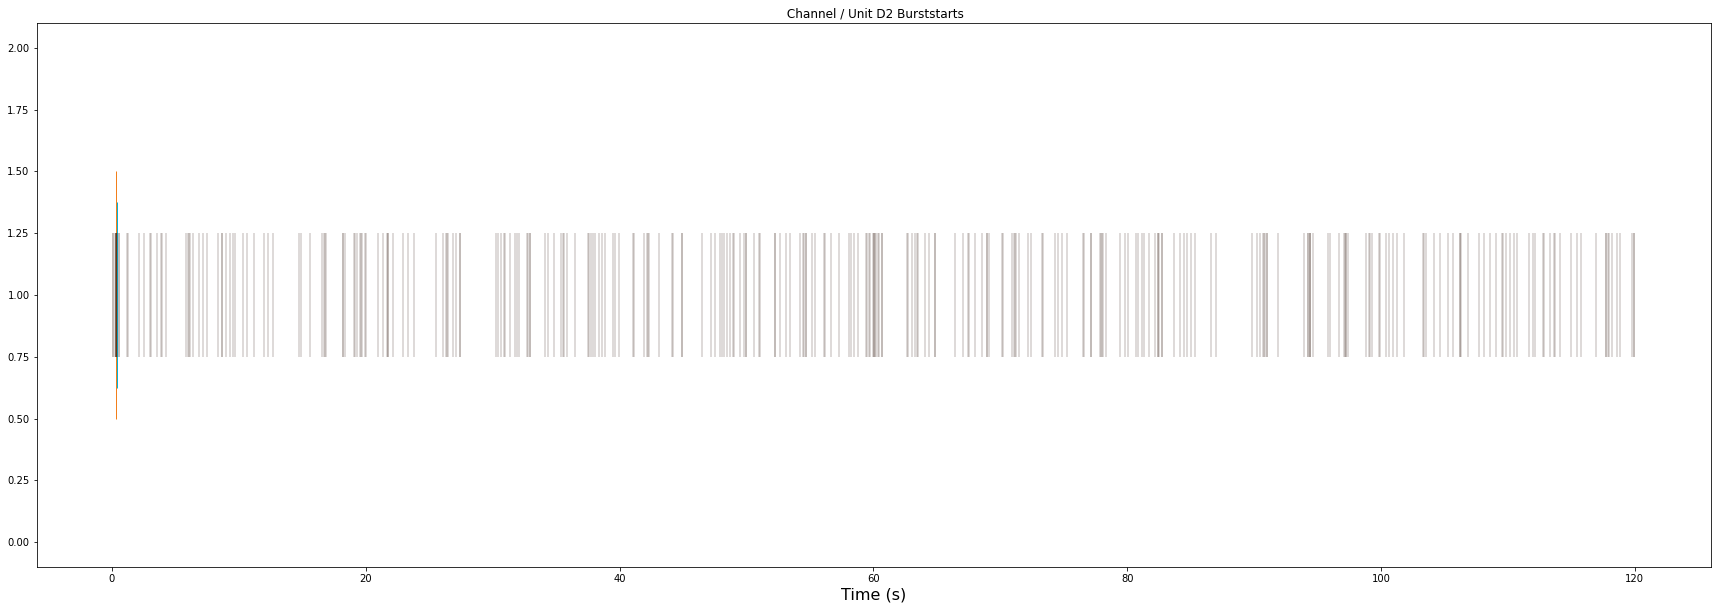

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D1 Burststarts')

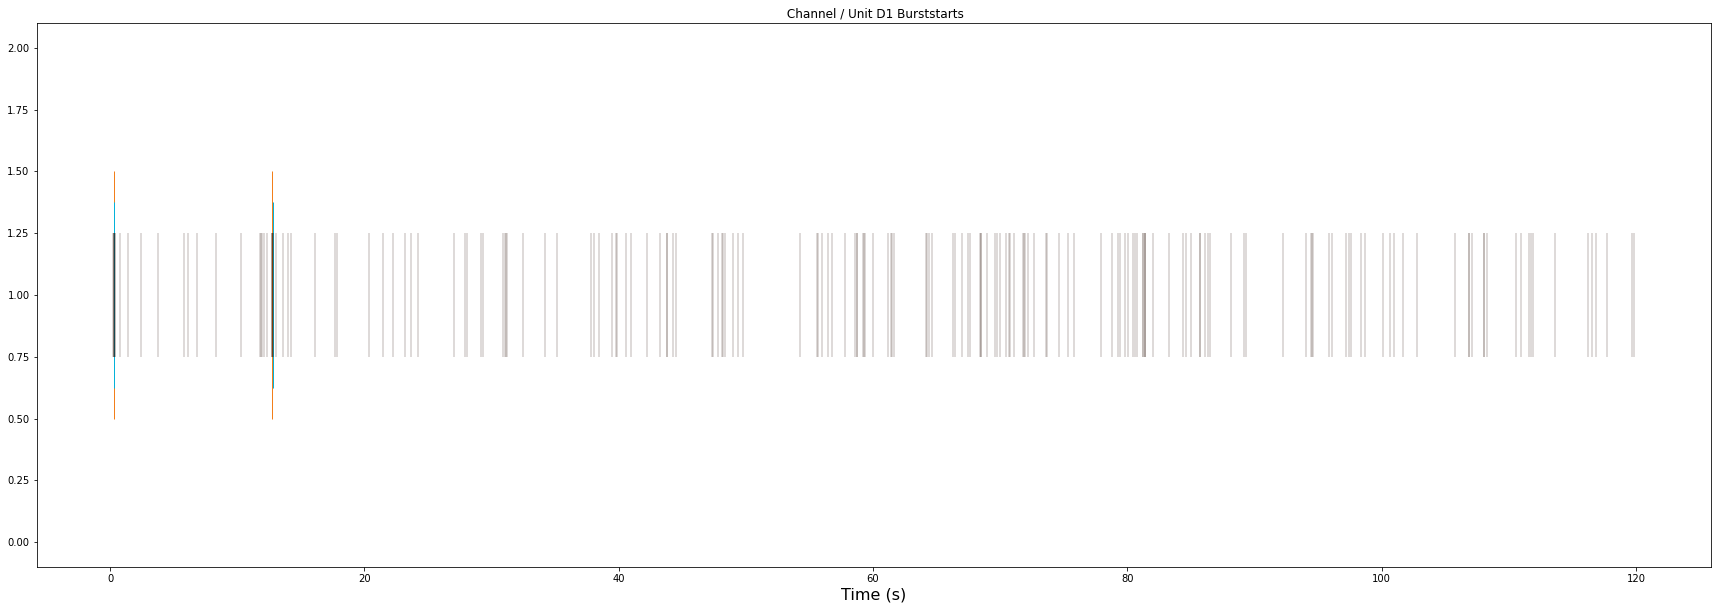

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K7 Burststarts')

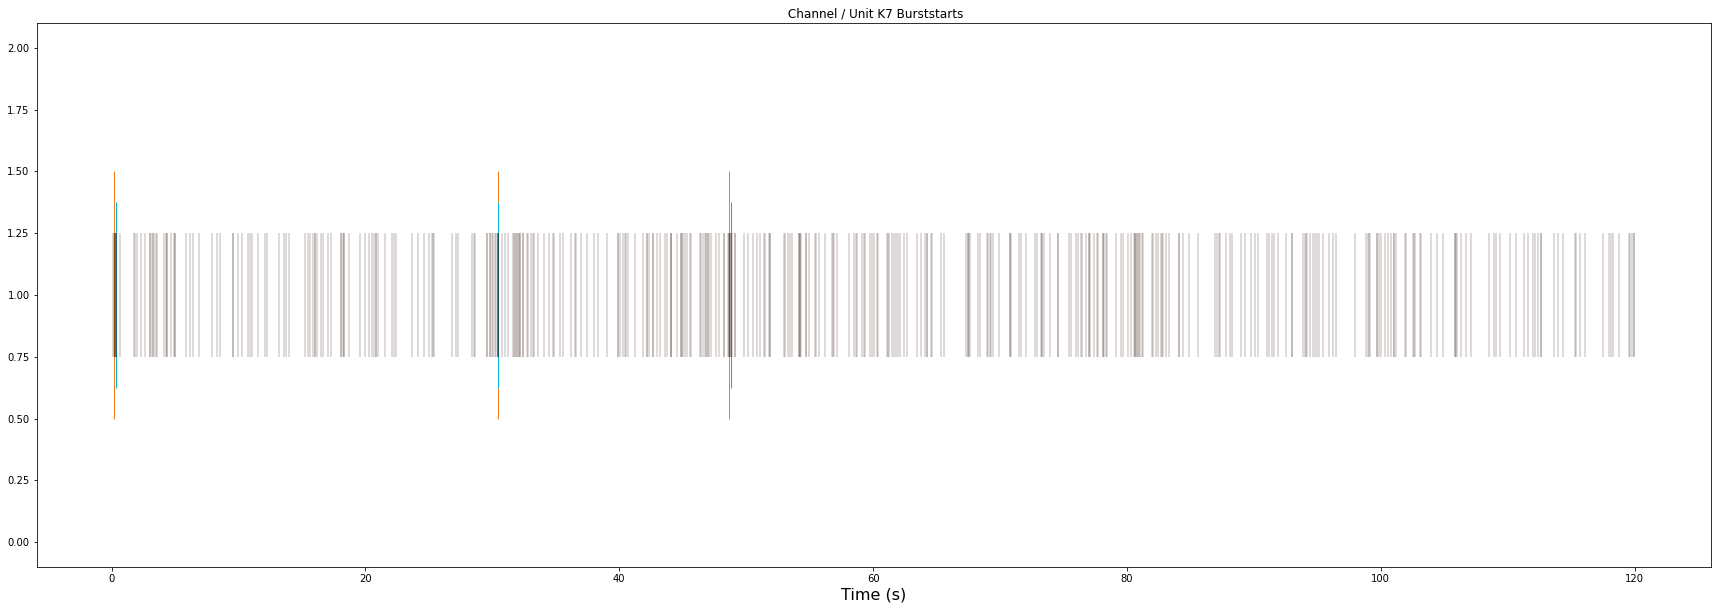

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O10 Burststarts')

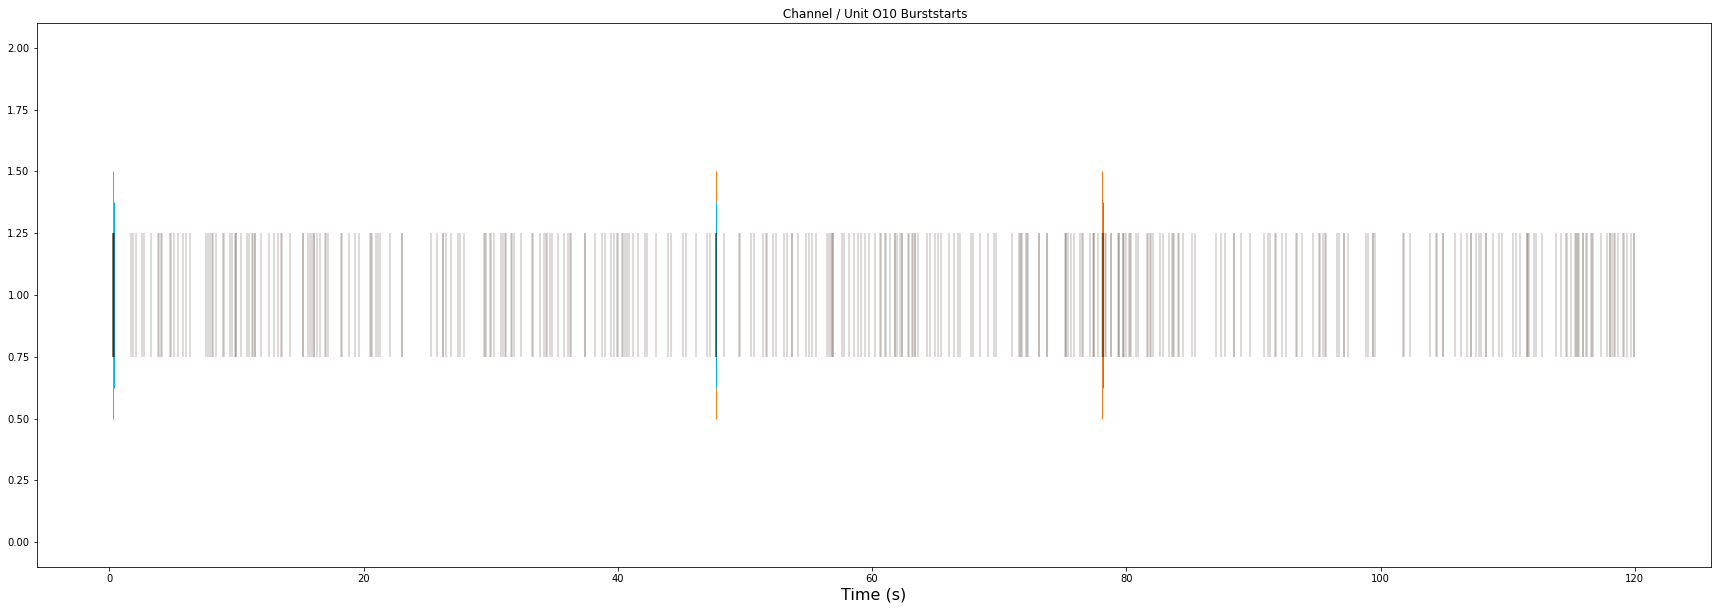

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R2 Burststarts')

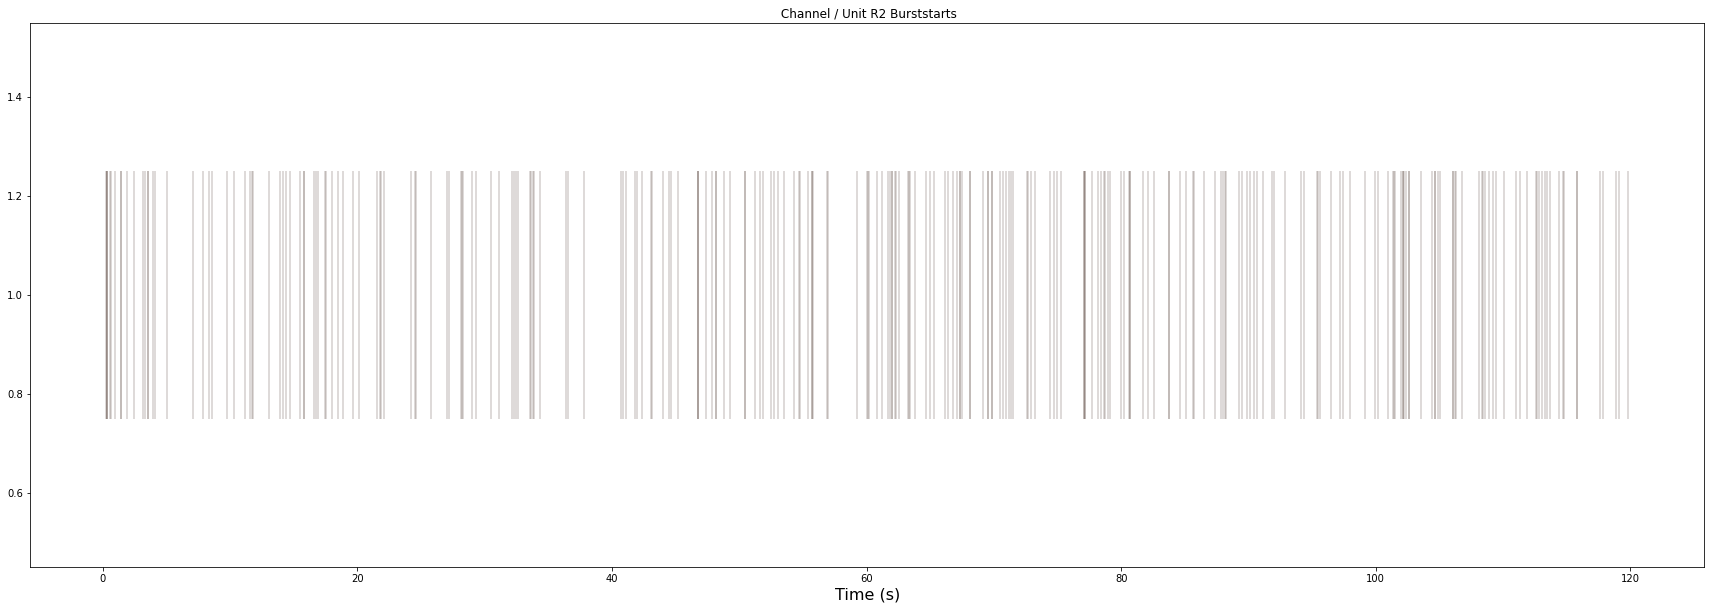

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G4 Burststarts')

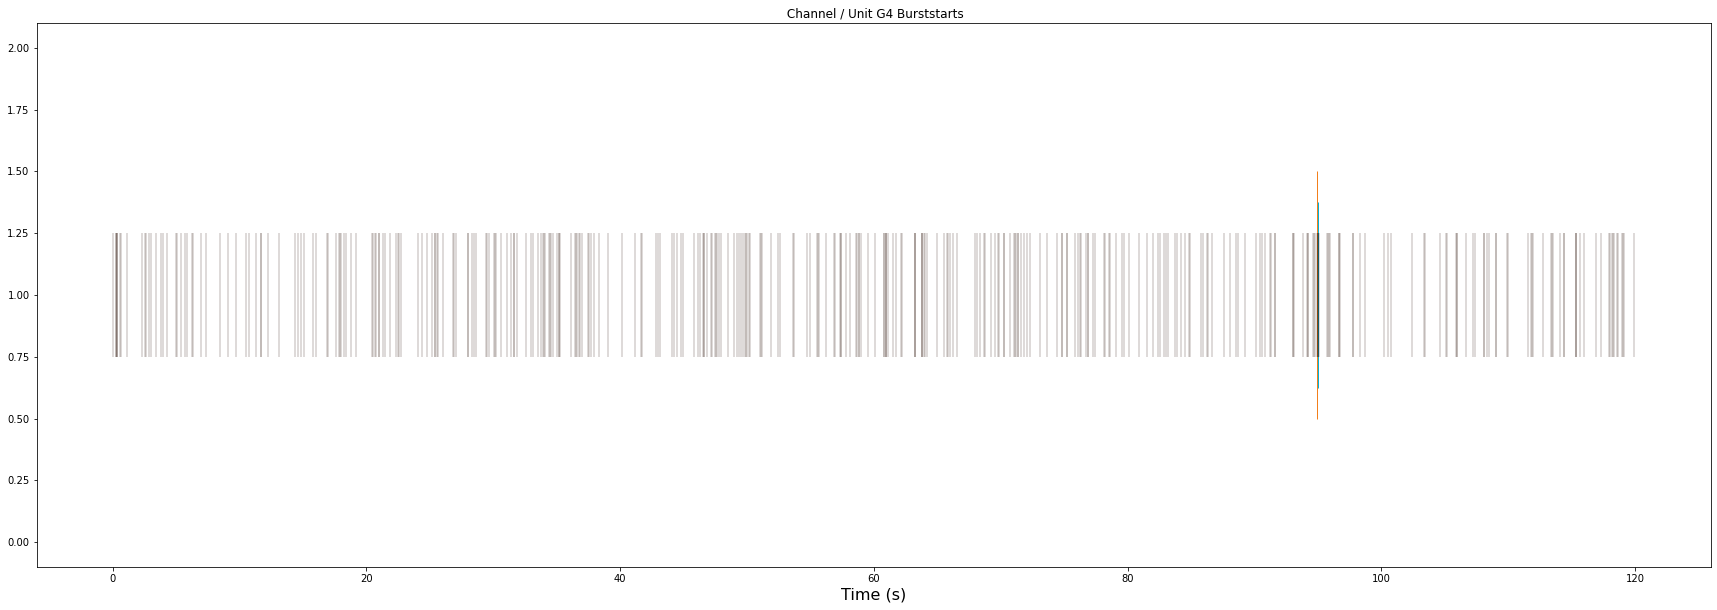

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N4 Burststarts')

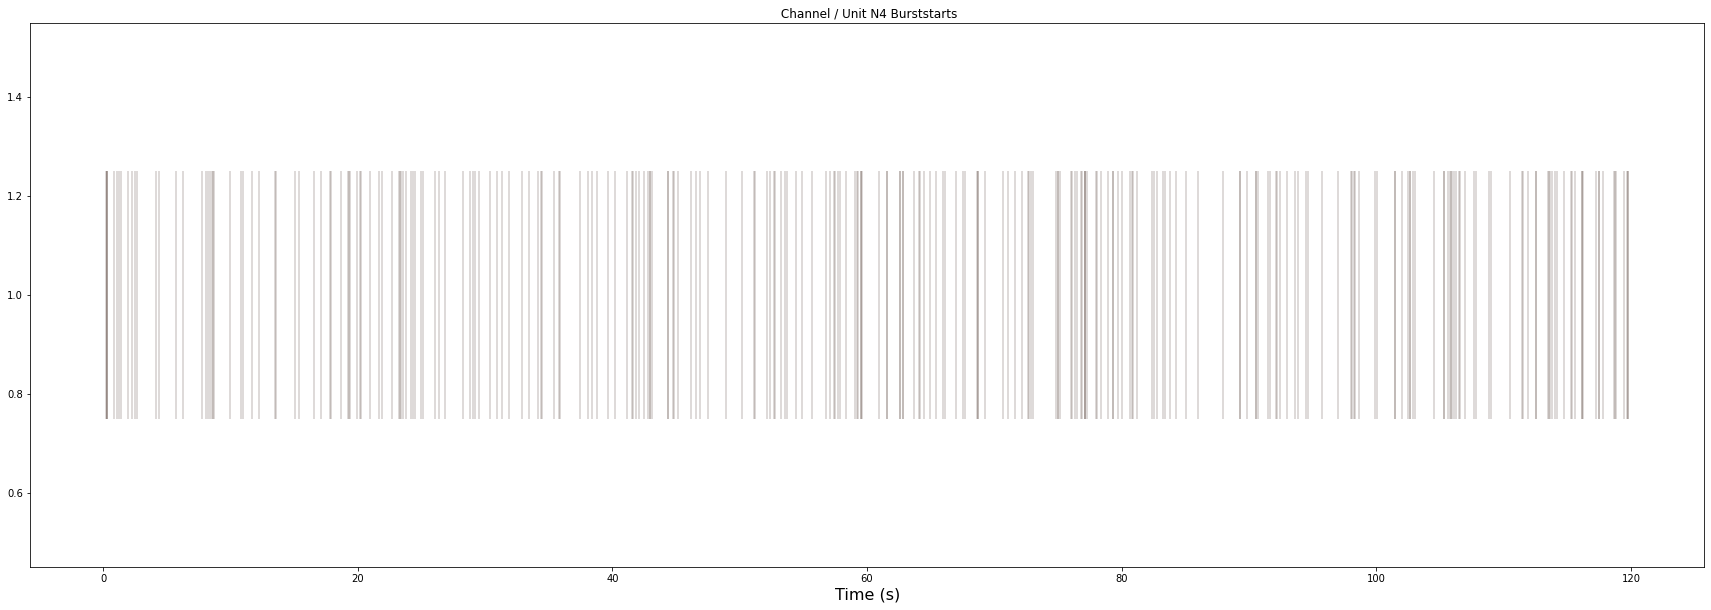

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G3 Burststarts')

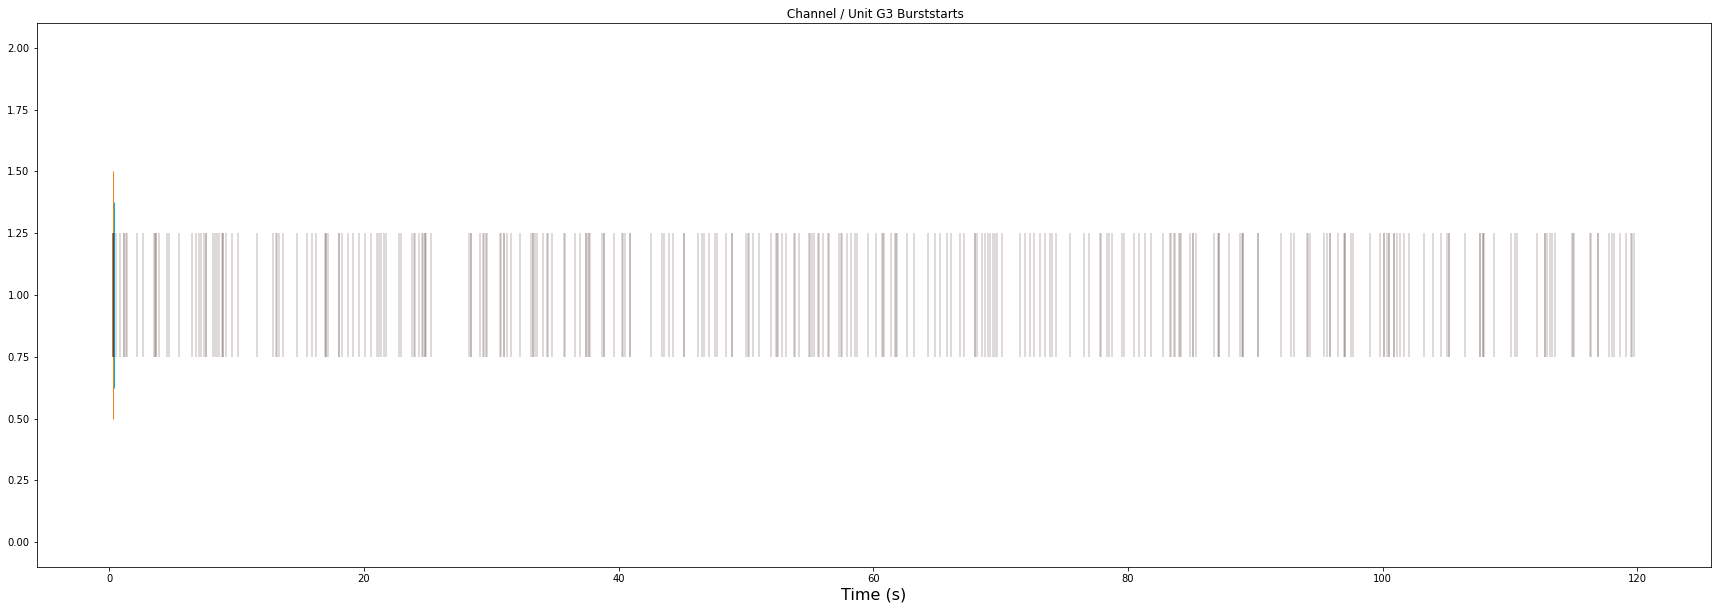

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M3 Burststarts')

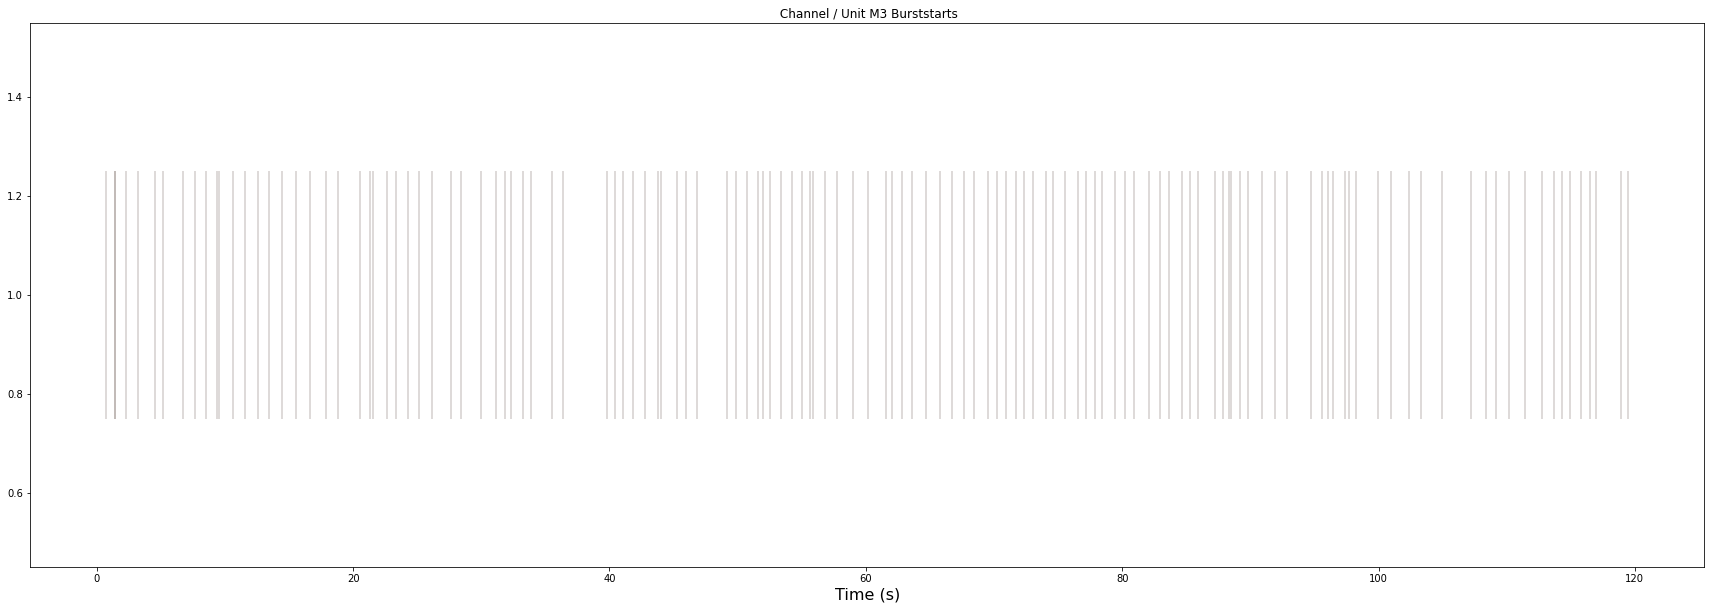

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E4 Burststarts')

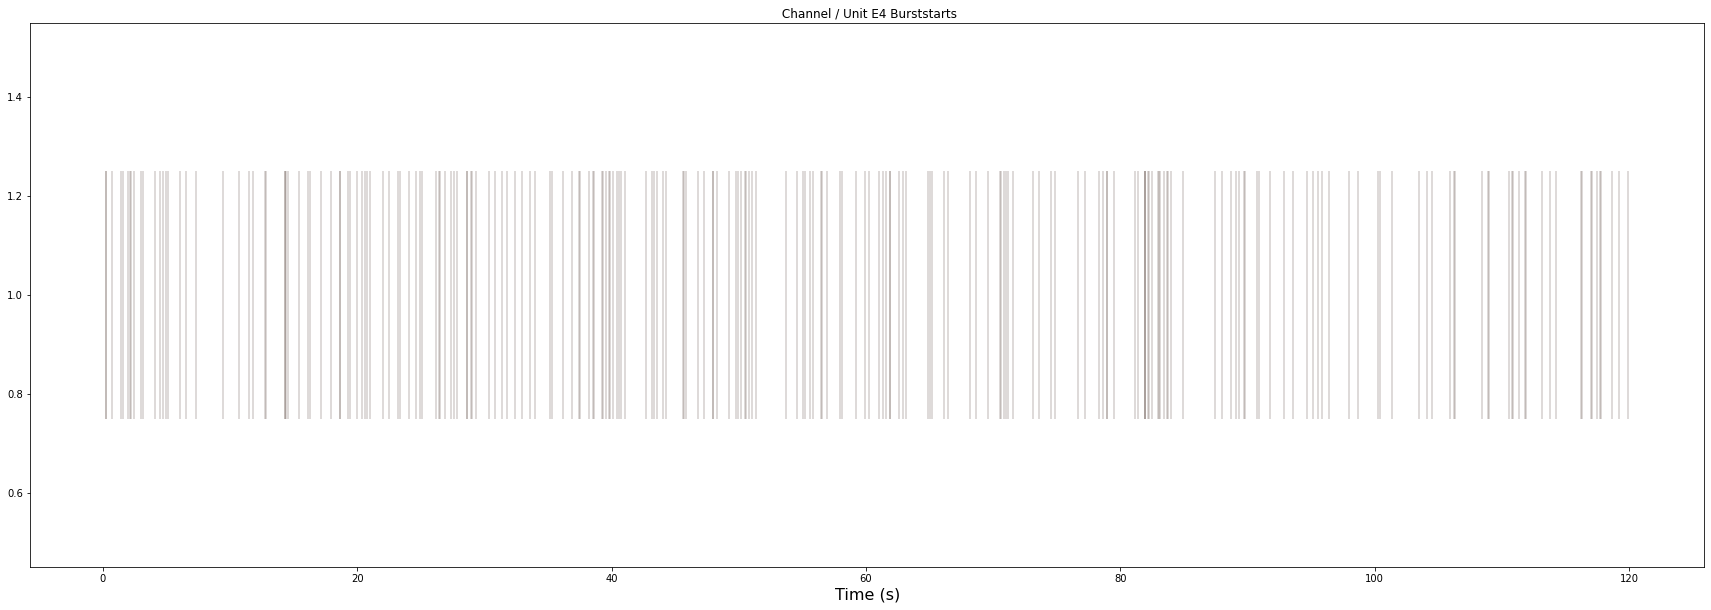

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E8 Burststarts')

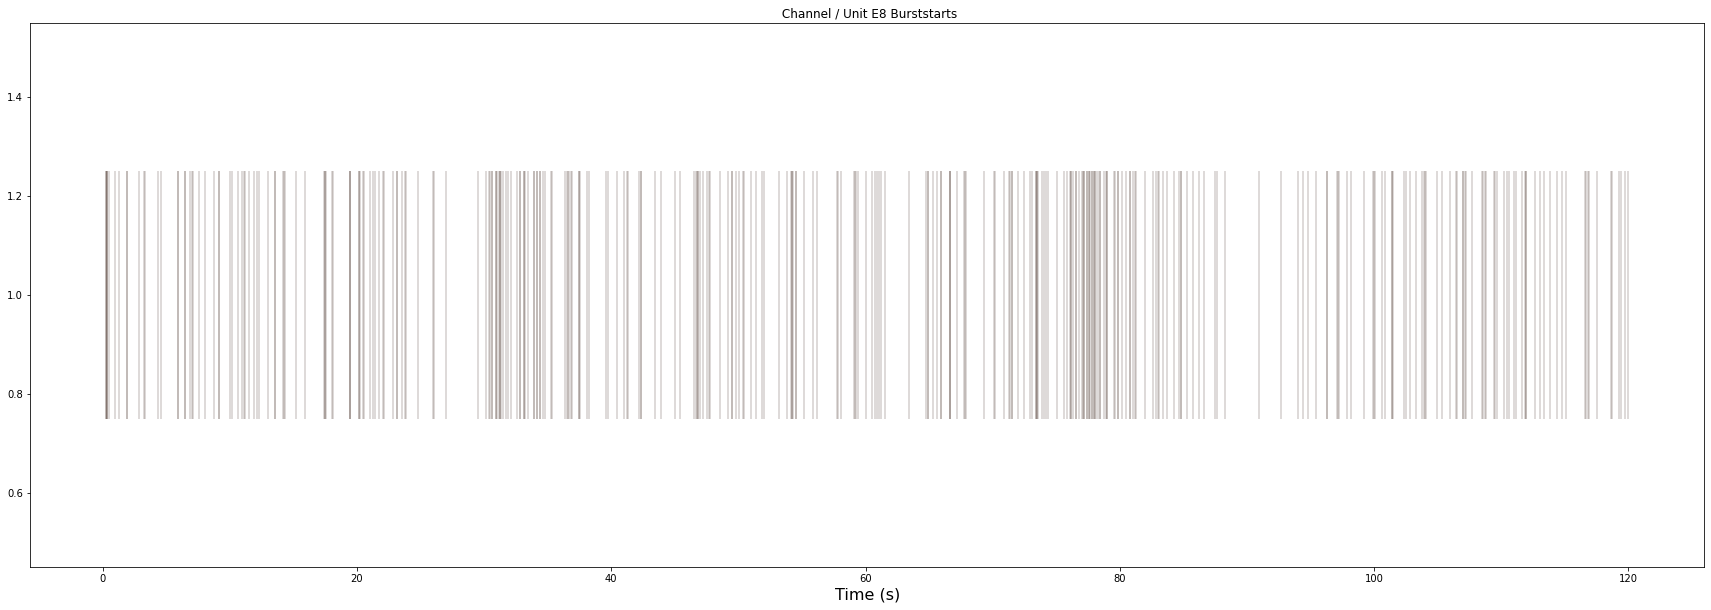

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M4 Burststarts')

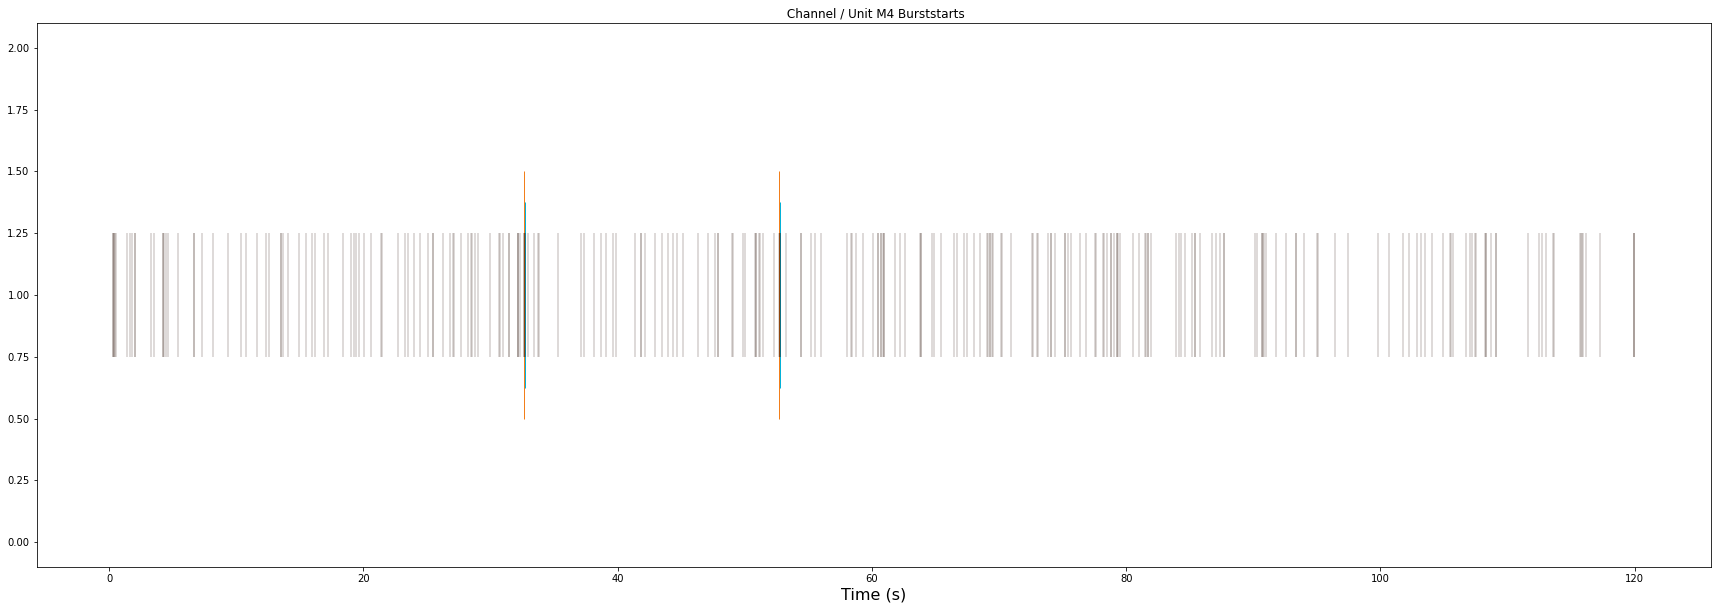

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E3 Burststarts')

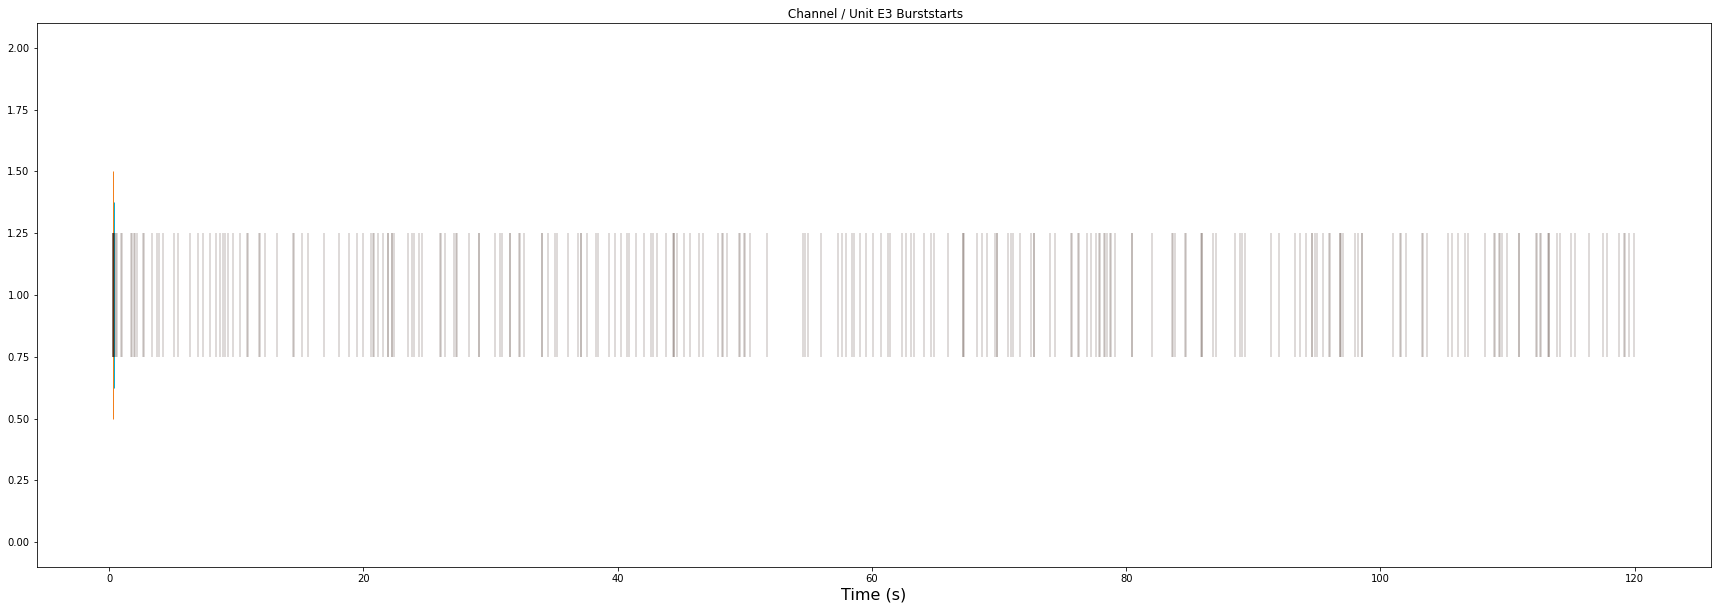

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F8 Burststarts')

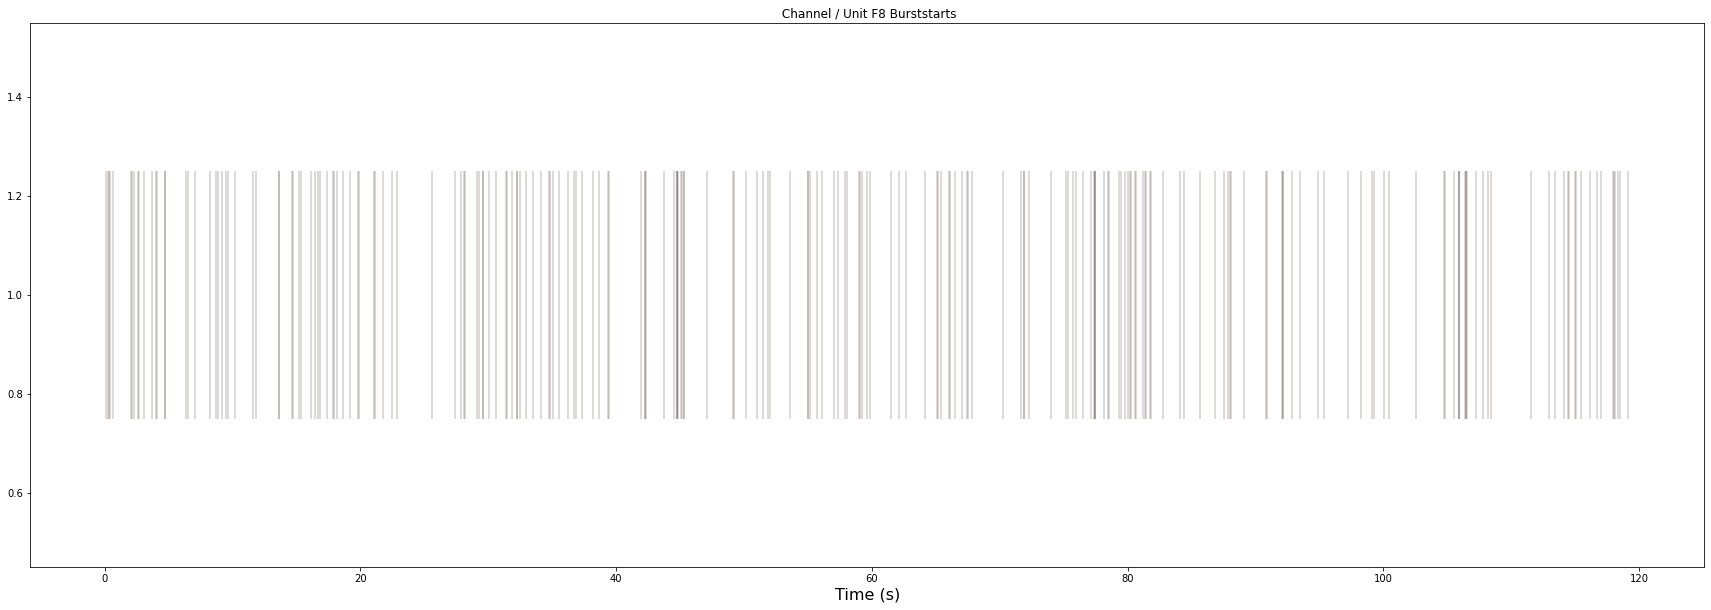

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F13 Burststarts')

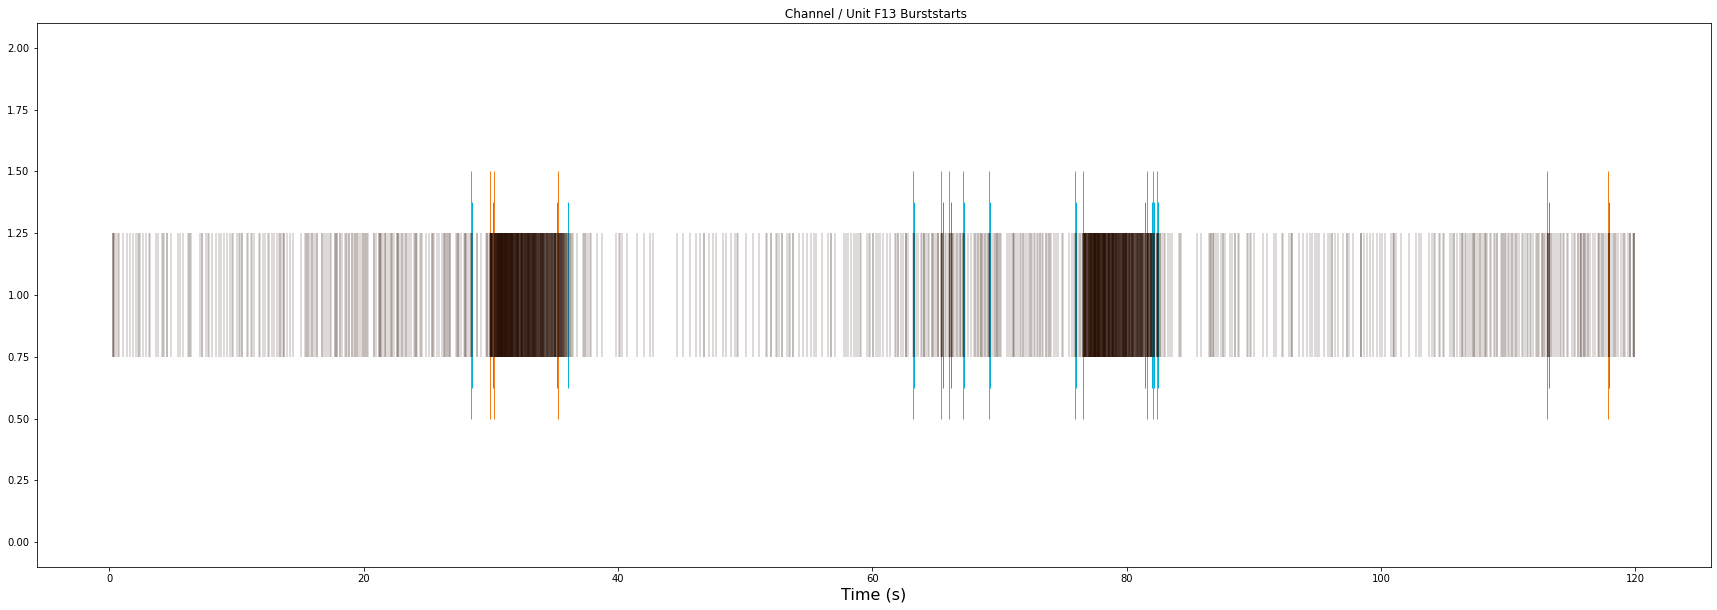

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G10 Burststarts')

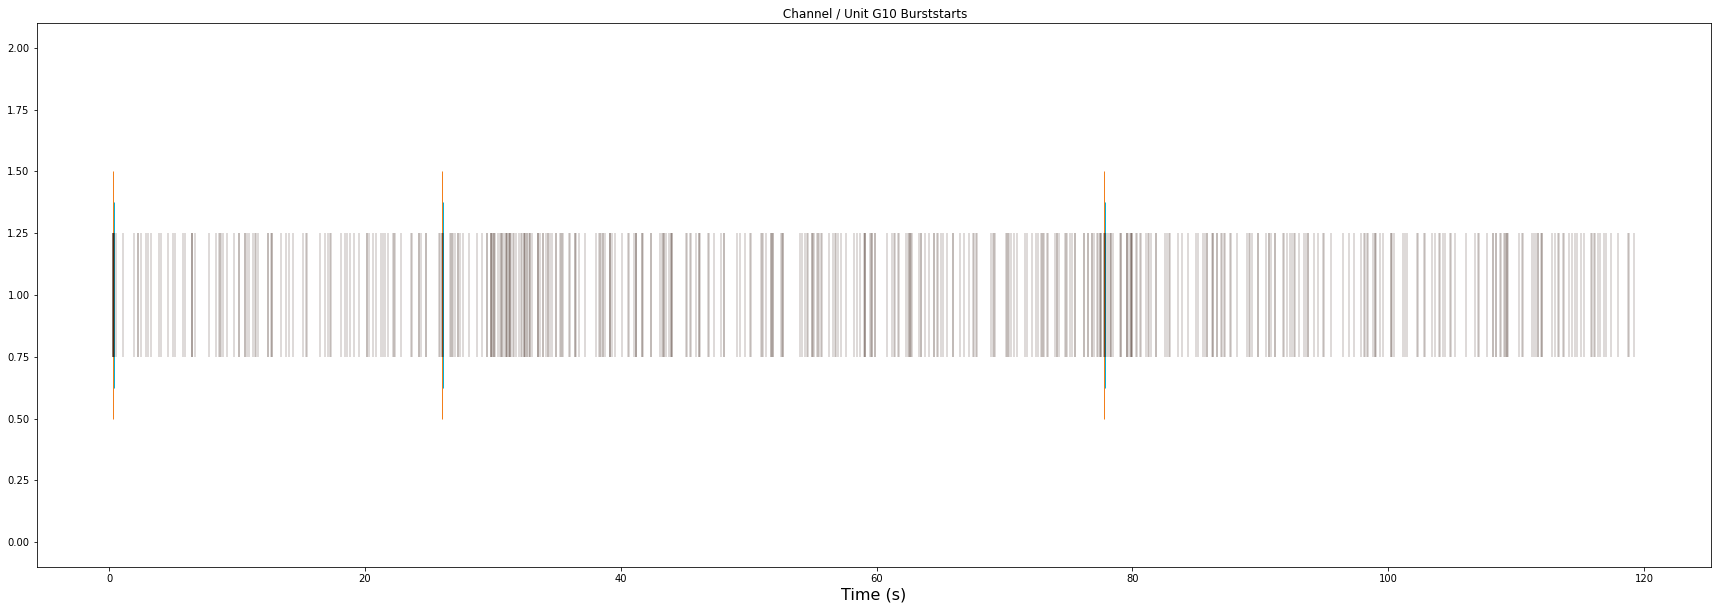

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F9 Burststarts')

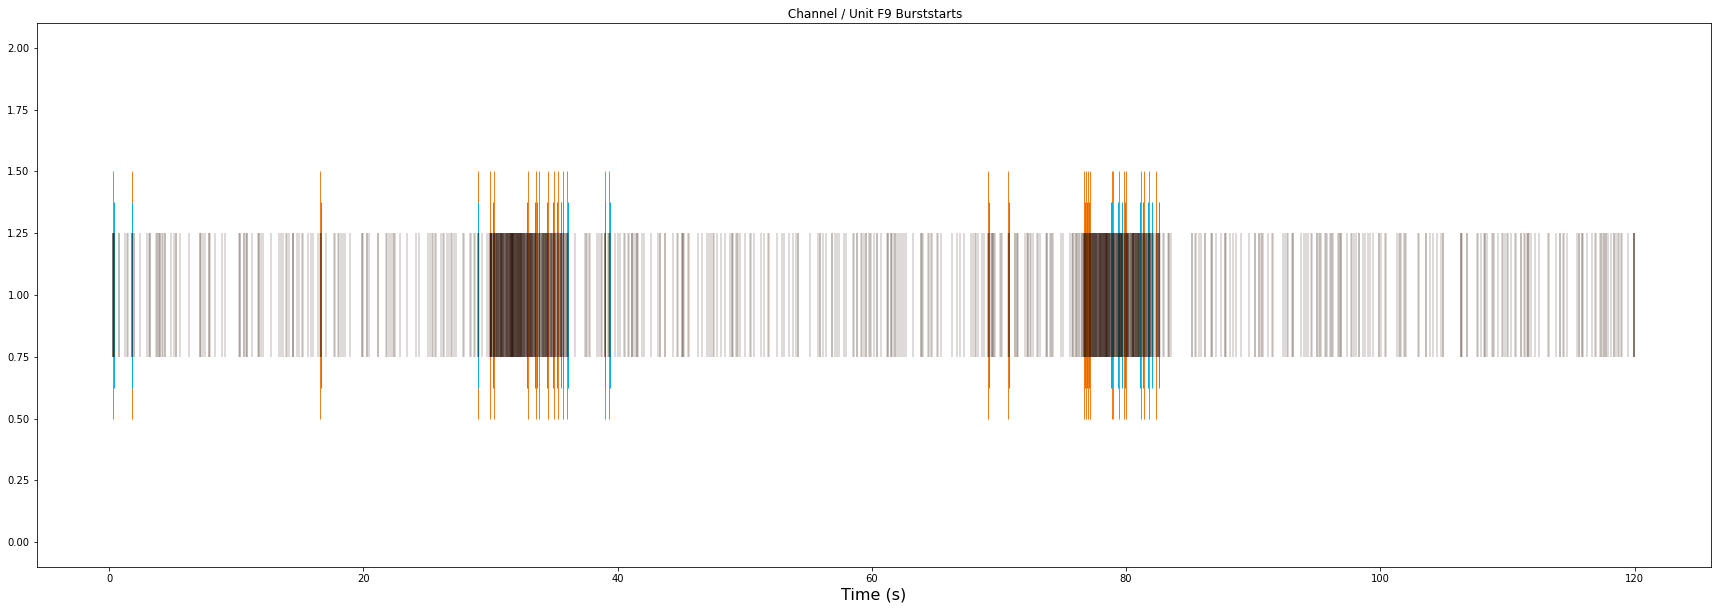

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G13 Burststarts')

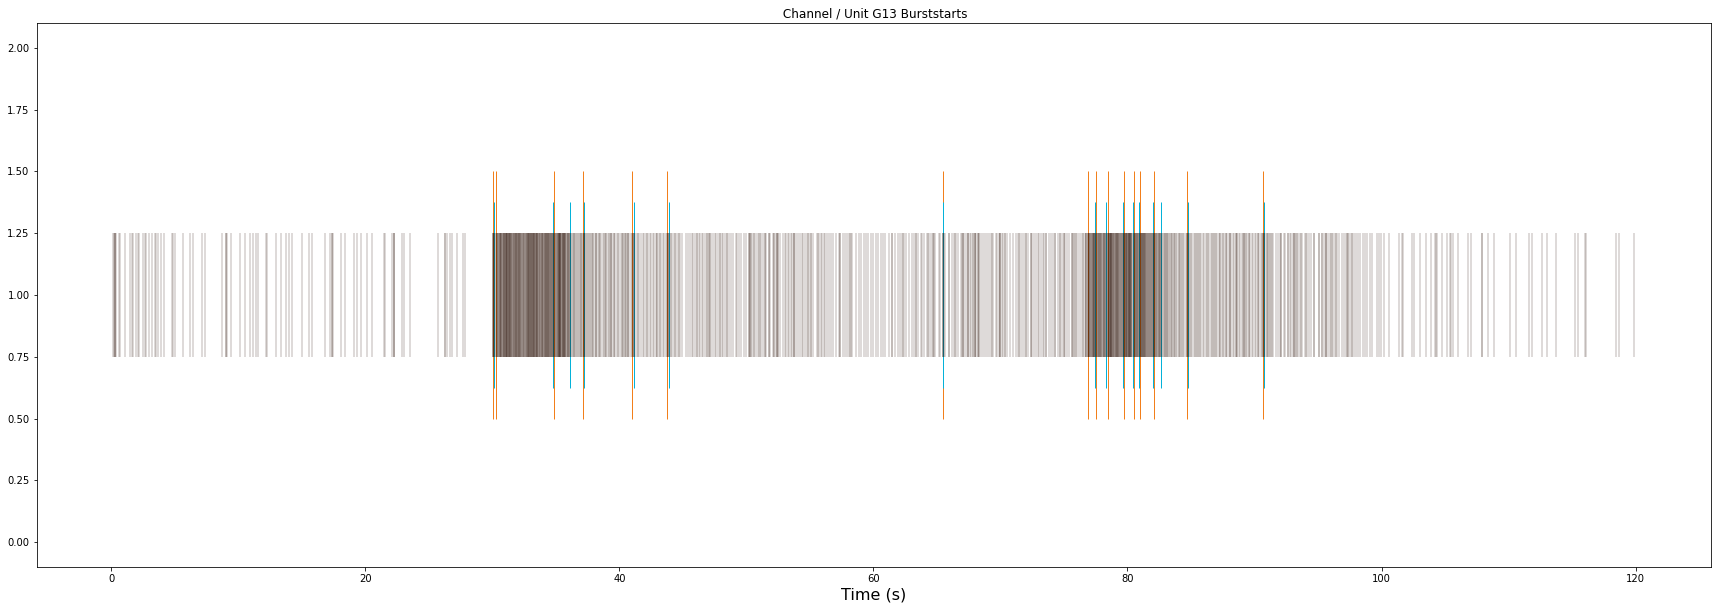

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A11 Burststarts')

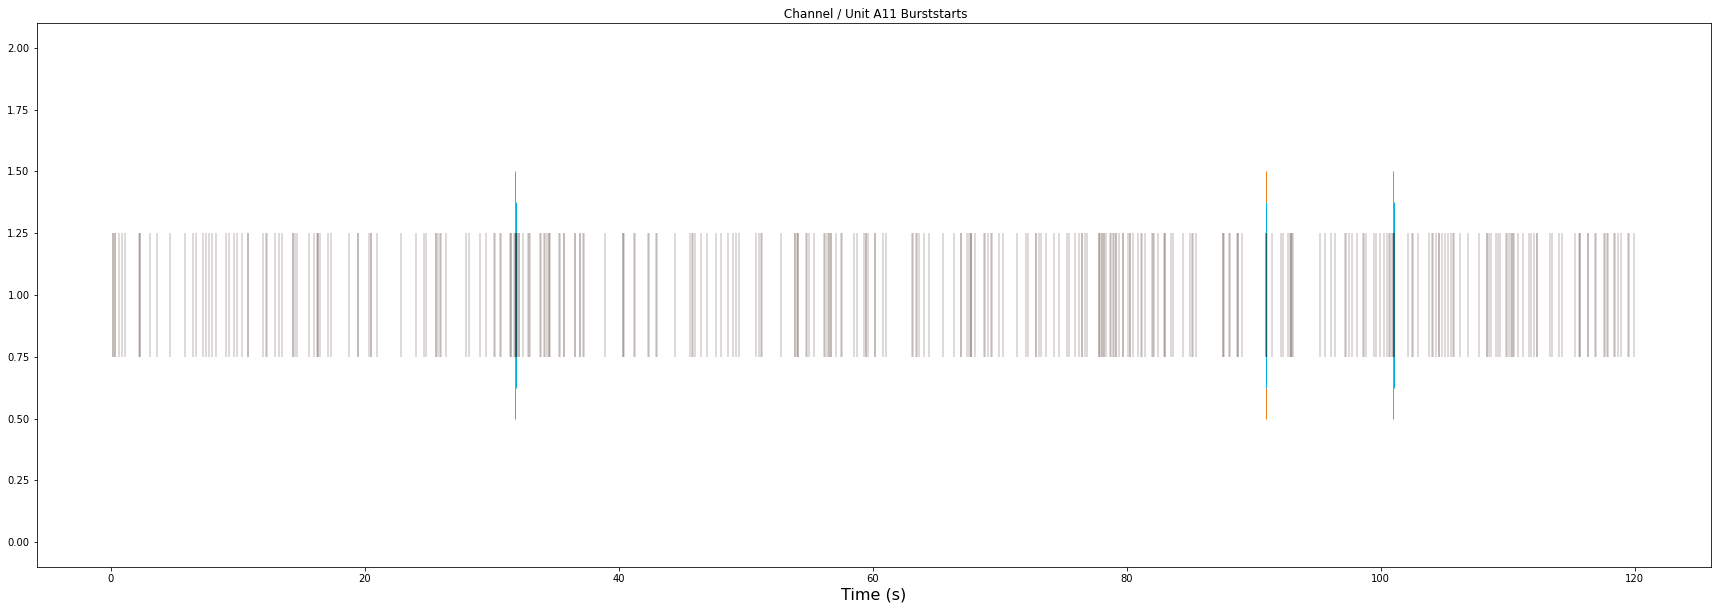

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H9 Burststarts')

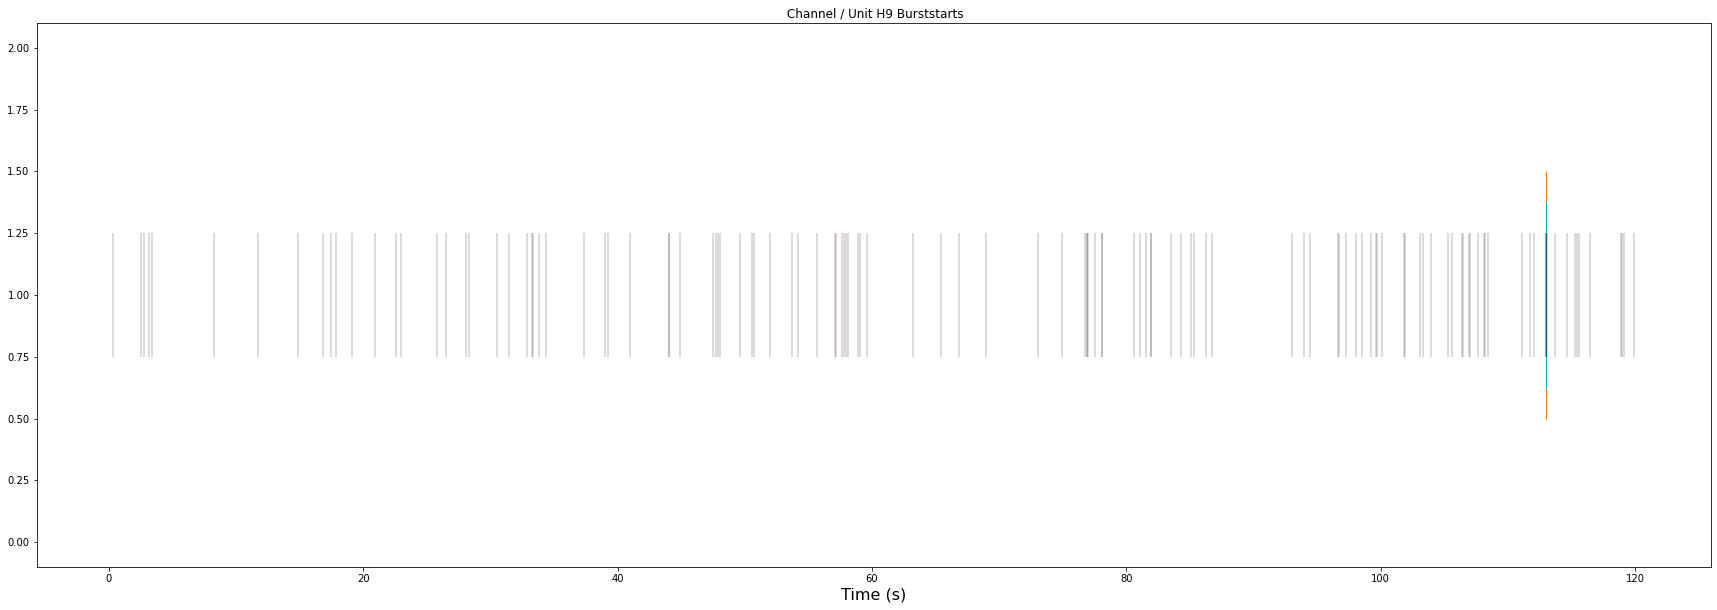

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B3 Burststarts')

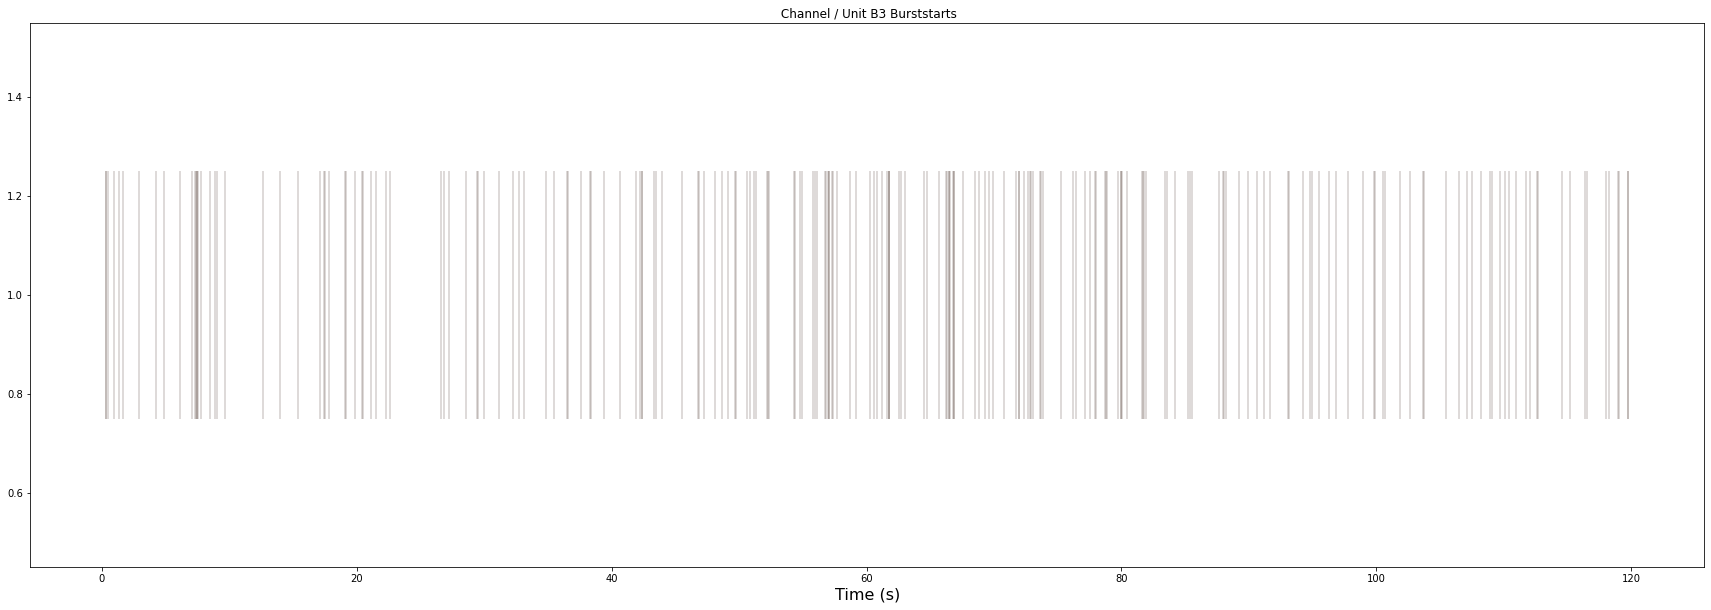

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E10 Burststarts')

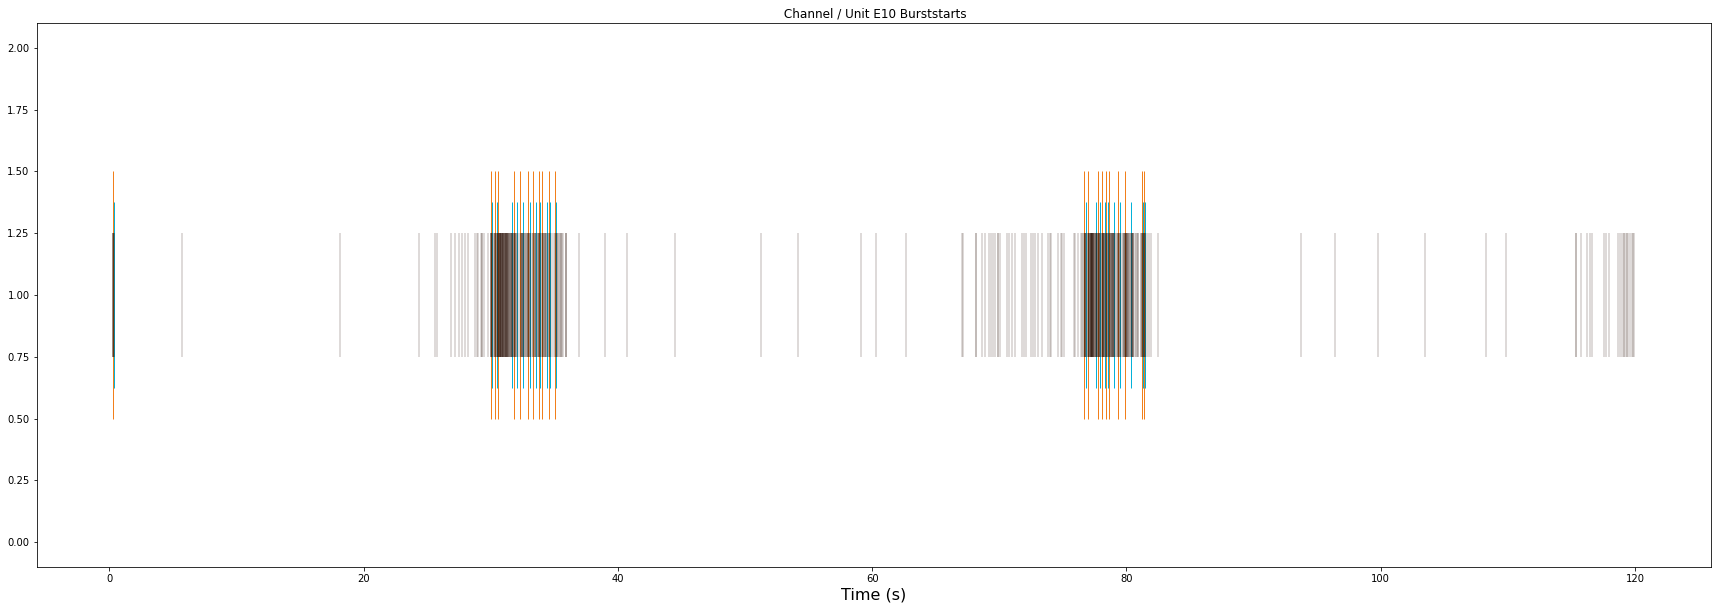

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M5 Burststarts')

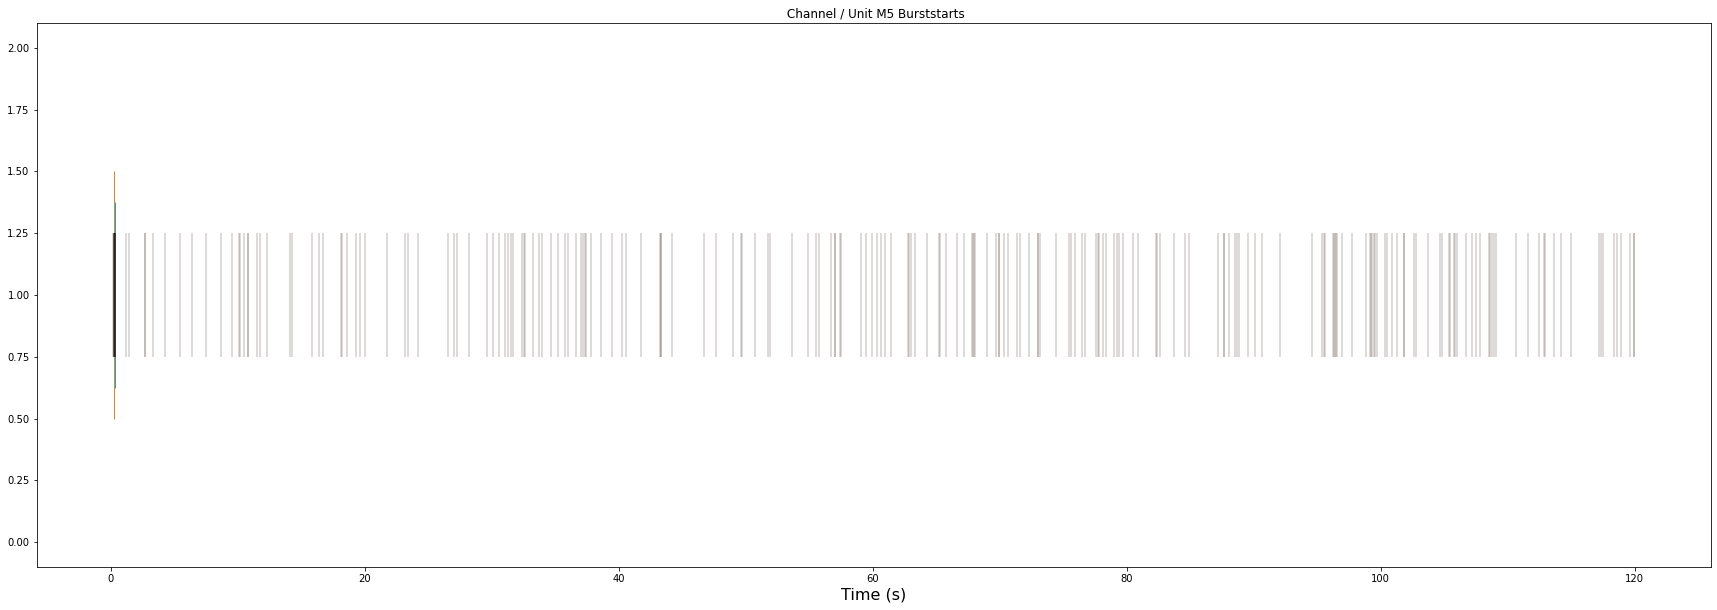

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H4 Burststarts')

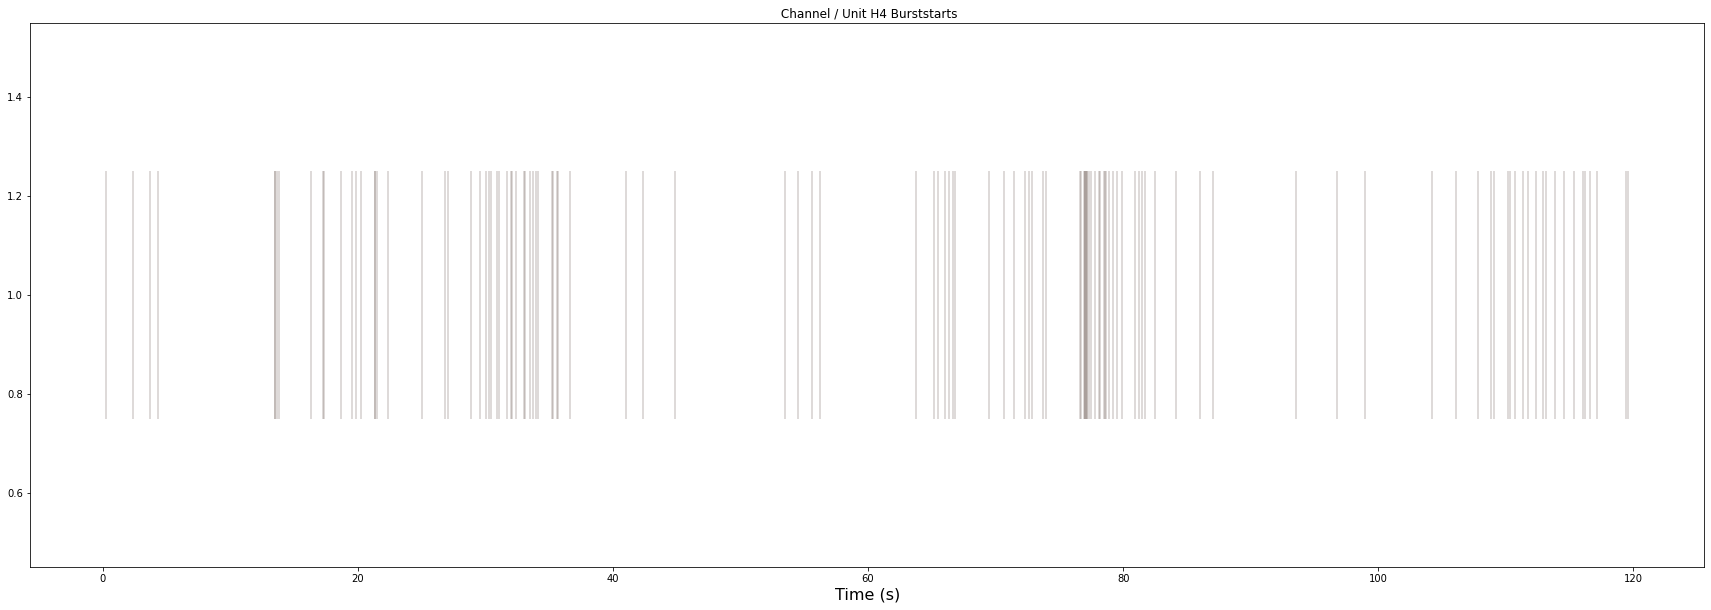

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K8 Burststarts')

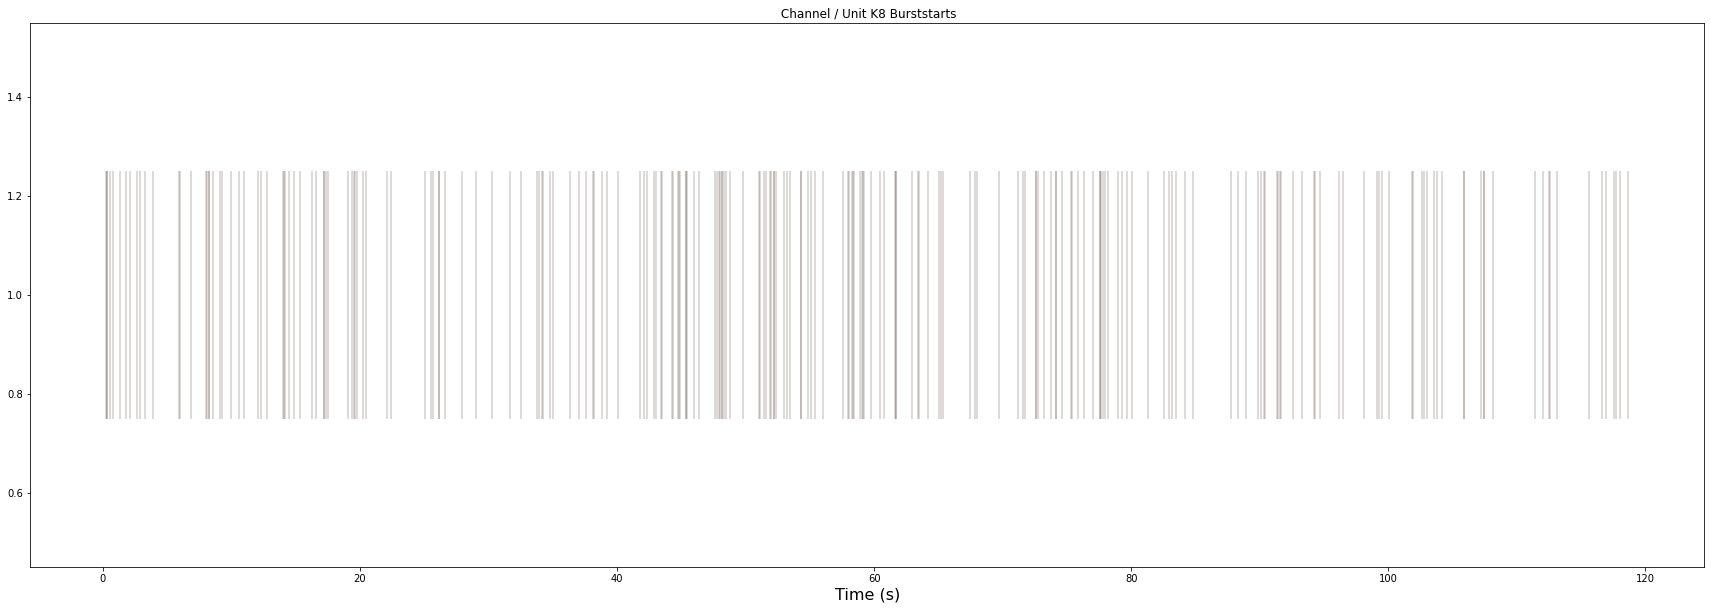

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F5 Burststarts')

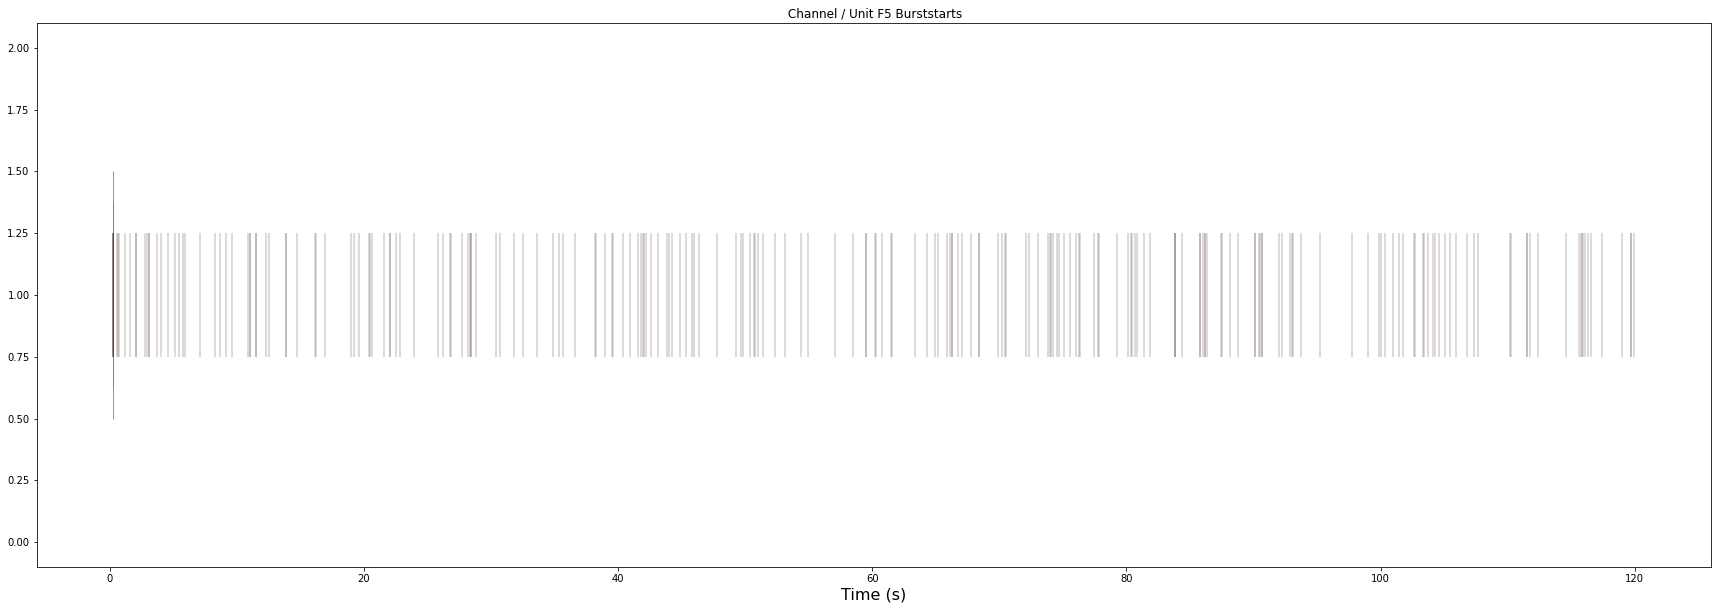

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N3 Burststarts')

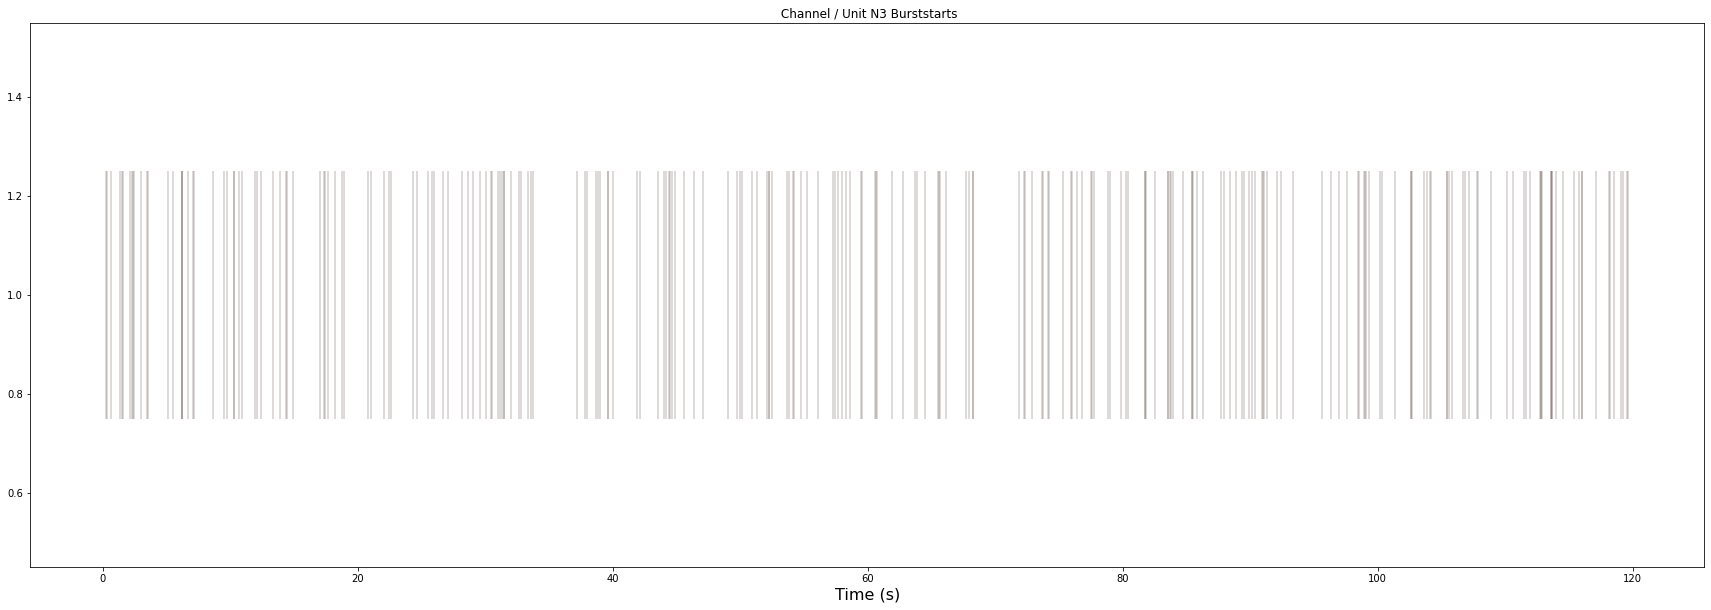

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F4 Burststarts')

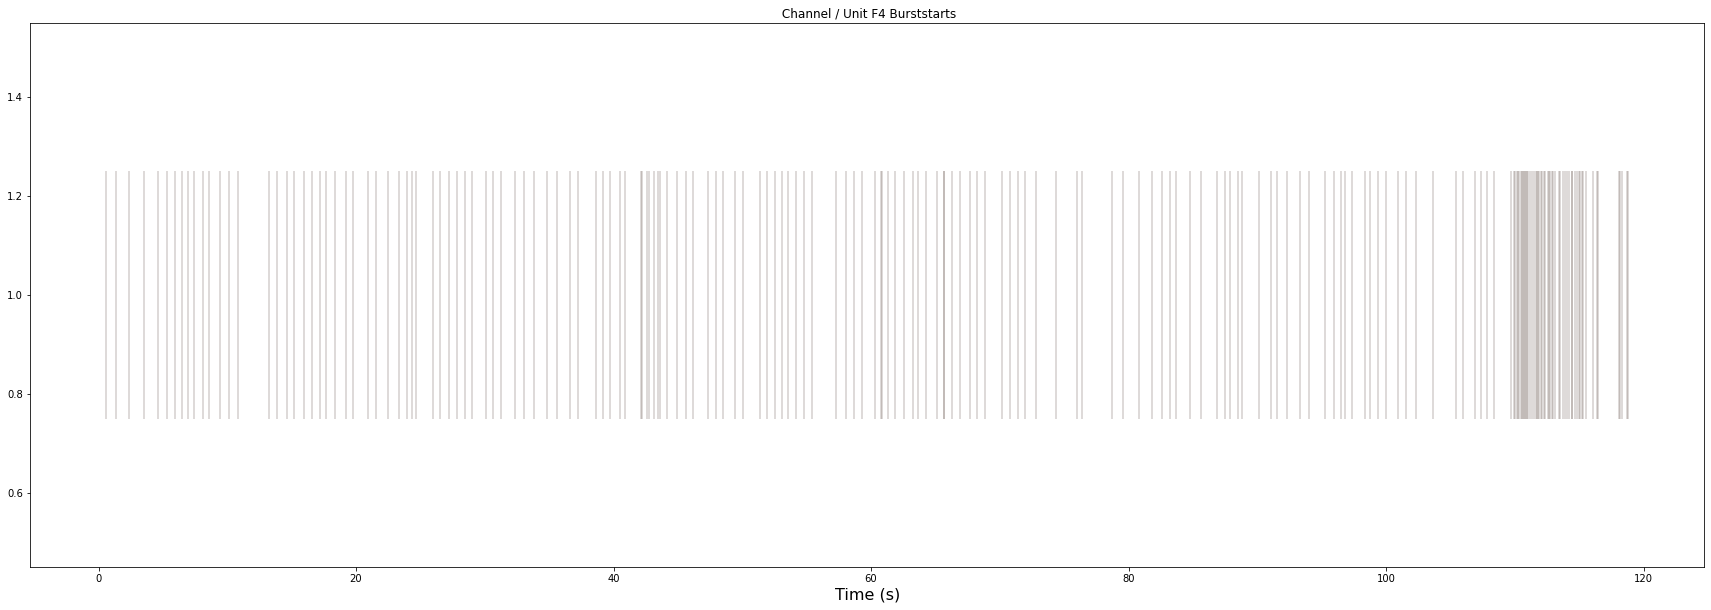

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G6 Burststarts')

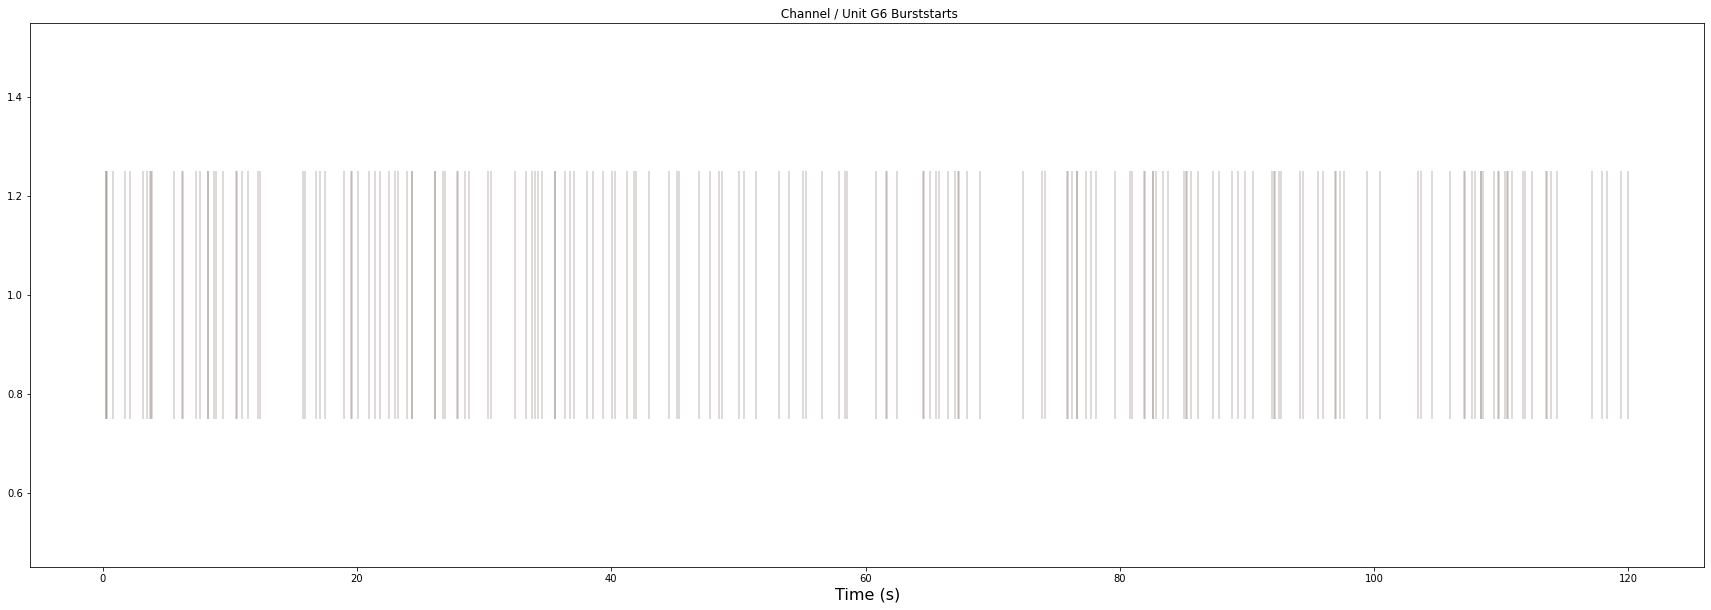

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I10 Burststarts')

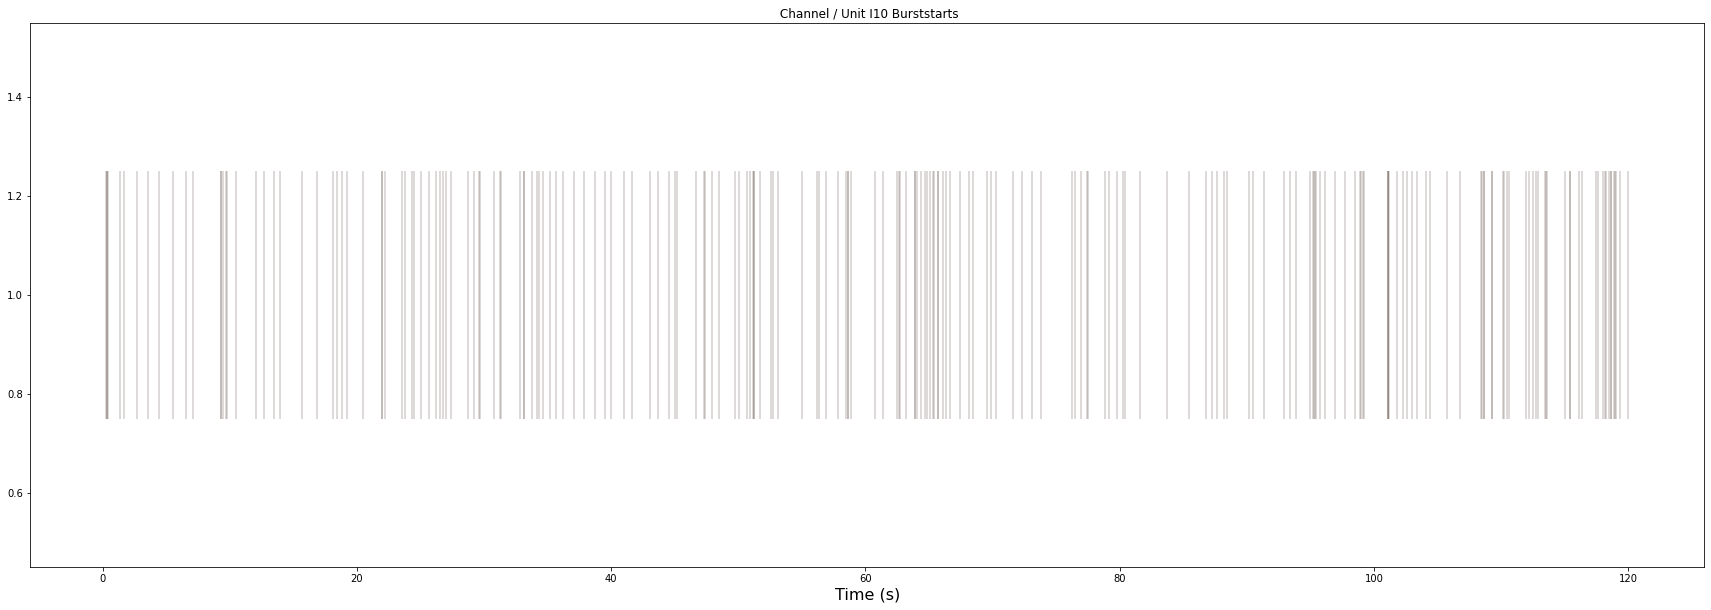

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B10 Burststarts')

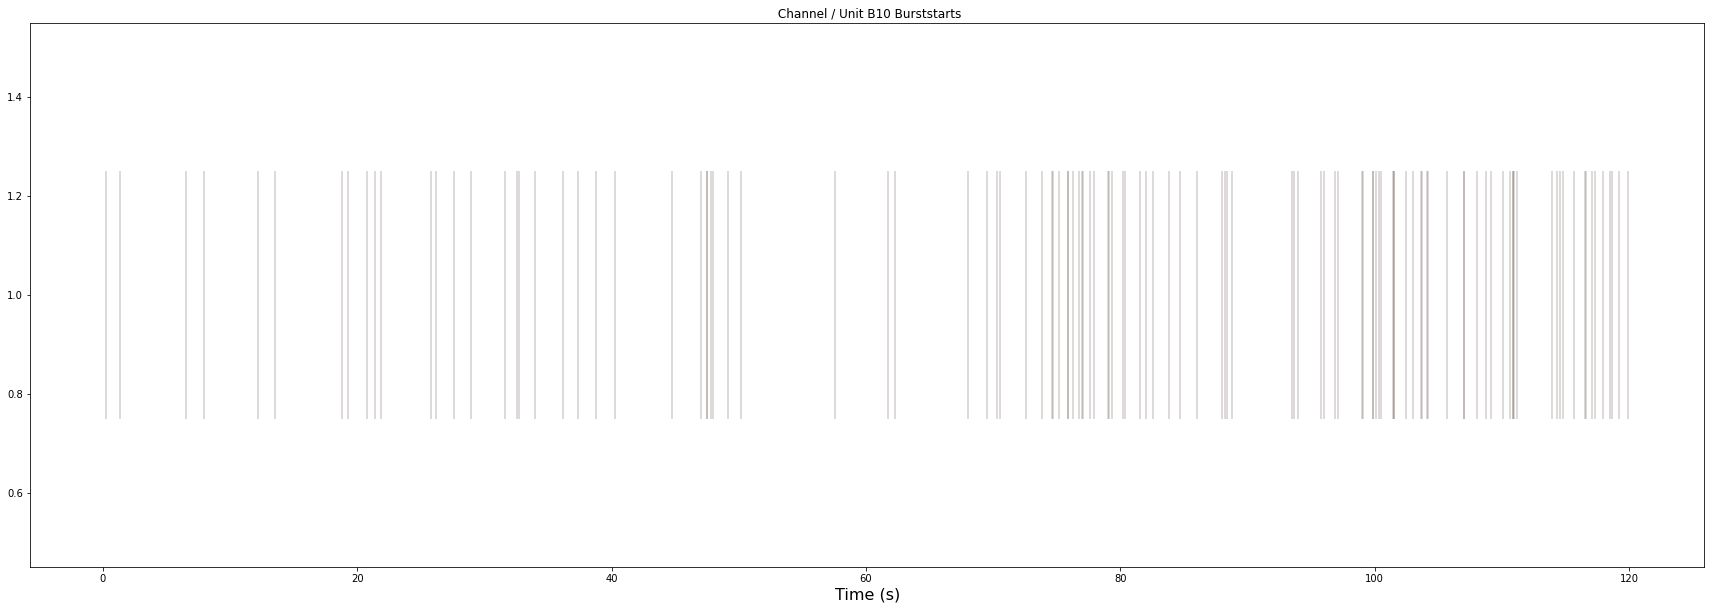

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N1 Burststarts')

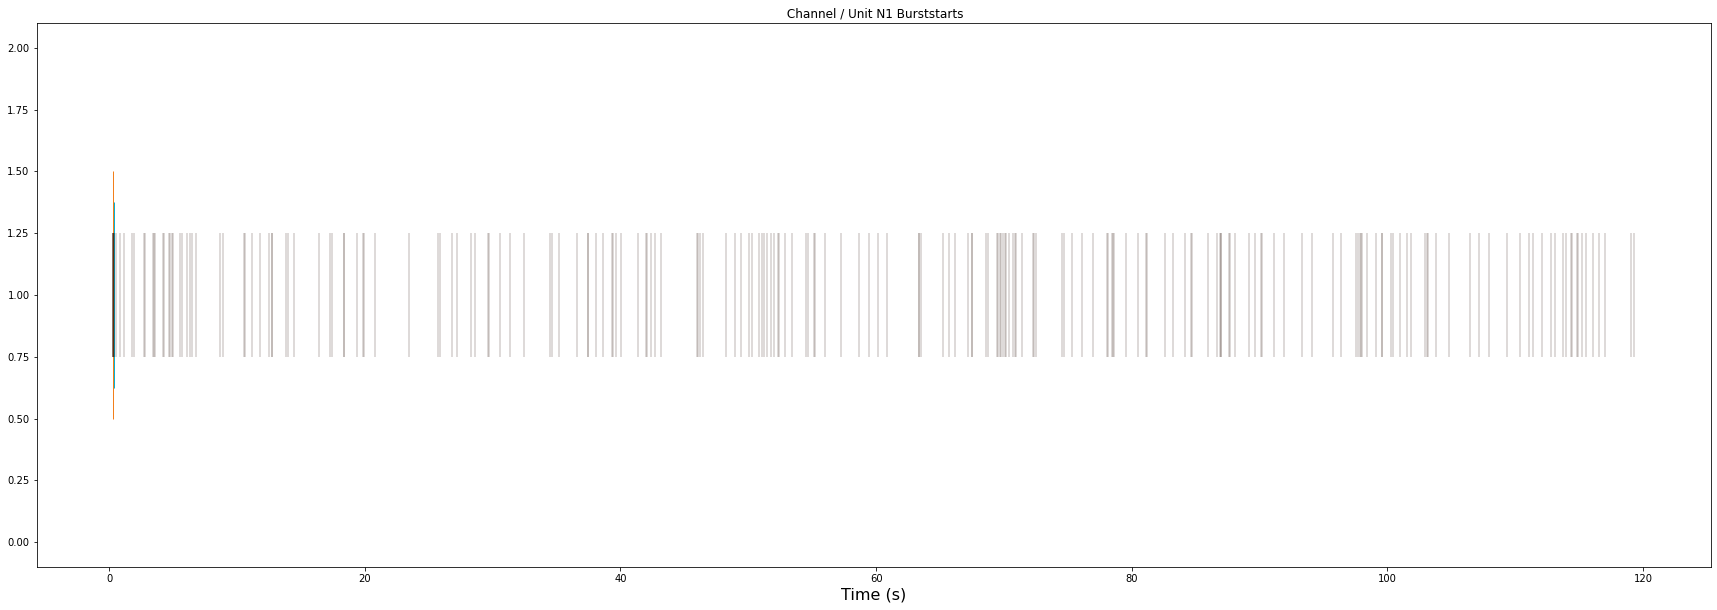

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K5 Burststarts')

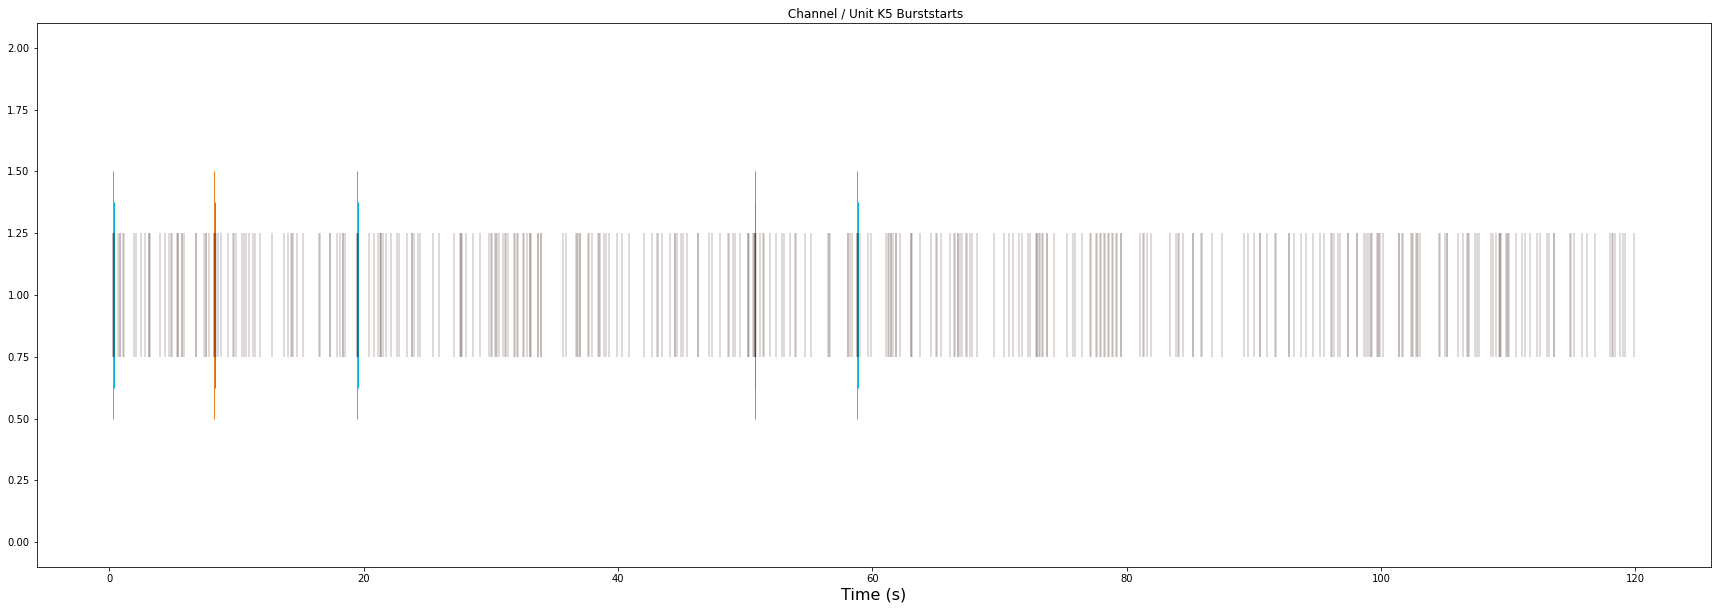

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit I9 Burststarts')

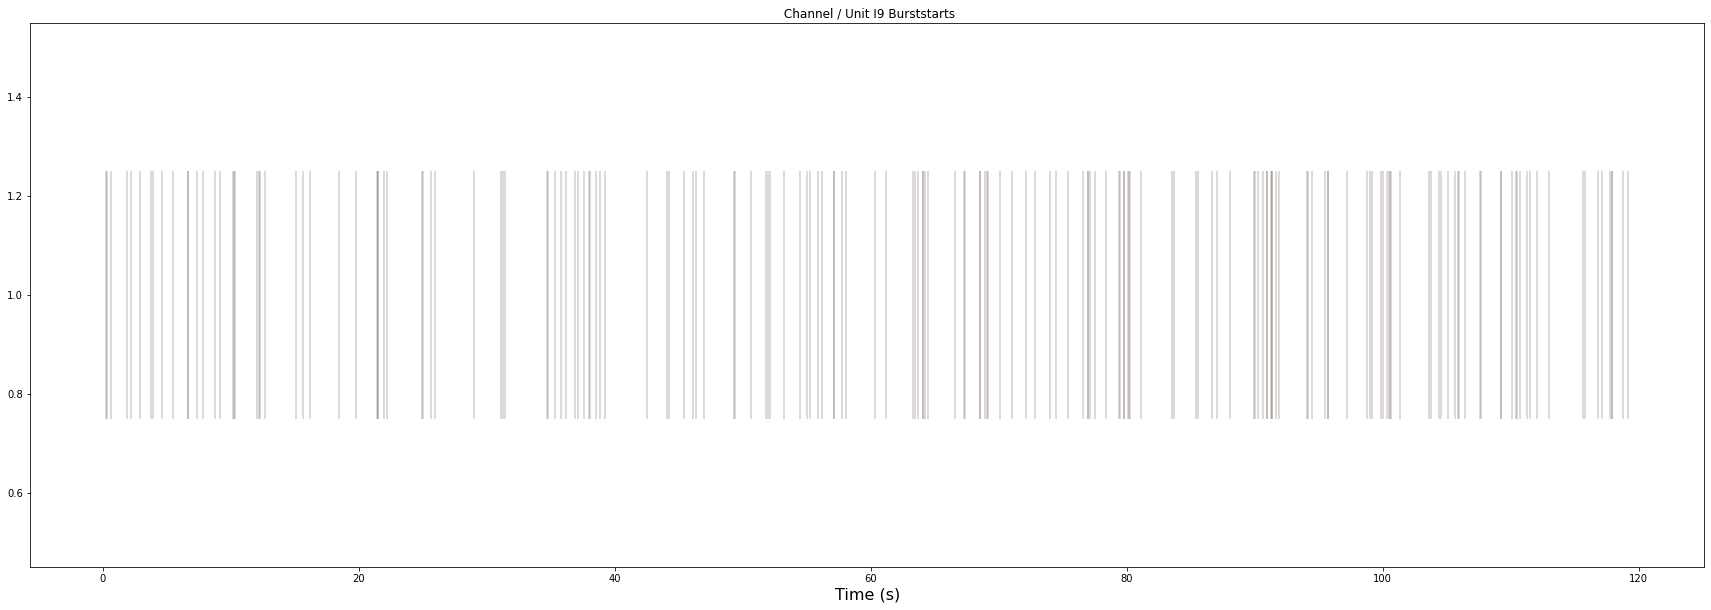

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E9 Burststarts')

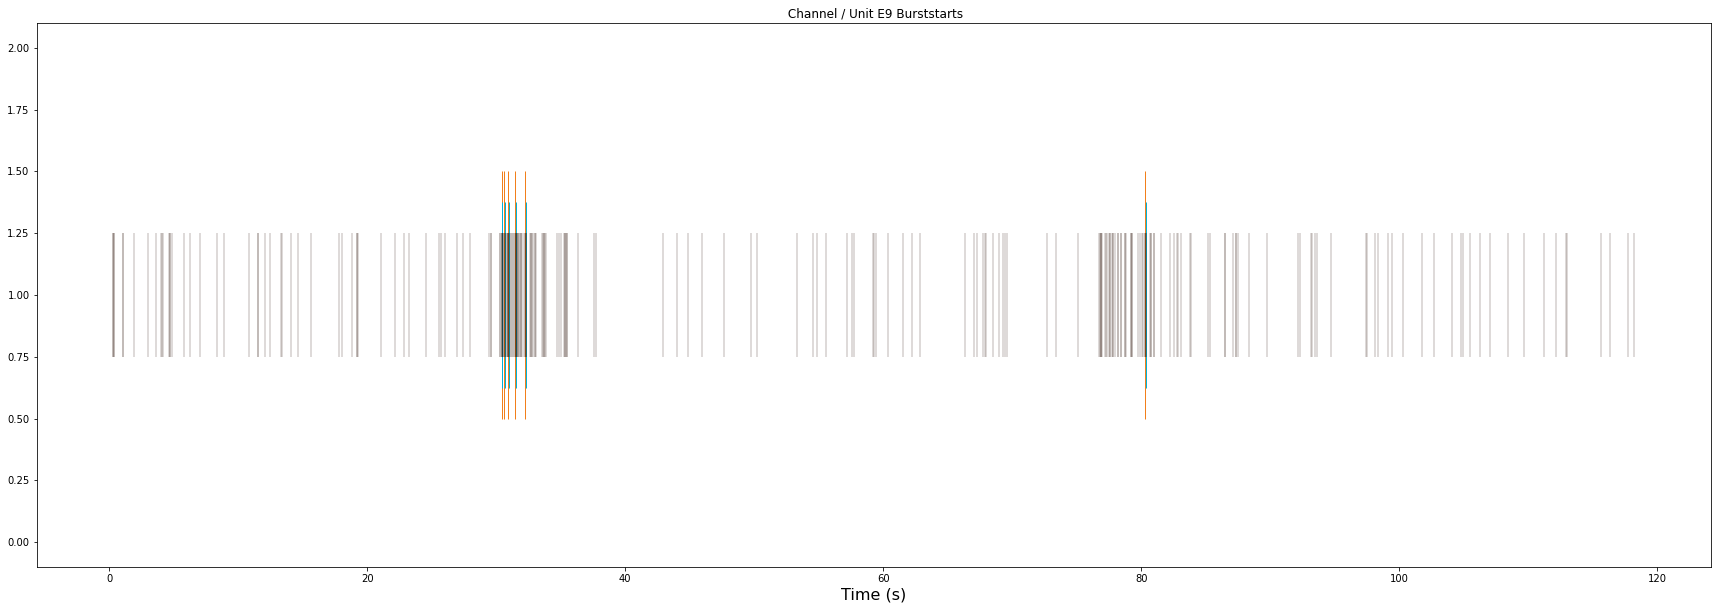

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E16 Burststarts')

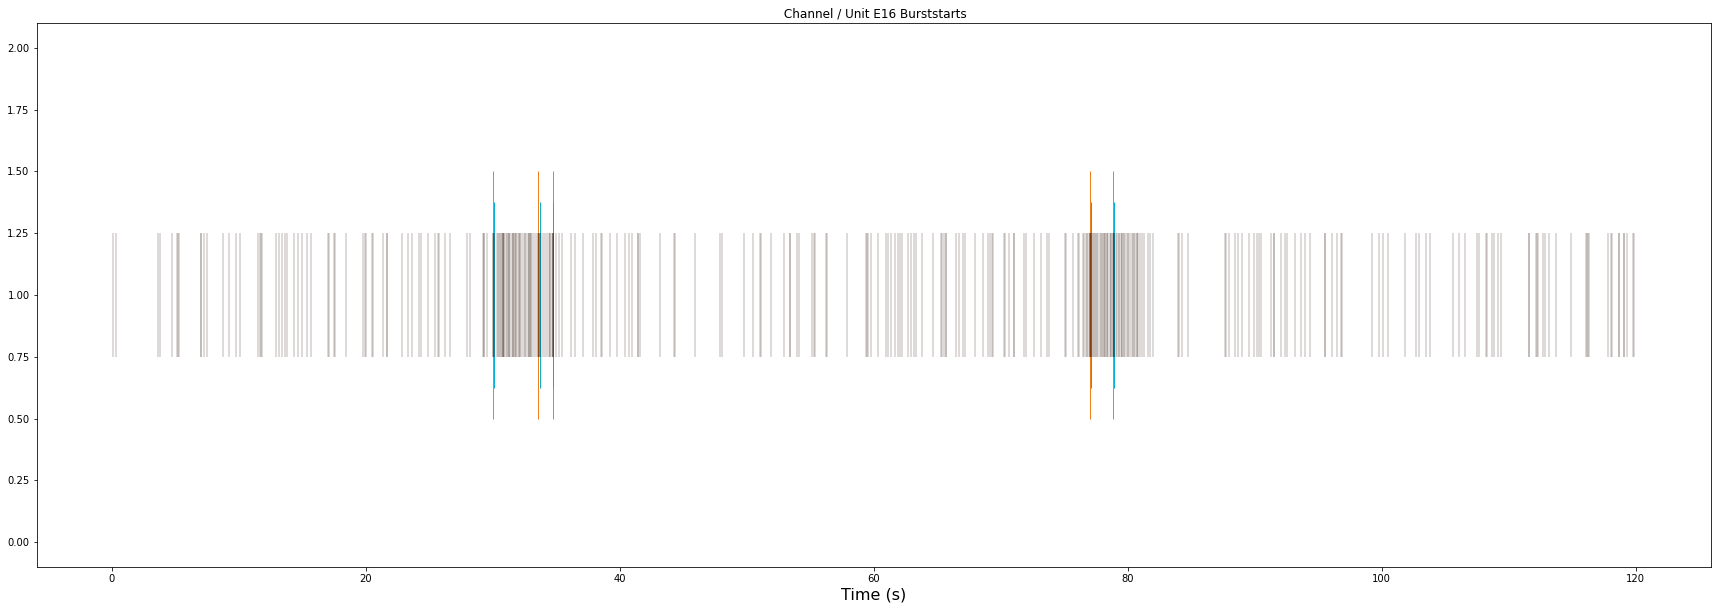

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D4 Burststarts')

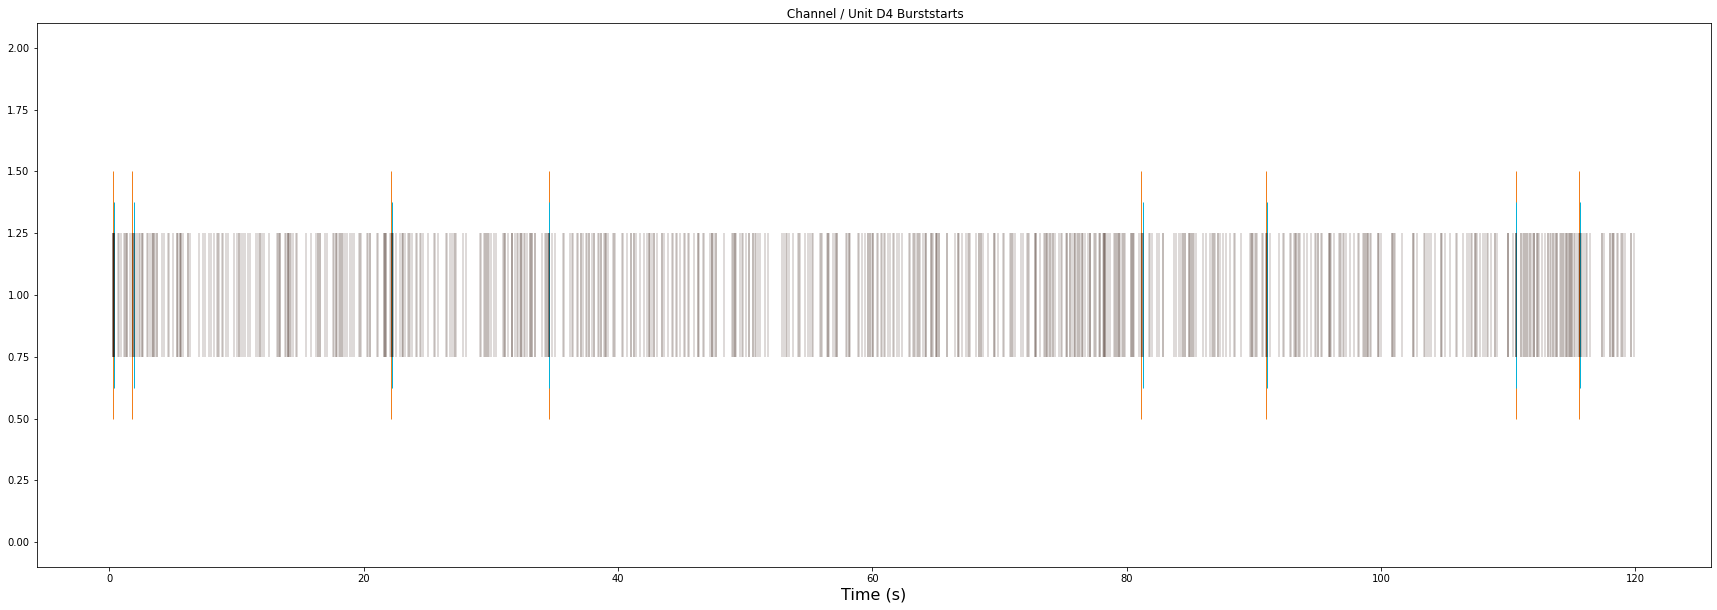

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C10 Burststarts')

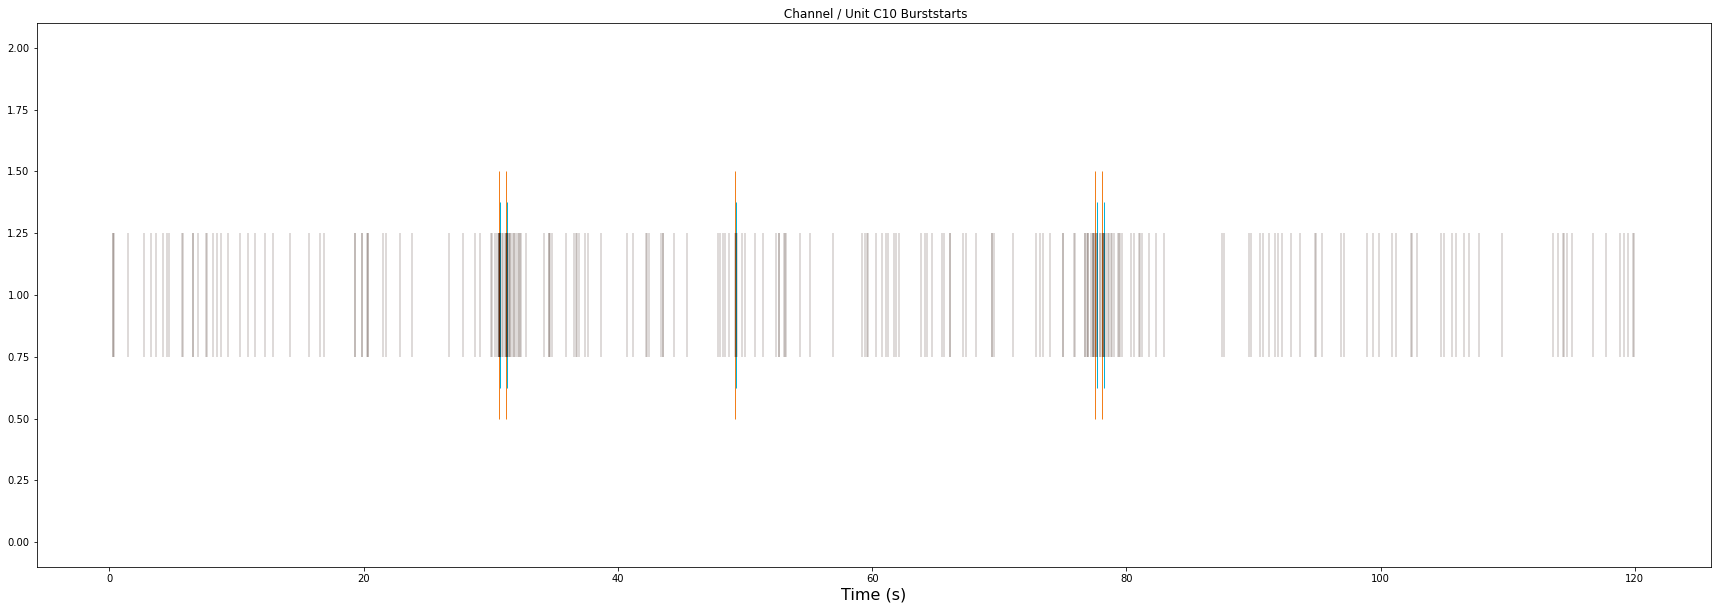

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F14 Burststarts')

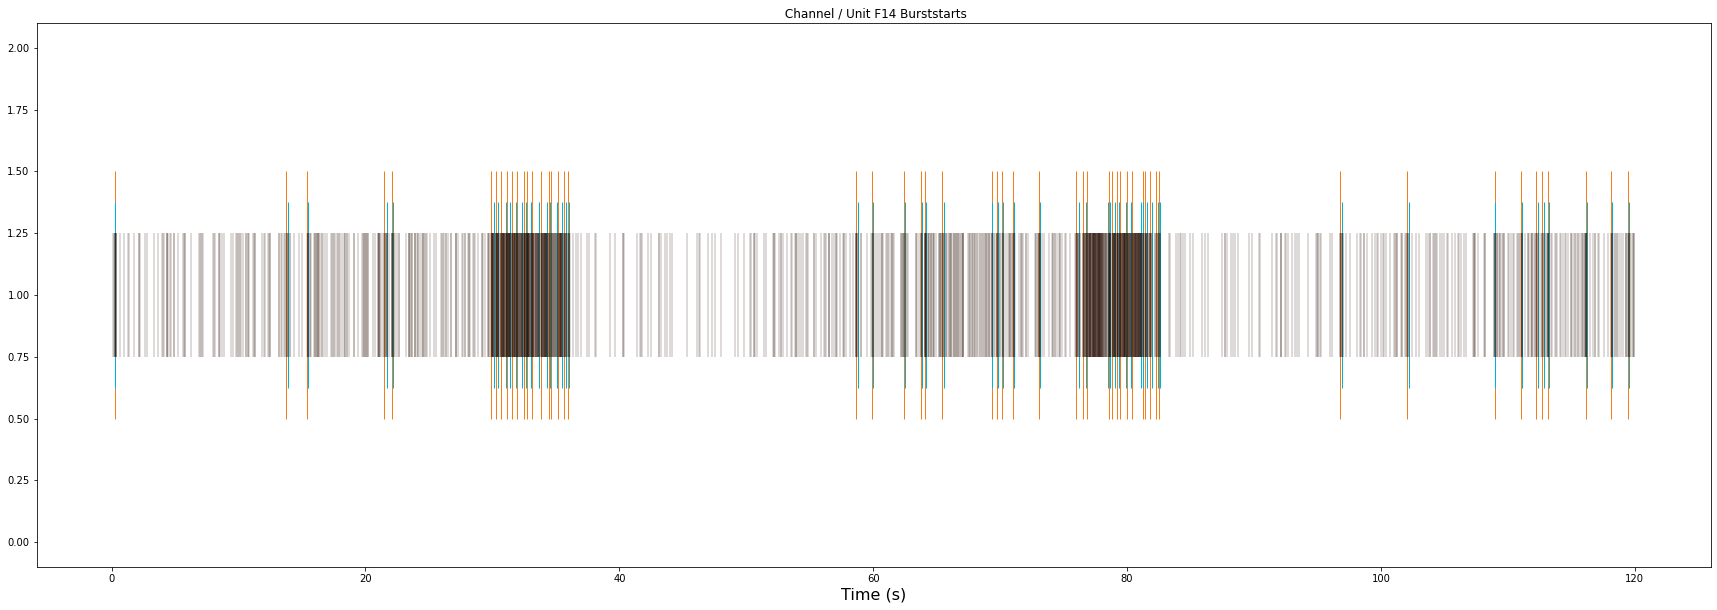

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C5 Burststarts')

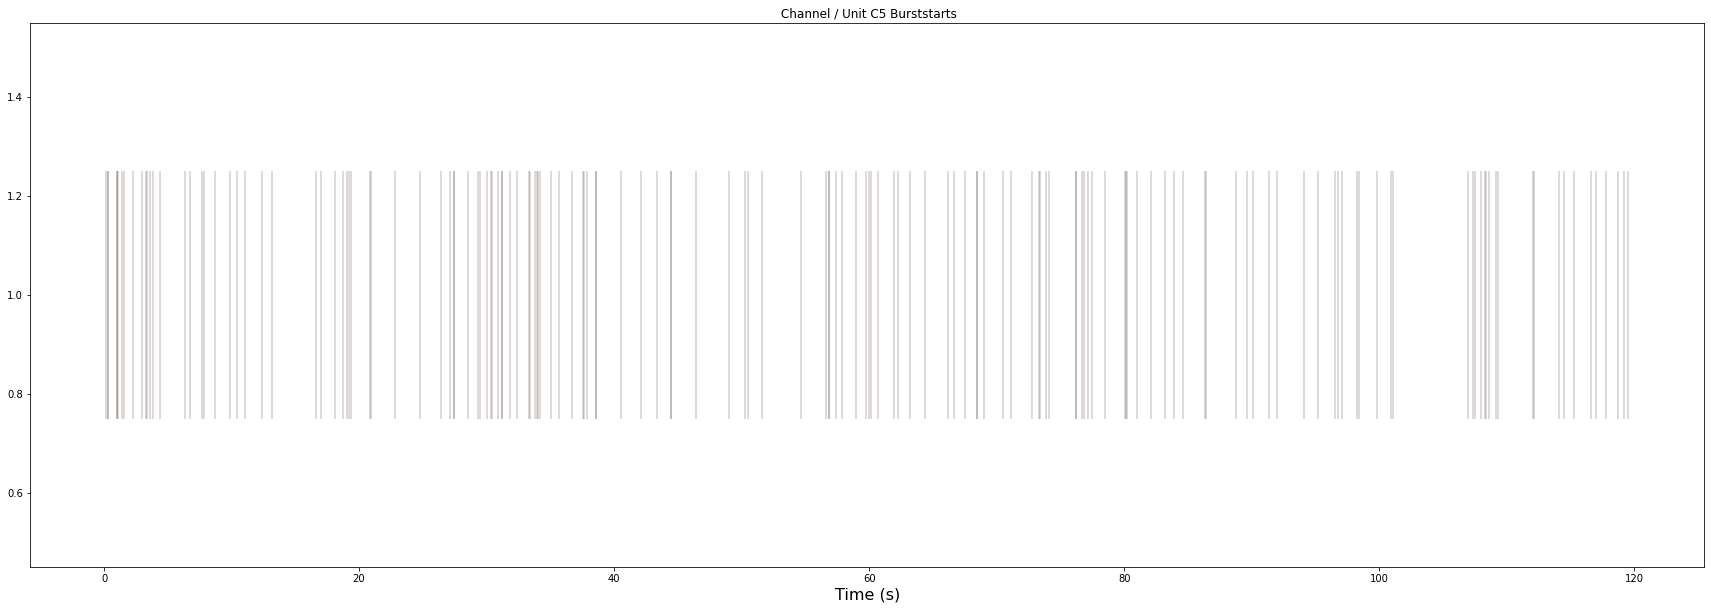

In [191]:
st_neurons = st_channel
for key in burststart_end_dic:
    burststarts_array = []
    burstend_array = []
    for i in range(0, len(burststart_end_dic[key])):
        start = burststart_end_dic[key][i][0]*scale_factor_for_second
        end = burststart_end_dic[key][i][1]*scale_factor_for_second
        burststarts_array.append(start)
        burstend_array.append(end)

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    #burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.eventplot(burststarts_array, linelengths = 1, linewidth = 1, color='#F27F1B')
    ax.eventplot(burstend_array, linelengths = 0.75, linewidth = 1, color='#04B2D9')
    ax.eventplot(array, linelengths= 0.5, linewidth = 0.3, color='#260B01')
    #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
    ax.set_xlabel('Time (s)', fontsize=16)
    ax.set_title(' Channel / Unit '+str(key) +' Burststarts')
#ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
#ax.set_ylabel('Channel '+str(key) +' Burststarts')


    plt.show()
    #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
    #plt.close()

In [72]:
burststart_end_dic

{'R12': [],
 'R4': [(278680, 354680),
  (16739560, 16944960),
  (29896520, 31234080),
  (60618240, 60850080),
  (62549400, 62877400),
  (68718360, 68773080),
  (90206680, 90864840),
  (96350040, 97077600),
  (105348800, 105633480),
  (109862600, 110002640)],
 'F11': [(171680, 470720),
  (10615480, 11702960),
  (12748680, 12948040),
  (13313320, 14209440),
  (15124520, 15417000),
  (15833720, 17367800),
  (20511800, 22126560),
  (22767320, 23214560),
  (23809000, 24333520),
  (26278400, 26617680),
  (27766400, 28823080),
  (29791400, 36456040),
  (49957520, 50106920),
  (59723640, 60166680),
  (60450600, 61073160),
  (61632840, 62513880),
  (62918960, 63741960),
  (64071560, 64575960),
  (64861200, 66384080),
  (66654040, 67618520),
  (68781280, 70695720),
  (70903240, 71270880),
  (71627600, 72083640),
  (72550520, 73398160),
  (73633480, 73941120),
  (75375040, 83203720),
  (103737800, 104188040),
  (104604160, 104967280),
  (105388200, 105658680),
  (105994560, 106327160),
  (1072683

For every channel:
1. get the time each unit is bursting -> can be used for heatmap
2. make dictionary for simultaneously bursting units
3. cluster together bursting spikes 
4. heatmap of bursts and detected spikes
5. function that extracts detected spikes from dataframe 

In [34]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursting_time_per_unit_dic = {}
for key in burststart_end_dic:
    time = 0
    for i in burststart_end_dic[key]:
        bursttime = i[1] - i[0]
        time = time + bursttime
    bursting_time_per_unit_dic[key] = time*scale_factor_for_second # kein tick, vorher bereits drin

In [35]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursts_per_unit_dic = {}
for key in burststart_end_dic:
    number_of_bursts = 0
    for i in burststart_end_dic[key]:
        number_of_bursts += 1
    bursts_per_unit_dic[key] = number_of_bursts

In [46]:
bursts_per_unit_dic

{0: 1,
 1: 8,
 2: 1,
 3: 1,
 10: 1,
 11: 3,
 12: 4,
 13: 3,
 7: 8,
 8: 8,
 9: 8,
 100: 6,
 101: 2,
 98: 2,
 99: 4,
 102: 6,
 103: 5,
 104: 32,
 105: 26,
 106: 20,
 107: 12,
 108: 0,
 109: 2,
 110: 3,
 111: 4,
 112: 1,
 113: 27,
 114: 0,
 115: 0,
 117: 6,
 116: 9,
 138: 8,
 139: 11,
 140: 4,
 141: 4,
 142: 9,
 143: 5,
 118: 2,
 35: 6,
 119: 4,
 120: 5,
 121: 4,
 122: 3,
 123: 2,
 124: 3,
 125: 10,
 126: 6,
 127: 0,
 128: 0,
 129: 38,
 130: 31,
 131: 3,
 132: 17,
 133: 1,
 134: 13,
 135: 2,
 136: 49,
 137: 23,
 14: 8,
 15: 0,
 16: 0,
 144: 1,
 145: 1,
 146: 0,
 147: 39,
 148: 30,
 149: 0,
 150: 14,
 151: 1,
 152: 4,
 153: 29,
 154: 22,
 155: 2,
 156: 18,
 157: 7,
 158: 2,
 159: 24,
 160: 7,
 161: 17,
 162: 20,
 163: 31,
 164: 61,
 165: 23,
 166: 1,
 167: 39,
 168: 9,
 169: 2,
 17: 11,
 170: 9,
 171: 7,
 172: 17,
 173: 6,
 174: 17,
 175: 7,
 176: 7,
 177: 1,
 178: 2,
 179: 0,
 180: 24,
 181: 5,
 18: 3,
 19: 23,
 20: 5,
 182: 50,
 183: 10,
 184: 0,
 185: 1,
 186: 14,
 187: 0,
 188: 23,
 18

In [192]:
# this function takes the dictionary with every burst start and stop and returns a dictionary
# where every unit is a key and the values are tuples consisting of keys of connected units (i.e., bursting together)
# and the number of shared bursts


burst_connections_dic = {}


for key in burststart_end_dic:
    other_keys = list(burststart_end_dic.keys())
    other_keys.remove(key)
    connected_unit_list = []
    for j in other_keys:
        number_of_bursts = 0
        time_shared = 0
        for i in burststart_end_dic[key]:
            start, end = i[0], i[1]
            for m in burststart_end_dic[j]:
                other_start = m[0]
                other_end = m[1]
                if (other_start > start) & (other_start < end):
                    if other_end >= end:
                        time_shared = time_shared + (end - other_start)
                    else:
                        time_shared = time_shared + (other_end - other_start)
                    number_of_bursts += 1
                    
        if number_of_bursts > 0:
            connected_unit_list.append((j, number_of_bursts, time_shared*scale_factor_for_second))        
    burst_connections_dic[key] = connected_unit_list
        
        


In [193]:
burst_connections_dic

{'R12': [],
 'R4': [('P3', 1, 0.02284), ('P5', 1, 0.05688)],
 'F11': [('D12', 16, 4.3214),
  ('C12', 2, 0.15164),
  ('K11', 1, 0.06896),
  ('R9', 1, 0.07592),
  ('D9', 15, 3.5447599999999997),
  ('E15', 28, 7.630439999999999),
  ('B4', 2, 0.1348),
  ('E11', 6, 2.22092),
  ('D11', 25, 4.57528),
  ('N13', 2, 0.15828),
  ('O7', 1, 0.0822),
  ('C11', 16, 2.2219599999999997),
  ('E7', 1, 0.02964),
  ('C16', 1, 0.00932),
  ('A6', 1, 0.05384),
  ('C15', 1, 0.062439999999999996),
  ('M1', 1, 0.08292),
  ('M2', 1, 0.07772),
  ('K2', 1, 0.04196),
  ('D10', 12, 3.88104),
  ('H10', 1, 0.05228),
  ('F12', 24, 7.28712),
  ('D6', 2, 0.12683999999999998),
  ('B15', 1, 0.0822),
  ('R5', 5, 0.32855999999999996),
  ('I5', 1, 0.03512),
  ('M10', 1, 0.07556),
  ('H3', 1, 0.08452),
  ('C6', 1, 0.08408),
  ('D13', 18, 2.2619599999999997),
  ('F15', 35, 5.07092),
  ('E14', 21, 4.18976),
  ('L11', 1, 0.0624),
  ('P4', 1, 0.0067599999999999995),
  ('F7', 1, 0.055639999999999995),
  ('E12', 4, 0.44876),
  ('E13'

In [194]:
np.save(filebase+'_burst_connections_dic.npy', burst_connections_dic)

In [37]:
labels = sorted(list(burst_connections_dic))

In [38]:
labels = list(burst_connections_dic)

In [39]:
shared_frame = pd.DataFrame(index=labels, columns=labels)

In [40]:
len(np.unique(shared_frame.index))

124

In [41]:
for row in shared_frame:
    for conncected_unit in burst_connections_dic[row]:
        other_unit = conncected_unit[0]
        shared_burst_time = conncected_unit[2]
        shared_frame.loc[row, other_unit] = shared_burst_time

In [34]:
#completeframe.loc['unit_ids_2']=completeframe['unit_ids']

In [42]:
shared_frame = shared_frame.fillna(0)

In [43]:
# normalization
#df_norm_col=(shared_frame-shared_frame.mean().max())/shared_frame.mean().std()

In [44]:
#df = pd.DataFrame(abs(frame_array), columns=unit_ids_for_frame, index=unit_ids_for_frame)

In [45]:
shared_frame

R12       R4      F11      D12  D5      C12      K11       N9       R9  \
R12    0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.00000   
R4     0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.07484   
F11    0  0.07600  0.00000  7.78404   0  0.34904  0.41504  0.11652  0.07592   
D12    0  0.00000  0.00000  0.00000   0  0.34904  0.15372  0.11652  0.00000   
D5     0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.00000   
..   ...      ...      ...      ...  ..      ...      ...      ...      ...   
E16    0  0.00000  0.00000  0.17464   0  0.16888  0.00000  0.00000  0.00000   
D4     0  0.07600  0.00000  0.00000   0  0.00000  0.00192  0.02116  0.07616   
C10    0  0.00000  0.00000  0.13580   0  0.22412  0.06896  0.00000  0.00000   
F14    0  0.24516  0.97104  4.09908   0  0.30492  0.72652  0.11652  0.08224   
C5     0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.00000   

          F2  ...  B10       N1       K5  I9       E9      E16       D4  \
R12  0.00000  ...    0  0.00000  0.00000   0  0.00000  0.00000  0.00000   
R4   0.00000  ...    0  0.00000  0.00000   0  0.06920  0.00000  0.00000   
F11  0.00000  ...    0  0.08408  0.07624   0  1.52152  1.31864  1.35472   
D12  0.00000  ...    0  0.00000  0.00000   0  1.08728  1.04060  1.00780   
D5   0.00000  ...    0  0.00000  0.00000   0  0.00000  0.00000  0.00000   
..       ...  ...  ...      ...      ...  ..      ...      ...      ...   
E16  0.00000  ...    0  0.00000  0.00000   0  0.15064  0.00000  0.00000   
D4   0.00000  ...    0  0.08412  0.00000   0  0.06920  0.09184  0.00000   
C10  0.00000  ...    0  0.00000  0.00000   0  0.05400  0.27716  0.04136   
F14  0.01892  ...    0  0.08412  0.08140   0  1.04276  1.31864  1.35720   
C5   0.00000  ...    0  0.00000  0.00000   0  0.00000  0.00000  0.00000   

         C10       F14  C5  
R12  0.00000   0.00000   0  
R4   0.00000   0.00000   0  
F11  0.88640  11.10272   0  
D12  0.74656   3.14956   0  
D5   0.00000   0.00000   0  
..       ...       ...  ..  
E16  0.02840   0.00000   0  
D4   0.02404   0.07980   0  
C10  0.00000   0.00000   0  
F14  0.78160   0.00000   0  
C5   0.00000   0.00000   0  

[124 rows x 124 columns]

In [46]:
df = df.fillna(0)

In [47]:
shared_frame

R12       R4      F11      D12  D5      C12      K11       N9       R9  \
R12    0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.00000   
R4     0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.07484   
F11    0  0.07600  0.00000  7.78404   0  0.34904  0.41504  0.11652  0.07592   
D12    0  0.00000  0.00000  0.00000   0  0.34904  0.15372  0.11652  0.00000   
D5     0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.00000   
..   ...      ...      ...      ...  ..      ...      ...      ...      ...   
E16    0  0.00000  0.00000  0.17464   0  0.16888  0.00000  0.00000  0.00000   
D4     0  0.07600  0.00000  0.00000   0  0.00000  0.00192  0.02116  0.07616   
C10    0  0.00000  0.00000  0.13580   0  0.22412  0.06896  0.00000  0.00000   
F14    0  0.24516  0.97104  4.09908   0  0.30492  0.72652  0.11652  0.08224   
C5     0  0.00000  0.00000  0.00000   0  0.00000  0.00000  0.00000  0.00000   

          F2  ...  B10       N1       K5  I9       E9      E16       D4  \
R12  0.00000  ...    0  0.00000  0.00000   0  0.00000  0.00000  0.00000   
R4   0.00000  ...    0  0.00000  0.00000   0  0.06920  0.00000  0.00000   
F11  0.00000  ...    0  0.08408  0.07624   0  1.52152  1.31864  1.35472   
D12  0.00000  ...    0  0.00000  0.00000   0  1.08728  1.04060  1.00780   
D5   0.00000  ...    0  0.00000  0.00000   0  0.00000  0.00000  0.00000   
..       ...  ...  ...      ...      ...  ..      ...      ...      ...   
E16  0.00000  ...    0  0.00000  0.00000   0  0.15064  0.00000  0.00000   
D4   0.00000  ...    0  0.08412  0.00000   0  0.06920  0.09184  0.00000   
C10  0.00000  ...    0  0.00000  0.00000   0  0.05400  0.27716  0.04136   
F14  0.01892  ...    0  0.08412  0.08140   0  1.04276  1.31864  1.35720   
C5   0.00000  ...    0  0.00000  0.00000   0  0.00000  0.00000  0.00000   

         C10       F14  C5  
R12  0.00000   0.00000   0  
R4   0.00000   0.00000   0  
F11  0.88640  11.10272   0  
D12  0.74656   3.14956   0  
D5   0.00000   0.00000   0  
..       ...       ...  ..  
E16  0.02840   0.00000   0  
D4   0.02404   0.07980   0  
C10  0.00000   0.00000   0  
F14  0.78160   0.00000   0  
C5   0.00000   0.00000   0  

[124 rows x 124 columns]

In [48]:
corr_mat = df.corr().stack().reset_index(name="correlation")

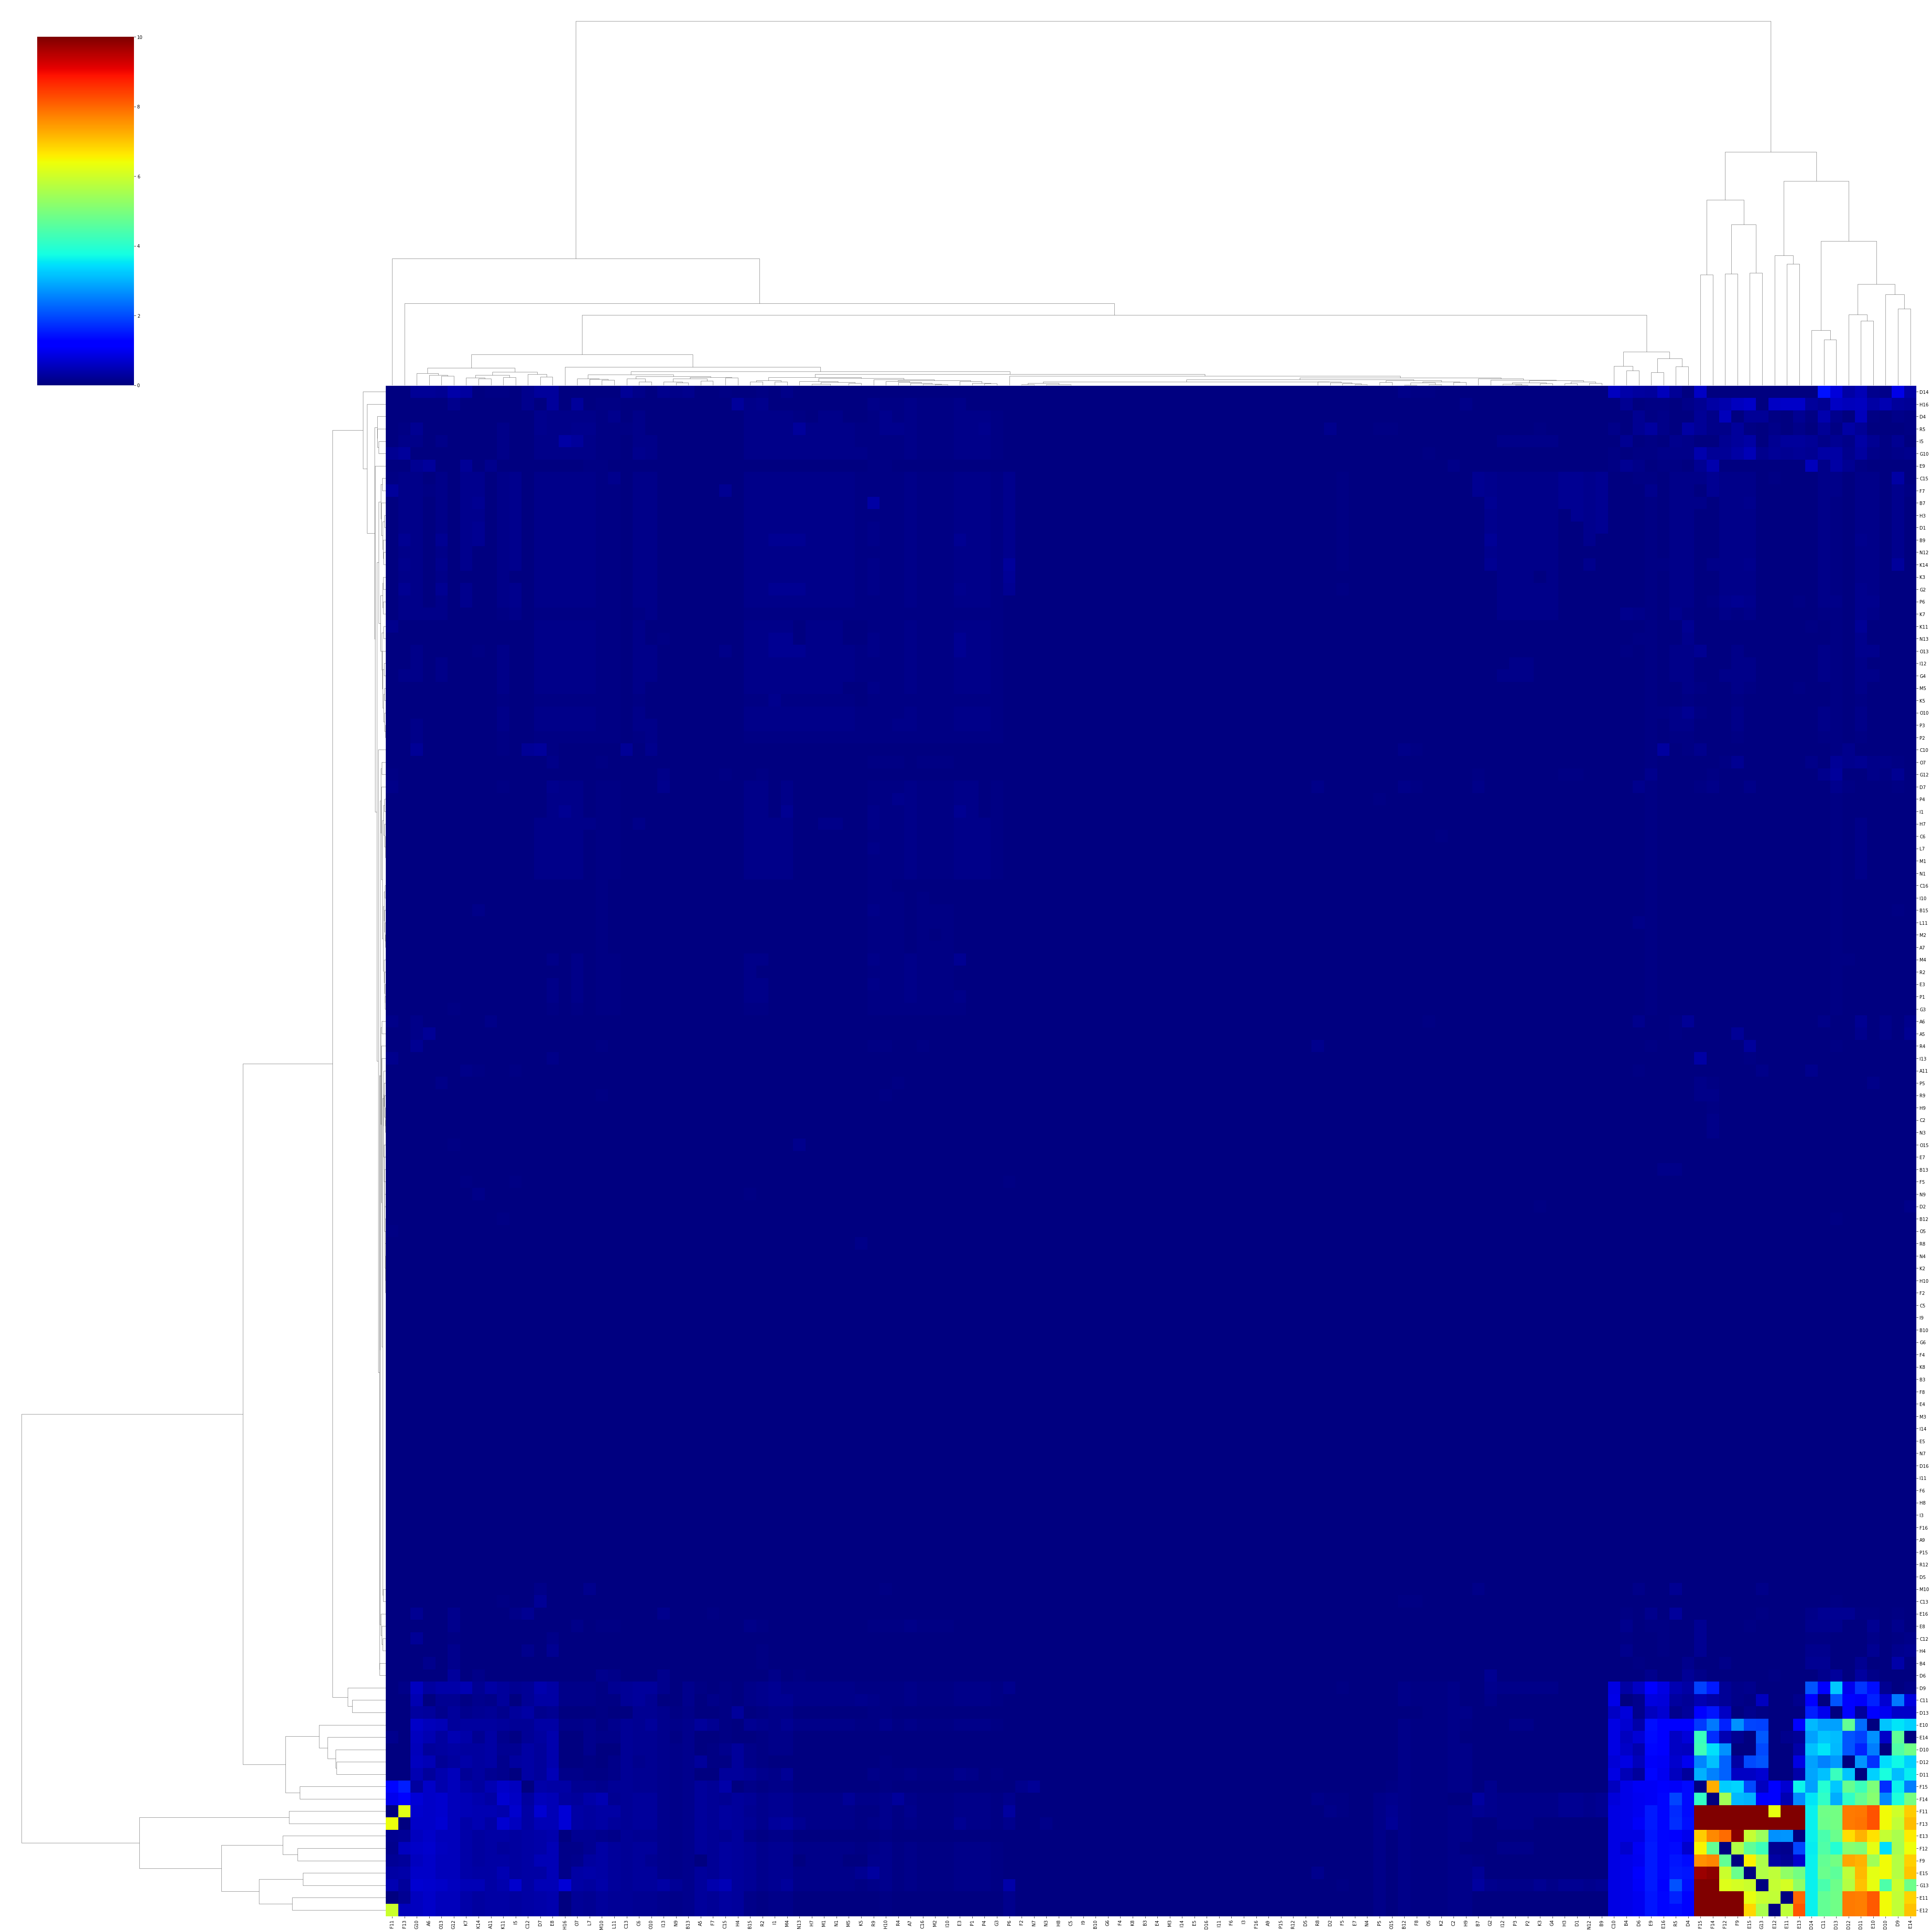

In [178]:
sns.clustermap(shared_frame, cmap="jet", method='complete', vmax = 10, figsize=(60,60))

<AxesSubplot:>

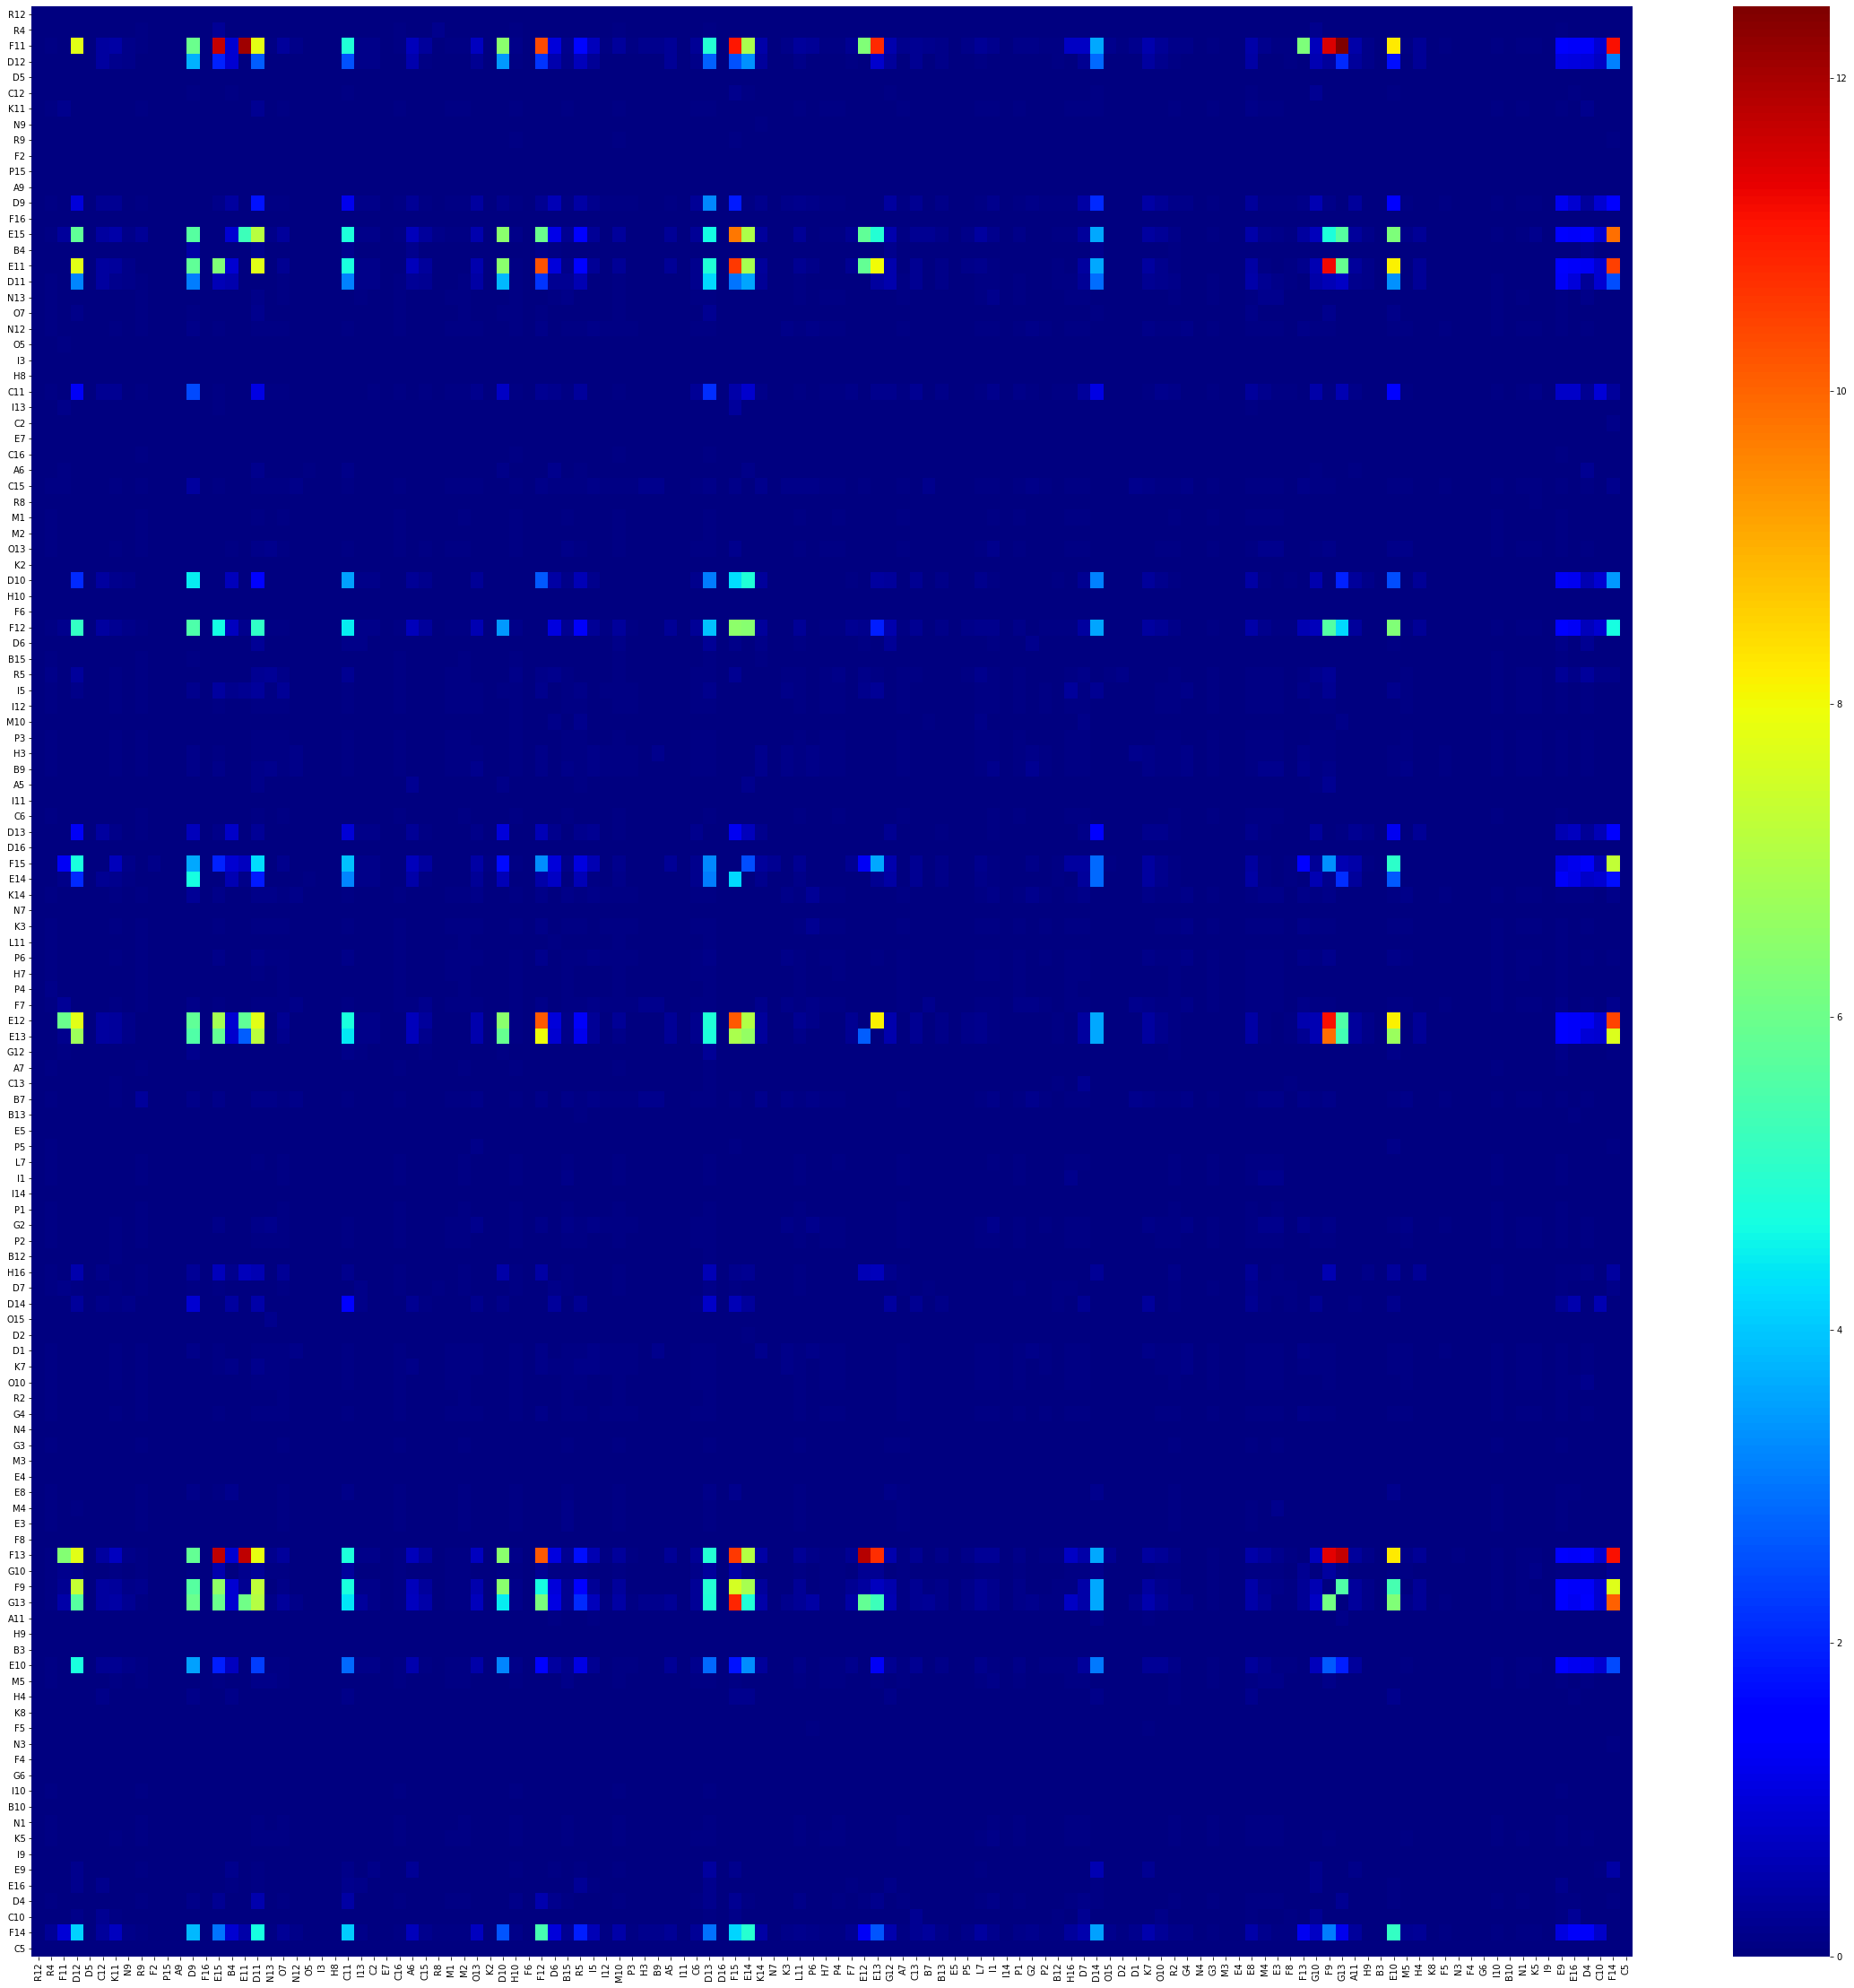

In [50]:
fig, ax = plt.subplots(1,1, figsize=(40,40))
sns.heatmap(shared_frame, cmap="jet", ax=ax)


# binning spikes from the spike train channels
## first for each channel/unit and make it to another dictionary

## second for the whole recordings, so again there is one array with every detected spike

In [53]:
# find the recording length:
maximal_spike = np.max(np.max(list(st_channel.values())))*40*scale_factor_for_second
length_recording = np.ceil(maximal_spike)

In [54]:
length_recording

120.0

In [55]:
# bin the spikedictionaries per channel or unit into bins, the recording time needs to be generalized
binsize = 50 # in miliseconds
scale_factor_for_milisecond = 1e-03
binned_spike_dictionary = {}


bins= np.arange(0, length_recording*1000+binsize, binsize) # times 1000 to get the miliseconds
for key in st_channel:
    x = np.asarray(st_channel[key])*scale_factor_for_milisecond*tick
    binned_channel = np.histogram(x, bins)
    binned_spike_dictionary[key]  = binned_channel[0]
    
    
    
    

In [56]:
bins

array([0.0000e+00, 5.0000e+01, 1.0000e+02, ..., 1.1990e+05, 1.1995e+05,
       1.2000e+05])

In [62]:
labels = list(binned_spike_dictionary.keys())

In [63]:
binlist = bins

In [64]:
df = pd.DataFrame(data=binned_spike_dictionary)

In [65]:
df

R12  R4  F11  D12  D5  C12  K11  N9  R9  F2  ...  B10  N1  K5  I9  E9  \
0       0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
1       0   0    0    0   0    1    0   0   0   0  ...    0   0   0   0   0   
2       0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
3       0   0    1    0   0    0    0   0   0   0  ...    0   0   0   0   0   
4       0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
...   ...  ..  ...  ...  ..  ...  ...  ..  ..  ..  ...  ...  ..  ..  ..  ..   
2395    0   0    0    0   0    0    0   0   1   0  ...    0   0   0   0   0   
2396    0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
2397    0   0    0    0   0    0    1   0   0   0  ...    0   0   0   0   0   
2398    0   1    0    0   0    0    1   2   1   0  ...    1   0   1   0   0   
2399    0   0    2    0   0    0    0   0   0   0  ...    0   0   0   0   0   

      E16  D4  C10  F14  C5  
0       0   0    0    0   0  
1       1   0    0    1   0  
2       0   0    0    0   0  
3       0   0    0    1   1  
4       0   0    0    0   0  
...   ...  ..  ...  ...  ..  
2395    1   0    0    0   0  
2396    0   0    0    0   0  
2397    0   0    1    2   0  
2398    1   1    0    1   0  
2399    0   0    1    1   0  

[2400 rows x 124 columns]

In [66]:
correlated = df.corr()

In [67]:
correlated

R12        R4       F11       D12        D5       C12       K11  \
R12  1.000000  0.014434  0.000010  0.014002  0.040012 -0.008184 -0.024784   
R4   0.014434  1.000000  0.005481  0.005467  0.016597 -0.006742  0.016128   
F11  0.000010  0.005481  1.000000  0.686212  0.011011  0.215852  0.020139   
D12  0.014002  0.005467  0.686212  1.000000 -0.027279  0.202460  0.001466   
D5   0.040012  0.016597  0.011011 -0.027279  1.000000 -0.000784  0.002304   
..        ...       ...       ...       ...       ...       ...       ...   
E16 -0.017596 -0.004038  0.346860  0.295952  0.012622  0.115077 -0.026099   
D4   0.027705 -0.002850  0.052883  0.029671  0.069284  0.000135  0.009901   
C10 -0.013123 -0.014950  0.222435  0.219590 -0.003350  0.090990  0.053193   
F14  0.029348  0.020604  0.591552  0.531541 -0.005226  0.171739  0.033550   
C5  -0.006833  0.015327  0.071734  0.037085  0.015899  0.005213 -0.008022   

           N9        R9        F2  ...       B10        N1        K5  \
R12 -0.008664 -0.003604 -0.007107  ... -0.015919  0.000194  0.007674   
R4  -0.020202 -0.000085 -0.002116  ...  0.001450  0.023492 -0.006613   
F11  0.039193  0.037355 -0.000718  ...  0.046613  0.008787  0.055890   
D12  0.002630  0.027764 -0.023274  ...  0.022037 -0.009577  0.051384   
D5   0.002951  0.007057  0.018194  ...  0.003934  0.016079  0.000230   
..        ...       ...       ...  ...       ...       ...       ...   
E16  0.045363  0.000228  0.032106  ...  0.026191 -0.006720  0.043717   
D4  -0.011376  0.031289  0.035439  ...  0.013094  0.050758  0.042698   
C10  0.042683  0.047416  0.030369  ...  0.074872  0.009288  0.075688   
F14  0.033189  0.025120  0.032136  ... -0.003704 -0.001024  0.054995   
C5  -0.003224 -0.002739 -0.024161  ... -0.003241  0.022529 -0.005563   

           I9        E9       E16        D4       C10       F14        C5  
R12 -0.008211  0.008070 -0.017596  0.027705 -0.013123  0.029348 -0.006833  
R4  -0.010158  0.012626 -0.004038 -0.002850 -0.014950  0.020604  0.015327  
F11  0.027072  0.343164  0.346860  0.052883  0.222435  0.591552  0.071734  
D12  0.001945  0.330982  0.295952  0.029671  0.219590  0.531541  0.037085  
D5  -0.005791  0.019277  0.012622  0.069284 -0.003350 -0.005226  0.015899  
..        ...       ...       ...       ...       ...       ...       ...  
E16 -0.019531  0.120657  1.000000  0.032183  0.080216  0.251044  0.002475  
D4   0.044187  0.038065  0.032183  1.000000  0.072474  0.052387  0.013493  
C10  0.016874  0.161484  0.080216  0.072474  1.000000  0.154120  0.035276  
F14  0.019567  0.226285  0.251044  0.052387  0.154120  1.000000  0.053566  
C5  -0.009833  0.053275  0.002475  0.013493  0.035276  0.053566  1.000000  

[124 rows x 124 columns]

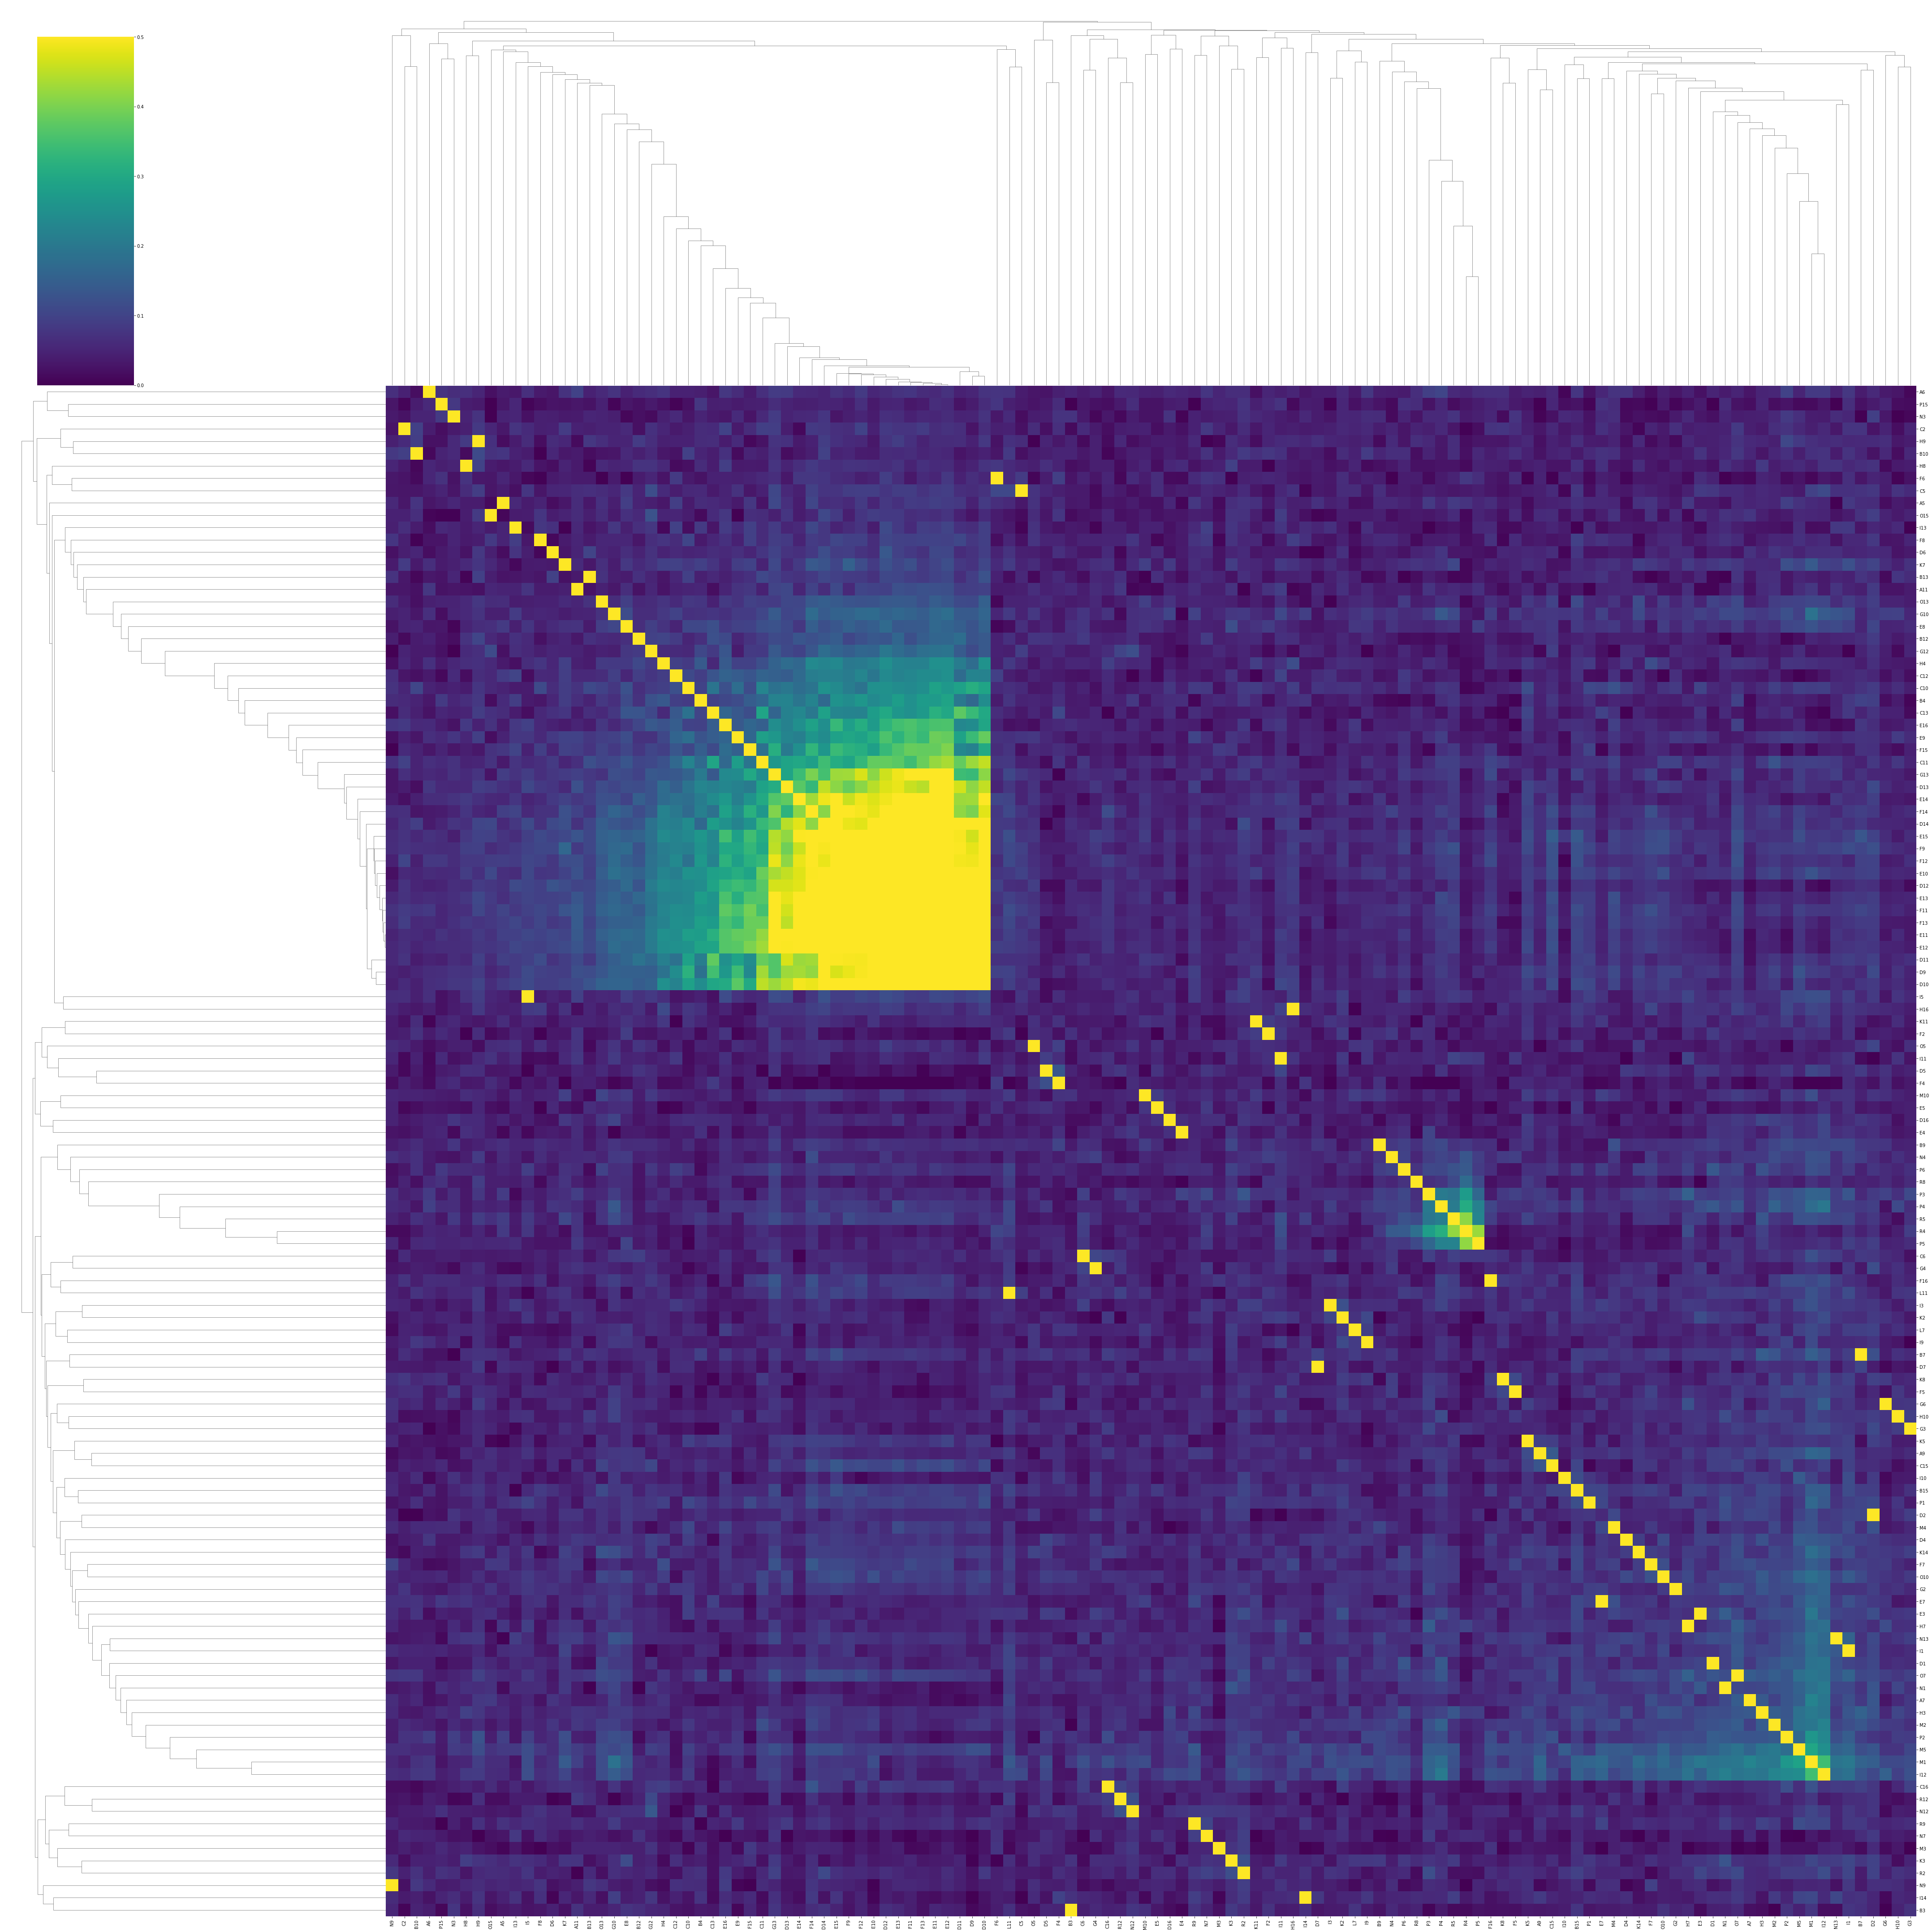

In [71]:
sns.clustermap(correlated, cmap="viridis", method='average', metric='correlation', standard_scale=True, vmax = .5, figsize=(60,60))

In [58]:
df[:20]

R12  R4  F11  D12  D5  C12  K11  N9  R9  F2  ...  B10  N1  K5  I9  E9  \
0     0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
1     0   0    0    0   0    1    0   0   0   0  ...    0   0   0   0   0   
2     0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
3     0   0    1    0   0    0    0   0   0   0  ...    0   0   0   0   0   
4     0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
5     0   1    8    0   1    0    2   1   2   2  ...    1   4   2   1   1   
6     1   1    2    0   2    0    0   0   0   0  ...    0   1   1   0   2   
7     1   2    1    0   0    0    2   2   3   0  ...    0   2   1   1   1   
8     0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
9     0   0    1    0   0    0    0   0   1   0  ...    0   0   0   0   0   
10    0   0    0    0   0    0    0   0   0   0  ...    0   1   0   0   0   
11    0   0    0    1   1    0    0   0   0   0  ...    0   0   0   0   0   
12    0   0    0    0   1    0    0   1   0   0  ...    0   0   0   1   0   
13    1   0    0    0   0    0    2   0   0   0  ...    0   0   1   0   0   
14    0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
15    0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
16    0   0    0    0   0    0    0   0   0   0  ...    0   0   2   0   0   
17    0   0    1    0   0    0    0   0   1   0  ...    0   1   0   0   0   
18    0   0    0    0   0    0    1   0   0   0  ...    0   0   0   0   0   
19    0   0    0    0   0    1    0   0   0   0  ...    0   0   0   0   0   

    E16  D4  C10  F14  C5  
0     0   0    0    0   0  
1     1   0    0    1   0  
2     0   0    0    0   0  
3     0   0    0    1   1  
4     0   0    0    0   0  
5     0   4    2    4   1  
6     0   4    1    2   1  
7     1   1    0    2   0  
8     0   0    0    0   0  
9     0   0    0    0   0  
10    0   0    0    0   0  
11    0   0    0    0   0  
12    0   0    0    1   0  
13    0   0    0    0   0  
14    0   2    0    0   0  
15    0   0    0    0   0  
16    0   0    0    0   0  
17    0   1    0    0   0  
18    0   0    0    0   0  
19    0   0    0    1   2  

[20 rows x 124 columns]

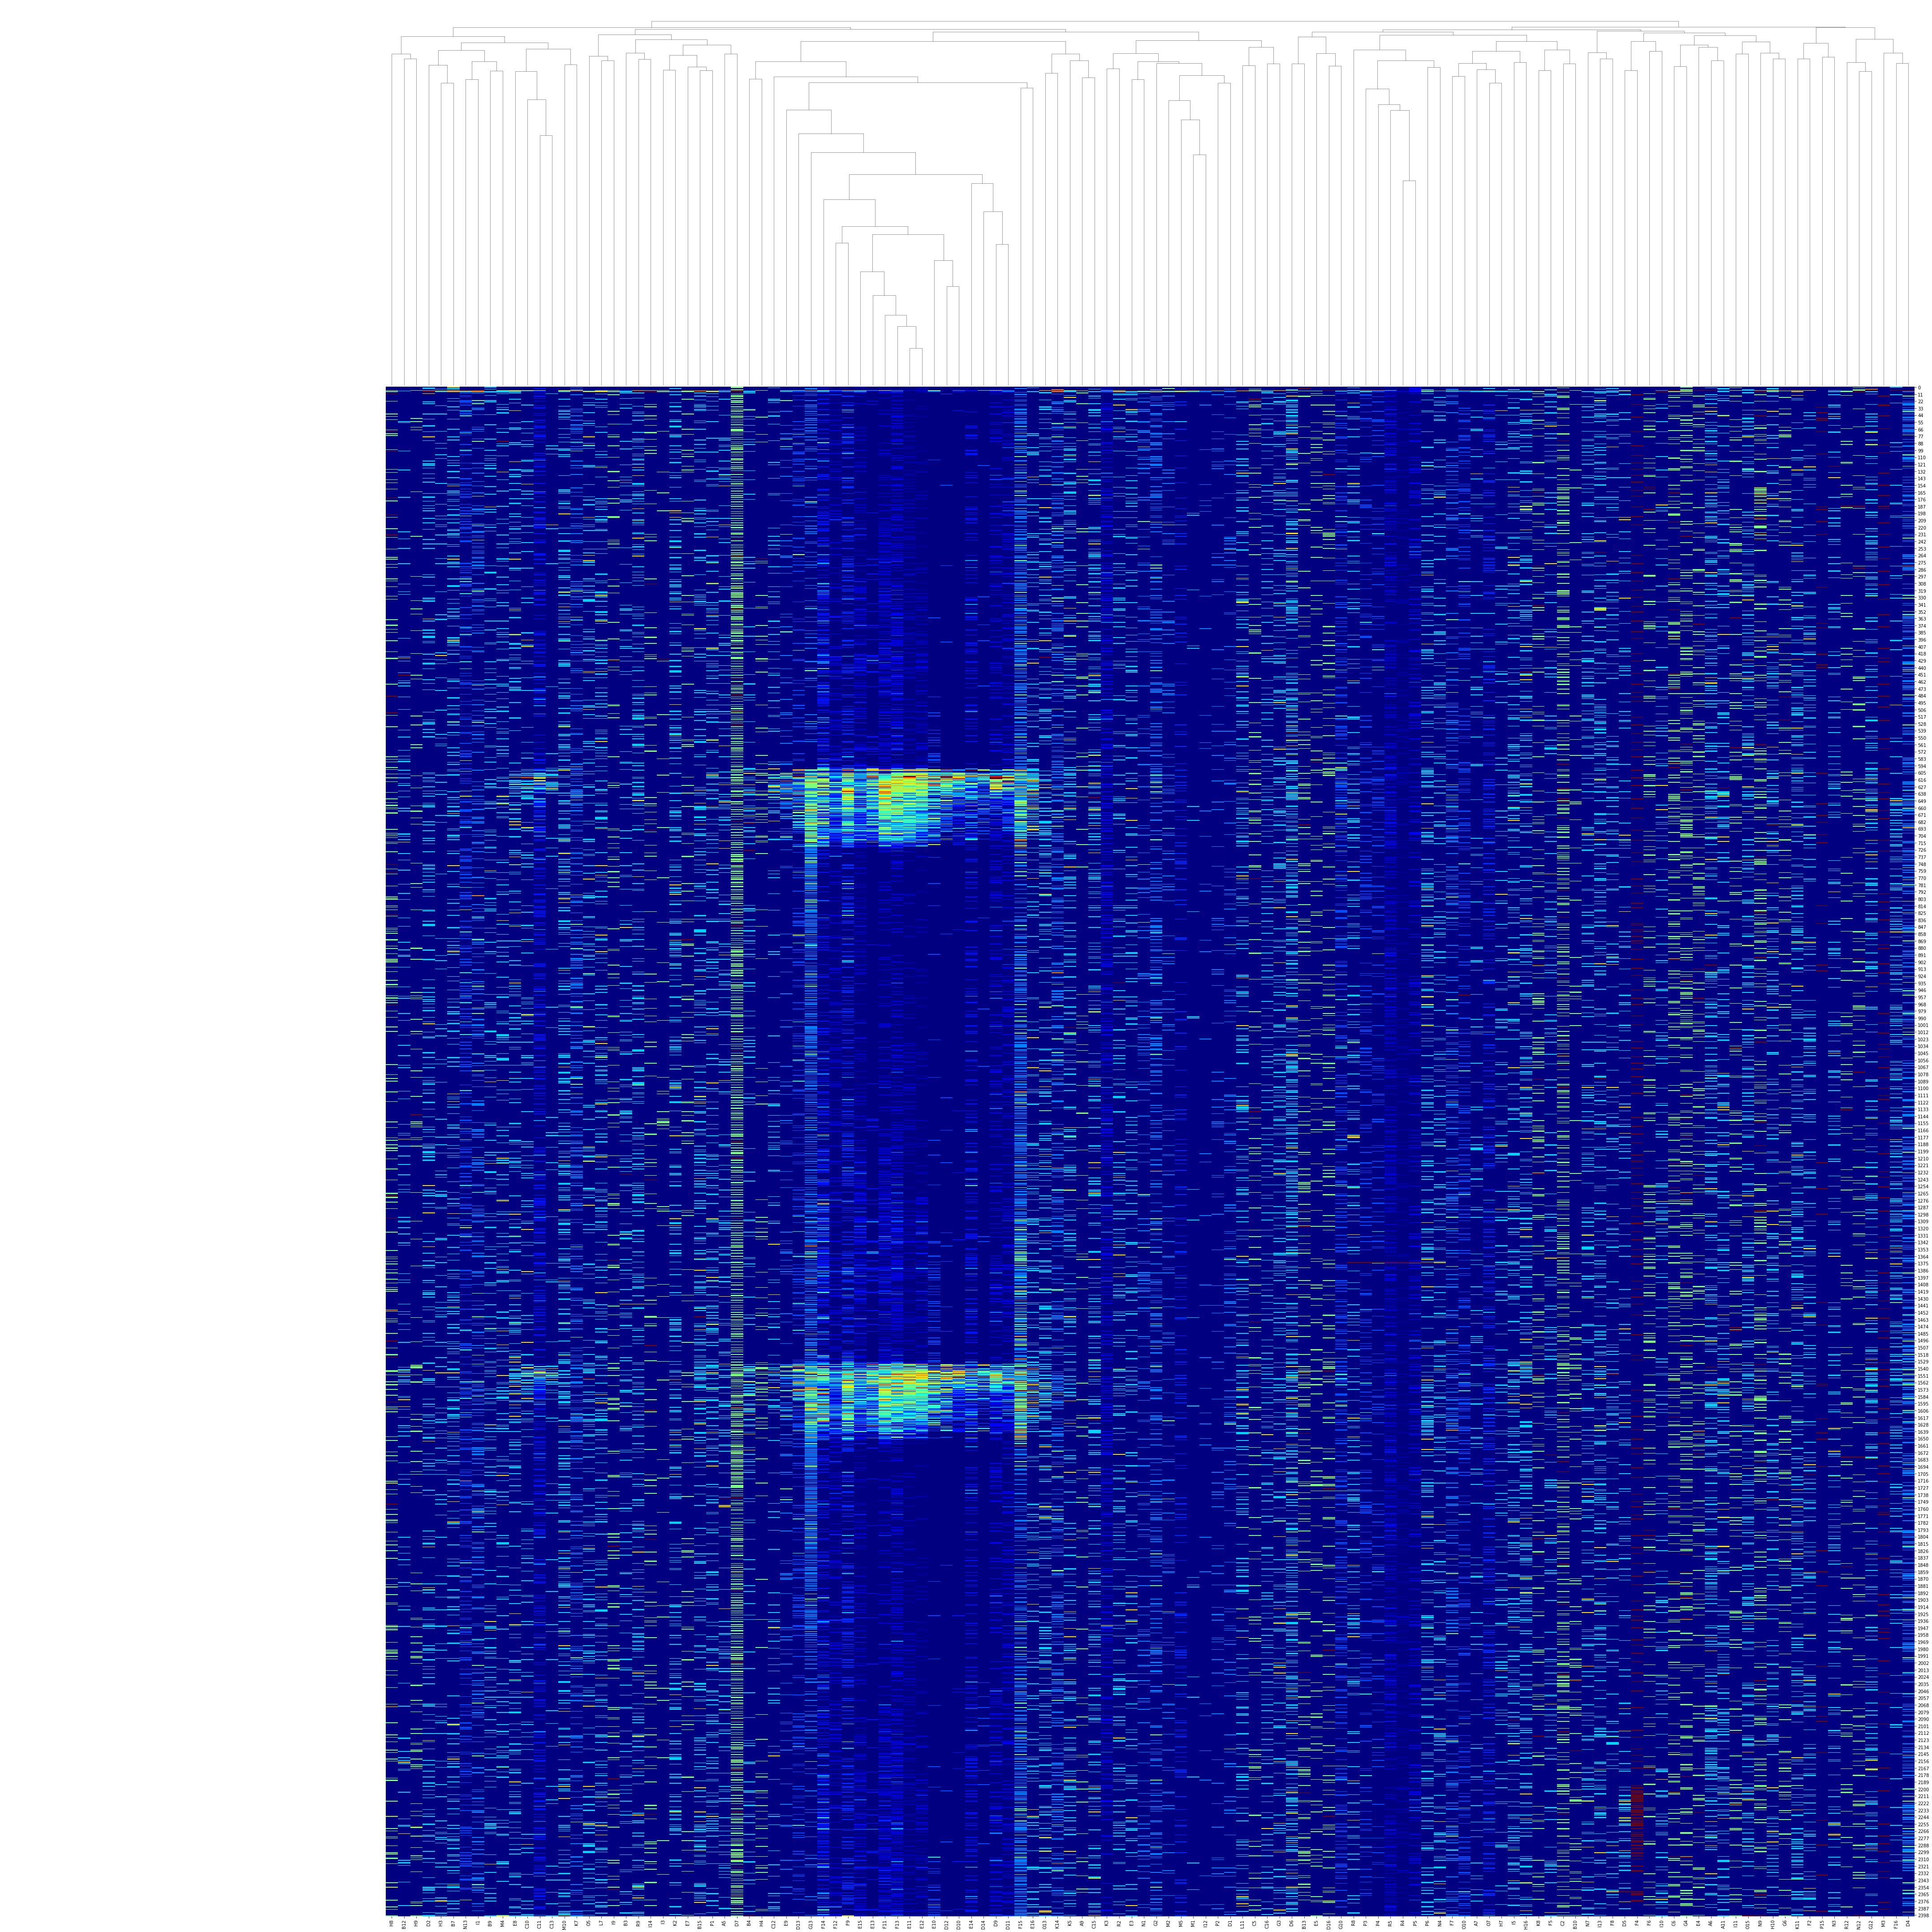

In [72]:
#fig, ax = plt.subplots(1,1, figsize=(30,30))
fig = sns.clustermap(df, cmap="jet", method='complete', metric='correlation', standard_scale=True, row_cluster=False, figsize=(60,60), cbar_pos=None)


#fig.savefig('Cluster_190117_120seconds_50ms_bins_clustering.png', dpi=300)

In [73]:
df

R12  R4  F11  D12  D5  C12  K11  N9  R9  F2  ...  B10  N1  K5  I9  E9  \
0       0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
1       0   0    0    0   0    1    0   0   0   0  ...    0   0   0   0   0   
2       0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
3       0   0    1    0   0    0    0   0   0   0  ...    0   0   0   0   0   
4       0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
...   ...  ..  ...  ...  ..  ...  ...  ..  ..  ..  ...  ...  ..  ..  ..  ..   
2395    0   0    0    0   0    0    0   0   1   0  ...    0   0   0   0   0   
2396    0   0    0    0   0    0    0   0   0   0  ...    0   0   0   0   0   
2397    0   0    0    0   0    0    1   0   0   0  ...    0   0   0   0   0   
2398    0   1    0    0   0    0    1   2   1   0  ...    1   0   1   0   0   
2399    0   0    2    0   0    0    0   0   0   0  ...    0   0   0   0   0   

      E16  D4  C10  F14  C5  
0       0   0    0    0   0  
1       1   0    0    1   0  
2       0   0    0    0   0  
3       0   0    0    1   1  
4       0   0    0    0   0  
...   ...  ..  ...  ...  ..  
2395    1   0    0    0   0  
2396    0   0    0    0   0  
2397    0   0    1    2   0  
2398    1   1    0    1   0  
2399    0   0    1    1   0  

[2400 rows x 124 columns]

In [74]:
df_t = df.transpose()

In [75]:
df_t

0     1     2     3     4     5     6     7     8     9     ...  2390  \
R12     0     0     0     0     0     0     1     1     0     0  ...     0   
R4      0     0     0     0     0     1     1     2     0     0  ...     0   
F11     0     0     0     1     0     8     2     1     0     1  ...     0   
D12     0     0     0     0     0     0     0     0     0     0  ...     0   
D5      0     0     0     0     0     1     2     0     0     0  ...     0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
E16     0     1     0     0     0     0     0     1     0     0  ...     0   
D4      0     0     0     0     0     4     4     1     0     0  ...     0   
C10     0     0     0     0     0     2     1     0     0     0  ...     0   
F14     0     1     0     1     0     4     2     2     0     0  ...     3   
C5      0     0     0     1     0     1     1     0     0     0  ...     1   

     2391  2392  2393  2394  2395  2396  2397  2398  2399  
R12     0     0     0     0     0     0     0     0     0  
R4      0     0     0     0     0     0     0     1     0  
F11     2     1     1     0     0     0     0     0     2  
D12     1     0     0     0     0     0     0     0     0  
D5      0     0     0     0     0     0     0     0     0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
E16     0     0     0     0     1     0     0     1     0  
D4      0     0     2     0     0     0     0     1     0  
C10     0     0     0     0     0     0     1     0     1  
F14     0     0     2     0     0     0     2     1     1  
C5      0     0     0     0     0     0     0     0     0  

[124 rows x 2400 columns]

In [76]:
from scipy.cluster.hierarchy import linkage


In [124]:
linkage_matrix = linkage(df_t, method='ward', metric='euclidean', optimal_ordering=True)

In [125]:
linkage_matrix.shape

(123, 4)

In [126]:
df_t.iloc[16]

0       0
1       0
2       0
3       0
4       0
       ..
2395    0
2396    0
2397    0
2398    0
2399    1
Name: E11, Length: 2400, dtype: int64

In [127]:
linkage_matrix[-4:,2]

array([ 62.28964601, 100.73033307, 123.64004715, 261.34703427])

In [128]:
df_t[64]

R12    0
R4     0
F11    0
D12    0
D5     0
      ..
E16    0
D4     0
C10    0
F14    0
C5     0
Name: 64, Length: 124, dtype: int64

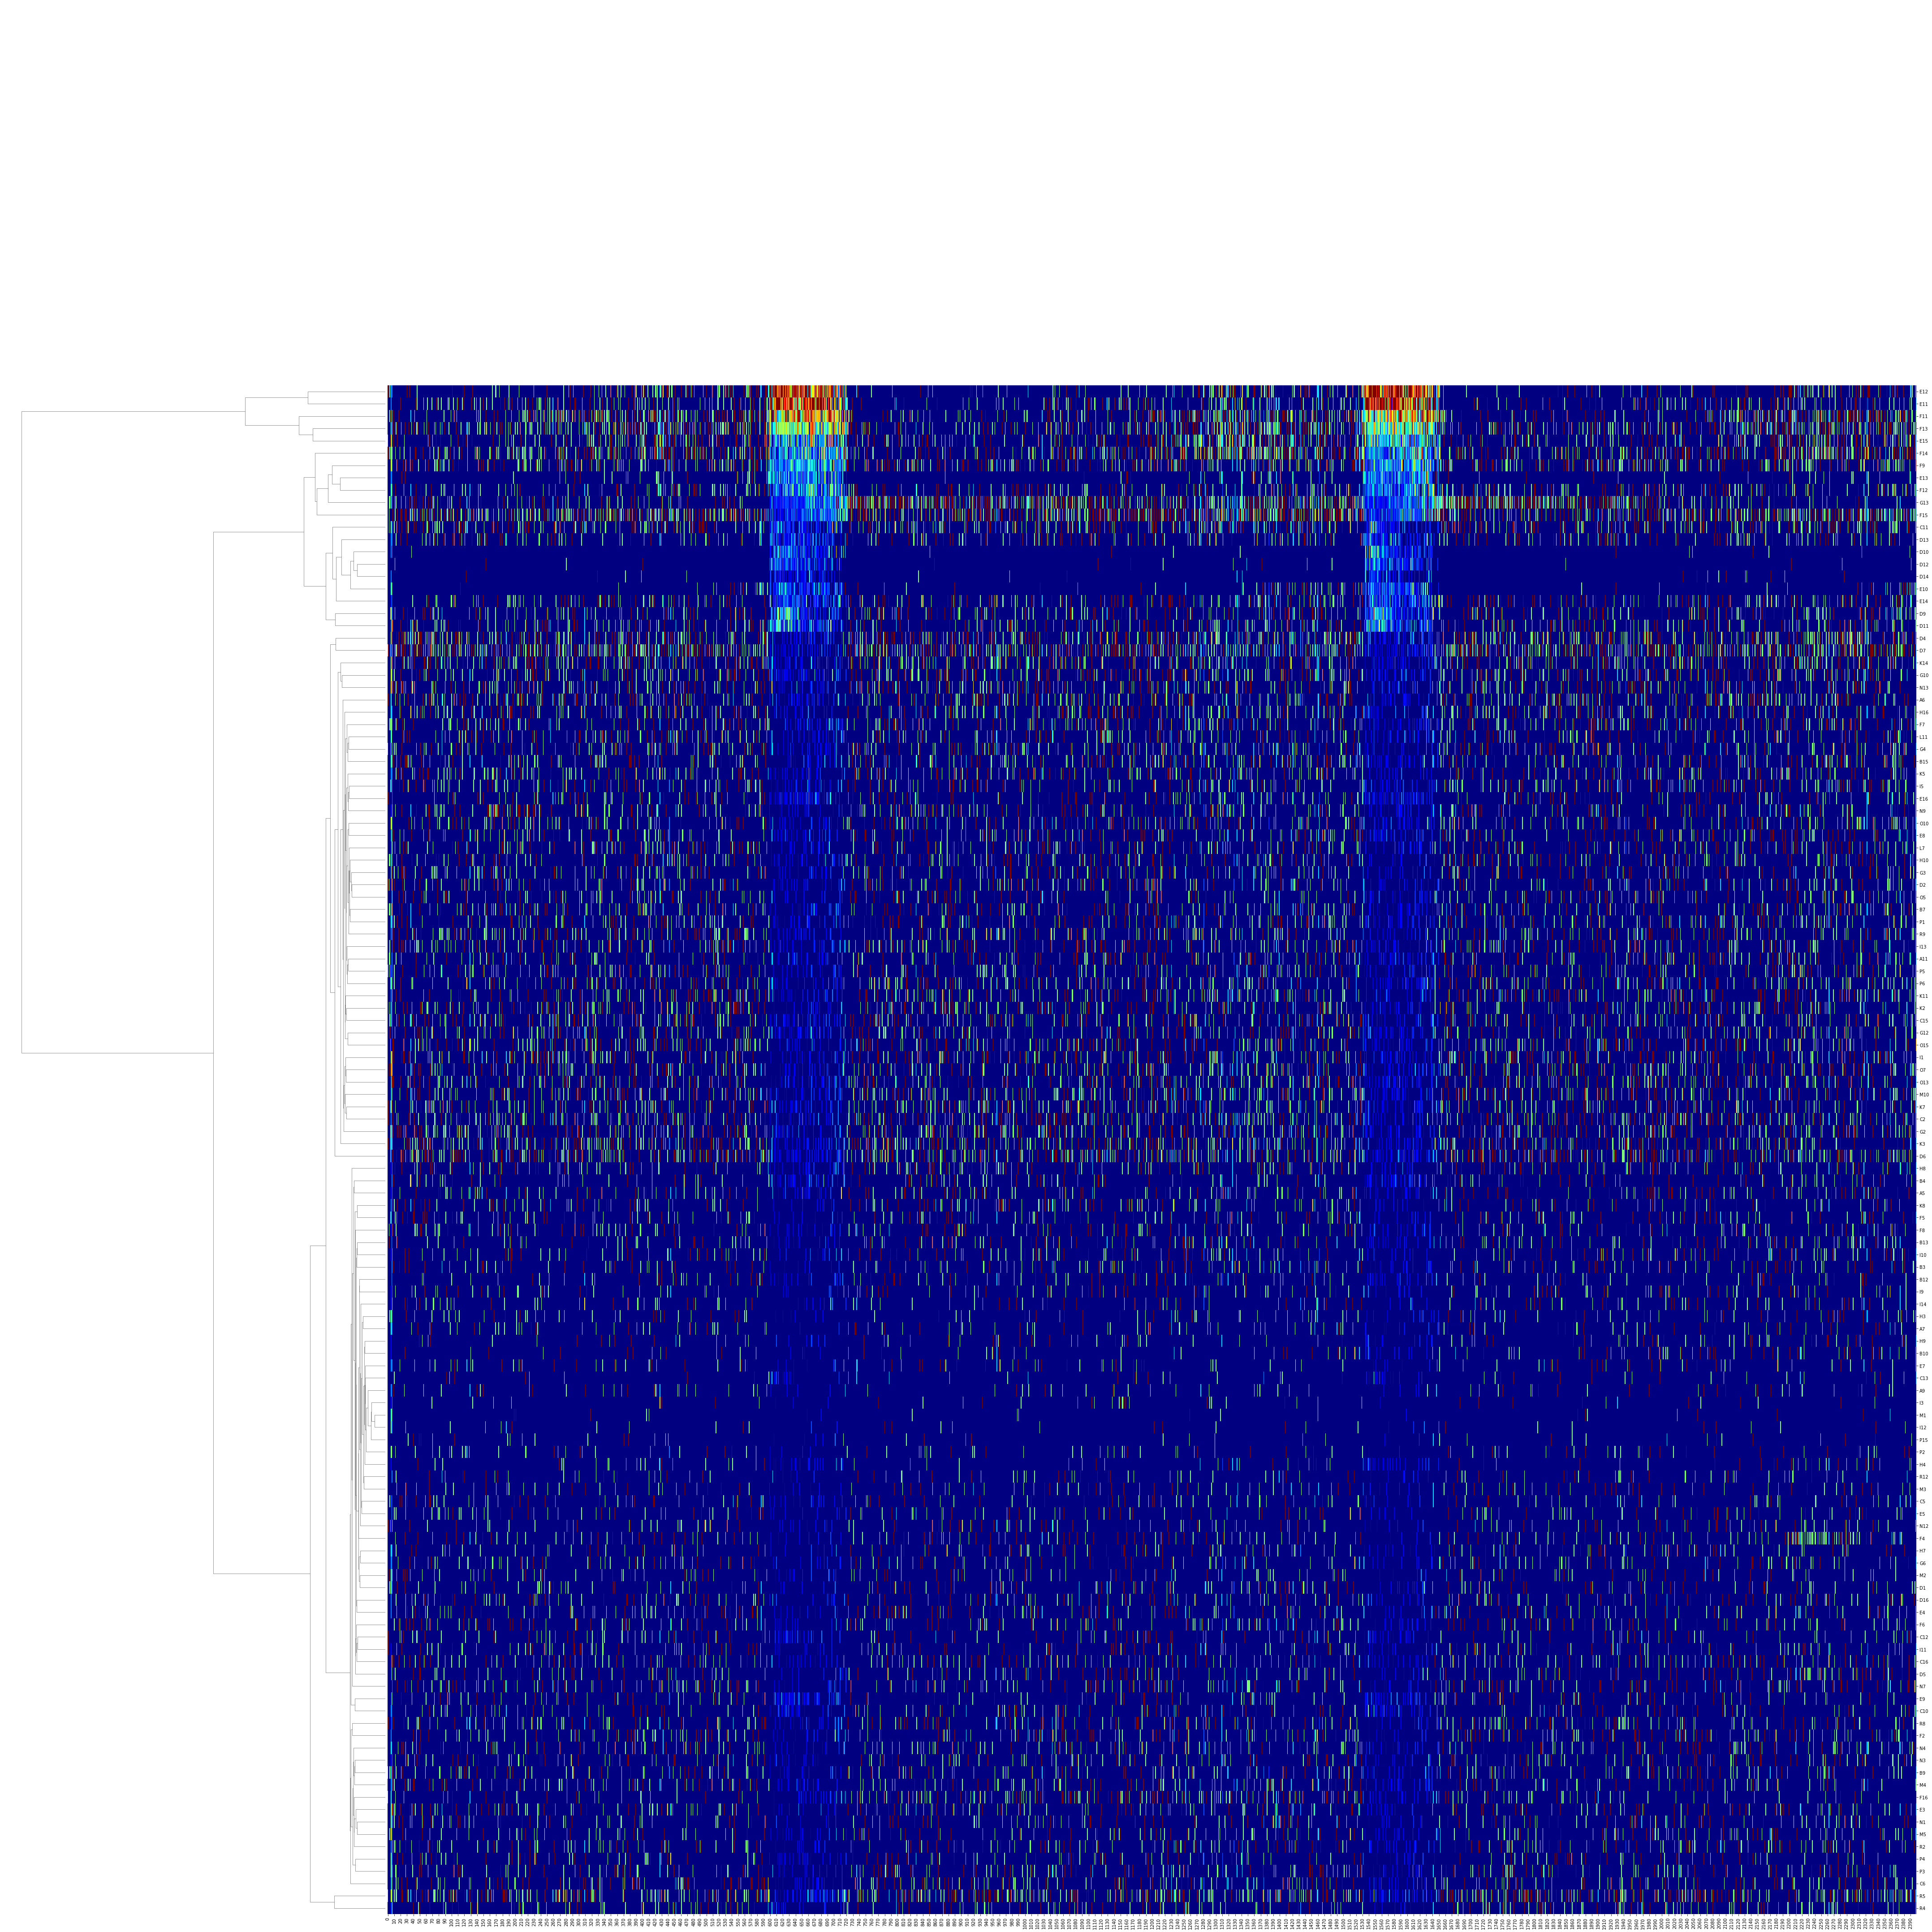

In [129]:
fig = sns.clustermap(df_t, row_linkage=linkage_matrix, col_cluster=False, cmap="jet", method='complete', metric='correlation', standard_scale=True, figsize=(60,60), cbar_pos=None)

In [130]:
from scipy.cluster.hierarchy import cophenet, dendrogram
from scipy.spatial.distance import pdist


<Figure size 1800x720 with 0 Axes>

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram')

Text(0.5, 0, 'sample index')

Text(0, 0.5, 'distance')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [72.5, 72.5, 95.0, 95.0],
  [83.75, 83.75, 105.0, 105.0],
  [55.0, 55.0, 94.375, 94.375],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [142.5, 142.5, 165.0, 165.0],
  [125.0, 125.0, 153.75, 153.75],
  [139.375, 139.375, 175.0, 175.0],
  [115.0, 115.0, 157.1875, 157.1875],
  [185.0, 185.0, 195.0, 195.0],
  [136.09375, 136.09375, 190.0, 190.0],
  [74.6875, 74.6875, 163.046875, 163.046875],
  [205.0, 205.0, 215.0, 215.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [285.0, 285.0, 295.0, 295.0],
  [290.0, 290.0, 305.0, 305.0],
  [275.0, 275.0, 297.5, 297.5],
  [325.0, 325.0, 335.0, 335.0],
  [330.0, 330.0, 345.0, 345.0],
  [315.0, 315.0, 337.5, 337.5],
  [355.0, 355.0, 365.0, 365.0],
  [405.0, 405.0, 415.0, 415.0],
  [395.0, 395.0, 410.0, 410.0],
  [385.0, 385.0, 402.5, 40

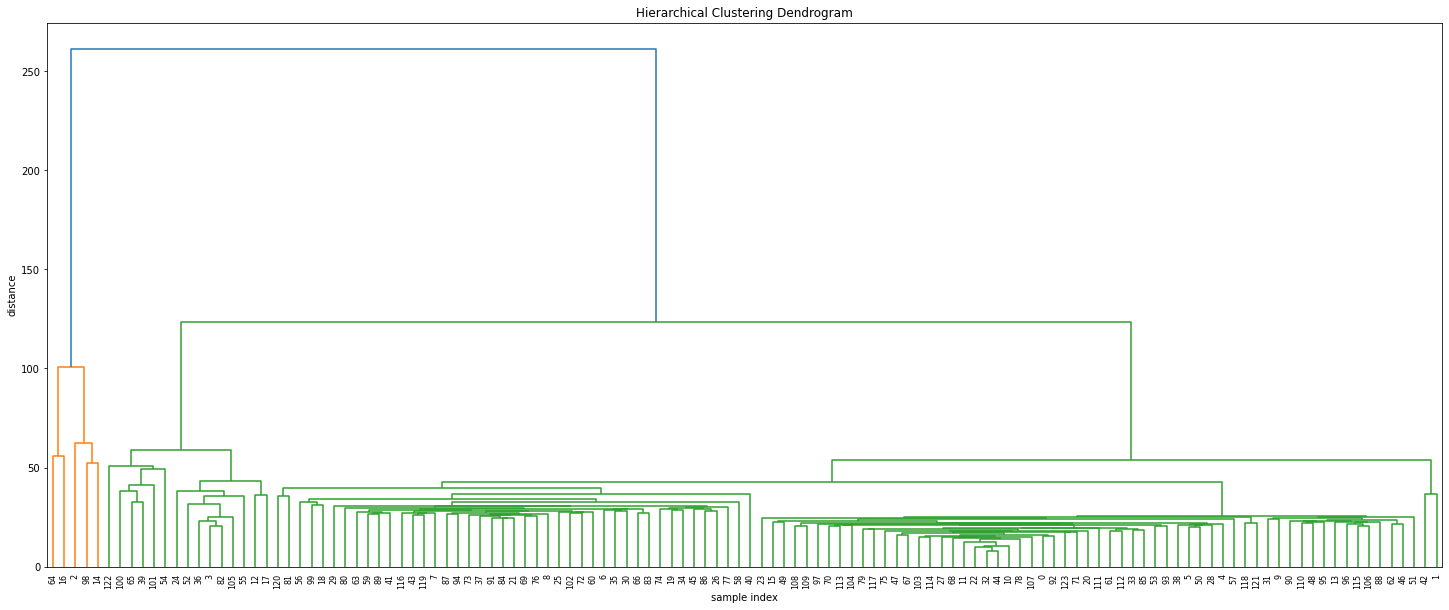

In [131]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    linkage_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# color threshold is automatically picked at 70% of the final distance

In [133]:
df_t.iloc[2]

0       0
1       0
2       0
3       1
4       0
       ..
2395    0
2396    0
2397    0
2398    0
2399    2
Name: F11, Length: 2400, dtype: int64

In [134]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

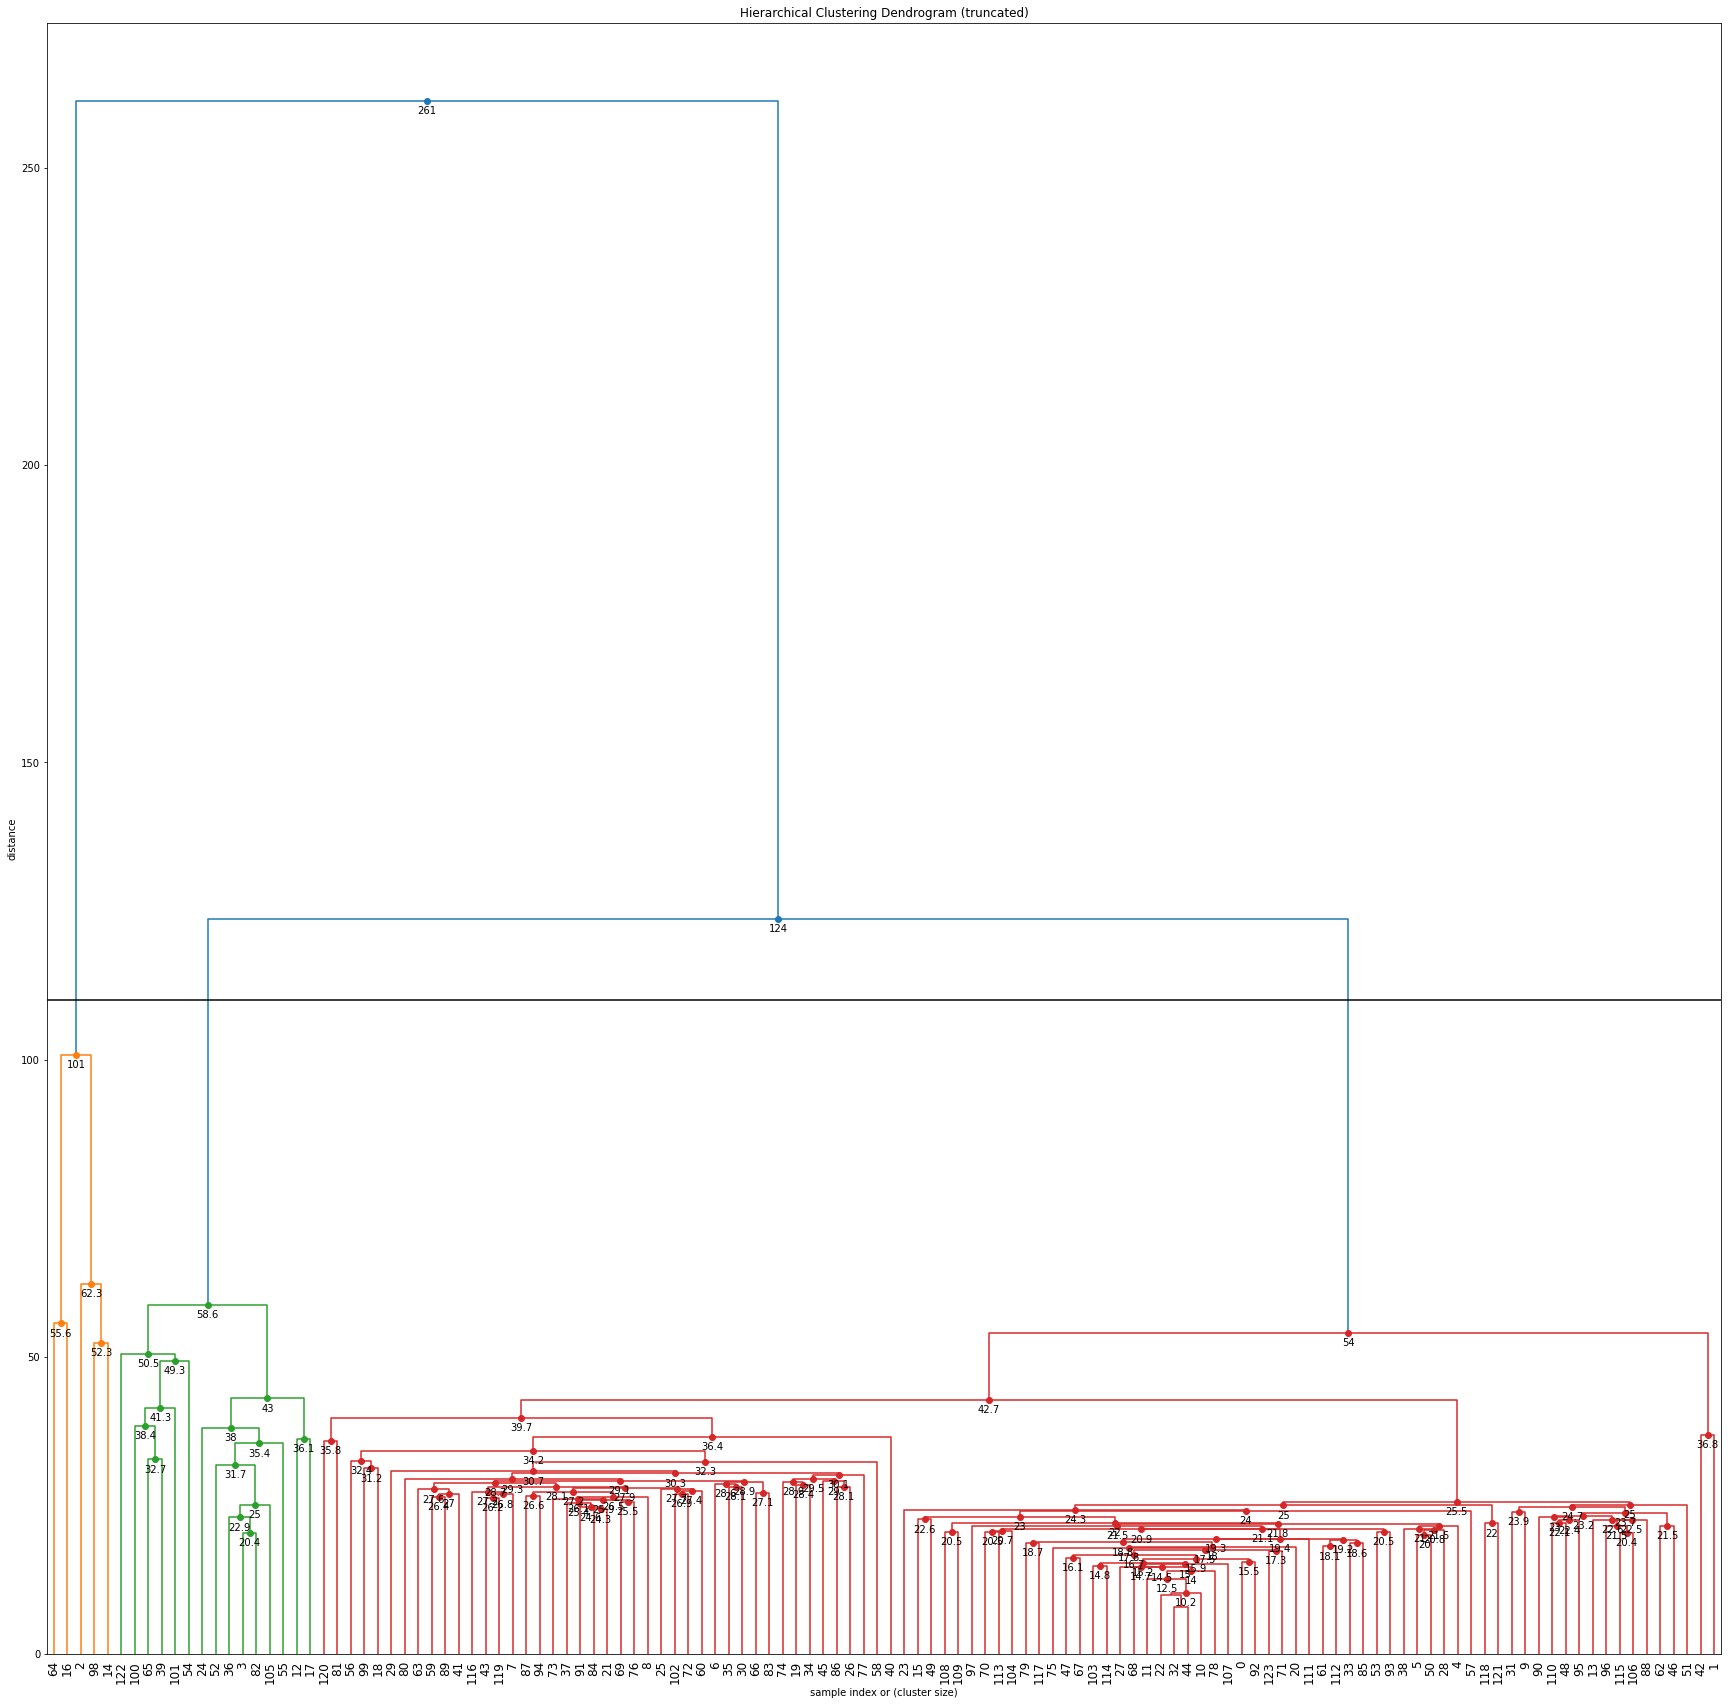

In [136]:
fig, ax = plt.subplots(1,1, figsize = (30,30))

ax = fancy_dendrogram(
    linkage_matrix,
    #truncate_mode='lastp',
    #p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d = 110
)
plt.show()

In [144]:
from scipy.cluster.hierarchy import fcluster
max_d = 110
clusters = fcluster(linkage_matrix, max_d, criterion='distance')
clusters

array([3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3], dtype=int32)

In [150]:
k=3
clusters = fcluster(linkage_matrix, k, criterion='maxclust')

In [157]:
# small function that takes 

cluster_dict = {}
for i in range(0, len(clusters)):
    key = np.asarray(df_t.index)[i]
    cluster = clusters[i]
    cluster_dict[key]=cluster


In [158]:
cluster_dict

{'R12': 3,
 'R4': 3,
 'F11': 1,
 'D12': 2,
 'D5': 3,
 'C12': 3,
 'K11': 3,
 'N9': 3,
 'R9': 3,
 'F2': 3,
 'P15': 3,
 'A9': 3,
 'D9': 2,
 'F16': 3,
 'E15': 1,
 'B4': 3,
 'E11': 1,
 'D11': 2,
 'N13': 3,
 'O7': 3,
 'N12': 3,
 'O5': 3,
 'I3': 3,
 'H8': 3,
 'C11': 2,
 'I13': 3,
 'C2': 3,
 'E7': 3,
 'C16': 3,
 'A6': 3,
 'C15': 3,
 'R8': 3,
 'M1': 3,
 'M2': 3,
 'O13': 3,
 'K2': 3,
 'D10': 2,
 'H10': 3,
 'F6': 3,
 'F12': 2,
 'D6': 3,
 'B15': 3,
 'R5': 3,
 'I5': 3,
 'I12': 3,
 'M10': 3,
 'P3': 3,
 'H3': 3,
 'B9': 3,
 'A5': 3,
 'I11': 3,
 'C6': 3,
 'D13': 2,
 'D16': 3,
 'F15': 2,
 'E14': 2,
 'K14': 3,
 'N7': 3,
 'K3': 3,
 'L11': 3,
 'P6': 3,
 'H7': 3,
 'P4': 3,
 'F7': 3,
 'E12': 1,
 'E13': 2,
 'G12': 3,
 'A7': 3,
 'C13': 3,
 'B7': 3,
 'B13': 3,
 'E5': 3,
 'P5': 3,
 'L7': 3,
 'I1': 3,
 'I14': 3,
 'P1': 3,
 'G2': 3,
 'P2': 3,
 'B12': 3,
 'H16': 3,
 'D7': 3,
 'D14': 2,
 'O15': 3,
 'D2': 3,
 'D1': 3,
 'K7': 3,
 'O10': 3,
 'R2': 3,
 'G4': 3,
 'N4': 3,
 'G3': 3,
 'M3': 3,
 'E4': 3,
 'E8': 3,
 'M4': 3,

In [164]:
for key in cluster_dict:
    
    completeframe.loc[(completeframe['channellabel']==str(key)), 'cluster'] = cluster_dict[key]
    

In [169]:
completeframe['cluster']

0      3.0
1      3.0
2      1.0
3      2.0
4      2.0
      ... 
204    2.0
205    2.0
206    3.0
207    2.0
208    2.0
Name: cluster, Length: 209, dtype: float64

In [171]:
completeframe_with_cluster = completeframe

In [172]:
completeframe_with_cluster.to_pickle(str('DF_' + filebase + '_' + 'complete_with_cluster') + '_df.pkl')

In [131]:
c, coph_dists = cophenet(linkage_matrix, pdist(df_t))
c

-0.16381441055552323

In [132]:
coph_dists

array([1.0413364 , 1.05798399, 1.05798399, ..., 1.03963372, 1.03963372,
       1.02726051])

### Create the same clustering just for bursts

In [ ]:
# bin the burstdictionaries per channel
binsize = 50 # in miliseconds
scale_factor_for_milisecond = 1e-03
binned_spike_dictionary = {}


bins= np.arange(0, length_recording*1000+binsize, binsize) # times 1000 to get the miliseconds
for key in:
    x = np.asarray(st_channel[key])*scale_factor_for_milisecond*tick
    binned_channel = np.histogram(x, bins)
    binned_spike_dictionary[key]  = binned_channel[0]

In [125]:
burststart_end_dic

{'R12': [],
 'R4': [(278680, 354680), (62549400, 62877400), (68718360, 68773080)],
 'F11': [(171680, 355760),
  (16306000, 16396800),
  (16708080, 16881680),
  (17188800, 17292600),
  (22767320, 23214560),
  (29958920, 36456040),
  (59723640, 60017160),
  (63156760, 63429280),
  (63567640, 63703640),
  (65100720, 65196960),
  (66822920, 66997960),
  (69083920, 69332080),
  (69803480, 69908960),
  (70207440, 70307720),
  (70903240, 71007520),
  (71579000, 71678200),
  (76401640, 82565280),
  (82794480, 83051160),
  (105388200, 105514240),
  (106195800, 106303720),
  (108990480, 109179240),
  (109961840, 110537400),
  (112158200, 112557880),
  (113106960, 113223200),
  (116242640, 116430840),
  (118733520, 119050760),
  (119550520, 119630600)],
 'D12': [(30013480, 30159880),
  (30289080, 32250720),
  (32422920, 32523640),
  (32644840, 33310560),
  (33687800, 34497400),
  (34733480, 34916120),
  (76696560, 77970560),
  (78105120, 78430800),
  (78607800, 80141640),
  (80300920, 80974800),


In [66]:
full_spike_list

[338.12,
 355.76,
 663.36,
 3287.52,
 4251.76,
 4503.96,
 5931.12,
 6011.12,
 7704.8,
 8445.08,
 8621.720000000001,
 9361.44,
 9385.0,
 9481.6,
 13834.8,
 14741.16,
 15016.6,
 16371.000000000002,
 16977.2,
 17797.440000000002,
 18004.68,
 20529.6,
 20952.0,
 21443.28,
 21941.88,
 23734.239999999998,
 24733.600000000002,
 25305.8,
 30207.68,
 30464.6,
 31007.88,
 31690.920000000002,
 32114.56,
 33469.92,
 36947.08,
 38178.8,
 39127.68,
 40336.68,
 40386.880000000005,
 41741.0,
 42727.880000000005,
 44857.240000000005,
 45803.92,
 46558.76,
 49141.880000000005,
 49421.92,
 49956.520000000004,
 50105.8,
 50756.72,
 52691.2,
 53163.0,
 53728.8,
 53947.240000000005,
 54360.0,
 55700.08,
 56556.04,
 56737.200000000004,
 56745.28,
 58117.240000000005,
 58598.76,
 61440.44,
 62029.36,
 62257.28,
 63033.4,
 64757.68,
 68902.64,
 69539.31999999999,
 69978.52,
 70280.44,
 70543.04000000001,
 71562.04,
 75387.4,
 75889.52,
 77178.0,
 78548.84,
 79732.36,
 79849.6,
 80514.40000000001,
 80896.48,
 8

In [63]:
# get a 1-D array with every detected spike
full_spike_list = []
for key in st_channel:
    x = list(np.asarray(st_channel[key])*scale_factor_for_milisecond*tick)
    full_spike_list = full_spike_list + x
full_spikes = sorted(full_spike_list)
    
    

In [68]:
array = np.asarray(list(st_channel.values()))

In [69]:
array

array([list([8453, 8894, 16584, 82188, 106294, 112599, 148278, 150278, 192620, 211127, 215543, 234036, 234625, 237040, 345870, 368529, 375415, 409275, 424430, 444936, 450117, 513240, 523800, 536082, 548547, 593356, 618340, 632645, 755192, 761615, 775197, 792273, 802864, 836748, 923677, 954470, 978192, 1008417, 1009672, 1043525, 1068197, 1121431, 1145098, 1163969, 1228547, 1235548, 1248913, 1252645, 1268918, 1317280, 1329075, 1343220, 1348681, 1359000, 1392502, 1413901, 1418430, 1418632, 1452931, 1464969, 1536011, 1550734, 1556432, 1575835, 1618942, 1722566, 1738483, 1749463, 1757011, 1763576, 1789051, 1884685, 1897238, 1929450, 1963721, 1993309, 1996240, 2012860, 2022412, 2042074, 2077264, 2099130, 2099418, 2108009, 2114669, 2140311, 2184107, 2187768, 2195376, 2230479, 2307551, 2314502, 2314954, 2329651, 2336844, 2356386, 2409637, 2415565, 2416680, 2419173, 2440993, 2444465, 2475238, 2545324, 2546864, 2565928, 2596750, 2624330, 2630306, 2640775, 2643324, 2646770, 2710951, 2741263, 2750

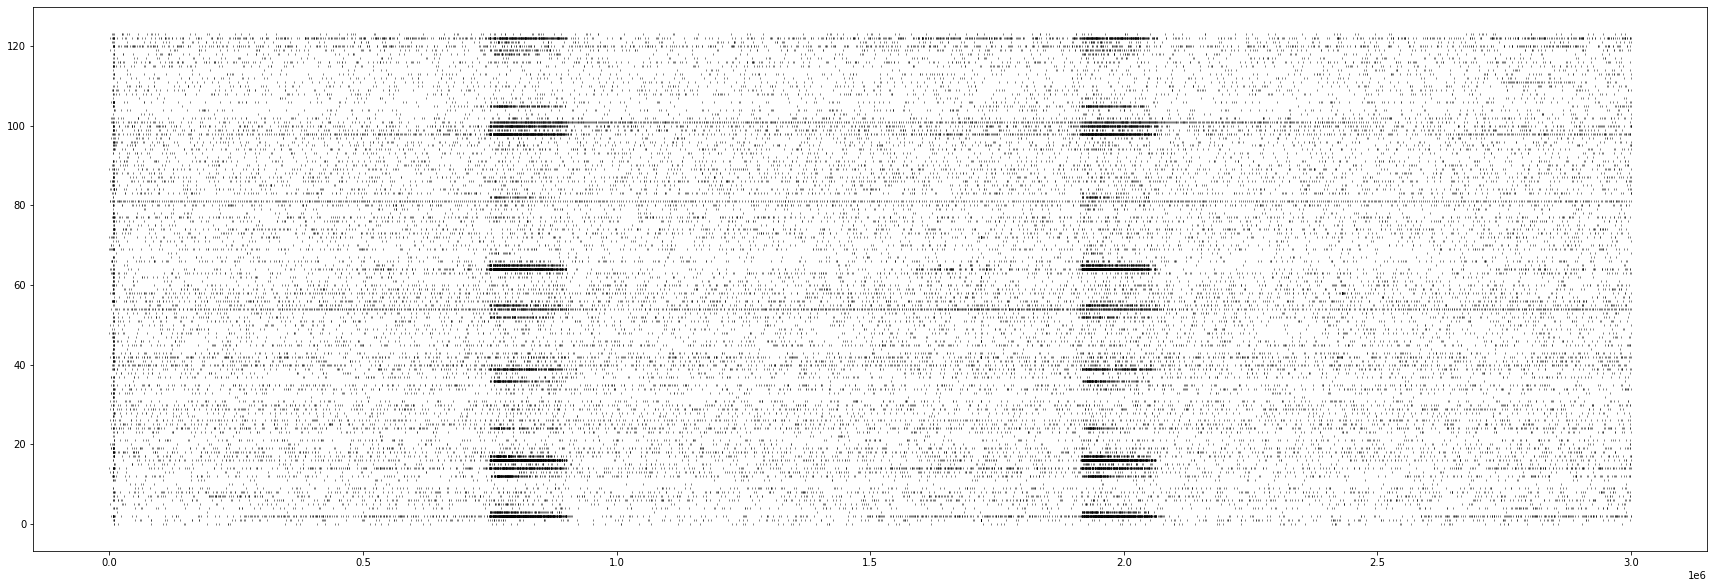

In [70]:
fig, ax = plt.subplots(1,1, figsize=(30,10))

ax = plt.eventplot(array, linewidths=0.5, linelengths=0.5, colors='black')

fig.savefig('rasterplot_191017_120ms.png', dpi=300)

In [71]:
binsize = 3 #ms
bins= np.arange(0, length_recording*1000+binsize, binsize)

In [72]:
#x = np.asarray(st_channel['O4'])*scale_factor_for_milisecond*tick

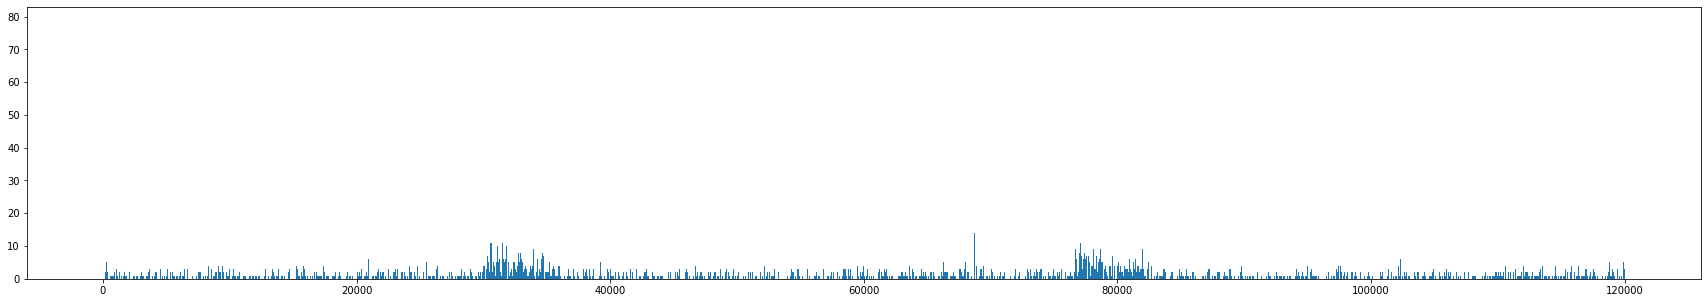

In [73]:
# plots the binned spikes
fig, ax = plt.subplots(1,1, figsize = (30,5))
ax = plt.hist(full_spikes, bins)


In [74]:
full_spikes_binned = np.histogram(full_spikes, bins)[0]

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

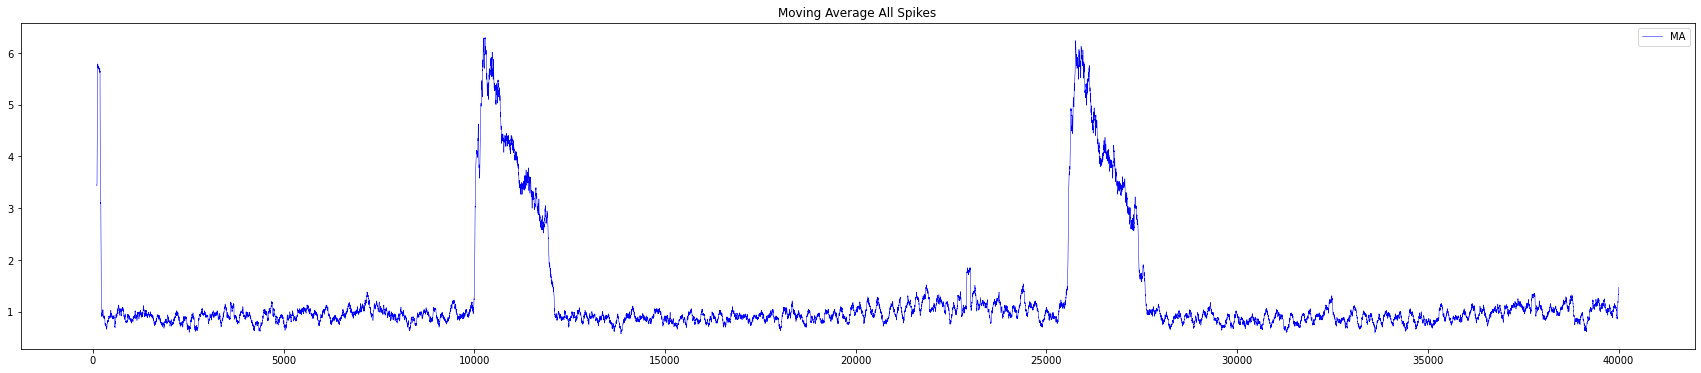

In [76]:
df= pd.DataFrame({'Spikes':full_spikes_binned}) #aus Network_ISI wird ein pdDF um die weiteren Schritte durchführen zu können
df["MA"] = df.Spikes.rolling(100).mean()
fig = df[['MA']].plot(color='b', linewidth=.5, figsize=(30,6), title="Moving Average All Spikes")

fig.savefig('spikes_smoothed_MA.png', dpi=300)

In [78]:
ma_array = np.asarray(df['MA'])

Text(0.5, 1.0, 'Smoothed Spikes per 3ms bin')

Text(0.5, 0, 'Bins 3ms')

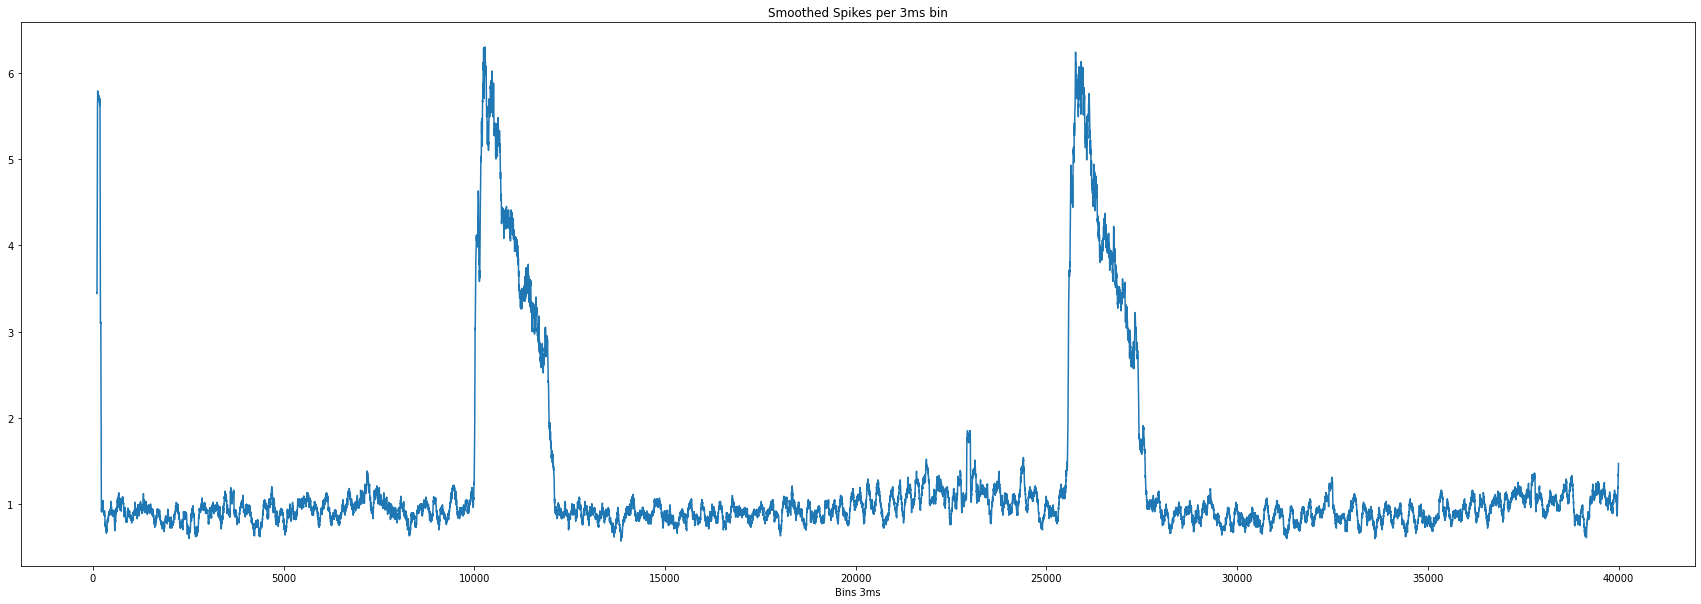

In [93]:
fig, ax = plt.subplots(1,1, figsize=(30,10))

ax.plot(ma_array)
ax.set_title('Smoothed Spikes per 3ms bin')
ax.set_xlabel('Bins 3ms')

fig.savefig('Smoothed_spikes_per_3ms.png', dpi=300)

In [207]:
bins

array([     0,      3,      6, ..., 299994, 299997, 300000])

In [209]:
binsize

50